In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Case study: K2-24, putting it all together

In this tutorial, we will combine many of the previous tutorials to perform a fit of the K2-24 system using the K2 transit data and the RVs from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497).
This is the same system that we fit in the :ref:`rv` tutorial and we'll combine that model with the transit model from the :ref:`transit` tutorial and the Gaussian Process noise model from the :ref:`stellar-variability` tutorial.

## Datasets and initializations

To get started, let's download the relevant datasets.
First, the transit light curve from [Everest](https://rodluger.github.io/everest/):

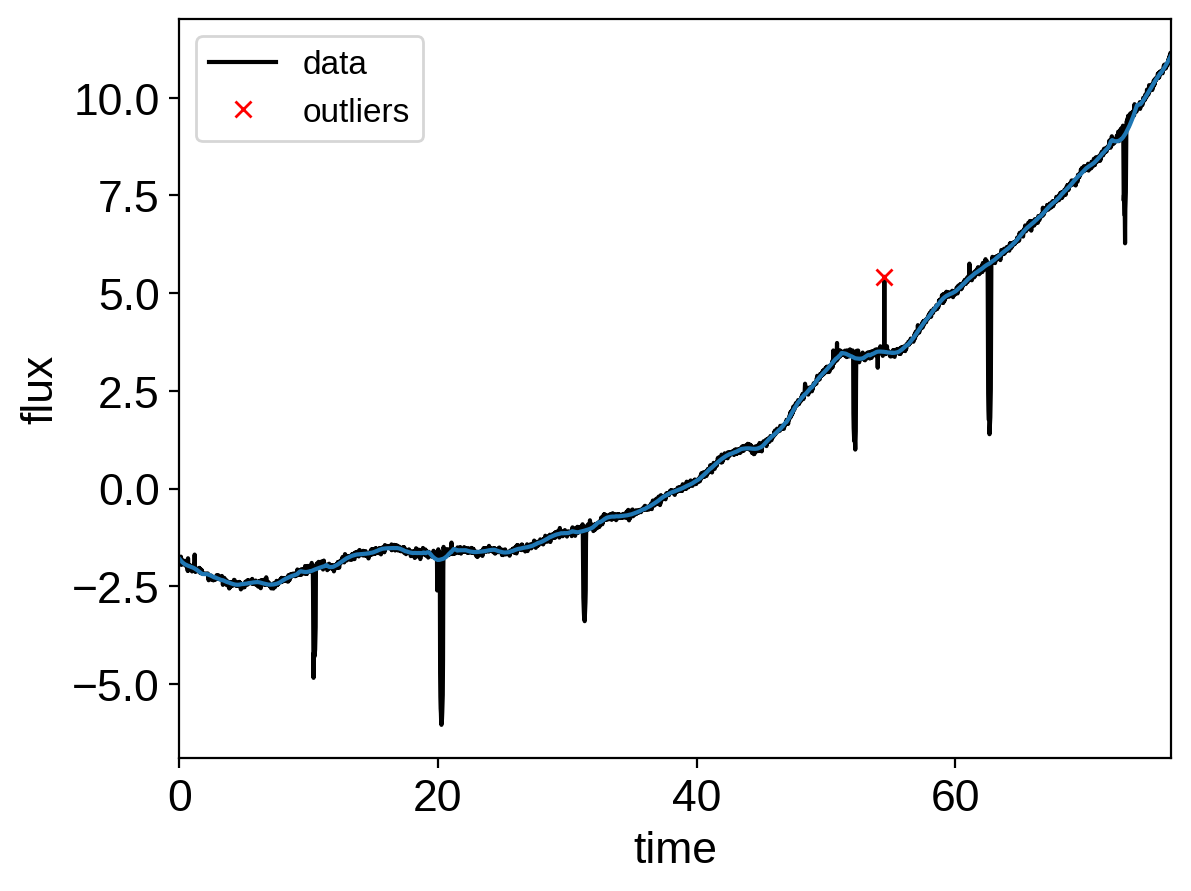

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.signal import savgol_filter

# Download the data
lc_url = "https://archive.stsci.edu/hlsps/everest/v2/c02/203700000/71098/hlsp_everest_k2_llc_203771098-c02_kepler_v2.0_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

# Work out the exposure time
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Mask bad data
m = (np.arange(len(lc)) > 100) & np.isfinite(lc["FLUX"]) & np.isfinite(lc["TIME"])
bad_bits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]
qual = lc["QUALITY"]
for b in bad_bits:
    m &= qual & 2 ** (b - 1) == 0

# Convert to parts per thousand
x = lc["TIME"][m]
y = lc["FLUX"][m]
mu = np.median(y)
y = (y / mu - 1) * 1e3

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid ** 2))
    m0 = np.abs(resid) < 3 * sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0

# Only discard positive outliers
m = resid < 3 * sigma

# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
plt.plot(x, y, "k", label="data")
plt.plot(x, smooth)
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlim(x.min(), x.max())
plt.xlabel("time")
plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

Then the RVs from [RadVel](https://radvel.readthedocs.io):

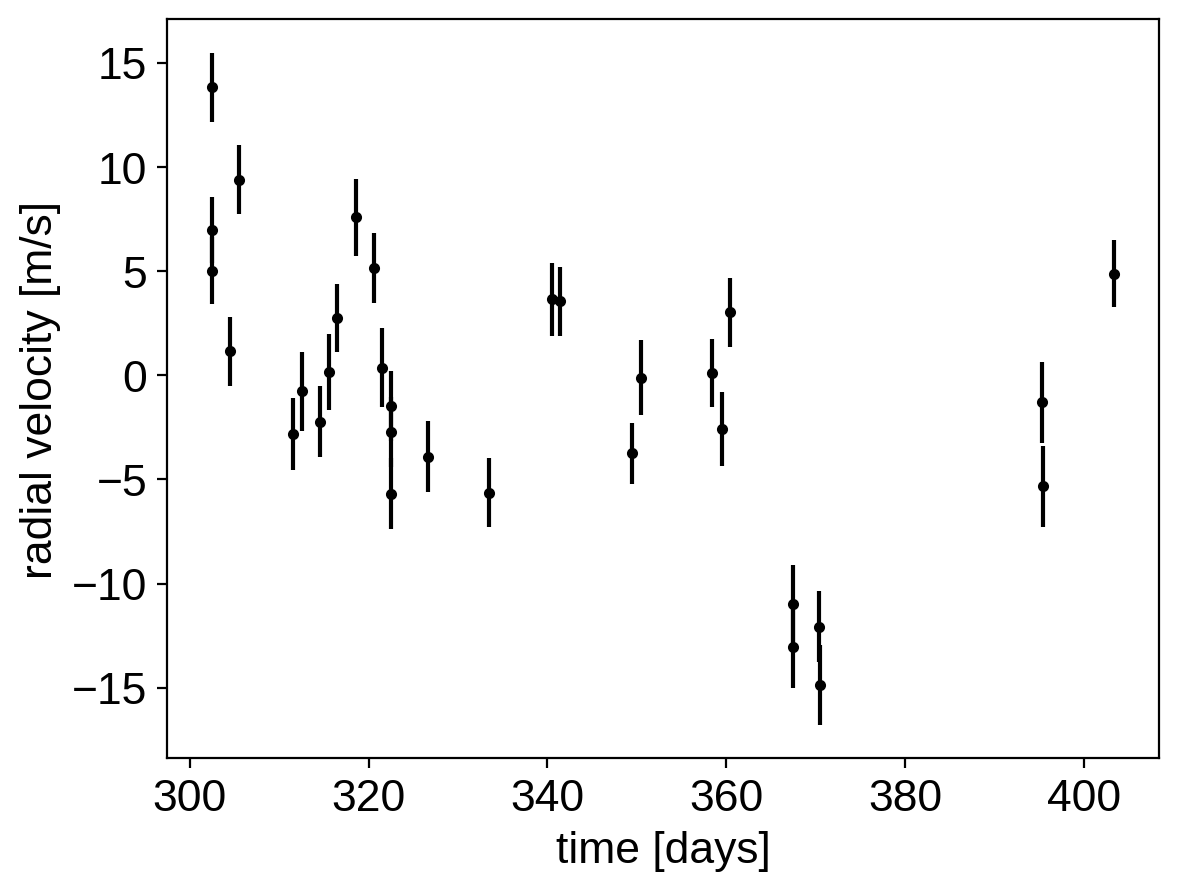

In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

# Don't forget to remove the time offset from above!
x_rv = np.array(data.t) - x_ref
y_rv = np.array(data.vel)
yerr_rv = np.array(data.errvel)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

We can initialize the transit parameters using [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/timeseries/bls.html).
(Note: you'll need AstroPy v3.1 or more recent to use this feature.)
A full discussion of transit detection and vetting is beyond the scope of this tutorial so let's assume that we know that there are two periodic transiting planets in this dataset.

In [5]:
from astropy.timeseries import BoxLeastSquares

m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(5), np.log(50), 50000))
bls_results = []
periods = []
t0s = []
depths = []

# Compute the periodogram for each planet by iteratively masking out
# transits from the higher signal to noise planets. Here we're assuming
# that we know that there are exactly two planets.
for i in range(2):
    bls = BoxLeastSquares(x[~m], y[~m] - smooth[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)

    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])

    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])

Let's plot the initial transit estimates based on these periodograms:

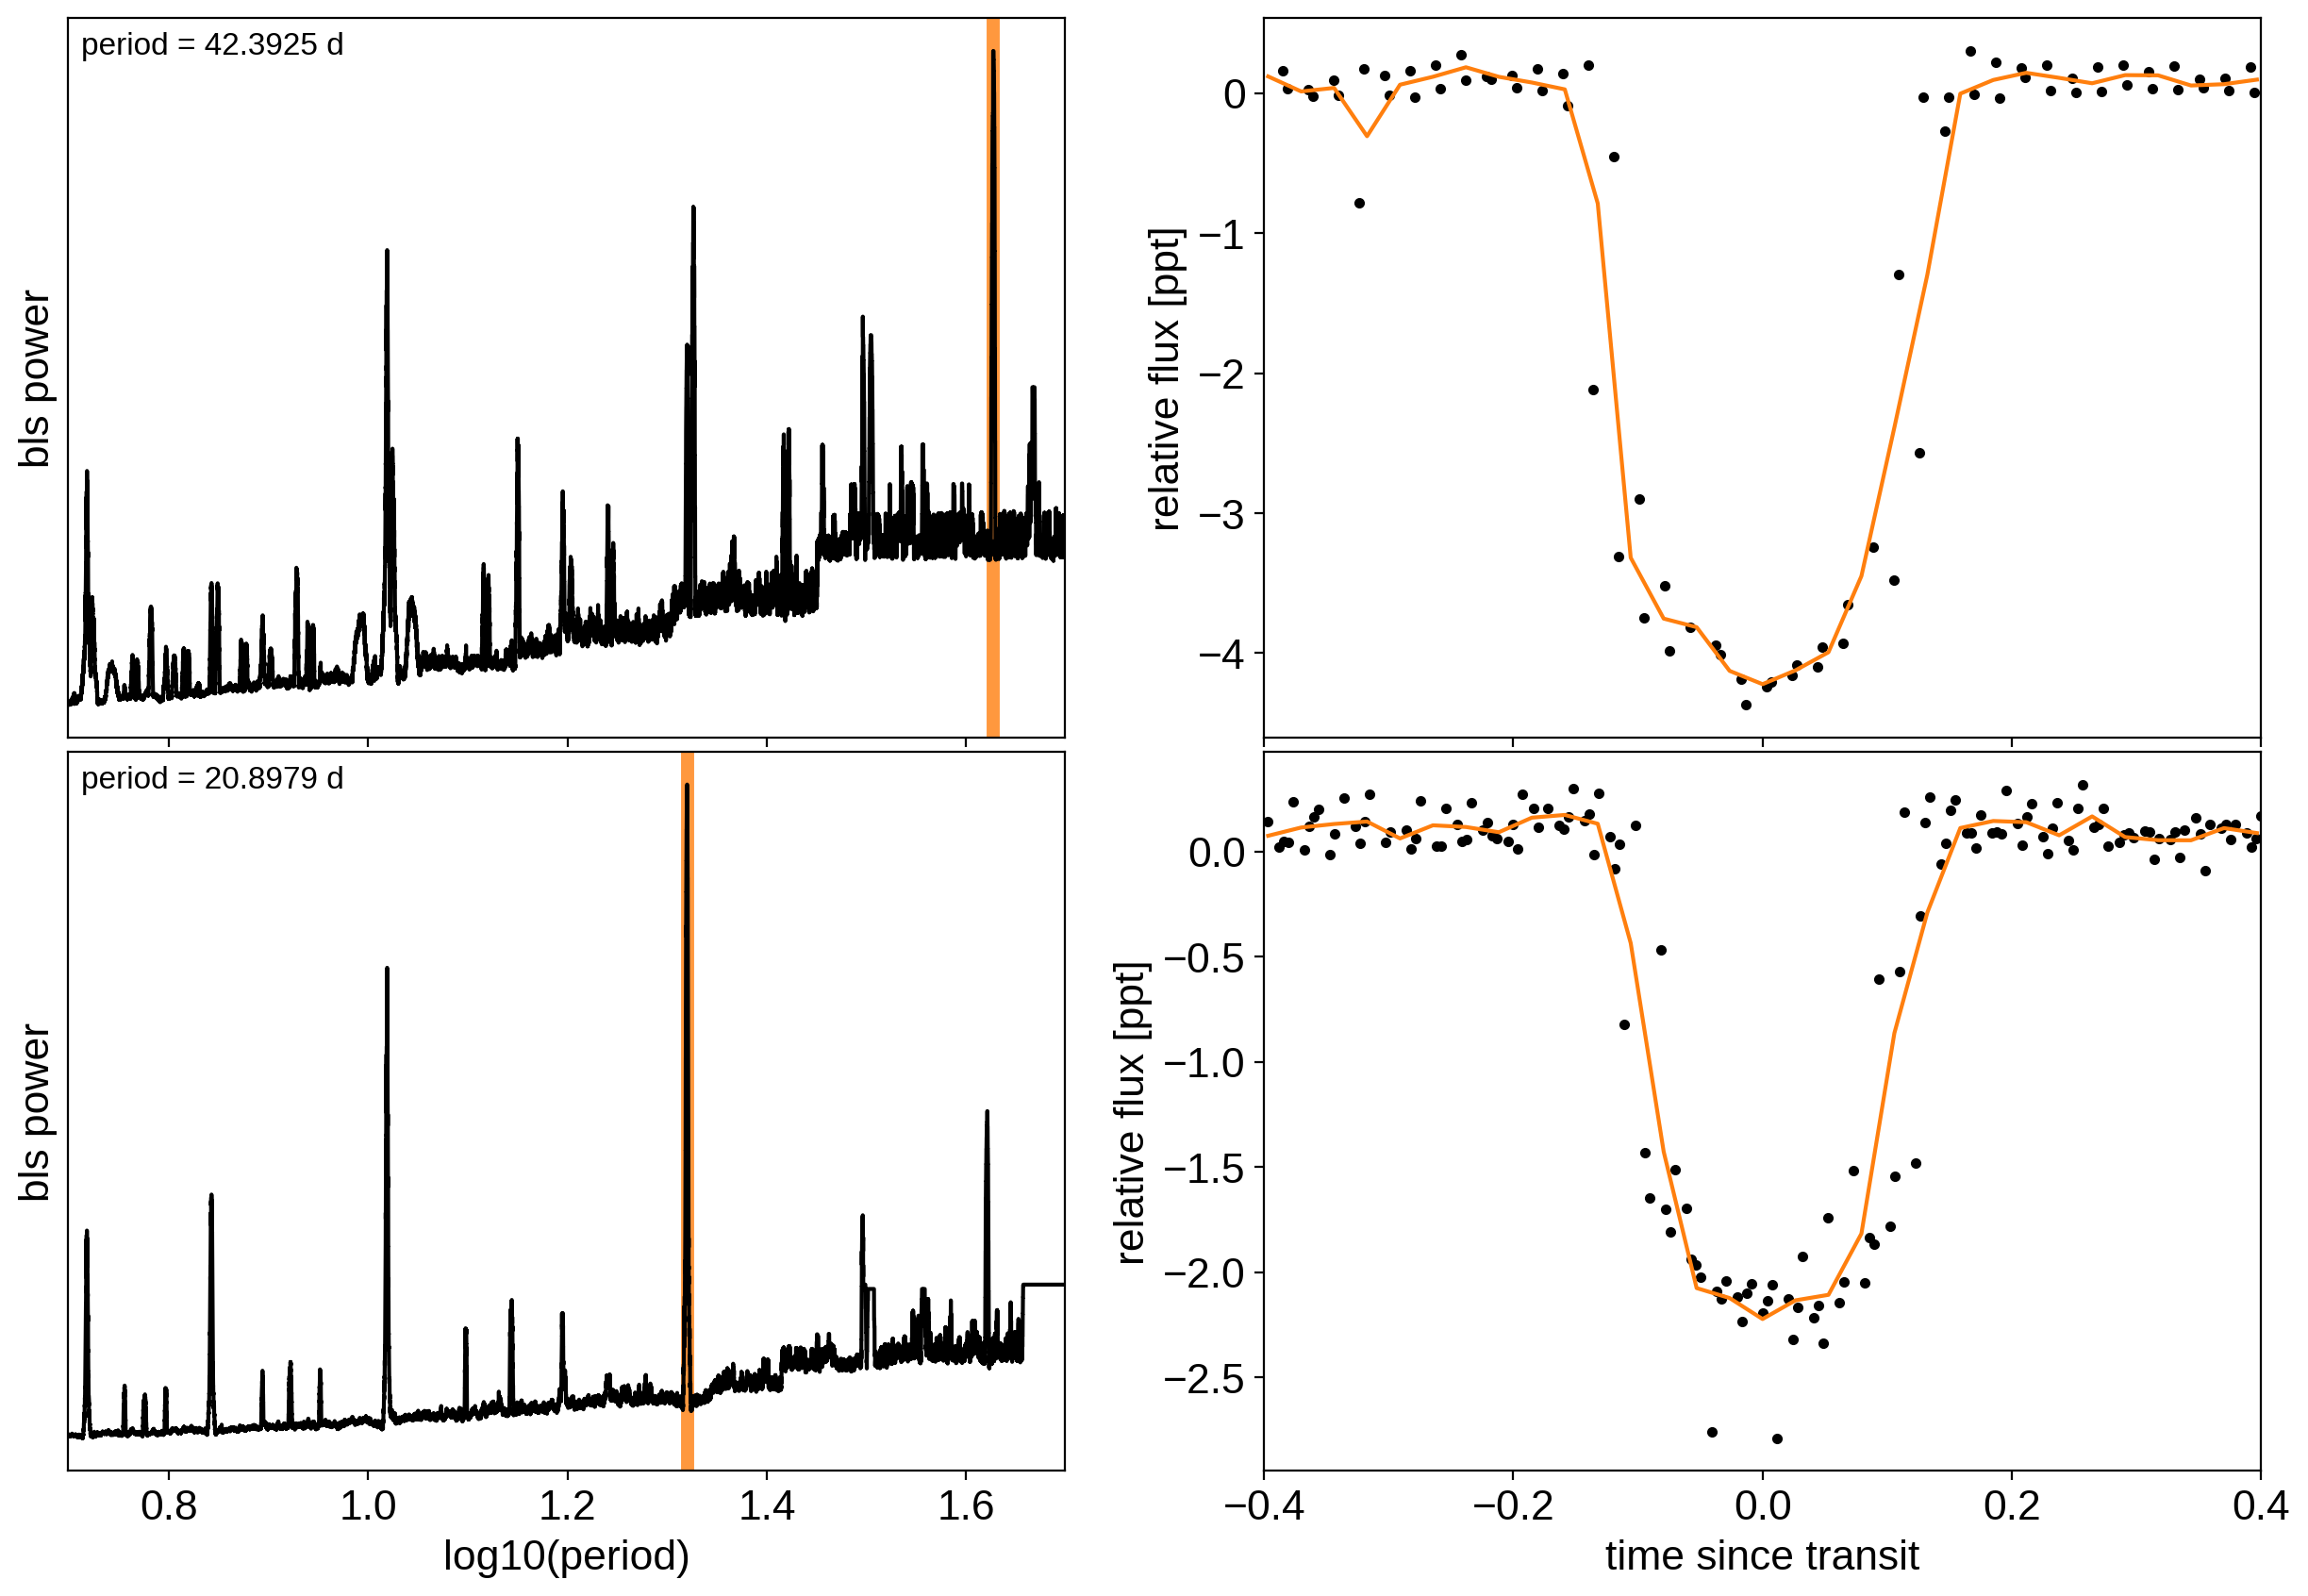

In [6]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i, 0]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate(
        "period = {0:.4f} d".format(periods[i]),
        (0, 1),
        xycoords="axes fraction",
        xytext=(5, -5),
        textcoords="offset points",
        va="top",
        ha="left",
        fontsize=12,
    )
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")

    # Plot the folded transit
    ax = axes[i, 1]
    p = periods[i]
    x_fold = (x - t0s[i] + 0.5 * p) % p - 0.5 * p
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], y[m] - smooth[m], ".k")

    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 32)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y - smooth)
    denom[num == 0] = 1.0
    ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")

fig.subplots_adjust(hspace=0.02)

The discovery paper for K2-24 ([Petigura et al. (2016)](https://arxiv.org/abs/1511.04497)) includes the following estimates of the stellar mass and radius in Solar units:

In [7]:
M_star_petigura = 1.12, 0.05
R_star_petigura = 1.21, 0.11

Finally, using this stellar mass, we can also estimate the minimum masses of the planets given these transit parameters.

In [8]:
import exoplanet as xo
import astropy.units as u

msini = xo.estimate_minimum_mass(
    periods, x_rv, y_rv, yerr_rv, t0s=t0s, m_star=M_star_petigura[0]
)
msini = msini.to(u.M_earth)
print(msini)

[32.80060146 23.89885976] earthMass


## A joint transit and radial velocity model in PyMC3

Now, let's define our full model in *PyMC3*.
There's a lot going on here, but I've tried to comment it and most of it should be familiar from the previous tutorials (:ref:`rv`, :ref:`transit`, :ref:`gp`, and :ref:`stellar-variability`).
In this case, I've put the model inside a model "factory" function because we'll do some sigma clipping below.

In [9]:
import pymc3 as pm
import theano.tensor as tt

t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.QuadLimbDark("u_star")
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star_petigura[0], sd=M_star_petigura[1])
        r_star = BoundedNormal("r_star", mu=R_star_petigura[0], sd=R_star_petigura[1])

        # Orbital parameters for the planets
        logm = pm.Normal("logm", mu=np.log(msini.value), sd=1, shape=2)
        logP = pm.Normal("logP", mu=np.log(periods), sd=1, shape=2)
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=2)
        logr = pm.Normal(
            "logr",
            mu=0.5 * np.log(1e-3 * np.array(depths)) + np.log(R_star_petigura[0]),
            sd=1.0,
            shape=2,
        )
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        b = xo.ImpactParameter("b", ror=ror, shape=2)

        ecs = xo.UnitDisk("ecs", shape=(2, 2), testval=0.01 * np.ones((2, 2)))
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.vaneylen19("ecc_prior", multi=True, shape=2, observed=ecc)

        # RV jitter & a quadratic RV trend
        logs_rv = pm.Normal("logs_rv", mu=np.log(np.median(yerr_rv)), sd=5)
        trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0 = pm.Normal("logw0", mu=0.0, sd=10)
        logSw4 = pm.Normal("logSw4", mu=np.log(np.var(y[mask])), sd=10)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        m_pl = pm.Deterministic("m_pl", tt.exp(logm))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            m_planet=xo.units.with_unit(m_pl, msini.unit),
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve using starry
        def mean_model(t):
            light_curves = pm.Deterministic(
                "light_curves",
                xo.LimbDarkLightCurve(u_star).get_light_curve(
                    orbit=orbit, r=r_pl, t=t, texp=texp
                )
                * 1e3,
            )
            return pm.math.sum(light_curves, axis=-1) + mean

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))
        gp = xo.gp.GP(
            kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), mean=mean_model
        )
        gp.marginal("transit_obs", observed=y[mask])
        pm.Deterministic("gp_pred", gp.predict())

        # And then include the RVs as in the RV tutorial
        x_rv_ref = 0.5 * (x_rv.min() + x_rv.max())

        def get_rv_model(t, name=""):
            # First the RVs induced by the planets
            vrad = orbit.get_radial_velocity(t)
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_rv_ref, 3)
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum over planets and add the background to get the full model
            return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1) + bkg)

        # Define the model
        rv_model = get_rv_model(x_rv)
        get_rv_model(t_rv, name="_pred")

        # The likelihood for the RVs
        err = tt.sqrt(yerr_rv ** 2 + tt.exp(2 * logs_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[trend])
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logr, b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logSw4])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln


model0, map_soln0 = build_model()

optimizing logp for variables: [trend]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.282570e+03]

1it [00:00, 64.92it/s, logp=-8.282570e+03]

2it [00:00, 93.40it/s, logp=-8.282570e+03]

3it [00:00, 112.56it/s, logp=-5.396766e+06]

4it [00:00, 127.38it/s, logp=-8.282310e+03]

5it [00:00, 140.58it/s, logp=-8.281807e+03]

6it [00:00, 152.70it/s, logp=-8.280230e+03]

7it [00:00, 161.72it/s, logp=-8.276461e+03]

8it [00:00, 171.12it/s, logp=-8.270940e+03]

9it [00:00, 180.27it/s, logp=-8.269538e+03]

10it [00:00, 188.81it/s, logp=-8.269538e+03]

11it [00:00, 197.90it/s, logp=-8.269538e+03]

12it [00:13,  1.12s/it, logp=-8.269538e+03] 


message: Optimization terminated successfully.
logp: -8282.57015224409 -> -8269.537627952766


optimizing logp for variables: [logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.269538e+03]

1it [00:00, 136.98it/s, logp=-8.269538e+03]

2it [00:00, 201.36it/s, logp=-8.269538e+03]

3it [00:00, 237.12it/s, logp=-6.546399e+03]

4it [00:00, 262.64it/s, logp=-5.158326e+01]

5it [00:00, 278.67it/s, logp=-3.542397e+05]

6it [00:00, 290.74it/s, logp=1.191602e+02] 

7it [00:00, 301.63it/s, logp=1.770672e+03]

8it [00:00, 310.22it/s, logp=1.852615e+03]

9it [00:00, 316.26it/s, logp=1.995596e+03]

10it [00:00, 321.41it/s, logp=2.108774e+03]

11it [00:00, 326.39it/s, logp=2.117537e+03]

12it [00:00, 329.26it/s, logp=2.117857e+03]

13it [00:00, 332.70it/s, logp=2.117857e+03]

14it [00:00, 335.01it/s, logp=2.117857e+03]

15it [00:01,  9.77it/s, logp=2.117857e+03] 


message: Optimization terminated successfully.
logp: -8269.537627952766 -> 2117.8573435796625


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.117857e+03]

1it [00:00, 148.12it/s, logp=2.117857e+03]

2it [00:00, 214.19it/s, logp=2.117857e+03]

3it [00:00, 249.16it/s, logp=-3.329302e+04]

4it [00:00, 272.72it/s, logp=2.605150e+03] 

5it [00:00, 287.67it/s, logp=1.043564e+02]

6it [00:00, 301.94it/s, logp=2.613717e+03]

7it [00:00, 309.87it/s, logp=2.625068e+03]

8it [00:00, 317.16it/s, logp=2.632251e+03]

9it [00:00, 321.57it/s, logp=2.634707e+03]

10it [00:00, 326.00it/s, logp=2.638709e+03]

11it [00:00, 327.78it/s, logp=2.643221e+03]

12it [00:00, 331.66it/s, logp=2.644818e+03]

13it [00:00, 333.67it/s, logp=2.646322e+03]

14it [00:00, 336.70it/s, logp=2.648624e+03]

15it [00:00, 339.87it/s, logp=2.650278e+03]

16it [00:00, 342.44it/s, logp=2.652850e+03]

17it [00:00, 343.82it/s, logp=2.652902e+03]

18it [00:00, 347.22it/s, logp=2.654227e+03]

19it [00:00, 348.84it/s, logp=2.656489e+03]

20it [00:00, 350.66it/s, logp=2.659707e+03]

21it [00:00, 351.32it/s, logp=2.664800e+03]

22it [00:00, 351.97it/s, logp=2.672599e+03]

23it [00:00, 352.82it/s, logp=2.674744e+03]

24it [00:00, 353.87it/s, logp=2.677564e+03]

25it [00:00, 355.02it/s, logp=2.684600e+03]

26it [00:00, 355.41it/s, logp=2.692404e+03]

27it [00:00, 355.51it/s, logp=2.694286e+03]

28it [00:00, 355.30it/s, logp=2.696434e+03]

29it [00:00, 355.32it/s, logp=2.696793e+03]

30it [00:00, 356.45it/s, logp=2.696792e+03]

31it [00:00, 357.86it/s, logp=2.696815e+03]

32it [00:00, 358.66it/s, logp=2.696822e+03]

33it [00:00, 359.05it/s, logp=2.696822e+03]

34it [00:00, 359.89it/s, logp=2.696822e+03]

35it [00:00, 360.52it/s, logp=2.696822e+03]

36it [00:00, 360.97it/s, logp=2.696822e+03]

37it [00:00, 369.11it/s, logp=2.696822e+03]

37it [00:00, 369.11it/s, logp=2.696822e+03]

38it [00:01, 22.20it/s, logp=2.696822e+03] 


message: Optimization terminated successfully.
logp: 2117.8573435796625 -> 2696.8220532480464


optimizing logp for variables: [t0, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.696822e+03]

1it [00:00, 124.39it/s, logp=2.696822e+03]

2it [00:00, 185.50it/s, logp=2.696822e+03]

3it [00:00, 213.90it/s, logp=-5.025110e+03]

4it [00:00, 236.88it/s, logp=-1.578971e+02]

5it [00:00, 255.51it/s, logp=-8.006002e+02]

6it [00:00, 269.70it/s, logp=-9.547575e+02]

7it [00:00, 281.21it/s, logp=-6.251277e+02]

8it [00:00, 290.25it/s, logp=9.127022e+02] 

9it [00:00, 297.63it/s, logp=2.893315e+03]

10it [00:00, 303.16it/s, logp=-5.152372e+01]

11it [00:00, 309.08it/s, logp=2.891616e+03] 

12it [00:00, 314.29it/s, logp=2.895660e+03]

13it [00:00, 314.70it/s, logp=2.900379e+03]

14it [00:00, 318.29it/s, logp=2.918882e+03]

15it [00:00, 322.19it/s, logp=2.986599e+03]

16it [00:00, 324.63it/s, logp=3.135572e+03]

17it [00:00, 327.11it/s, logp=3.218986e+03]

18it [00:00, 329.30it/s, logp=3.247635e+03]

19it [00:00, 331.23it/s, logp=3.251831e+03]

20it [00:00, 332.87it/s, logp=3.251921e+03]

21it [00:00, 334.47it/s, logp=3.251922e+03]

22it [00:00, 336.09it/s, logp=3.251922e+03]

23it [00:00, 337.27it/s, logp=3.251922e+03]

24it [00:00, 338.33it/s, logp=3.251922e+03]

25it [00:00, 340.05it/s, logp=3.251922e+03]

26it [00:00, 341.55it/s, logp=3.251922e+03]

27it [00:00, 342.86it/s, logp=3.251922e+03]

28it [00:00, 344.28it/s, logp=3.251922e+03]

29it [00:00, 345.36it/s, logp=3.251922e+03]

30it [00:00, 346.60it/s, logp=3.251922e+03]

31it [00:00, 347.61it/s, logp=3.251922e+03]

32it [00:00, 348.41it/s, logp=3.251922e+03]

33it [00:00, 348.93it/s, logp=3.251922e+03]

34it [00:00, 349.97it/s, logp=3.251922e+03]

35it [00:00, 350.73it/s, logp=3.251922e+03]

36it [00:00, 358.70it/s, logp=3.251922e+03]

36it [00:00, 358.70it/s, logp=3.251922e+03]

37it [00:00, 358.70it/s, logp=3.251922e+03]

38it [00:00, 358.70it/s, logp=3.251922e+03]

39it [00:00, 358.70it/s, logp=3.251922e+03]

40it [00:00, 358.70it/s, logp=3.251922e+03]

41it [00:00, 358.70it/s, logp=3.251922e+03]

42it [00:00, 358.70it/s, logp=3.251922e+03]

43it [00:00, 358.70it/s, logp=3.251922e+03]

44it [00:00, 358.70it/s, logp=3.251922e+03]

45it [00:00, 358.70it/s, logp=3.251922e+03]

46it [00:00, 358.70it/s, logp=3.251922e+03]

47it [00:00, 358.70it/s, logp=3.251922e+03]

48it [00:00, 358.70it/s, logp=3.251922e+03]

49it [00:00, 358.70it/s, logp=3.251922e+03]

50it [00:00, 358.70it/s, logp=3.251922e+03]

51it [00:00, 358.70it/s, logp=3.251922e+03]

52it [00:00, 358.70it/s, logp=3.251922e+03]

53it [00:00, 358.70it/s, logp=3.251922e+03]

54it [00:00, 358.70it/s, logp=3.251922e+03]

55it [00:00, 358.70it/s, logp=3.251922e+03]

56it [00:00, 358.70it/s, logp=3.251922e+03]

57it [00:00, 358.70it/s, logp=3.251922e+03]

58it [00:00, 358.70it/s, logp=3.251922e+03]

59it [00:00, 358.70it/s, logp=3.251922e+03]

60it [00:00, 358.70it/s, logp=3.251922e+03]

61it [00:00, 358.70it/s, logp=3.251922e+03]

62it [00:00, 358.70it/s, logp=3.251922e+03]

63it [00:00, 358.70it/s, logp=3.251922e+03]

64it [00:00, 358.70it/s, logp=3.251922e+03]

65it [00:00, 358.70it/s, logp=3.251922e+03]

66it [00:00, 358.70it/s, logp=3.251922e+03]

67it [00:00, 358.70it/s, logp=3.251922e+03]

68it [00:00, 358.70it/s, logp=3.251922e+03]

69it [00:00, 358.70it/s, logp=3.251922e+03]

70it [00:00, 358.70it/s, logp=3.251922e+03]

71it [00:00, 358.70it/s, logp=3.251922e+03]

72it [00:00, 358.70it/s, logp=3.251922e+03]

73it [00:00, 358.70it/s, logp=3.251922e+03]

74it [00:00, 364.57it/s, logp=3.251922e+03]

74it [00:00, 364.57it/s, logp=3.251922e+03]

75it [00:00, 364.57it/s, logp=3.251922e+03]

76it [00:00, 364.57it/s, logp=3.251922e+03]

77it [00:00, 364.57it/s, logp=3.251922e+03]

78it [00:00, 364.57it/s, logp=3.251922e+03]

79it [00:00, 364.57it/s, logp=3.251922e+03]

80it [00:00, 364.57it/s, logp=3.251922e+03]

81it [00:00, 364.57it/s, logp=3.251922e+03]

82it [00:00, 364.57it/s, logp=3.251922e+03]

83it [00:00, 364.57it/s, logp=3.251922e+03]

84it [00:00, 364.57it/s, logp=3.251922e+03]

85it [00:00, 364.57it/s, logp=3.251922e+03]

86it [00:00, 364.57it/s, logp=3.251922e+03]

87it [00:00, 364.57it/s, logp=3.251922e+03]

88it [00:00, 364.57it/s, logp=3.251922e+03]

89it [00:00, 364.57it/s, logp=3.251922e+03]

90it [00:00, 364.57it/s, logp=3.251922e+03]

91it [00:00, 364.57it/s, logp=3.251922e+03]

92it [00:00, 364.57it/s, logp=3.251922e+03]

93it [00:00, 364.57it/s, logp=3.251922e+03]

94it [00:00, 364.57it/s, logp=3.251922e+03]

95it [00:00, 364.57it/s, logp=3.251922e+03]

96it [00:00, 364.57it/s, logp=3.251922e+03]

97it [00:00, 364.57it/s, logp=3.251922e+03]

98it [00:00, 364.57it/s, logp=3.251922e+03]

99it [00:00, 364.57it/s, logp=3.251922e+03]

100it [00:00, 364.57it/s, logp=3.251922e+03]

101it [00:00, 364.57it/s, logp=3.251922e+03]

102it [00:00, 364.57it/s, logp=3.251922e+03]

103it [00:00, 364.57it/s, logp=3.251922e+03]

104it [00:00, 364.57it/s, logp=3.251922e+03]

105it [00:00, 364.57it/s, logp=3.251922e+03]

106it [00:00, 364.57it/s, logp=3.251922e+03]

107it [00:00, 364.57it/s, logp=3.251922e+03]

108it [00:00, 364.57it/s, logp=3.251922e+03]

109it [00:00, 364.57it/s, logp=3.251922e+03]

110it [00:00, 364.57it/s, logp=3.251922e+03]

111it [00:00, 364.57it/s, logp=3.251922e+03]

112it [00:00, 364.57it/s, logp=3.251922e+03]

113it [00:00, 370.84it/s, logp=3.251922e+03]

113it [00:00, 370.84it/s, logp=3.251922e+03]

114it [00:00, 370.84it/s, logp=3.251922e+03]

115it [00:00, 370.84it/s, logp=3.251922e+03]

116it [00:00, 370.84it/s, logp=3.251922e+03]

117it [00:00, 370.84it/s, logp=3.251922e+03]

118it [00:00, 370.84it/s, logp=3.251922e+03]

119it [00:00, 370.84it/s, logp=3.251922e+03]

120it [00:00, 370.84it/s, logp=3.251922e+03]

121it [00:00, 370.84it/s, logp=3.251922e+03]

122it [00:00, 370.84it/s, logp=3.251922e+03]

123it [00:00, 370.84it/s, logp=3.251922e+03]

124it [00:00, 370.84it/s, logp=3.251922e+03]

125it [00:00, 370.84it/s, logp=3.251922e+03]

126it [00:00, 370.84it/s, logp=3.251922e+03]

127it [00:00, 370.84it/s, logp=3.251922e+03]

128it [00:00, 370.84it/s, logp=3.251922e+03]

129it [00:00, 370.84it/s, logp=3.251922e+03]

130it [00:00, 370.84it/s, logp=3.251922e+03]

131it [00:00, 370.84it/s, logp=3.251922e+03]

132it [00:00, 370.84it/s, logp=3.251922e+03]

133it [00:00, 370.84it/s, logp=3.251922e+03]

134it [00:02, 63.45it/s, logp=3.251922e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 2696.8220532480464 -> 3251.9220705309353


optimizing logp for variables: [logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.251922e+03]

1it [00:00, 131.43it/s, logp=3.251922e+03]

2it [00:00, 192.74it/s, logp=3.251922e+03]

3it [00:00, 224.59it/s, logp=3.750351e+03]

4it [00:00, 234.35it/s, logp=-4.142749e+03]

5it [00:00, 250.86it/s, logp=3.902669e+03] 

6it [00:00, 262.84it/s, logp=3.905053e+03]

7it [00:00, 272.88it/s, logp=3.906091e+03]

8it [00:00, 280.52it/s, logp=3.906092e+03]

9it [00:00, 287.27it/s, logp=3.906093e+03]

10it [00:00, 292.79it/s, logp=3.906093e+03]

11it [00:00, 295.42it/s, logp=3.906093e+03]

12it [00:00, 266.19it/s, logp=3.906093e+03]

13it [00:00, 249.98it/s, logp=3.906093e+03]

14it [00:00, 241.90it/s, logp=3.906093e+03]

15it [00:00, 236.07it/s, logp=3.906093e+03]

16it [00:00, 235.71it/s, logp=3.906093e+03]

17it [00:00, 235.11it/s, logp=3.906093e+03]

18it [00:00, 236.27it/s, logp=3.906093e+03]

19it [00:00, 238.16it/s, logp=3.906093e+03]

20it [00:00, 240.18it/s, logp=3.906093e+03]

21it [00:00, 243.78it/s, logp=3.906093e+03]

22it [00:00, 247.16it/s, logp=3.906093e+03]

23it [00:00, 250.43it/s, logp=3.906093e+03]

24it [00:00, 253.61it/s, logp=3.906093e+03]

25it [00:00, 256.72it/s, logp=3.906093e+03]

26it [00:00, 259.66it/s, logp=3.906093e+03]

27it [00:00, 267.93it/s, logp=3.906093e+03]

27it [00:00, 267.93it/s, logp=3.906093e+03]

28it [00:00, 267.93it/s, logp=3.906093e+03]

29it [00:00, 267.93it/s, logp=3.906093e+03]

30it [00:00, 267.93it/s, logp=3.906093e+03]

31it [00:00, 267.93it/s, logp=3.906093e+03]

32it [00:00, 267.93it/s, logp=3.906093e+03]

33it [00:00, 267.93it/s, logp=3.906093e+03]

34it [00:00, 267.93it/s, logp=3.906093e+03]

35it [00:00, 267.93it/s, logp=3.906093e+03]

36it [00:00, 267.93it/s, logp=3.906093e+03]

37it [00:00, 267.93it/s, logp=3.906093e+03]

38it [00:00, 267.93it/s, logp=3.906093e+03]

39it [00:00, 267.93it/s, logp=3.906093e+03]

40it [00:00, 267.93it/s, logp=3.906093e+03]

41it [00:00, 267.93it/s, logp=3.906093e+03]

42it [00:00, 267.93it/s, logp=3.906093e+03]

43it [00:00, 267.93it/s, logp=3.906093e+03]

44it [00:00, 267.93it/s, logp=3.906093e+03]

45it [00:00, 267.93it/s, logp=3.906093e+03]

46it [00:00, 267.93it/s, logp=3.906093e+03]

47it [00:00, 267.93it/s, logp=3.906093e+03]

48it [00:00, 267.93it/s, logp=3.906093e+03]

49it [00:00, 267.93it/s, logp=3.906093e+03]

50it [00:00, 267.93it/s, logp=3.906093e+03]

51it [00:00, 267.93it/s, logp=3.906093e+03]

52it [00:00, 267.93it/s, logp=3.906093e+03]

53it [00:00, 267.93it/s, logp=3.906093e+03]

54it [00:00, 267.93it/s, logp=3.906093e+03]

55it [00:00, 267.93it/s, logp=3.906093e+03]

56it [00:00, 267.93it/s, logp=3.906093e+03]

57it [00:00, 267.93it/s, logp=3.906093e+03]

58it [00:00, 267.93it/s, logp=3.906093e+03]

59it [00:00, 267.93it/s, logp=3.906093e+03]

60it [00:00, 267.93it/s, logp=3.906093e+03]

61it [00:00, 267.93it/s, logp=3.906093e+03]

62it [00:00, 267.93it/s, logp=3.906093e+03]

63it [00:00, 289.35it/s, logp=3.906093e+03]

63it [00:00, 289.35it/s, logp=3.906093e+03]

64it [00:00, 289.35it/s, logp=3.906093e+03]

65it [00:00, 289.35it/s, logp=3.906093e+03]

66it [00:00, 289.35it/s, logp=3.906093e+03]

67it [00:00, 289.35it/s, logp=3.906093e+03]

68it [00:00, 289.35it/s, logp=3.906093e+03]

69it [00:00, 289.35it/s, logp=3.906093e+03]

70it [00:00, 289.35it/s, logp=3.906093e+03]

71it [00:00, 289.35it/s, logp=3.906093e+03]

72it [00:00, 289.35it/s, logp=3.906093e+03]

73it [00:00, 289.35it/s, logp=3.906093e+03]

74it [00:00, 289.35it/s, logp=3.906093e+03]

75it [00:00, 289.35it/s, logp=3.906093e+03]

76it [00:00, 289.35it/s, logp=3.906093e+03]

77it [00:00, 289.35it/s, logp=3.906093e+03]

78it [00:00, 289.35it/s, logp=3.906093e+03]

79it [00:00, 289.35it/s, logp=3.906093e+03]

80it [00:00, 289.35it/s, logp=3.906093e+03]

81it [00:00, 289.35it/s, logp=3.906093e+03]

82it [00:00, 289.35it/s, logp=3.906093e+03]

83it [00:00, 289.35it/s, logp=3.906093e+03]

84it [00:00, 289.35it/s, logp=3.906093e+03]

85it [00:00, 289.35it/s, logp=3.906093e+03]

86it [00:00, 289.35it/s, logp=3.906093e+03]

87it [00:00, 289.35it/s, logp=3.906093e+03]

88it [00:00, 289.35it/s, logp=3.906093e+03]

89it [00:00, 289.35it/s, logp=3.906093e+03]

90it [00:00, 289.35it/s, logp=3.906093e+03]

91it [00:00, 289.35it/s, logp=3.906093e+03]

92it [00:00, 287.93it/s, logp=3.906093e+03]

92it [00:00, 287.93it/s, logp=3.906093e+03]

93it [00:00, 287.93it/s, logp=3.906093e+03]

94it [00:00, 287.93it/s, logp=3.906093e+03]

95it [00:00, 287.93it/s, logp=3.906093e+03]

96it [00:00, 287.93it/s, logp=3.906093e+03]

97it [00:00, 287.93it/s, logp=3.906093e+03]

98it [00:00, 287.93it/s, logp=3.906093e+03]

99it [00:00, 287.93it/s, logp=3.906093e+03]

100it [00:00, 287.93it/s, logp=3.906093e+03]

101it [00:00, 287.93it/s, logp=3.906093e+03]

102it [00:00, 287.93it/s, logp=3.906093e+03]

103it [00:00, 287.93it/s, logp=3.906093e+03]

104it [00:00, 287.93it/s, logp=3.906093e+03]

105it [00:00, 287.93it/s, logp=3.906093e+03]

106it [00:00, 287.93it/s, logp=3.906093e+03]

107it [00:00, 287.93it/s, logp=3.906093e+03]

108it [00:00, 287.93it/s, logp=3.906093e+03]

109it [00:00, 287.93it/s, logp=3.906093e+03]

110it [00:00, 287.93it/s, logp=3.906093e+03]

111it [00:00, 287.93it/s, logp=3.906093e+03]

112it [00:00, 287.93it/s, logp=3.906093e+03]

113it [00:00, 287.93it/s, logp=3.906093e+03]

114it [00:00, 287.93it/s, logp=3.906093e+03]

115it [00:00, 287.93it/s, logp=3.906093e+03]

116it [00:00, 287.93it/s, logp=3.906093e+03]

117it [00:00, 287.93it/s, logp=3.906093e+03]

118it [00:00, 287.93it/s, logp=3.906093e+03]

119it [00:00, 287.93it/s, logp=3.906093e+03]

120it [00:00, 287.93it/s, logp=3.906093e+03]

121it [00:00, 287.93it/s, logp=3.906093e+03]

122it [00:00, 287.93it/s, logp=3.906093e+03]

123it [00:00, 287.93it/s, logp=3.906093e+03]

124it [00:00, 287.93it/s, logp=3.906093e+03]

125it [00:00, 287.93it/s, logp=3.906093e+03]

126it [00:00, 287.93it/s, logp=3.906093e+03]

127it [00:00, 301.99it/s, logp=3.906093e+03]

127it [00:00, 301.99it/s, logp=3.906093e+03]

128it [00:00, 301.99it/s, logp=3.906093e+03]

129it [00:00, 301.99it/s, logp=3.906093e+03]

130it [00:00, 301.99it/s, logp=3.906093e+03]

131it [00:02, 62.03it/s, logp=3.906093e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 3251.922070530933 -> 3906.092568184921


optimizing logp for variables: [logw0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.906093e+03]

1it [00:00, 119.33it/s, logp=3.906093e+03]

2it [00:00, 175.63it/s, logp=3.906093e+03]

3it [00:00, 206.27it/s, logp=4.009198e+03]

4it [00:00, 222.16it/s, logp=4.009404e+03]

5it [00:00, 232.98it/s, logp=4.010104e+03]

6it [00:00, 244.45it/s, logp=4.010129e+03]

7it [00:00, 252.77it/s, logp=4.010545e+03]

8it [00:00, 257.39it/s, logp=4.010571e+03]

9it [00:00, 263.77it/s, logp=4.010575e+03]

10it [00:00, 266.11it/s, logp=4.010575e+03]

11it [00:00, 270.16it/s, logp=4.010575e+03]

12it [00:01,  6.72it/s, logp=4.010575e+03] 


message: Optimization terminated successfully.
logp: 3906.092568184921 -> 4010.575080730371


optimizing logp for variables: [logSw4, logw0, logs2, trend, logs_rv, ecc_prior_frac, ecc_prior_sigma_rayleigh, ecc_prior_sigma_gauss, ecs, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=4.010575e+03]

1it [00:00, 99.32it/s, logp=4.010575e+03]

2it [00:00, 144.26it/s, logp=4.010575e+03]

3it [00:00, 162.42it/s, logp=-5.648716e+03]

4it [00:00, 179.78it/s, logp=-8.077767e+03]

5it [00:00, 187.51it/s, logp=-1.148771e+04]

6it [00:00, 196.07it/s, logp=3.996128e+03] 

7it [00:00, 203.84it/s, logp=4.010674e+03]

8it [00:00, 209.44it/s, logp=4.006483e+03]

9it [00:00, 214.59it/s, logp=4.010677e+03]

10it [00:00, 217.36it/s, logp=4.010681e+03]

11it [00:00, 220.29it/s, logp=4.010701e+03]

12it [00:00, 224.22it/s, logp=4.010777e+03]

13it [00:00, 221.75it/s, logp=4.011078e+03]

14it [00:00, 223.99it/s, logp=4.012201e+03]

15it [00:00, 225.93it/s, logp=4.015035e+03]

16it [00:00, 226.88it/s, logp=4.020604e+03]

17it [00:00, 228.66it/s, logp=4.039674e+03]

18it [00:00, 230.44it/s, logp=4.059294e+03]

19it [00:00, 231.55it/s, logp=3.954586e+03]

20it [00:00, 233.02it/s, logp=4.061974e+03]

21it [00:00, 233.31it/s, logp=4.067140e+03]

22it [00:00, 235.27it/s, logp=4.082740e+03]

23it [00:00, 235.66it/s, logp=4.122560e+03]

24it [00:00, 235.25it/s, logp=4.196767e+03]

25it [00:00, 243.23it/s, logp=4.196767e+03]

25it [00:00, 243.23it/s, logp=4.295353e+03]

26it [00:00, 243.23it/s, logp=4.389364e+03]

27it [00:00, 243.23it/s, logp=3.946451e+03]

28it [00:00, 243.23it/s, logp=4.404683e+03]

29it [00:00, 243.23it/s, logp=4.424397e+03]

30it [00:00, 243.23it/s, logp=4.448485e+03]

31it [00:00, 243.23it/s, logp=4.469955e+03]

32it [00:00, 243.23it/s, logp=4.484363e+03]

33it [00:00, 243.23it/s, logp=4.506999e+03]

34it [00:00, 243.23it/s, logp=4.385908e+03]

35it [00:00, 243.23it/s, logp=4.512442e+03]

36it [00:00, 243.23it/s, logp=4.521653e+03]

37it [00:00, 243.23it/s, logp=4.538413e+03]

38it [00:00, 243.23it/s, logp=4.557672e+03]

39it [00:00, 243.23it/s, logp=4.579036e+03]

40it [00:00, 243.23it/s, logp=4.601594e+03]

41it [00:00, 243.23it/s, logp=4.604420e+03]

42it [00:00, 243.23it/s, logp=4.609730e+03]

43it [00:00, 243.23it/s, logp=4.618268e+03]

44it [00:00, 243.23it/s, logp=4.627015e+03]

45it [00:00, 243.23it/s, logp=4.638103e+03]

46it [00:00, 243.23it/s, logp=4.634427e+03]

47it [00:00, 243.23it/s, logp=4.641840e+03]

48it [00:00, 243.23it/s, logp=4.647894e+03]

49it [00:00, 243.23it/s, logp=4.657568e+03]

50it [00:00, 244.59it/s, logp=4.657568e+03]

50it [00:00, 244.59it/s, logp=4.665155e+03]

51it [00:00, 244.59it/s, logp=4.675746e+03]

52it [00:00, 244.59it/s, logp=4.680753e+03]

53it [00:00, 244.59it/s, logp=4.687043e+03]

54it [00:00, 244.59it/s, logp=4.693320e+03]

55it [00:00, 244.59it/s, logp=4.697477e+03]

56it [00:00, 244.59it/s, logp=4.703138e+03]

57it [00:00, 244.59it/s, logp=4.706266e+03]

58it [00:00, 244.59it/s, logp=4.709462e+03]

59it [00:00, 244.59it/s, logp=4.711735e+03]

60it [00:00, 244.59it/s, logp=4.713150e+03]

61it [00:00, 244.59it/s, logp=4.712489e+03]

62it [00:00, 244.59it/s, logp=4.713723e+03]

63it [00:00, 244.59it/s, logp=4.714329e+03]

64it [00:00, 244.59it/s, logp=4.714660e+03]

65it [00:00, 244.59it/s, logp=4.715059e+03]

66it [00:00, 244.59it/s, logp=4.715420e+03]

67it [00:00, 244.59it/s, logp=4.715831e+03]

68it [00:00, 244.59it/s, logp=4.716255e+03]

69it [00:00, 244.59it/s, logp=4.716816e+03]

70it [00:00, 244.59it/s, logp=4.717297e+03]

71it [00:00, 244.59it/s, logp=4.717773e+03]

72it [00:00, 244.59it/s, logp=4.718298e+03]

73it [00:00, 244.59it/s, logp=4.718673e+03]

74it [00:00, 244.59it/s, logp=4.718961e+03]

75it [00:00, 244.59it/s, logp=4.719254e+03]

76it [00:00, 246.55it/s, logp=4.719254e+03]

76it [00:00, 246.55it/s, logp=4.719496e+03]

77it [00:00, 246.55it/s, logp=4.719679e+03]

78it [00:00, 246.55it/s, logp=4.719762e+03]

79it [00:00, 246.55it/s, logp=4.719871e+03]

80it [00:00, 246.55it/s, logp=4.720053e+03]

81it [00:00, 246.55it/s, logp=4.720370e+03]

82it [00:00, 246.55it/s, logp=4.720913e+03]

83it [00:00, 246.55it/s, logp=4.720948e+03]

84it [00:00, 246.55it/s, logp=4.721212e+03]

85it [00:00, 246.55it/s, logp=4.721699e+03]

86it [00:00, 246.55it/s, logp=4.722278e+03]

87it [00:00, 246.55it/s, logp=4.723214e+03]

88it [00:00, 246.55it/s, logp=4.724894e+03]

89it [00:00, 246.55it/s, logp=4.727753e+03]

90it [00:00, 246.55it/s, logp=4.731058e+03]

91it [00:00, 246.55it/s, logp=4.731766e+03]

92it [00:00, 246.55it/s, logp=4.732773e+03]

93it [00:00, 246.55it/s, logp=4.734315e+03]

94it [00:00, 246.55it/s, logp=4.735246e+03]

95it [00:00, 246.55it/s, logp=4.735668e+03]

96it [00:00, 246.55it/s, logp=4.735918e+03]

97it [00:00, 246.55it/s, logp=4.736141e+03]

98it [00:00, 246.55it/s, logp=4.736236e+03]

99it [00:00, 246.55it/s, logp=4.736279e+03]

100it [00:00, 246.55it/s, logp=4.736293e+03]

101it [00:00, 246.55it/s, logp=4.736297e+03]

102it [00:00, 249.30it/s, logp=4.736297e+03]

102it [00:00, 249.30it/s, logp=4.736304e+03]

103it [00:00, 249.30it/s, logp=4.736315e+03]

104it [00:00, 249.30it/s, logp=4.736336e+03]

105it [00:00, 249.30it/s, logp=4.736369e+03]

106it [00:00, 249.30it/s, logp=4.736414e+03]

107it [00:00, 249.30it/s, logp=4.736445e+03]

108it [00:00, 249.30it/s, logp=4.736461e+03]

109it [00:00, 249.30it/s, logp=4.736472e+03]

110it [00:00, 249.30it/s, logp=4.736476e+03]

111it [00:00, 249.30it/s, logp=4.736479e+03]

112it [00:00, 249.30it/s, logp=4.736484e+03]

113it [00:00, 249.30it/s, logp=4.736491e+03]

114it [00:00, 249.30it/s, logp=4.736504e+03]

115it [00:00, 249.30it/s, logp=4.736524e+03]

116it [00:00, 249.30it/s, logp=4.736556e+03]

117it [00:00, 249.30it/s, logp=4.736591e+03]

118it [00:00, 249.30it/s, logp=4.736628e+03]

119it [00:00, 249.30it/s, logp=4.736663e+03]

120it [00:00, 249.30it/s, logp=4.736687e+03]

121it [00:00, 249.30it/s, logp=4.736719e+03]

122it [00:00, 249.30it/s, logp=4.736702e+03]

123it [00:00, 249.30it/s, logp=4.736727e+03]

124it [00:00, 249.30it/s, logp=4.736740e+03]

125it [00:00, 249.30it/s, logp=4.736749e+03]

126it [00:00, 249.30it/s, logp=4.736753e+03]

127it [00:00, 249.30it/s, logp=4.736756e+03]

128it [00:00, 250.60it/s, logp=4.736756e+03]

128it [00:00, 250.60it/s, logp=4.736760e+03]

129it [00:00, 250.60it/s, logp=4.736764e+03]

130it [00:00, 250.60it/s, logp=4.736769e+03]

131it [00:00, 250.60it/s, logp=4.736771e+03]

132it [00:00, 250.60it/s, logp=4.736774e+03]

133it [00:00, 250.60it/s, logp=4.736779e+03]

134it [00:00, 250.60it/s, logp=4.736786e+03]

135it [00:00, 250.60it/s, logp=4.736792e+03]

136it [00:00, 250.60it/s, logp=4.736792e+03]

137it [00:00, 250.60it/s, logp=4.736795e+03]

138it [00:00, 250.60it/s, logp=4.736799e+03]

139it [00:00, 250.60it/s, logp=4.736806e+03]

140it [00:00, 250.60it/s, logp=4.736819e+03]

141it [00:00, 250.60it/s, logp=4.736842e+03]

142it [00:00, 250.60it/s, logp=4.736864e+03]

143it [00:00, 250.60it/s, logp=4.736863e+03]

144it [00:00, 250.60it/s, logp=4.736841e+03]

145it [00:00, 250.60it/s, logp=4.736871e+03]

146it [00:00, 250.60it/s, logp=4.736886e+03]

147it [00:00, 250.60it/s, logp=4.736912e+03]

148it [00:00, 250.60it/s, logp=4.736954e+03]

149it [00:00, 250.60it/s, logp=4.736980e+03]

150it [00:00, 250.60it/s, logp=4.737015e+03]

151it [00:00, 250.60it/s, logp=4.737041e+03]

152it [00:00, 250.60it/s, logp=4.737074e+03]

153it [00:00, 250.60it/s, logp=4.737096e+03]

154it [00:00, 252.45it/s, logp=4.737096e+03]

154it [00:00, 252.45it/s, logp=4.737102e+03]

155it [00:00, 252.45it/s, logp=4.737107e+03]

156it [00:00, 252.45it/s, logp=4.737113e+03]

157it [00:00, 252.45it/s, logp=4.737110e+03]

158it [00:00, 252.45it/s, logp=4.737115e+03]

159it [00:00, 252.45it/s, logp=4.737118e+03]

160it [00:00, 252.45it/s, logp=4.737120e+03]

161it [00:00, 252.45it/s, logp=4.737121e+03]

162it [00:00, 252.45it/s, logp=4.737123e+03]

163it [00:00, 252.45it/s, logp=4.737125e+03]

164it [00:00, 252.45it/s, logp=4.737128e+03]

165it [00:00, 252.45it/s, logp=4.737132e+03]

166it [00:00, 252.45it/s, logp=4.737134e+03]

167it [00:00, 252.45it/s, logp=4.737135e+03]

168it [00:00, 252.45it/s, logp=4.737136e+03]

169it [00:00, 252.45it/s, logp=4.737136e+03]

170it [00:00, 252.45it/s, logp=4.737136e+03]

171it [00:00, 252.45it/s, logp=4.737136e+03]

172it [00:00, 252.45it/s, logp=4.737136e+03]

173it [00:00, 252.45it/s, logp=4.737137e+03]

174it [00:00, 252.45it/s, logp=4.737060e+03]

175it [00:00, 252.45it/s, logp=4.737138e+03]

176it [00:00, 252.45it/s, logp=4.736639e+03]

177it [00:00, 252.45it/s, logp=4.737137e+03]

178it [00:00, 252.45it/s, logp=4.737138e+03]

179it [00:00, 252.45it/s, logp=4.737138e+03]

180it [00:00, 253.76it/s, logp=4.737138e+03]

180it [00:00, 253.76it/s, logp=4.737138e+03]

181it [00:00, 253.76it/s, logp=4.737140e+03]

182it [00:00, 253.76it/s, logp=4.737143e+03]

183it [00:00, 253.76it/s, logp=4.737148e+03]

184it [00:00, 253.76it/s, logp=4.737158e+03]

185it [00:00, 253.76it/s, logp=4.737175e+03]

186it [00:00, 253.76it/s, logp=4.737194e+03]

187it [00:00, 253.76it/s, logp=4.737162e+03]

188it [00:00, 253.76it/s, logp=4.737197e+03]

189it [00:00, 253.76it/s, logp=4.737198e+03]

190it [00:00, 253.76it/s, logp=4.737198e+03]

191it [00:00, 253.76it/s, logp=4.737198e+03]

192it [00:00, 253.76it/s, logp=4.737198e+03]

193it [00:00, 253.76it/s, logp=4.737198e+03]

194it [00:00, 253.76it/s, logp=4.737198e+03]

195it [00:00, 253.76it/s, logp=4.737198e+03]

196it [00:00, 253.76it/s, logp=4.737198e+03]

197it [00:00, 253.76it/s, logp=4.737198e+03]

198it [00:00, 253.76it/s, logp=4.737198e+03]

199it [00:00, 253.76it/s, logp=4.737198e+03]

200it [00:00, 253.76it/s, logp=4.737198e+03]

201it [00:00, 253.76it/s, logp=4.737198e+03]

202it [00:00, 253.76it/s, logp=4.737198e+03]

203it [00:00, 253.76it/s, logp=4.737198e+03]

204it [00:00, 253.76it/s, logp=4.737199e+03]

205it [00:00, 253.76it/s, logp=4.737199e+03]

206it [00:00, 254.89it/s, logp=4.737199e+03]

206it [00:00, 254.89it/s, logp=4.737199e+03]

207it [00:00, 254.89it/s, logp=4.737199e+03]

208it [00:00, 254.89it/s, logp=4.737199e+03]

209it [00:00, 254.89it/s, logp=4.737199e+03]

210it [00:00, 254.89it/s, logp=4.737199e+03]

211it [00:00, 254.89it/s, logp=4.737199e+03]

212it [00:00, 254.89it/s, logp=4.737199e+03]

213it [00:00, 254.89it/s, logp=4.737199e+03]

214it [00:00, 254.89it/s, logp=4.737199e+03]

215it [00:00, 254.89it/s, logp=4.737199e+03]

216it [00:00, 254.89it/s, logp=4.737199e+03]

217it [00:00, 254.89it/s, logp=4.737199e+03]

218it [00:00, 254.89it/s, logp=4.737199e+03]

219it [00:00, 254.89it/s, logp=4.737199e+03]

220it [00:00, 254.89it/s, logp=4.737199e+03]

221it [00:00, 254.89it/s, logp=4.737199e+03]

222it [00:00, 254.89it/s, logp=4.737199e+03]

223it [00:00, 254.89it/s, logp=4.737199e+03]

224it [00:00, 254.89it/s, logp=4.737199e+03]

225it [00:00, 254.89it/s, logp=4.737199e+03]

226it [00:00, 254.89it/s, logp=4.737199e+03]

227it [00:00, 254.89it/s, logp=4.737199e+03]

228it [00:00, 254.89it/s, logp=4.737199e+03]

229it [00:00, 254.89it/s, logp=4.737199e+03]

230it [00:00, 254.89it/s, logp=4.737199e+03]

231it [00:00, 254.89it/s, logp=4.737199e+03]

232it [00:00, 254.89it/s, logp=4.737199e+03]

233it [00:00, 258.07it/s, logp=4.737199e+03]

233it [00:00, 258.07it/s, logp=4.737199e+03]

234it [00:00, 258.07it/s, logp=4.737199e+03]

235it [00:00, 258.07it/s, logp=4.737199e+03]

236it [00:00, 258.07it/s, logp=4.737199e+03]

237it [00:00, 258.07it/s, logp=4.737199e+03]

238it [00:00, 258.07it/s, logp=4.737199e+03]

239it [00:00, 258.07it/s, logp=4.737199e+03]

240it [00:00, 258.07it/s, logp=4.737199e+03]

241it [00:00, 258.07it/s, logp=4.737199e+03]

242it [00:00, 258.07it/s, logp=4.737199e+03]

243it [00:00, 258.07it/s, logp=4.737199e+03]

244it [00:00, 258.07it/s, logp=4.737199e+03]

245it [00:00, 258.07it/s, logp=4.737199e+03]

246it [00:00, 258.07it/s, logp=4.737199e+03]

247it [00:00, 258.07it/s, logp=4.737199e+03]

248it [00:00, 258.07it/s, logp=4.737199e+03]

249it [00:00, 258.07it/s, logp=4.737199e+03]

250it [00:00, 258.07it/s, logp=4.737199e+03]

251it [00:00, 258.07it/s, logp=4.737199e+03]

252it [00:00, 258.07it/s, logp=4.737199e+03]

253it [00:00, 258.07it/s, logp=4.737199e+03]

254it [00:00, 258.07it/s, logp=4.737199e+03]

255it [00:00, 258.07it/s, logp=4.737199e+03]

256it [00:01, 258.07it/s, logp=4.737199e+03]

257it [00:01, 258.07it/s, logp=4.737199e+03]

258it [00:01, 258.07it/s, logp=4.737199e+03]

259it [00:01, 258.07it/s, logp=4.737199e+03]

260it [00:01, 258.07it/s, logp=4.737199e+03]

261it [00:01, 261.73it/s, logp=4.737199e+03]

261it [00:01, 261.73it/s, logp=4.737199e+03]

262it [00:01, 261.73it/s, logp=4.737199e+03]

263it [00:01, 261.73it/s, logp=4.737199e+03]

264it [00:01, 261.73it/s, logp=4.737199e+03]

265it [00:01, 261.73it/s, logp=4.737199e+03]

266it [00:01, 261.73it/s, logp=4.737199e+03]

267it [00:01, 261.73it/s, logp=4.737199e+03]

268it [00:01, 261.73it/s, logp=4.737199e+03]

269it [00:01, 261.73it/s, logp=4.737199e+03]

270it [00:01, 261.73it/s, logp=4.737199e+03]

271it [00:01, 261.73it/s, logp=4.737199e+03]

272it [00:01, 261.73it/s, logp=4.737199e+03]

273it [00:01, 261.73it/s, logp=4.737199e+03]

274it [00:01, 261.73it/s, logp=4.737199e+03]

275it [00:01, 261.73it/s, logp=4.737199e+03]

276it [00:01, 261.73it/s, logp=4.737199e+03]

277it [00:01, 261.73it/s, logp=4.737199e+03]

278it [00:01, 261.73it/s, logp=4.737199e+03]

279it [00:01, 261.73it/s, logp=4.737199e+03]

280it [00:01, 261.73it/s, logp=4.737199e+03]

281it [00:01, 261.73it/s, logp=4.737199e+03]

282it [00:01, 261.73it/s, logp=4.737199e+03]

283it [00:01, 261.73it/s, logp=4.737199e+03]

284it [00:01, 261.73it/s, logp=4.737199e+03]

285it [00:01, 261.73it/s, logp=4.737199e+03]

286it [00:01, 261.73it/s, logp=4.737199e+03]

287it [00:01, 261.73it/s, logp=4.737199e+03]

288it [00:01, 261.98it/s, logp=4.737199e+03]

288it [00:01, 261.98it/s, logp=4.737199e+03]

289it [00:01, 261.98it/s, logp=4.737199e+03]

290it [00:01, 261.98it/s, logp=4.737199e+03]

291it [00:01, 261.98it/s, logp=4.737199e+03]

292it [00:01, 261.98it/s, logp=4.737199e+03]

293it [00:01, 261.98it/s, logp=4.737199e+03]

294it [00:01, 261.98it/s, logp=4.737199e+03]

295it [00:01, 261.98it/s, logp=4.737199e+03]

296it [00:01, 261.98it/s, logp=4.737199e+03]

297it [00:01, 261.98it/s, logp=4.737199e+03]

298it [00:01, 261.98it/s, logp=4.737199e+03]

299it [00:01, 261.98it/s, logp=4.737199e+03]

300it [00:01, 261.98it/s, logp=4.737199e+03]

301it [00:01, 261.98it/s, logp=4.737199e+03]

302it [00:01, 261.98it/s, logp=4.737199e+03]

303it [00:01, 261.98it/s, logp=4.737199e+03]

304it [00:01, 261.98it/s, logp=4.737199e+03]

305it [00:01, 261.98it/s, logp=4.737199e+03]

306it [00:01, 261.98it/s, logp=4.737199e+03]

307it [00:01, 261.98it/s, logp=4.737199e+03]

308it [00:01, 261.98it/s, logp=4.737199e+03]

309it [00:01, 261.98it/s, logp=4.737199e+03]

310it [00:01, 261.98it/s, logp=4.737199e+03]

311it [00:01, 261.98it/s, logp=4.737199e+03]

312it [00:01, 261.98it/s, logp=4.737199e+03]

313it [00:01, 261.98it/s, logp=4.737199e+03]

314it [00:01, 261.98it/s, logp=4.737199e+03]

315it [00:01, 261.98it/s, logp=4.737199e+03]

316it [00:01, 264.15it/s, logp=4.737199e+03]

316it [00:01, 264.15it/s, logp=4.737199e+03]

317it [00:01, 264.15it/s, logp=4.737199e+03]

318it [00:03, 95.92it/s, logp=4.737199e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 4010.5750807303757 -> 4737.198746481699


Now let's plot the map radial velocity model.

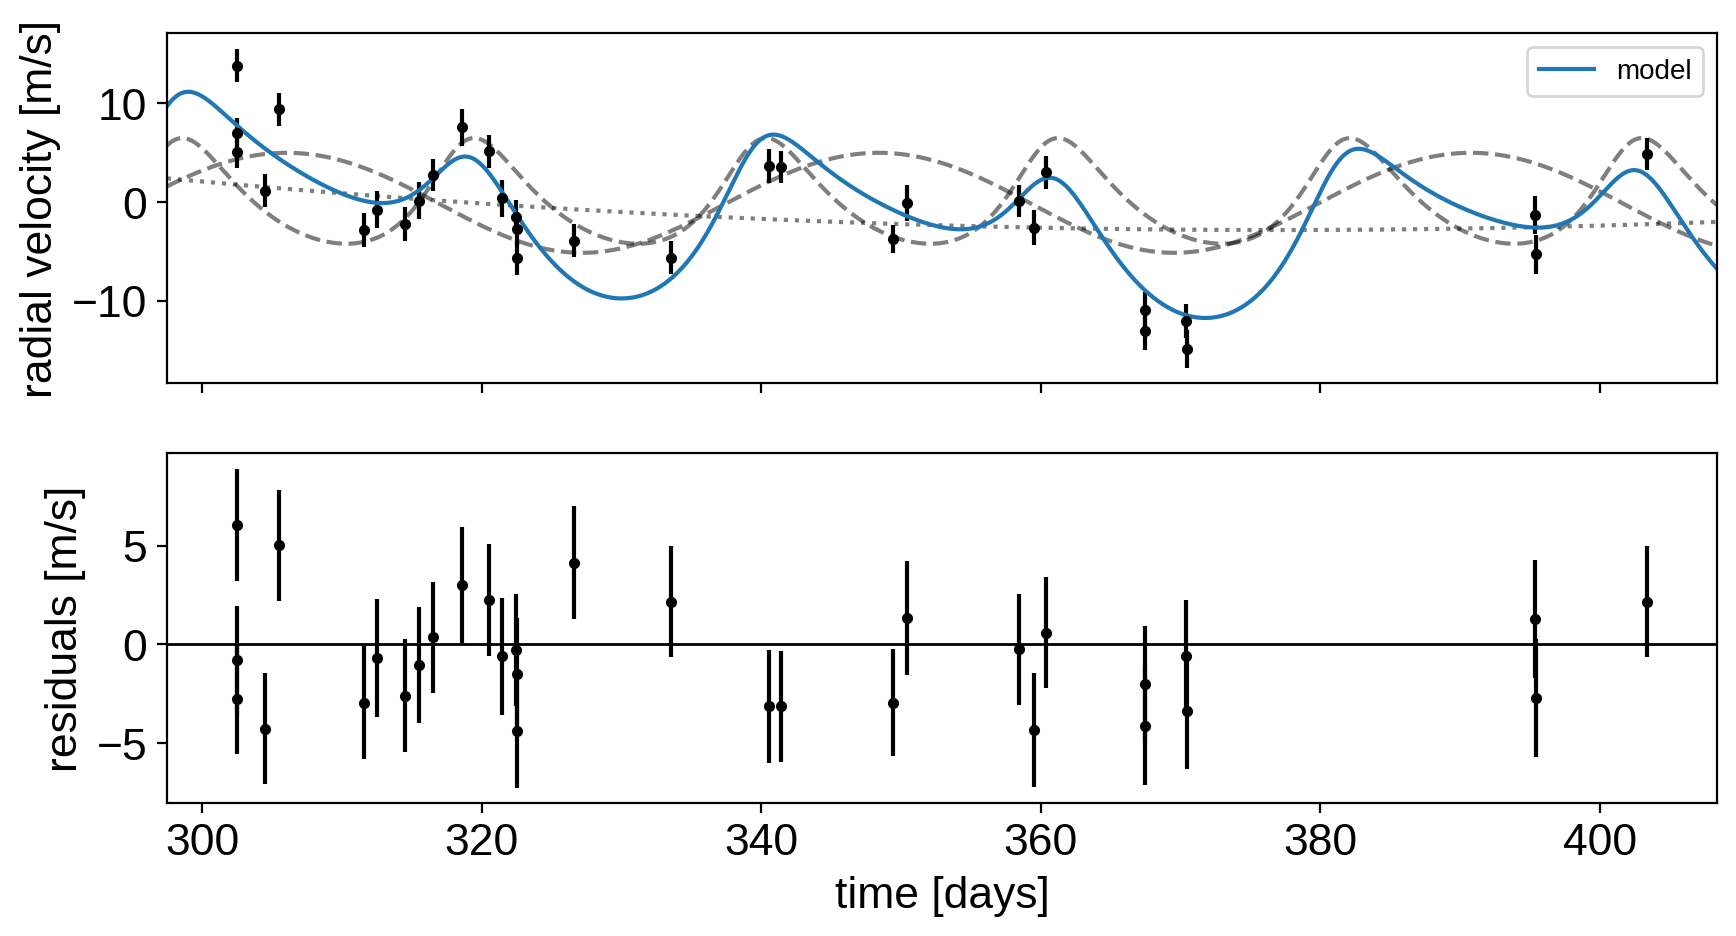

In [10]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")

    ax = axes[1]
    err = np.sqrt(yerr_rv ** 2 + np.exp(2 * soln["logs_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    ax.set_xlabel("time [days]")


plot_rv_curve(map_soln0)

That looks pretty similar to what we got in :ref:`rv`.
Now let's also plot the transit model.

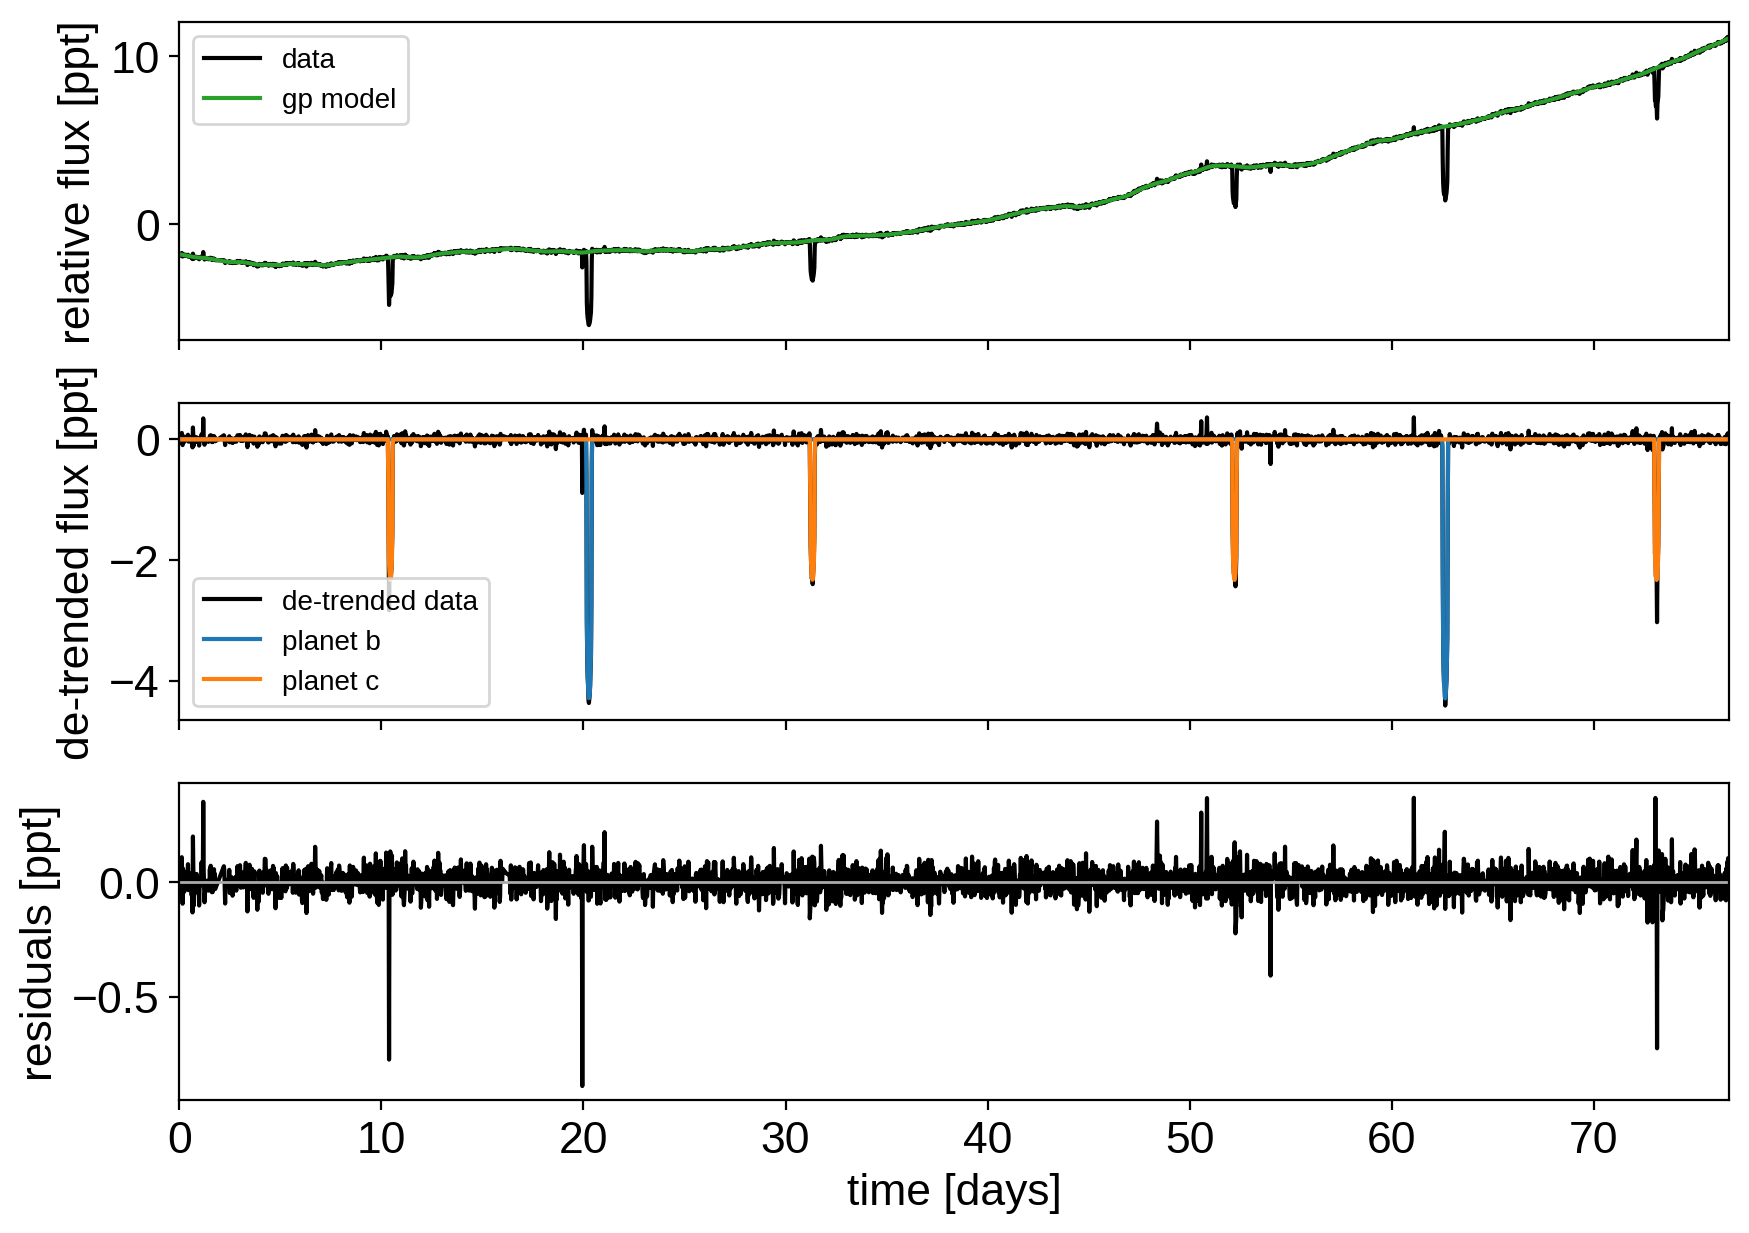

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("bc"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    return fig


plot_light_curve(map_soln0);

There are still a few outliers in the light curve and it can be useful to remove those before doing the full fit because both the GP and transit parameters can be sensitive to this.

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the GP + transit model and remove anything that is more than a 7-sigma outlier.

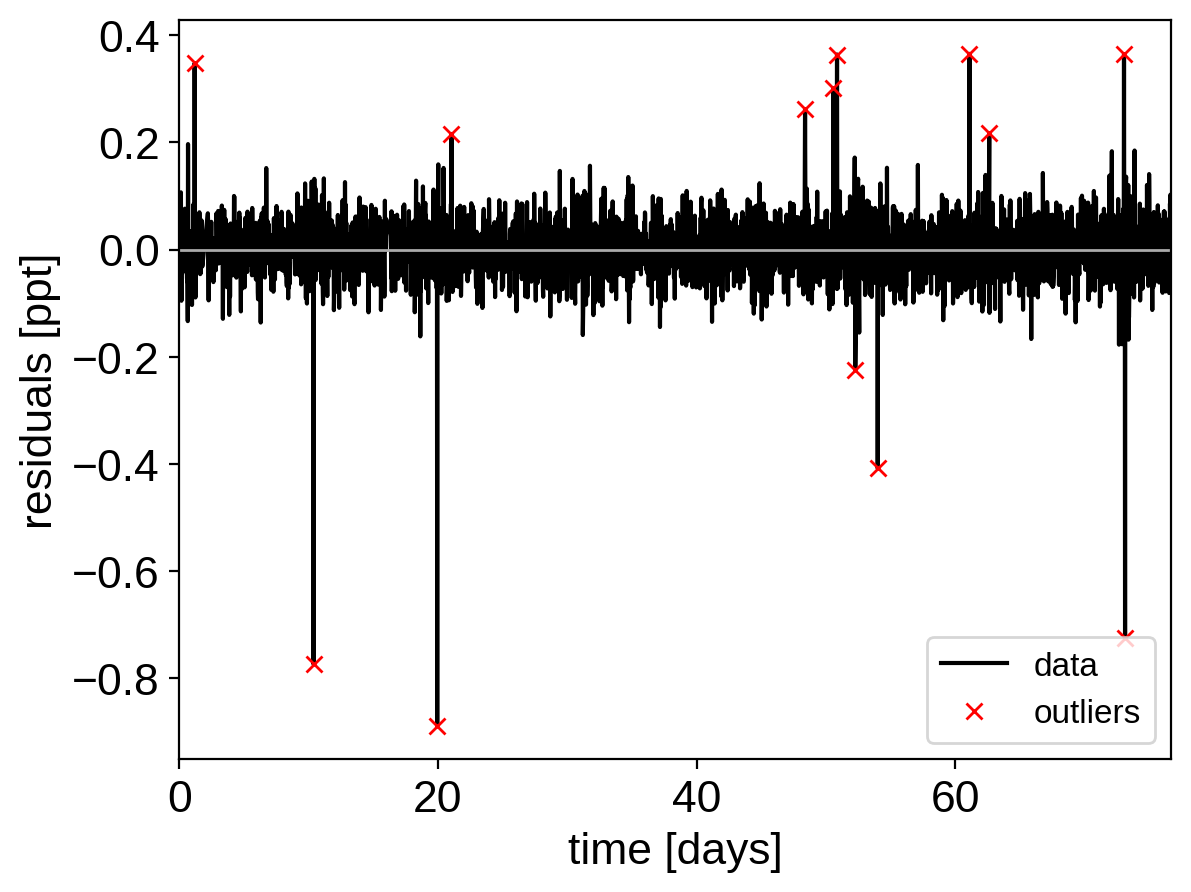

In [12]:
mod = (
    map_soln0["gp_pred"]
    + map_soln0["mean"]
    + np.sum(map_soln0["light_curves"], axis=-1)
)
resid = y - mod
rms = np.sqrt(np.median(resid ** 2))
mask = np.abs(resid) < 7 * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
plt.xlim(x.min(), x.max());

That looks better. Let's re-build our model with this sigma-clipped dataset.

optimizing logp for variables: [trend]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.187170e+03]

1it [00:00, 123.60it/s, logp=5.187170e+03]

2it [00:00, 170.66it/s, logp=5.187170e+03]

3it [00:00, 198.81it/s, logp=5.184582e+03]

4it [00:00, 218.16it/s, logp=5.187170e+03]

5it [00:01,  2.86it/s, logp=5.187170e+03] 


message: Optimization terminated successfully.
logp: 5187.169972104779 -> 5187.169972104779


optimizing logp for variables: [logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.187170e+03]

1it [00:00, 161.91it/s, logp=5.187170e+03]

2it [00:00, 224.06it/s, logp=5.187170e+03]

3it [00:00, 261.32it/s, logp=4.799455e+03]

4it [00:00, 285.67it/s, logp=5.268757e+03]

5it [00:00, 300.56it/s, logp=5.269243e+03]

6it [00:00, 313.35it/s, logp=5.269258e+03]

7it [00:00, 322.31it/s, logp=5.269258e+03]

8it [00:00, 329.07it/s, logp=5.269258e+03]

9it [00:01,  4.93it/s, logp=5.269258e+03] 


message: Optimization terminated successfully.
logp: 5187.169972104779 -> 5269.258081228617


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.269258e+03]

1it [00:00, 179.30it/s, logp=5.269258e+03]

2it [00:00, 246.37it/s, logp=5.269258e+03]

3it [00:00, 279.01it/s, logp=-5.785905e+04]

4it [00:00, 302.47it/s, logp=5.272880e+03] 

5it [00:00, 315.78it/s, logp=5.209373e+03]

6it [00:00, 327.80it/s, logp=5.273077e+03]

7it [00:00, 334.80it/s, logp=5.273269e+03]

8it [00:00, 340.62it/s, logp=5.273558e+03]

9it [00:00, 344.87it/s, logp=5.274168e+03]

10it [00:00, 350.18it/s, logp=5.274984e+03]

11it [00:00, 354.83it/s, logp=5.275160e+03]

12it [00:00, 357.51it/s, logp=5.277683e+03]

13it [00:00, 359.71it/s, logp=4.929549e+03]

14it [00:00, 362.65it/s, logp=5.277864e+03]

15it [00:00, 364.12it/s, logp=5.278214e+03]

16it [00:00, 366.47it/s, logp=5.279301e+03]

17it [00:00, 366.98it/s, logp=5.280050e+03]

18it [00:00, 365.89it/s, logp=5.280094e+03]

19it [00:00, 366.99it/s, logp=5.280172e+03]

20it [00:00, 367.89it/s, logp=5.280126e+03]

21it [00:00, 369.79it/s, logp=5.280224e+03]

22it [00:00, 370.74it/s, logp=5.280223e+03]

23it [00:00, 372.40it/s, logp=5.280229e+03]

24it [00:00, 373.23it/s, logp=5.280231e+03]

25it [00:00, 373.99it/s, logp=5.280231e+03]

26it [00:00, 374.56it/s, logp=5.280231e+03]

27it [00:00, 375.43it/s, logp=5.280231e+03]

28it [00:00, 376.18it/s, logp=5.280231e+03]

29it [00:00, 376.80it/s, logp=5.280231e+03]

30it [00:00, 377.49it/s, logp=5.280231e+03]

31it [00:00, 377.81it/s, logp=5.280231e+03]

32it [00:00, 378.32it/s, logp=5.280231e+03]

33it [00:00, 378.77it/s, logp=5.280231e+03]

34it [00:01, 18.97it/s, logp=5.280231e+03] 


message: Optimization terminated successfully.
logp: 5269.258081228617 -> 5280.231230124337


optimizing logp for variables: [t0, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.280231e+03]

1it [00:00, 172.12it/s, logp=5.280231e+03]

2it [00:00, 238.60it/s, logp=5.280231e+03]

3it [00:00, 267.10it/s, logp=-9.216501e+04]

4it [00:00, 289.02it/s, logp=-7.964204e+04]

5it [00:00, 305.78it/s, logp=-3.809930e+04]

6it [00:00, 318.62it/s, logp=5.227414e+03] 

7it [00:00, 328.36it/s, logp=5.280689e+03]

8it [00:00, 334.03it/s, logp=5.113912e+03]

9it [00:00, 340.79it/s, logp=5.280690e+03]

10it [00:00, 344.80it/s, logp=5.280692e+03]

11it [00:00, 349.46it/s, logp=5.280701e+03]

12it [00:00, 353.51it/s, logp=5.280736e+03]

13it [00:00, 356.45it/s, logp=5.280868e+03]

14it [00:00, 357.17it/s, logp=5.280610e+03]

15it [00:00, 358.87it/s, logp=5.280920e+03]

16it [00:00, 359.15it/s, logp=5.281020e+03]

17it [00:00, 360.94it/s, logp=5.281339e+03]

18it [00:00, 362.40it/s, logp=5.281600e+03]

19it [00:00, 363.24it/s, logp=5.281602e+03]

20it [00:00, 364.81it/s, logp=5.281602e+03]

21it [00:00, 364.87it/s, logp=5.281602e+03]

22it [00:00, 365.94it/s, logp=5.281602e+03]

23it [00:00, 367.62it/s, logp=5.281602e+03]

24it [00:00, 369.00it/s, logp=5.281602e+03]

25it [00:00, 370.28it/s, logp=5.281602e+03]

26it [00:00, 371.33it/s, logp=5.281602e+03]

27it [00:00, 372.53it/s, logp=5.281602e+03]

28it [00:00, 373.42it/s, logp=5.281602e+03]

29it [00:00, 374.43it/s, logp=5.281602e+03]

30it [00:00, 375.44it/s, logp=5.281602e+03]

31it [00:00, 376.29it/s, logp=5.281602e+03]

32it [00:00, 377.12it/s, logp=5.281602e+03]

33it [00:00, 377.95it/s, logp=5.281602e+03]

34it [00:00, 378.75it/s, logp=5.281602e+03]

35it [00:00, 379.37it/s, logp=5.281602e+03]

36it [00:00, 380.01it/s, logp=5.281602e+03]

37it [00:00, 380.63it/s, logp=5.281602e+03]

38it [00:00, 381.30it/s, logp=5.281602e+03]

39it [00:00, 389.23it/s, logp=5.281602e+03]

39it [00:00, 389.23it/s, logp=5.281602e+03]

40it [00:00, 389.23it/s, logp=5.281602e+03]

41it [00:00, 389.23it/s, logp=5.281602e+03]

42it [00:00, 389.23it/s, logp=5.281602e+03]

43it [00:00, 389.23it/s, logp=5.281602e+03]

44it [00:00, 389.23it/s, logp=5.281602e+03]

45it [00:00, 389.23it/s, logp=5.281602e+03]

46it [00:00, 389.23it/s, logp=5.281602e+03]

47it [00:00, 389.23it/s, logp=5.281602e+03]

48it [00:00, 389.23it/s, logp=5.281602e+03]

49it [00:00, 389.23it/s, logp=5.281602e+03]

50it [00:00, 389.23it/s, logp=5.281602e+03]

51it [00:00, 389.23it/s, logp=5.281602e+03]

52it [00:00, 389.23it/s, logp=5.281602e+03]

53it [00:00, 389.23it/s, logp=5.281602e+03]

54it [00:00, 389.23it/s, logp=5.281602e+03]

55it [00:00, 389.23it/s, logp=5.281602e+03]

56it [00:00, 389.23it/s, logp=5.281602e+03]

57it [00:00, 389.23it/s, logp=5.281602e+03]

58it [00:00, 389.23it/s, logp=5.281602e+03]

59it [00:00, 389.23it/s, logp=5.281602e+03]

60it [00:00, 389.23it/s, logp=5.281602e+03]

61it [00:00, 389.23it/s, logp=5.281602e+03]

62it [00:00, 389.23it/s, logp=5.281602e+03]

63it [00:00, 389.23it/s, logp=5.281602e+03]

64it [00:00, 389.23it/s, logp=5.281602e+03]

65it [00:00, 389.23it/s, logp=5.281602e+03]

66it [00:00, 389.23it/s, logp=5.281602e+03]

67it [00:00, 389.23it/s, logp=5.281602e+03]

68it [00:00, 389.23it/s, logp=5.281602e+03]

69it [00:00, 389.23it/s, logp=5.281602e+03]

70it [00:00, 389.23it/s, logp=5.281602e+03]

71it [00:00, 389.23it/s, logp=5.281602e+03]

72it [00:00, 389.23it/s, logp=5.281602e+03]

73it [00:00, 389.23it/s, logp=5.281602e+03]

74it [00:00, 389.23it/s, logp=5.281602e+03]

75it [00:00, 389.23it/s, logp=5.281602e+03]

76it [00:00, 389.23it/s, logp=5.281602e+03]

77it [00:01, 44.56it/s, logp=5.281602e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 5280.231230124337 -> 5281.601991110998


optimizing logp for variables: [logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.281602e+03]

1it [00:00, 85.04it/s, logp=5.281602e+03]

2it [00:00, 113.68it/s, logp=5.281602e+03]

3it [00:00, 130.90it/s, logp=4.587147e+03]

4it [00:00, 145.50it/s, logp=5.281683e+03]

5it [00:00, 157.59it/s, logp=5.281837e+03]

6it [00:00, 167.06it/s, logp=5.282099e+03]

7it [00:00, 178.01it/s, logp=5.282332e+03]

8it [00:00, 187.16it/s, logp=5.282332e+03]

9it [00:00, 196.12it/s, logp=5.282332e+03]

10it [00:02,  4.96it/s, logp=5.282332e+03]


message: Optimization terminated successfully.
logp: 5281.601991111005 -> 5282.331526068319


optimizing logp for variables: [logw0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.282332e+03]

1it [00:00, 149.52it/s, logp=5.282332e+03]

2it [00:00, 201.68it/s, logp=5.282332e+03]

3it [00:00, 229.18it/s, logp=5.247376e+03]

4it [00:00, 247.67it/s, logp=5.282218e+03]

5it [00:00, 260.52it/s, logp=5.282366e+03]

6it [00:00, 270.39it/s, logp=5.282366e+03]

7it [00:00, 278.09it/s, logp=5.282366e+03]

8it [00:00, 284.78it/s, logp=5.282366e+03]

9it [00:01,  5.85it/s, logp=5.282366e+03] 


message: Optimization terminated successfully.
logp: 5282.331526068319 -> 5282.365625613341


optimizing logp for variables: [logSw4, logw0, logs2, trend, logs_rv, ecc_prior_frac, ecc_prior_sigma_rayleigh, ecc_prior_sigma_gauss, ecs, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.282366e+03]

1it [00:00, 74.62it/s, logp=5.282366e+03]

2it [00:00, 108.06it/s, logp=5.282366e+03]

3it [00:00, 128.17it/s, logp=-1.189649e+05]

4it [00:00, 145.86it/s, logp=2.133685e+03] 

5it [00:00, 158.98it/s, logp=5.282366e+03]

6it [00:00, 168.08it/s, logp=5.282343e+03]

7it [00:00, 177.78it/s, logp=5.282366e+03]

8it [00:00, 183.26it/s, logp=5.282366e+03]

9it [00:00, 190.74it/s, logp=5.282366e+03]

10it [00:00, 197.11it/s, logp=5.282366e+03]

11it [00:00, 196.28it/s, logp=5.282366e+03]

12it [00:00, 199.65it/s, logp=5.282366e+03]

13it [00:00, 204.31it/s, logp=5.282367e+03]

14it [00:00, 208.59it/s, logp=5.282370e+03]

15it [00:00, 210.60it/s, logp=5.282364e+03]

16it [00:00, 214.33it/s, logp=5.282371e+03]

17it [00:00, 215.44it/s, logp=5.282373e+03]

18it [00:00, 217.33it/s, logp=5.282367e+03]

19it [00:00, 220.41it/s, logp=5.282373e+03]

20it [00:00, 221.84it/s, logp=5.282374e+03]

21it [00:00, 224.23it/s, logp=5.282376e+03]

22it [00:00, 225.78it/s, logp=5.282381e+03]

23it [00:00, 226.62it/s, logp=5.282391e+03]

24it [00:00, 235.24it/s, logp=5.282391e+03]

24it [00:00, 235.24it/s, logp=5.282428e+03]

25it [00:00, 235.24it/s, logp=5.282488e+03]

26it [00:00, 235.24it/s, logp=5.282605e+03]

27it [00:00, 235.24it/s, logp=5.282985e+03]

28it [00:00, 235.24it/s, logp=5.270852e+03]

29it [00:00, 235.24it/s, logp=5.283004e+03]

30it [00:00, 235.24it/s, logp=5.283038e+03]

31it [00:00, 235.24it/s, logp=5.283091e+03]

32it [00:00, 235.24it/s, logp=5.283169e+03]

33it [00:00, 235.24it/s, logp=5.283311e+03]

34it [00:00, 235.24it/s, logp=5.283468e+03]

35it [00:00, 235.24it/s, logp=5.283449e+03]

36it [00:00, 235.24it/s, logp=5.283553e+03]

37it [00:00, 235.24it/s, logp=5.283599e+03]

38it [00:00, 235.24it/s, logp=5.283658e+03]

39it [00:00, 235.24it/s, logp=5.283758e+03]

40it [00:00, 235.24it/s, logp=5.283800e+03]

41it [00:00, 235.24it/s, logp=5.283828e+03]

42it [00:00, 235.24it/s, logp=5.283860e+03]

43it [00:00, 235.24it/s, logp=5.283915e+03]

44it [00:00, 235.24it/s, logp=5.283778e+03]

45it [00:00, 235.24it/s, logp=5.283928e+03]

46it [00:00, 235.24it/s, logp=5.283950e+03]

47it [00:00, 235.24it/s, logp=5.283967e+03]

48it [00:00, 235.24it/s, logp=5.283974e+03]

49it [00:00, 235.24it/s, logp=5.283984e+03]

50it [00:00, 241.33it/s, logp=5.283984e+03]

50it [00:00, 241.33it/s, logp=5.283990e+03]

51it [00:00, 241.33it/s, logp=5.283992e+03]

52it [00:00, 241.33it/s, logp=5.283996e+03]

53it [00:00, 241.33it/s, logp=5.284012e+03]

54it [00:00, 241.33it/s, logp=5.284023e+03]

55it [00:00, 241.33it/s, logp=5.284044e+03]

56it [00:00, 241.33it/s, logp=5.284085e+03]

57it [00:00, 241.33it/s, logp=5.284092e+03]

58it [00:00, 241.33it/s, logp=5.284129e+03]

59it [00:00, 241.33it/s, logp=5.283942e+03]

60it [00:00, 241.33it/s, logp=5.284172e+03]

61it [00:00, 241.33it/s, logp=5.284176e+03]

62it [00:00, 241.33it/s, logp=5.284196e+03]

63it [00:00, 241.33it/s, logp=5.284231e+03]

64it [00:00, 241.33it/s, logp=5.284215e+03]

65it [00:00, 241.33it/s, logp=5.284244e+03]

66it [00:00, 241.33it/s, logp=5.284257e+03]

67it [00:00, 241.33it/s, logp=5.284260e+03]

68it [00:00, 241.33it/s, logp=5.284266e+03]

69it [00:00, 241.33it/s, logp=5.284275e+03]

70it [00:00, 241.33it/s, logp=5.284281e+03]

71it [00:00, 241.33it/s, logp=5.284284e+03]

72it [00:00, 241.33it/s, logp=5.284287e+03]

73it [00:00, 241.33it/s, logp=5.284288e+03]

74it [00:00, 241.33it/s, logp=5.284289e+03]

75it [00:00, 241.33it/s, logp=5.284289e+03]

76it [00:00, 241.33it/s, logp=5.284289e+03]

77it [00:00, 247.82it/s, logp=5.284289e+03]

77it [00:00, 247.82it/s, logp=5.284290e+03]

78it [00:00, 247.82it/s, logp=5.284290e+03]

79it [00:00, 247.82it/s, logp=5.284290e+03]

80it [00:00, 247.82it/s, logp=5.284290e+03]

81it [00:00, 247.82it/s, logp=5.284290e+03]

82it [00:00, 247.82it/s, logp=5.284290e+03]

83it [00:00, 247.82it/s, logp=5.284290e+03]

84it [00:00, 247.82it/s, logp=5.284290e+03]

85it [00:00, 247.82it/s, logp=5.284290e+03]

86it [00:00, 247.82it/s, logp=5.284290e+03]

87it [00:00, 247.82it/s, logp=5.284290e+03]

88it [00:00, 247.82it/s, logp=5.284290e+03]

89it [00:00, 247.82it/s, logp=5.284290e+03]

90it [00:00, 247.82it/s, logp=5.284290e+03]

91it [00:00, 247.82it/s, logp=5.284290e+03]

92it [00:00, 247.82it/s, logp=5.284290e+03]

93it [00:00, 247.82it/s, logp=5.284290e+03]

94it [00:00, 247.82it/s, logp=5.284290e+03]

95it [00:00, 247.82it/s, logp=5.284290e+03]

96it [00:00, 247.82it/s, logp=5.284290e+03]

97it [00:00, 247.82it/s, logp=5.284290e+03]

98it [00:00, 247.82it/s, logp=5.284290e+03]

99it [00:00, 247.82it/s, logp=5.284290e+03]

100it [00:00, 247.82it/s, logp=5.284290e+03]

101it [00:00, 247.82it/s, logp=5.284290e+03]

102it [00:00, 247.82it/s, logp=5.284290e+03]

103it [00:00, 247.82it/s, logp=5.284290e+03]

104it [00:00, 253.89it/s, logp=5.284290e+03]

104it [00:00, 253.89it/s, logp=5.284290e+03]

105it [00:00, 253.89it/s, logp=5.284290e+03]

106it [00:00, 253.89it/s, logp=5.284290e+03]

107it [00:00, 253.89it/s, logp=5.284290e+03]

108it [00:00, 253.89it/s, logp=5.284290e+03]

109it [00:00, 253.89it/s, logp=5.284290e+03]

110it [00:00, 253.89it/s, logp=5.284290e+03]

111it [00:00, 253.89it/s, logp=5.284290e+03]

112it [00:00, 253.89it/s, logp=5.284290e+03]

113it [00:00, 253.89it/s, logp=5.284290e+03]

114it [00:00, 253.89it/s, logp=5.284290e+03]

115it [00:00, 253.89it/s, logp=5.284290e+03]

116it [00:00, 253.89it/s, logp=5.284290e+03]

117it [00:00, 253.89it/s, logp=5.284290e+03]

118it [00:00, 253.89it/s, logp=5.284290e+03]

119it [00:00, 253.89it/s, logp=5.284290e+03]

120it [00:00, 253.89it/s, logp=5.284290e+03]

121it [00:00, 253.89it/s, logp=5.284290e+03]

122it [00:00, 253.89it/s, logp=5.284290e+03]

123it [00:00, 253.89it/s, logp=5.284290e+03]

124it [00:00, 253.89it/s, logp=5.284290e+03]

125it [00:00, 253.89it/s, logp=5.284290e+03]

126it [00:00, 253.89it/s, logp=5.284290e+03]

127it [00:00, 253.89it/s, logp=5.284290e+03]

128it [00:00, 253.89it/s, logp=5.284290e+03]

129it [00:00, 253.89it/s, logp=5.284290e+03]

130it [00:00, 253.89it/s, logp=5.284290e+03]

131it [00:00, 253.89it/s, logp=5.284290e+03]

132it [00:00, 260.62it/s, logp=5.284290e+03]

132it [00:00, 260.62it/s, logp=5.284290e+03]

133it [00:00, 260.62it/s, logp=5.284290e+03]

134it [00:00, 260.62it/s, logp=5.284290e+03]

135it [00:00, 260.62it/s, logp=5.284290e+03]

136it [00:00, 260.62it/s, logp=5.284290e+03]

137it [00:00, 260.62it/s, logp=5.284290e+03]

138it [00:00, 260.62it/s, logp=5.284290e+03]

139it [00:00, 260.62it/s, logp=5.284290e+03]

140it [00:00, 260.62it/s, logp=5.284290e+03]

141it [00:00, 260.62it/s, logp=5.284290e+03]

142it [00:00, 260.62it/s, logp=5.284290e+03]

143it [00:00, 260.62it/s, logp=5.284290e+03]

144it [00:00, 260.62it/s, logp=5.284290e+03]

145it [00:00, 260.62it/s, logp=5.284290e+03]

146it [00:00, 260.62it/s, logp=5.284290e+03]

147it [00:00, 260.62it/s, logp=5.284290e+03]

148it [00:00, 260.62it/s, logp=5.284290e+03]

149it [00:00, 260.62it/s, logp=5.284290e+03]

150it [00:00, 260.62it/s, logp=5.284290e+03]

151it [00:00, 260.62it/s, logp=5.284290e+03]

152it [00:00, 260.62it/s, logp=5.284290e+03]

153it [00:00, 260.62it/s, logp=5.284290e+03]

154it [00:00, 260.62it/s, logp=5.284290e+03]

155it [00:02, 65.45it/s, logp=5.284290e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 5282.365625613334 -> 5284.289992339934


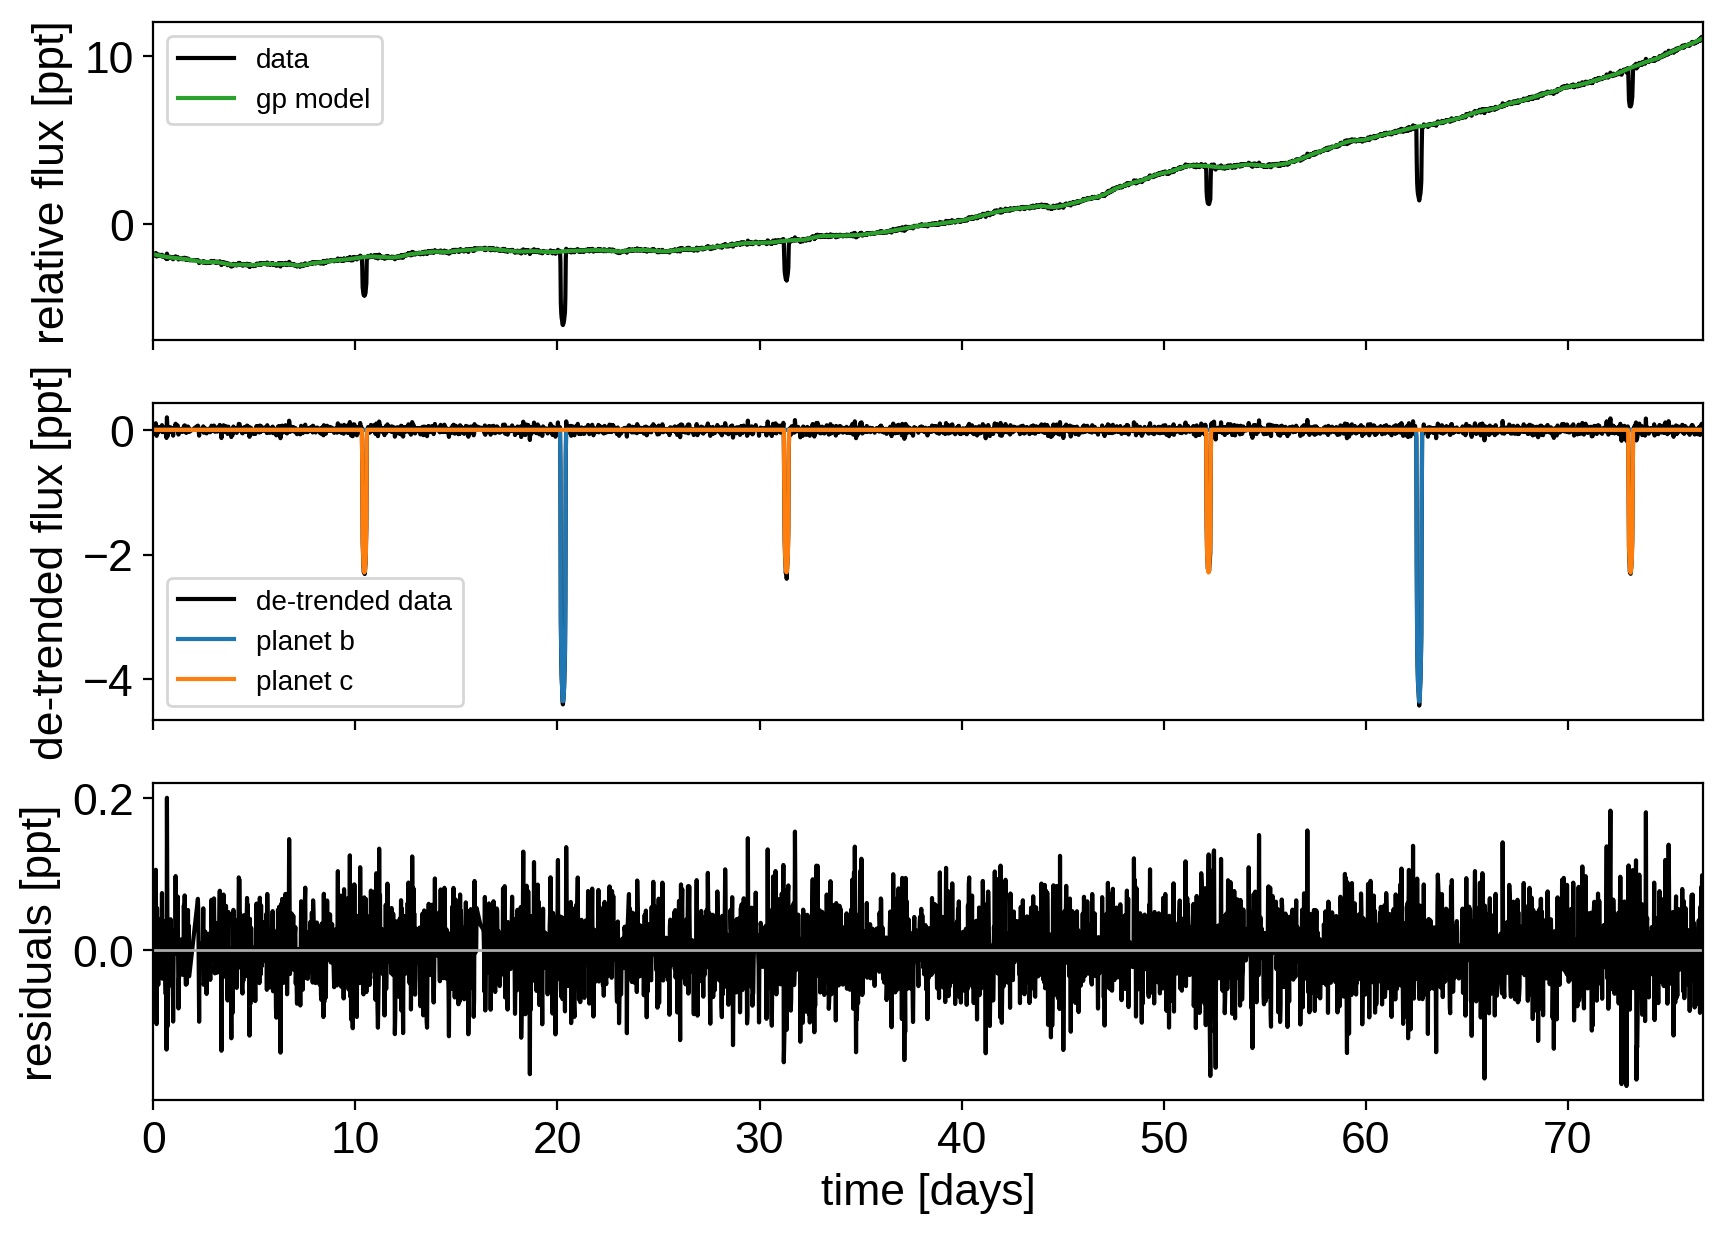

In [13]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Great! Now we're ready to sample.

## Sampling

The sampling for this model is the same as for all the previous tutorials, but it takes a bit longer (about 2 hours on my laptop).
This is partly because the model is more expensive to compute than the previous ones and partly because there are some non-affine degeneracies in the problem (for example between impact parameter and eccentricity).
It might be worth thinking about reparameterizations (in terms of duration instead of eccentricity), but that's beyond the scope of this tutorial.
Besides, using more traditional MCMC methods, this would have taken a lot more than 2 hours to get >1000 effective samples!

In [14]:
np.random.seed(203771098)
with model:
    trace = xo.sample(
        tune=3500,
        draws=3000,
        start=map_soln,
        chains=4,
        initial_accept=0.8,
        target_accept=0.95,
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logSw4, logw0, logs2, trend, logs_rv, ecc_prior_frac, ecc_prior_sigma_rayleigh, ecc_prior_sigma_gauss, ecs, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]


Sampling 4 chains, 0 divergences:   0%|          | 0/26000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 19/26000 [00:00<02:20, 185.15draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 25/26000 [00:01<29:17, 14.78draws/s] 

Sampling 4 chains, 0 divergences:   0%|          | 30/26000 [00:02<37:36, 11.51draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 34/26000 [00:02<47:19,  9.14draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 37/26000 [00:03<58:49,  7.36draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 42/26000 [00:03<57:52,  7.48draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 45/26000 [00:04<44:54,  9.63draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 47/26000 [00:04<1:09:36,  6.21draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 50/26000 [00:05<1:15:07,  5.76draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 52/26000 [00:05<59:06,  7.32draws/s]  

Sampling 4 chains, 0 divergences:   0%|          | 55/26000 [00:05<57:09,  7.57draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 57/26000 [00:05<58:21,  7.41draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 59/26000 [00:06<1:04:22,  6.72draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 60/26000 [00:06<1:06:57,  6.46draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 61/26000 [00:06<1:02:11,  6.95draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 63/26000 [00:06<1:07:09,  6.44draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 64/26000 [00:07<1:07:19,  6.42draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 65/26000 [00:07<1:04:51,  6.66draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 67/26000 [00:07<1:08:34,  6.30draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 68/26000 [00:07<1:05:48,  6.57draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 69/26000 [00:07<1:05:15,  6.62draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 72/26000 [00:08<1:01:18,  7.05draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 73/26000 [00:08<58:37,  7.37draws/s]  

Sampling 4 chains, 0 divergences:   0%|          | 74/26000 [00:08<1:03:09,  6.84draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 76/26000 [00:08<1:07:54,  6.36draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 78/26000 [00:09<1:05:55,  6.55draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 80/26000 [00:09<1:10:16,  6.15draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 82/26000 [00:09<1:06:43,  6.47draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 84/26000 [00:10<1:11:00,  6.08draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 86/26000 [00:10<1:07:32,  6.39draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 89/26000 [00:10<1:04:05,  6.74draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 91/26000 [00:11<1:02:01,  6.96draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 93/26000 [00:11<1:08:08,  6.34draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 95/26000 [00:11<1:04:51,  6.66draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 97/26000 [00:12<1:10:36,  6.11draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 100/26000 [00:12<1:00:20,  7.15draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 102/26000 [00:12<1:08:00,  6.35draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 104/26000 [00:13<1:03:28,  6.80draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 106/26000 [00:13<1:10:17,  6.14draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 108/26000 [00:13<1:05:20,  6.60draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 110/26000 [00:14<1:10:21,  6.13draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 112/26000 [00:14<1:06:13,  6.52draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 114/26000 [00:14<1:10:19,  6.13draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 116/26000 [00:15<1:07:09,  6.42draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 118/26000 [00:15<1:10:00,  6.16draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 121/26000 [00:15<1:01:27,  7.02draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 124/26000 [00:16<57:44,  7.47draws/s]  

Sampling 4 chains, 0 divergences:   0%|          | 125/26000 [00:16<55:08,  7.82draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 126/26000 [00:16<1:05:34,  6.58draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 128/26000 [00:16<1:05:45,  6.56draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 129/26000 [00:16<1:03:09,  6.83draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 130/26000 [00:16<1:10:26,  6.12draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 132/26000 [00:17<1:08:15,  6.32draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 134/26000 [00:17<57:38,  7.48draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 135/26000 [00:17<1:06:46,  6.46draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 137/26000 [00:17<1:05:55,  6.54draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 138/26000 [00:18<1:05:49,  6.55draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 139/26000 [00:18<1:11:11,  6.05draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 141/26000 [00:18<1:08:32,  6.29draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 142/26000 [00:18<1:09:17,  6.22draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 143/26000 [00:18<1:12:56,  5.91draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 145/26000 [00:19<1:08:51,  6.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 146/26000 [00:19<1:11:50,  6.00draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 147/26000 [00:19<1:14:34,  5.78draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 149/26000 [00:19<1:08:48,  6.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 150/26000 [00:20<1:14:25,  5.79draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 151/26000 [00:20<1:15:46,  5.69draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 154/26000 [00:20<1:03:30,  6.78draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 155/26000 [00:20<1:13:38,  5.85draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 156/26000 [00:20<1:16:17,  5.65draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 158/26000 [00:21<1:07:07,  6.42draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 159/26000 [00:21<1:18:31,  5.49draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 160/26000 [00:21<1:19:06,  5.44draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 162/26000 [00:21<1:08:19,  6.30draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 163/26000 [00:21<1:21:26,  5.29draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 164/26000 [00:22<1:20:36,  5.34draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 166/26000 [00:22<1:08:29,  6.29draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 167/26000 [00:22<1:23:59,  5.13draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 168/26000 [00:22<1:21:49,  5.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 169/26000 [00:22<1:10:42,  6.09draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 171/26000 [00:23<1:13:06,  5.89draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 173/26000 [00:23<1:02:46,  6.86draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 174/26000 [00:23<57:13,  7.52draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 176/26000 [00:23<1:04:18,  6.69draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 177/26000 [00:24<1:06:20,  6.49draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 178/26000 [00:24<1:00:28,  7.12draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 180/26000 [00:24<1:06:48,  6.44draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 181/26000 [00:24<1:06:48,  6.44draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 182/26000 [00:24<1:02:16,  6.91draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 184/26000 [00:25<1:07:37,  6.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 185/26000 [00:25<1:06:44,  6.45draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 187/26000 [00:25<53:40,  8.01draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 189/26000 [00:25<1:02:48,  6.85draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 190/26000 [00:26<1:04:03,  6.72draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 192/26000 [00:26<52:25,  8.20draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 194/26000 [00:26<1:10:46,  6.08draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 197/26000 [00:26<54:47,  7.85draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 199/26000 [00:27<1:14:00,  5.81draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 202/26000 [00:27<1:11:53,  5.98draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 203/26000 [00:28<1:12:52,  5.90draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 206/26000 [00:28<55:27,  7.75draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 208/26000 [00:28<1:04:47,  6.63draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 210/26000 [00:28<56:22,  7.63draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 213/26000 [00:29<59:54,  7.17draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 215/26000 [00:29<51:46,  8.30draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 217/26000 [00:29<1:08:04,  6.31draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 218/26000 [00:29<1:03:59,  6.71draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 220/26000 [00:30<53:10,  8.08draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 222/26000 [00:30<1:10:03,  6.13draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 224/26000 [00:30<58:20,  7.36draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 226/26000 [00:31<1:12:23,  5.93draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 229/26000 [00:31<57:34,  7.46draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 231/26000 [00:31<1:11:57,  5.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 233/26000 [00:32<1:00:23,  7.11draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 235/26000 [00:32<1:13:58,  5.80draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 237/26000 [00:32<1:01:54,  6.94draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 240/26000 [00:33<1:04:07,  6.70draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 242/26000 [00:33<55:54,  7.68draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 244/26000 [00:33<1:09:23,  6.19draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 247/26000 [00:33<56:19,  7.62draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 249/26000 [00:34<1:09:08,  6.21draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 251/26000 [00:34<1:00:26,  7.10draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 253/26000 [00:35<1:06:53,  6.42draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 255/26000 [00:35<54:02,  7.94draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 257/26000 [00:35<1:12:22,  5.93draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 262/26000 [00:36<1:07:44,  6.33draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 266/26000 [00:36<54:54,  7.81draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 268/26000 [00:36<1:06:31,  6.45draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 270/26000 [00:37<59:46,  7.17draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 271/26000 [00:37<55:35,  7.71draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 272/26000 [00:37<1:19:38,  5.38draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 274/26000 [00:37<1:10:12,  6.11draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 276/26000 [00:37<57:16,  7.49draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 278/26000 [00:38<57:31,  7.45draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 279/26000 [00:38<1:00:50,  7.05draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 281/26000 [00:38<55:26,  7.73draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 283/26000 [00:38<57:07,  7.50draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 284/26000 [00:39<1:02:43,  6.83draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 285/26000 [00:39<1:07:15,  6.37draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 287/26000 [00:39<1:05:45,  6.52draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 289/26000 [00:39<56:56,  7.52draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 290/26000 [00:39<1:01:34,  6.96draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 292/26000 [00:40<1:08:50,  6.22draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 294/26000 [00:40<55:19,  7.74draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 296/26000 [00:40<50:11,  8.54draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 298/26000 [00:40<58:10,  7.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 299/26000 [00:41<54:17,  7.89draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 300/26000 [00:41<1:01:37,  6.95draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 301/26000 [00:41<1:02:57,  6.80draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 302/26000 [00:41<1:10:13,  6.10draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 304/26000 [00:41<1:02:47,  6.82draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 306/26000 [00:41<51:27,  8.32draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 308/26000 [00:42<1:02:15,  6.88draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 309/26000 [00:42<59:08,  7.24draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 310/26000 [00:42<56:40,  7.56draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 313/26000 [00:42<45:56,  9.32draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 315/26000 [00:43<1:04:24,  6.65draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 317/26000 [00:43<51:39,  8.29draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 319/26000 [00:43<54:45,  7.82draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 321/26000 [00:43<1:01:09,  7.00draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 323/26000 [00:44<1:01:06,  7.00draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 324/26000 [00:44<1:20:40,  5.30draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 327/26000 [00:44<1:01:17,  6.98draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 329/26000 [00:44<57:45,  7.41draws/s]  

Sampling 4 chains, 0 divergences:   1%|▏         | 331/26000 [00:45<1:01:03,  7.01draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 333/26000 [00:45<49:42,  8.60draws/s]  

Sampling 4 chains, 0 divergences:   1%|▏         | 335/26000 [00:45<1:08:50,  6.21draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 337/26000 [00:45<55:46,  7.67draws/s]  

Sampling 4 chains, 0 divergences:   1%|▏         | 339/26000 [00:46<1:10:52,  6.03draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 342/26000 [00:46<55:09,  7.75draws/s]  

Sampling 4 chains, 0 divergences:   1%|▏         | 344/26000 [00:47<1:10:53,  6.03draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 346/26000 [00:47<58:41,  7.29draws/s]  

Sampling 4 chains, 0 divergences:   1%|▏         | 348/26000 [00:47<59:03,  7.24draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 350/26000 [00:47<59:43,  7.16draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 352/26000 [00:48<1:04:48,  6.60draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 353/26000 [00:48<1:10:33,  6.06draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 355/26000 [00:48<1:00:09,  7.11draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 356/26000 [00:48<1:18:41,  5.43draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 357/26000 [00:48<1:17:42,  5.50draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 360/26000 [00:49<59:42,  7.16draws/s]  

Sampling 4 chains, 0 divergences:   1%|▏         | 363/26000 [00:49<1:07:55,  6.29draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 367/26000 [00:49<50:59,  8.38draws/s]  

Sampling 4 chains, 0 divergences:   1%|▏         | 369/26000 [00:50<49:17,  8.67draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 371/26000 [00:50<51:09,  8.35draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 373/26000 [00:50<49:31,  8.62draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 375/26000 [00:50<1:02:07,  6.87draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 376/26000 [00:51<1:07:21,  6.34draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 379/26000 [00:51<51:47,  8.24draws/s]  

Sampling 4 chains, 0 divergences:   1%|▏         | 381/26000 [00:51<1:00:31,  7.05draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 383/26000 [00:51<59:01,  7.23draws/s]  

Sampling 4 chains, 0 divergences:   1%|▏         | 385/26000 [00:52<56:01,  7.62draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 388/26000 [00:52<51:48,  8.24draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 389/26000 [00:52<1:16:50,  5.55draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 392/26000 [00:52<58:38,  7.28draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 394/26000 [00:53<1:14:21,  5.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 397/26000 [00:53<57:05,  7.47draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 399/26000 [00:53<47:00,  9.08draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 401/26000 [00:53<41:20, 10.32draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 403/26000 [00:54<56:47,  7.51draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 408/26000 [00:54<44:48,  9.52draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 410/26000 [00:54<1:03:09,  6.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 413/26000 [00:54<49:52,  8.55draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 415/26000 [00:55<1:04:28,  6.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 419/26000 [00:55<50:26,  8.45draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 421/26000 [00:55<48:27,  8.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 423/26000 [00:56<58:11,  7.32draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 425/26000 [00:56<49:26,  8.62draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 427/26000 [00:56<42:27, 10.04draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 429/26000 [00:56<1:03:21,  6.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 431/26000 [00:57<51:42,  8.24draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 433/26000 [00:57<1:02:00,  6.87draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 435/26000 [00:57<52:46,  8.07draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 437/26000 [00:58<1:02:38,  6.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 439/26000 [00:58<53:17,  7.99draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 441/26000 [00:58<1:09:01,  6.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 445/26000 [00:58<53:01,  8.03draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 448/26000 [00:58<42:21, 10.06draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 450/26000 [00:59<43:39,  9.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 452/26000 [00:59<56:49,  7.49draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 455/26000 [00:59<57:35,  7.39draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 457/26000 [01:00<55:47,  7.63draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 459/26000 [01:00<1:03:44,  6.68draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 460/26000 [01:00<1:16:29,  5.56draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 463/26000 [01:01<1:00:46,  7.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 465/26000 [01:01<57:11,  7.44draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 467/26000 [01:01<55:23,  7.68draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 469/26000 [01:01<59:14,  7.18draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 472/26000 [01:02<57:43,  7.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 474/26000 [01:02<56:05,  7.59draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 478/26000 [01:02<45:39,  9.32draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 480/26000 [01:02<39:56, 10.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 482/26000 [01:03<48:55,  8.69draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 484/26000 [01:03<50:38,  8.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 486/26000 [01:03<50:07,  8.48draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 488/26000 [01:03<55:14,  7.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 489/26000 [01:04<58:12,  7.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 491/26000 [01:04<52:37,  8.08draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 493/26000 [01:04<54:45,  7.76draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 494/26000 [01:04<1:01:37,  6.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 497/26000 [01:04<53:06,  8.00draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 499/26000 [01:05<50:23,  8.43draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 500/26000 [01:05<49:32,  8.58draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 501/26000 [01:05<51:15,  8.29draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 502/26000 [01:05<1:00:30,  7.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 505/26000 [01:05<50:34,  8.40draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 507/26000 [01:06<1:03:54,  6.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 509/26000 [01:06<55:54,  7.60draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 510/26000 [01:06<1:15:04,  5.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 511/26000 [01:06<1:15:53,  5.60draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 514/26000 [01:07<59:54,  7.09draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 516/26000 [01:07<1:01:14,  6.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 517/26000 [01:07<1:03:25,  6.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 519/26000 [01:07<51:10,  8.30draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 521/26000 [01:08<1:03:22,  6.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 524/26000 [01:08<48:47,  8.70draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 527/26000 [01:08<44:36,  9.52draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 530/26000 [01:08<38:02, 11.16draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 532/26000 [01:08<45:46,  9.27draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 534/26000 [01:09<45:24,  9.35draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 536/26000 [01:09<40:16, 10.54draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 538/26000 [01:09<1:00:46,  6.98draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 541/26000 [01:09<47:49,  8.87draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 543/26000 [01:09<41:01, 10.34draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 545/26000 [01:10<49:21,  8.60draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 547/26000 [01:10<47:07,  9.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 550/26000 [01:10<38:26, 11.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 552/26000 [01:10<39:25, 10.76draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 554/26000 [01:11<47:53,  8.86draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 556/26000 [01:11<40:29, 10.47draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 559/26000 [01:11<36:54, 11.49draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 561/26000 [01:11<36:45, 11.54draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 563/26000 [01:11<41:37, 10.18draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 565/26000 [01:12<39:09, 10.82draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 567/26000 [01:12<47:13,  8.98draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 569/26000 [01:12<43:04,  9.84draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 571/26000 [01:12<45:07,  9.39draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 573/26000 [01:12<40:44, 10.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 575/26000 [01:13<38:52, 10.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 577/26000 [01:13<37:37, 11.26draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 579/26000 [01:13<38:23, 11.04draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 581/26000 [01:13<45:48,  9.25draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 583/26000 [01:13<47:05,  9.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 586/26000 [01:14<39:44, 10.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 588/26000 [01:14<59:49,  7.08draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 590/26000 [01:14<50:35,  8.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 592/26000 [01:14<50:13,  8.43draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 594/26000 [01:15<47:53,  8.84draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 596/26000 [01:15<48:31,  8.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 599/26000 [01:15<48:39,  8.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 600/26000 [01:15<56:17,  7.52draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 602/26000 [01:16<46:55,  9.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 605/26000 [01:16<37:24, 11.31draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 607/26000 [01:16<50:29,  8.38draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 609/26000 [01:16<44:44,  9.46draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 612/26000 [01:16<36:04, 11.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 615/26000 [01:16<31:39, 13.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 618/26000 [01:17<27:07, 15.60draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 621/26000 [01:17<27:40, 15.28draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 623/26000 [01:17<47:05,  8.98draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 625/26000 [01:17<40:22, 10.48draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 628/26000 [01:18<38:25, 11.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 631/26000 [01:18<32:51, 12.87draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 634/26000 [01:18<28:55, 14.62draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 636/26000 [01:18<28:08, 15.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 639/26000 [01:18<24:37, 17.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 641/26000 [01:18<26:07, 16.18draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 643/26000 [01:18<24:40, 17.13draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 645/26000 [01:18<27:31, 15.35draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 649/26000 [01:19<26:54, 15.70draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 651/26000 [01:19<27:49, 15.18draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 653/26000 [01:19<35:05, 12.04draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 657/26000 [01:19<29:40, 14.23draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 659/26000 [01:19<33:55, 12.45draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 661/26000 [01:20<34:05, 12.39draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 663/26000 [01:20<30:47, 13.71draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 667/26000 [01:20<30:48, 13.71draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 669/26000 [01:20<45:35,  9.26draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 672/26000 [01:21<40:28, 10.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 674/26000 [01:21<42:53,  9.84draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 677/26000 [01:21<36:12, 11.66draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 680/26000 [01:21<30:47, 13.71draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 682/26000 [01:21<33:32, 12.58draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 684/26000 [01:22<36:28, 11.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 686/26000 [01:22<36:53, 11.44draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 688/26000 [01:22<36:03, 11.70draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 690/26000 [01:22<35:31, 11.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 692/26000 [01:22<39:04, 10.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 696/26000 [01:23<35:49, 11.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 698/26000 [01:23<35:13, 11.97draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 700/26000 [01:23<40:01, 10.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 703/26000 [01:23<34:09, 12.34draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 705/26000 [01:23<34:37, 12.18draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 709/26000 [01:23<30:21, 13.88draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 711/26000 [01:24<34:09, 12.34draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 713/26000 [01:24<34:24, 12.25draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 715/26000 [01:24<34:13, 12.31draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 718/26000 [01:24<30:28, 13.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 720/26000 [01:24<31:52, 13.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 722/26000 [01:25<37:08, 11.34draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 725/26000 [01:25<32:41, 12.89draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 727/26000 [01:25<33:31, 12.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 729/26000 [01:25<43:53,  9.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 731/26000 [01:25<39:05, 10.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 733/26000 [01:25<36:46, 11.45draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 737/26000 [01:26<32:09, 13.10draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 740/26000 [01:26<31:14, 13.48draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 742/26000 [01:26<33:28, 12.58draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 745/26000 [01:26<29:12, 14.41draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 747/26000 [01:26<32:14, 13.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 750/26000 [01:27<29:28, 14.28draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 752/26000 [01:27<31:30, 13.35draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 754/26000 [01:27<32:01, 13.14draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 756/26000 [01:27<36:02, 11.68draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 759/26000 [01:27<32:00, 13.15draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 762/26000 [01:27<26:42, 15.75draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 764/26000 [01:27<27:34, 15.25draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 766/26000 [01:28<29:09, 14.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 770/26000 [01:28<31:26, 13.38draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 772/26000 [01:28<32:13, 13.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 774/26000 [01:28<34:02, 12.35draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 777/26000 [01:29<33:13, 12.65draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 780/26000 [01:29<29:05, 14.45draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 783/26000 [01:29<24:50, 16.92draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 785/26000 [01:29<32:41, 12.86draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 787/26000 [01:29<34:34, 12.15draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 790/26000 [01:29<30:54, 13.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 792/26000 [01:30<31:59, 13.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 795/26000 [01:30<36:44, 11.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 797/26000 [01:30<35:12, 11.93draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 801/26000 [01:30<29:03, 14.45draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 803/26000 [01:30<31:41, 13.25draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 805/26000 [01:31<32:09, 13.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 807/26000 [01:31<34:03, 12.33draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 809/26000 [01:31<31:53, 13.16draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 811/26000 [01:31<34:34, 12.14draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 814/26000 [01:31<28:40, 14.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 816/26000 [01:31<27:57, 15.01draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 820/26000 [01:31<22:45, 18.44draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 823/26000 [01:32<25:15, 16.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 826/26000 [01:32<24:33, 17.09draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 829/26000 [01:32<21:39, 19.37draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 832/26000 [01:32<20:45, 20.21draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 835/26000 [01:32<24:41, 16.99draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 837/26000 [01:32<27:25, 15.29draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 839/26000 [01:33<29:20, 14.29draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 841/26000 [01:33<30:44, 13.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 844/26000 [01:33<28:17, 14.82draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 847/26000 [01:33<26:31, 15.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 850/26000 [01:33<24:24, 17.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 854/26000 [01:33<23:30, 17.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 856/26000 [01:34<25:09, 16.66draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 859/26000 [01:34<24:24, 17.16draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 861/26000 [01:34<30:31, 13.73draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 863/26000 [01:34<36:14, 11.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 866/26000 [01:34<31:46, 13.18draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 868/26000 [01:34<33:06, 12.65draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 871/26000 [01:35<29:39, 14.12draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 874/26000 [01:35<25:32, 16.39draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 876/26000 [01:35<26:01, 16.09draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 878/26000 [01:35<48:51,  8.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 881/26000 [01:35<40:46, 10.27draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 883/26000 [01:36<42:20,  9.89draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 885/26000 [01:36<45:56,  9.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 888/26000 [01:36<40:55, 10.23draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 891/26000 [01:36<34:09, 12.25draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 893/26000 [01:36<30:26, 13.75draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 895/26000 [01:37<34:48, 12.02draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 899/26000 [01:37<29:28, 14.19draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 901/26000 [01:37<36:17, 11.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 903/26000 [01:37<38:28, 10.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 905/26000 [01:37<37:00, 11.30draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 909/26000 [01:38<30:57, 13.51draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 913/26000 [01:38<29:14, 14.29draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 917/26000 [01:38<23:42, 17.63draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 920/26000 [01:38<22:06, 18.91draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 923/26000 [01:38<29:15, 14.29draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 925/26000 [01:39<30:37, 13.64draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 927/26000 [01:39<36:21, 11.49draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 929/26000 [01:39<35:32, 11.76draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 932/26000 [01:39<31:34, 13.23draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 934/26000 [01:39<29:41, 14.07draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 937/26000 [01:40<32:10, 12.98draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 939/26000 [01:40<44:23,  9.41draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 941/26000 [01:40<50:48,  8.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 943/26000 [01:40<44:14,  9.44draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 945/26000 [01:41<46:20,  9.01draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 948/26000 [01:41<39:10, 10.66draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 950/26000 [01:41<37:36, 11.10draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 953/26000 [01:41<33:08, 12.60draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 956/26000 [01:41<29:42, 14.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 958/26000 [01:41<34:33, 12.08draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 961/26000 [01:42<30:44, 13.57draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 964/26000 [01:42<31:23, 13.29draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 968/26000 [01:42<27:35, 15.12draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 970/26000 [01:42<27:40, 15.07draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 972/26000 [01:42<29:17, 14.24draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 974/26000 [01:42<27:14, 15.31draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 977/26000 [01:43<23:49, 17.51draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 980/26000 [01:43<23:52, 17.47draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 983/26000 [01:43<22:08, 18.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 986/26000 [01:43<21:33, 19.34draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 989/26000 [01:43<22:23, 18.62draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 992/26000 [01:43<21:41, 19.21draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 994/26000 [01:43<21:58, 18.97draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 997/26000 [01:43<19:36, 21.25draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1000/26000 [01:44<20:34, 20.24draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1003/26000 [01:44<23:03, 18.07draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1006/26000 [01:44<21:04, 19.76draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1009/26000 [01:44<19:26, 21.42draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1012/26000 [01:44<19:56, 20.88draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1016/26000 [01:44<19:01, 21.90draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1020/26000 [01:45<16:32, 25.17draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1023/26000 [01:45<27:23, 15.20draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1026/26000 [01:45<25:54, 16.07draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1029/26000 [01:45<24:53, 16.72draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1032/26000 [01:45<24:07, 17.25draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1034/26000 [01:46<26:49, 15.51draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1038/26000 [01:46<23:49, 17.46draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1041/26000 [01:46<23:19, 17.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1044/26000 [01:46<23:01, 18.06draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1047/26000 [01:46<22:20, 18.61draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1050/26000 [01:46<22:29, 18.49draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1053/26000 [01:46<22:30, 18.47draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1058/26000 [01:47<19:52, 20.91draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1062/26000 [01:47<18:54, 21.99draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1067/26000 [01:47<15:48, 26.28draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1071/26000 [01:47<17:56, 23.15draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1074/26000 [01:47<19:05, 21.75draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1077/26000 [01:47<20:09, 20.61draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1082/26000 [01:48<18:04, 22.98draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1087/26000 [01:48<16:42, 24.85draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1091/26000 [01:48<16:34, 25.04draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1096/26000 [01:48<15:46, 26.30draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1099/26000 [01:48<17:48, 23.30draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1103/26000 [01:48<17:31, 23.68draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1106/26000 [01:49<21:15, 19.52draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1109/26000 [01:49<20:44, 19.99draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1112/26000 [01:49<19:39, 21.10draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1115/26000 [01:49<21:57, 18.88draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1118/26000 [01:49<22:01, 18.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1121/26000 [01:49<21:57, 18.89draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1124/26000 [01:50<20:52, 19.86draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1127/26000 [01:50<22:26, 18.48draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1129/26000 [01:50<23:59, 17.28draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1132/26000 [01:50<24:32, 16.89draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1134/26000 [01:50<25:30, 16.25draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1137/26000 [01:50<25:35, 16.19draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1139/26000 [01:51<25:56, 15.97draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1142/26000 [01:51<26:03, 15.90draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1144/26000 [01:51<26:48, 15.45draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1146/26000 [01:51<27:13, 15.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1149/26000 [01:51<25:31, 16.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1153/26000 [01:51<22:45, 18.19draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1157/26000 [01:51<19:55, 20.78draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1161/26000 [01:52<17:18, 23.91draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1165/26000 [01:52<15:14, 27.16draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1169/26000 [01:52<18:47, 22.02draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1172/26000 [01:52<19:48, 20.89draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1175/26000 [01:52<22:44, 18.19draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1178/26000 [01:52<20:56, 19.75draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1181/26000 [01:53<25:55, 15.96draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1185/26000 [01:53<23:08, 17.87draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1188/26000 [01:53<22:50, 18.10draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1191/26000 [01:53<22:39, 18.25draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1195/26000 [01:53<20:52, 19.80draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1200/26000 [01:53<19:00, 21.75draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1203/26000 [01:54<19:47, 20.88draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1207/26000 [01:54<16:58, 24.35draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1210/26000 [01:54<18:35, 22.22draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1213/26000 [01:54<19:45, 20.91draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1216/26000 [01:54<19:04, 21.66draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1219/26000 [01:54<19:09, 21.56draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1225/26000 [01:54<16:42, 24.72draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1230/26000 [01:55<15:39, 26.38draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1236/26000 [01:55<13:05, 31.53draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1240/26000 [01:55<14:00, 29.47draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1244/26000 [01:55<18:41, 22.07draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1247/26000 [01:55<20:08, 20.47draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1250/26000 [01:56<20:15, 20.36draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1253/26000 [01:56<21:11, 19.46draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1256/26000 [01:56<21:09, 19.48draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1259/26000 [01:56<21:29, 19.19draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1263/26000 [01:56<20:03, 20.56draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1266/26000 [01:56<22:51, 18.03draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1268/26000 [01:57<24:11, 17.04draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1270/26000 [01:57<25:18, 16.29draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1274/26000 [01:57<22:41, 18.17draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1278/26000 [01:57<20:52, 19.74draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1281/26000 [01:57<23:35, 17.46draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1283/26000 [01:57<26:27, 15.57draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1285/26000 [01:57<24:48, 16.60draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1287/26000 [01:58<24:49, 16.59draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1289/26000 [01:58<27:19, 15.07draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1292/26000 [01:58<26:42, 15.42draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1294/26000 [01:58<28:40, 14.36draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1297/26000 [01:58<25:26, 16.19draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1299/26000 [01:58<24:45, 16.63draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1303/26000 [01:58<22:22, 18.40draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1306/26000 [01:59<22:17, 18.46draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1311/26000 [01:59<20:36, 19.97draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1315/26000 [01:59<18:35, 22.13draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1318/26000 [01:59<19:43, 20.86draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1322/26000 [01:59<17:04, 24.08draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1325/26000 [01:59<18:04, 22.75draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1328/26000 [02:00<17:35, 23.36draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1331/26000 [02:00<17:26, 23.58draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1334/26000 [02:00<19:17, 21.30draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1337/26000 [02:00<19:32, 21.04draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1340/26000 [02:00<20:18, 20.24draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1344/26000 [02:00<18:27, 22.27draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1348/26000 [02:00<16:39, 24.65draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1352/26000 [02:01<15:12, 27.01draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1355/26000 [02:01<16:17, 25.21draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1358/26000 [02:01<15:33, 26.40draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1362/26000 [02:01<15:04, 27.25draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1366/26000 [02:01<14:33, 28.20draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1370/26000 [02:01<15:07, 27.13draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1374/26000 [02:01<14:04, 29.15draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1379/26000 [02:01<13:00, 31.54draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1383/26000 [02:02<12:44, 32.22draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1388/26000 [02:02<12:43, 32.25draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1392/26000 [02:02<13:53, 29.51draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1396/26000 [02:02<14:42, 27.88draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1399/26000 [02:02<15:26, 26.55draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1402/26000 [02:02<15:55, 25.74draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1405/26000 [02:02<15:38, 26.22draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1408/26000 [02:03<16:30, 24.83draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1412/26000 [02:03<14:40, 27.94draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1416/26000 [02:03<14:59, 27.33draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1421/26000 [02:03<13:27, 30.42draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1425/26000 [02:03<15:39, 26.15draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1429/26000 [02:03<15:05, 27.15draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1433/26000 [02:03<15:24, 26.59draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1437/26000 [02:04<15:38, 26.19draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1441/26000 [02:04<15:47, 25.93draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1445/26000 [02:04<15:51, 25.80draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1449/26000 [02:04<14:48, 27.64draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1453/26000 [02:04<14:00, 29.20draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1456/26000 [02:04<15:11, 26.94draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1459/26000 [02:04<16:56, 24.14draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1464/26000 [02:04<14:23, 28.41draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1469/26000 [02:05<13:29, 30.29draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1474/26000 [02:05<13:25, 30.45draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1479/26000 [02:05<11:55, 34.27draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1483/26000 [02:05<13:15, 30.83draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1487/26000 [02:05<13:46, 29.66draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1491/26000 [02:05<14:26, 28.28draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1496/26000 [02:06<14:06, 28.95draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1500/26000 [02:06<15:24, 26.50draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1503/26000 [02:06<16:39, 24.50draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1506/26000 [02:06<18:15, 22.36draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1509/26000 [02:06<19:51, 20.56draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1512/26000 [02:06<20:38, 19.77draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1515/26000 [02:06<20:41, 19.72draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1518/26000 [02:07<21:14, 19.21draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1520/26000 [02:07<23:00, 17.73draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1524/26000 [02:07<21:00, 19.41draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1528/26000 [02:07<19:37, 20.78draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1531/26000 [02:07<21:17, 19.16draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1534/26000 [02:07<21:21, 19.09draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1536/26000 [02:08<23:18, 17.49draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1541/26000 [02:08<20:40, 19.72draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1544/26000 [02:08<20:55, 19.48draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1547/26000 [02:08<21:17, 19.14draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1549/26000 [02:08<23:17, 17.50draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1553/26000 [02:08<21:27, 18.99draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1555/26000 [02:09<24:34, 16.58draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1557/26000 [02:09<26:50, 15.18draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1560/26000 [02:09<24:17, 16.77draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1562/26000 [02:09<24:32, 16.60draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1565/26000 [02:09<24:57, 16.31draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1567/26000 [02:09<25:35, 15.91draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1569/26000 [02:09<27:48, 14.64draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1573/26000 [02:10<24:53, 16.35draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1575/26000 [02:10<26:10, 15.56draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1579/26000 [02:10<23:12, 17.54draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1583/26000 [02:10<20:22, 19.97draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1586/26000 [02:10<21:55, 18.56draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1589/26000 [02:10<21:55, 18.56draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1592/26000 [02:11<24:20, 16.72draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1595/26000 [02:11<22:38, 17.96draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1600/26000 [02:11<20:17, 20.04draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1603/26000 [02:11<26:19, 15.45draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1606/26000 [02:11<24:54, 16.33draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1609/26000 [02:12<23:55, 17.00draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1612/26000 [02:12<23:14, 17.49draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1615/26000 [02:12<24:49, 16.38draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1617/26000 [02:12<24:08, 16.83draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1621/26000 [02:12<22:22, 18.16draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1623/26000 [02:12<25:21, 16.02draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1625/26000 [02:13<32:04, 12.67draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1627/26000 [02:13<31:34, 12.86draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1630/26000 [02:13<26:22, 15.40draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1632/26000 [02:13<30:53, 13.15draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1634/26000 [02:13<28:20, 14.33draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1636/26000 [02:13<28:55, 14.04draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1639/26000 [02:14<26:45, 15.18draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1642/26000 [02:14<25:11, 16.11draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1645/26000 [02:14<24:04, 16.86draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1647/26000 [02:14<26:49, 15.13draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1650/26000 [02:14<25:04, 16.19draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1652/26000 [02:14<27:09, 14.94draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1656/26000 [02:14<23:48, 17.05draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1661/26000 [02:15<22:34, 17.97draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1663/26000 [02:15<25:35, 15.85draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1668/26000 [02:15<21:48, 18.60draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1675/26000 [02:15<17:43, 22.87draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1679/26000 [02:15<15:28, 26.19draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1683/26000 [02:16<18:07, 22.35draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1688/26000 [02:16<17:47, 22.78draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1691/26000 [02:16<16:50, 24.05draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1694/26000 [02:16<20:05, 20.16draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1697/26000 [02:16<25:00, 16.19draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1701/26000 [02:16<22:23, 18.08draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1704/26000 [02:17<22:15, 18.19draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1708/26000 [02:17<21:29, 18.83draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1712/26000 [02:17<19:51, 20.38draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1715/26000 [02:17<22:08, 18.27draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1719/26000 [02:17<20:21, 19.87draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1722/26000 [02:18<21:35, 18.73draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1724/26000 [02:18<23:37, 17.12draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1726/26000 [02:18<26:18, 15.38draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1730/26000 [02:18<25:41, 15.74draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1733/26000 [02:18<22:57, 17.62draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1735/26000 [02:18<25:59, 15.56draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1737/26000 [02:18<25:02, 16.15draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1740/26000 [02:19<23:54, 16.91draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1743/26000 [02:19<23:09, 17.46draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1746/26000 [02:19<22:35, 17.89draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1749/26000 [02:19<21:49, 18.53draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1752/26000 [02:19<22:13, 18.19draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1754/26000 [02:19<24:31, 16.48draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1757/26000 [02:20<23:37, 17.10draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1760/26000 [02:20<23:03, 17.52draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1763/26000 [02:20<25:30, 15.84draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1766/26000 [02:20<24:13, 16.67draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1768/26000 [02:20<32:35, 12.39draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1770/26000 [02:21<32:37, 12.38draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1772/26000 [02:21<30:39, 13.17draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1775/26000 [02:21<30:57, 13.04draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1777/26000 [02:21<35:46, 11.28draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1779/26000 [02:21<32:28, 12.43draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1782/26000 [02:21<30:26, 13.26draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1784/26000 [02:22<30:55, 13.05draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1786/26000 [02:22<31:05, 12.98draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1788/26000 [02:22<29:59, 13.45draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1792/26000 [02:22<25:53, 15.58draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1795/26000 [02:22<24:50, 16.24draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1797/26000 [02:22<27:01, 14.93draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1799/26000 [02:23<28:20, 14.23draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1801/26000 [02:23<29:20, 13.75draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1805/26000 [02:23<25:27, 15.84draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1807/26000 [02:23<27:34, 14.62draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1809/26000 [02:23<29:01, 13.89draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1811/26000 [02:23<30:25, 13.25draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1813/26000 [02:24<33:47, 11.93draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1815/26000 [02:24<30:31, 13.20draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1817/26000 [02:24<31:02, 12.99draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1819/26000 [02:24<31:25, 12.82draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1821/26000 [02:24<33:38, 11.98draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1823/26000 [02:24<31:20, 12.85draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1825/26000 [02:24<31:47, 12.67draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1828/26000 [02:25<28:49, 13.98draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1830/26000 [02:25<28:31, 14.13draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1833/26000 [02:25<26:24, 15.25draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1837/26000 [02:25<24:12, 16.64draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1841/26000 [02:25<20:56, 19.23draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1845/26000 [02:25<20:13, 19.91draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1848/26000 [02:26<20:54, 19.25draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1851/26000 [02:26<21:20, 18.87draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1853/26000 [02:26<26:27, 15.21draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1855/26000 [02:26<28:12, 14.26draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1857/26000 [02:26<34:27, 11.68draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1861/26000 [02:27<31:15, 12.87draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1863/26000 [02:27<29:38, 13.57draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1865/26000 [02:27<32:01, 12.56draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1867/26000 [02:27<29:57, 13.42draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1870/26000 [02:27<31:12, 12.89draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1874/26000 [02:27<26:32, 15.15draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1877/26000 [02:28<24:54, 16.14draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1881/26000 [02:28<22:11, 18.12draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1884/26000 [02:28<24:47, 16.21draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1887/26000 [02:28<21:38, 18.57draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1890/26000 [02:28<28:03, 14.32draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1893/26000 [02:29<24:35, 16.34draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1895/26000 [02:29<23:47, 16.89draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1897/26000 [02:29<25:04, 16.02draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1900/26000 [02:29<23:06, 17.38draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1902/26000 [02:29<24:06, 16.66draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1904/26000 [02:29<23:23, 17.17draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1906/26000 [02:29<25:55, 15.49draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1908/26000 [02:30<27:42, 14.49draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1910/26000 [02:30<28:54, 13.89draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1912/26000 [02:30<28:39, 14.01draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1915/26000 [02:30<30:10, 13.31draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1917/26000 [02:30<30:34, 13.12draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1920/26000 [02:30<26:47, 14.98draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1922/26000 [02:30<24:58, 16.07draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1924/26000 [02:31<27:16, 14.71draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1926/26000 [02:31<28:51, 13.91draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1928/26000 [02:31<29:54, 13.41draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1931/26000 [02:31<29:45, 13.48draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1933/26000 [02:31<27:11, 14.75draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1935/26000 [02:32<33:25, 12.00draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1938/26000 [02:32<27:42, 14.47draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1940/26000 [02:32<34:43, 11.55draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1943/26000 [02:32<30:39, 13.08draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1945/26000 [02:32<34:12, 11.72draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1947/26000 [02:33<39:34, 10.13draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1950/26000 [02:33<33:57, 11.80draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1952/26000 [02:33<36:59, 10.83draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1955/26000 [02:33<32:12, 12.44draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1957/26000 [02:33<32:09, 12.46draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1960/26000 [02:33<28:52, 13.87draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1964/26000 [02:34<25:02, 15.99draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1966/26000 [02:34<28:31, 14.04draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1969/26000 [02:34<25:32, 15.68draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1972/26000 [02:34<25:09, 15.91draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1975/26000 [02:34<23:13, 17.24draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1979/26000 [02:34<21:04, 18.99draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1982/26000 [02:35<22:05, 18.13draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1985/26000 [02:35<20:58, 19.08draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1988/26000 [02:35<18:56, 21.13draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1991/26000 [02:35<17:25, 22.96draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1994/26000 [02:35<18:36, 21.51draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1997/26000 [02:35<18:12, 21.96draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2001/26000 [02:35<17:01, 23.49draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2004/26000 [02:35<18:44, 21.34draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2007/26000 [02:36<20:30, 19.50draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2010/26000 [02:36<19:34, 20.42draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2013/26000 [02:36<19:47, 20.20draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2016/26000 [02:36<20:18, 19.69draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2019/26000 [02:36<20:29, 19.51draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2021/26000 [02:36<23:48, 16.79draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2025/26000 [02:37<21:24, 18.67draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2028/26000 [02:37<21:19, 18.74draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2031/26000 [02:37<21:13, 18.82draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2033/26000 [02:37<29:57, 13.33draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2035/26000 [02:37<29:20, 13.61draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2037/26000 [02:37<30:19, 13.17draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2040/26000 [02:38<27:43, 14.40draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2042/26000 [02:38<27:43, 14.40draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2046/26000 [02:38<24:19, 16.41draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2048/26000 [02:38<23:05, 17.29draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2051/26000 [02:38<22:36, 17.66draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2054/26000 [02:38<22:16, 17.92draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2058/26000 [02:39<21:41, 18.39draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2061/26000 [02:39<21:26, 18.60draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2064/26000 [02:39<21:16, 18.75draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2067/26000 [02:39<21:12, 18.80draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2071/26000 [02:39<19:34, 20.38draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2074/26000 [02:39<19:57, 19.98draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2078/26000 [02:39<18:39, 21.36draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2081/26000 [02:40<20:24, 19.54draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2084/26000 [02:40<19:28, 20.46draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2087/26000 [02:40<19:54, 20.01draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2090/26000 [02:40<20:13, 19.71draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2093/26000 [02:40<20:22, 19.55draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2096/26000 [02:40<22:17, 17.87draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2098/26000 [02:41<21:47, 18.28draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2102/26000 [02:41<20:00, 19.90draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2105/26000 [02:41<20:14, 19.67draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2108/26000 [02:41<22:05, 18.03draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2110/26000 [02:41<22:32, 17.66draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2112/26000 [02:41<24:33, 16.21draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2116/26000 [02:42<24:52, 16.00draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2118/26000 [02:42<23:52, 16.67draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2120/26000 [02:42<22:47, 17.46draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2122/26000 [02:42<22:26, 17.73draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2125/26000 [02:42<20:08, 19.75draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2128/26000 [02:42<20:29, 19.42draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2131/26000 [02:42<20:42, 19.22draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2133/26000 [02:42<22:32, 17.65draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2135/26000 [02:43<21:57, 18.11draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2137/26000 [02:43<23:03, 17.25draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2140/26000 [02:43<20:37, 19.29draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2143/26000 [02:43<19:36, 20.28draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2147/26000 [02:43<18:32, 21.44draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2151/26000 [02:43<17:26, 22.80draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2155/26000 [02:43<17:19, 22.93draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2159/26000 [02:44<16:50, 23.58draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2163/26000 [02:44<16:30, 24.07draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2166/26000 [02:44<18:05, 21.96draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2169/26000 [02:44<18:58, 20.93draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2173/26000 [02:44<18:02, 22.01draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2176/26000 [02:44<18:21, 21.62draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2180/26000 [02:45<17:32, 22.62draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2184/26000 [02:45<16:58, 23.38draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2187/26000 [02:45<18:08, 21.87draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2190/26000 [02:45<18:58, 20.92draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2193/26000 [02:45<21:34, 18.40draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2195/26000 [02:45<21:36, 18.36draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2198/26000 [02:45<21:24, 18.53draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2202/26000 [02:46<19:41, 20.14draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2205/26000 [02:46<22:49, 17.37draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2209/26000 [02:46<20:44, 19.12draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2213/26000 [02:46<19:16, 20.57draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2217/26000 [02:46<18:19, 21.64draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2221/26000 [02:47<17:39, 22.45draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2224/26000 [02:47<18:46, 21.10draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2228/26000 [02:47<17:54, 22.12draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2232/26000 [02:47<17:16, 22.92draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2236/26000 [02:47<15:12, 26.05draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2239/26000 [02:47<19:24, 20.40draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2242/26000 [02:47<20:00, 19.79draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2245/26000 [02:48<22:05, 17.93draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2247/26000 [02:48<21:59, 18.00draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2250/26000 [02:48<21:45, 18.19draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2254/26000 [02:48<20:01, 19.77draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2257/26000 [02:48<20:21, 19.43draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2261/26000 [02:48<19:00, 20.81draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2264/26000 [02:49<19:37, 20.16draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2268/26000 [02:49<16:47, 23.55draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2271/26000 [02:49<17:57, 22.03draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2274/26000 [02:49<18:47, 21.05draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2278/26000 [02:49<17:52, 22.12draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2283/26000 [02:49<16:19, 24.21draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2287/26000 [02:50<16:04, 24.58draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2291/26000 [02:50<15:53, 24.85draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2295/26000 [02:50<15:43, 25.11draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2299/26000 [02:50<15:36, 25.32draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2303/26000 [02:50<15:32, 25.41draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2307/26000 [02:50<15:31, 25.42draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2312/26000 [02:50<14:35, 27.07draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2315/26000 [02:51<14:15, 27.69draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2318/26000 [02:51<16:20, 24.14draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2321/26000 [02:51<17:34, 22.45draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2324/26000 [02:51<16:30, 23.90draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2327/26000 [02:51<17:50, 22.12draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2331/26000 [02:51<17:18, 22.78draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2335/26000 [02:51<16:52, 23.38draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2340/26000 [02:52<15:38, 25.22draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2344/26000 [02:52<15:42, 25.09draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2348/26000 [02:52<15:46, 25.00draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2352/26000 [02:52<14:47, 26.65draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2355/26000 [02:52<14:55, 26.42draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2358/26000 [02:52<16:25, 23.99draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2362/26000 [02:52<15:45, 25.00draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2365/26000 [02:53<15:44, 25.03draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2368/26000 [02:53<15:55, 24.74draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2371/26000 [02:53<17:31, 22.47draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2375/26000 [02:53<17:02, 23.11draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2378/26000 [02:53<19:11, 20.52draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2381/26000 [02:53<18:50, 20.90draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2384/26000 [02:54<20:07, 19.55draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2387/26000 [02:54<19:51, 19.82draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2390/26000 [02:54<20:20, 19.35draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2394/26000 [02:54<19:00, 20.71draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2398/26000 [02:54<18:02, 21.81draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2402/26000 [02:54<17:19, 22.69draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2406/26000 [02:54<16:51, 23.33draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2409/26000 [02:55<18:03, 21.77draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2413/26000 [02:55<17:20, 22.67draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2416/26000 [02:55<18:24, 21.34draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2419/26000 [02:55<18:47, 20.92draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2423/26000 [02:55<17:56, 21.90draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2426/26000 [02:55<19:16, 20.39draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2430/26000 [02:56<18:23, 21.36draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2433/26000 [02:56<18:34, 21.15draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2437/26000 [02:56<18:12, 21.58draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2440/26000 [02:56<18:03, 21.74draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2444/26000 [02:56<17:29, 22.45draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2447/26000 [02:56<18:29, 21.23draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2450/26000 [02:57<18:44, 20.95draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2453/26000 [02:57<19:18, 20.32draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2457/26000 [02:57<16:50, 23.30draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2460/26000 [02:57<18:10, 21.58draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2463/26000 [02:57<19:03, 20.59draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2466/26000 [02:57<17:20, 22.62draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2469/26000 [02:57<18:32, 21.14draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2472/26000 [02:58<17:09, 22.86draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2475/26000 [02:58<17:09, 22.86draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2478/26000 [02:58<17:35, 22.29draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2482/26000 [02:58<17:03, 22.98draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2485/26000 [02:58<18:15, 21.46draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2489/26000 [02:58<17:31, 22.37draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2493/26000 [02:58<16:53, 23.19draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2496/26000 [02:59<18:02, 21.71draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2500/26000 [02:59<17:15, 22.69draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2503/26000 [02:59<18:12, 21.51draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2508/26000 [02:59<16:23, 23.88draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2512/26000 [02:59<16:04, 24.35draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2516/26000 [02:59<17:18, 22.62draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2520/26000 [03:00<16:48, 23.27draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2523/26000 [03:00<17:22, 22.51draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2527/26000 [03:00<16:54, 23.14draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2531/26000 [03:00<16:34, 23.59draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2535/26000 [03:00<16:26, 23.79draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2540/26000 [03:00<15:16, 25.59draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2544/26000 [03:01<15:23, 25.40draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2547/26000 [03:01<17:09, 22.78draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2551/26000 [03:01<16:46, 23.30draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2554/26000 [03:01<18:05, 21.60draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2557/26000 [03:01<18:38, 20.95draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2560/26000 [03:01<19:15, 20.29draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2565/26000 [03:02<17:32, 22.26draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2569/26000 [03:02<16:23, 23.82draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2573/26000 [03:02<14:31, 26.88draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2576/26000 [03:02<15:29, 25.19draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2579/26000 [03:02<16:59, 22.97draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2584/26000 [03:02<15:35, 25.04draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2588/26000 [03:02<15:36, 25.00draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2591/26000 [03:03<17:08, 22.76draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2594/26000 [03:03<17:54, 21.79draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2597/26000 [03:03<19:01, 20.50draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2600/26000 [03:03<17:35, 22.18draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2603/26000 [03:03<18:40, 20.88draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2606/26000 [03:03<18:22, 21.22draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2610/26000 [03:03<17:33, 22.20draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2613/26000 [03:04<18:35, 20.97draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2617/26000 [03:04<16:02, 24.29draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2620/26000 [03:04<15:11, 25.65draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2623/26000 [03:04<14:39, 26.59draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2626/26000 [03:04<17:09, 22.71draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2629/26000 [03:04<17:22, 22.42draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2632/26000 [03:04<19:16, 20.21draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2635/26000 [03:05<18:41, 20.84draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2638/26000 [03:05<18:46, 20.75draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2641/26000 [03:05<19:50, 19.62draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2644/26000 [03:05<20:04, 19.39draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2647/26000 [03:05<19:56, 19.53draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2650/26000 [03:05<20:13, 19.24draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2653/26000 [03:05<20:23, 19.08draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2656/26000 [03:06<20:35, 18.90draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2660/26000 [03:06<19:08, 20.32draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2663/26000 [03:06<19:45, 19.69draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2667/26000 [03:06<18:29, 21.03draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2670/26000 [03:06<19:35, 19.84draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2673/26000 [03:06<19:49, 19.61draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2675/26000 [03:07<22:52, 17.00draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2679/26000 [03:07<20:35, 18.88draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2682/26000 [03:07<20:30, 18.95draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2686/26000 [03:07<18:58, 20.48draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2691/26000 [03:07<17:27, 22.25draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2695/26000 [03:07<18:56, 20.51draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2698/26000 [03:08<18:53, 20.55draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2701/26000 [03:08<19:59, 19.43draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2704/26000 [03:08<19:29, 19.92draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2707/26000 [03:08<19:02, 20.39draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2710/26000 [03:08<18:56, 20.50draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2713/26000 [03:08<18:33, 20.91draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2717/26000 [03:09<18:28, 21.01draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2721/26000 [03:09<17:40, 21.96draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2724/26000 [03:09<18:44, 20.70draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2728/26000 [03:09<17:50, 21.73draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2731/26000 [03:09<18:39, 20.78draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2735/26000 [03:09<17:39, 21.96draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2740/26000 [03:09<15:08, 25.60draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2745/26000 [03:10<13:41, 28.30draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2749/26000 [03:10<14:18, 27.10draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2752/26000 [03:10<14:03, 27.55draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2755/26000 [03:10<15:13, 25.44draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2758/26000 [03:10<15:38, 24.77draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2761/26000 [03:10<15:23, 25.16draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2766/26000 [03:10<14:34, 26.56draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2770/26000 [03:11<14:57, 25.88draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2775/26000 [03:11<14:16, 27.11draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2779/26000 [03:11<14:45, 26.24draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2783/26000 [03:11<15:03, 25.69draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2788/26000 [03:11<14:36, 26.49draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2792/26000 [03:11<14:03, 27.52draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2796/26000 [03:12<14:30, 26.67draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2800/26000 [03:12<14:48, 26.11draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2803/26000 [03:12<16:37, 23.26draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2807/26000 [03:12<16:20, 23.66draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2812/26000 [03:12<14:14, 27.14draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2815/26000 [03:12<15:11, 25.43draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2819/26000 [03:12<15:48, 24.44draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2822/26000 [03:13<16:43, 23.09draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2826/26000 [03:13<16:32, 23.35draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2830/26000 [03:13<15:35, 24.77draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2834/26000 [03:13<15:36, 24.75draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2838/26000 [03:13<15:36, 24.74draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2841/26000 [03:13<17:55, 21.53draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2845/26000 [03:14<17:16, 22.34draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2848/26000 [03:14<16:53, 22.83draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2853/26000 [03:14<16:26, 23.45draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2856/26000 [03:14<17:40, 21.83draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2860/26000 [03:14<17:03, 22.61draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2863/26000 [03:14<18:07, 21.27draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2866/26000 [03:15<18:52, 20.43draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2869/26000 [03:15<20:31, 18.79draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2872/26000 [03:15<19:32, 19.73draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2876/26000 [03:15<18:19, 21.03draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2880/26000 [03:15<17:34, 21.92draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2884/26000 [03:15<16:59, 22.67draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2888/26000 [03:15<15:36, 24.68draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2892/26000 [03:16<15:35, 24.70draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2897/26000 [03:16<15:13, 25.28draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2901/26000 [03:16<15:08, 25.41draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2905/26000 [03:16<15:08, 25.43draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2909/26000 [03:16<13:32, 28.41draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2912/26000 [03:16<15:48, 24.35draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2915/26000 [03:17<15:34, 24.70draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2918/26000 [03:17<17:05, 22.51draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2922/26000 [03:17<15:44, 24.42draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2925/26000 [03:17<15:08, 25.40draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2928/26000 [03:17<15:37, 24.61draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2931/26000 [03:17<15:19, 25.08draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2935/26000 [03:17<15:20, 25.04draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2938/26000 [03:18<16:58, 22.65draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2941/26000 [03:18<18:04, 21.25draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2944/26000 [03:18<18:52, 20.35draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2947/26000 [03:18<19:23, 19.81draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2950/26000 [03:18<20:47, 18.48draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2953/26000 [03:18<19:42, 19.49draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2955/26000 [03:18<23:56, 16.04draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2958/26000 [03:19<22:19, 17.20draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2960/26000 [03:19<24:54, 15.41draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2963/26000 [03:19<23:39, 16.23draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2965/26000 [03:19<24:52, 15.43draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2968/26000 [03:19<24:14, 15.84draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2970/26000 [03:19<24:50, 15.45draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2974/26000 [03:20<21:51, 17.56draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2977/26000 [03:20<21:19, 17.99draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2981/26000 [03:20<19:29, 19.68draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2984/26000 [03:20<17:31, 21.89draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2987/26000 [03:20<18:06, 21.19draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2990/26000 [03:20<18:52, 20.32draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2993/26000 [03:20<17:03, 22.48draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2996/26000 [03:21<18:07, 21.16draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2999/26000 [03:21<18:47, 20.41draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3002/26000 [03:21<19:12, 19.96draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3005/26000 [03:21<17:26, 21.98draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3008/26000 [03:21<18:16, 20.97draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3011/26000 [03:21<18:00, 21.27draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3014/26000 [03:21<18:50, 20.33draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3017/26000 [03:22<18:52, 20.30draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3021/26000 [03:22<17:52, 21.42draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3026/26000 [03:22<16:12, 23.62draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3029/26000 [03:22<18:08, 21.10draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3032/26000 [03:22<19:02, 20.11draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3035/26000 [03:22<19:32, 19.58draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3038/26000 [03:23<19:54, 19.22draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3040/26000 [03:23<21:49, 17.53draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3042/26000 [03:23<24:31, 15.60draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3045/26000 [03:23<23:20, 16.39draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3047/26000 [03:23<29:32, 12.95draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3050/26000 [03:23<28:17, 13.52draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3052/26000 [03:24<26:26, 14.46draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3054/26000 [03:24<26:04, 14.67draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3056/26000 [03:24<25:41, 14.89draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3058/26000 [03:24<24:38, 15.51draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3060/26000 [03:24<28:58, 13.20draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3063/26000 [03:24<28:00, 13.65draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3065/26000 [03:25<28:46, 13.28draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3067/26000 [03:25<26:38, 14.35draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3069/26000 [03:25<30:00, 12.73draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3071/26000 [03:25<30:34, 12.50draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3073/26000 [03:25<29:57, 12.76draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3075/26000 [03:25<28:31, 13.40draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3077/26000 [03:25<29:11, 13.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3079/26000 [03:26<29:38, 12.88draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3081/26000 [03:26<29:57, 12.75draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3084/26000 [03:26<27:06, 14.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3088/26000 [03:26<23:42, 16.10draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3091/26000 [03:26<22:37, 16.87draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3095/26000 [03:26<20:21, 18.76draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3098/26000 [03:27<20:17, 18.81draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3100/26000 [03:27<23:16, 16.40draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3103/26000 [03:27<22:20, 17.08draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3105/26000 [03:27<24:10, 15.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3109/26000 [03:27<21:36, 17.66draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3111/26000 [03:27<28:58, 13.16draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3114/26000 [03:28<25:59, 14.67draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3118/26000 [03:28<23:16, 16.38draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3120/26000 [03:28<25:32, 14.93draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3122/26000 [03:28<26:51, 14.19draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3124/26000 [03:28<27:15, 13.98draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3128/26000 [03:28<24:10, 15.77draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3131/26000 [03:29<23:04, 16.52draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3133/26000 [03:29<25:29, 14.95draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3136/26000 [03:29<23:27, 16.25draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3140/26000 [03:29<21:30, 17.71draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3142/26000 [03:29<24:23, 15.61draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3145/26000 [03:29<23:19, 16.33draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3150/26000 [03:30<19:29, 19.53draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3153/26000 [03:30<20:50, 18.27draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3156/26000 [03:30<20:37, 18.46draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3159/26000 [03:30<23:05, 16.48draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3163/26000 [03:30<20:43, 18.36draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3166/26000 [03:30<20:38, 18.43draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3168/26000 [03:31<22:52, 16.64draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3170/26000 [03:31<24:53, 15.29draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3173/26000 [03:31<23:27, 16.22draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3176/26000 [03:31<22:27, 16.94draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3180/26000 [03:31<20:28, 18.57draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3183/26000 [03:31<20:28, 18.58draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3186/26000 [03:32<19:40, 19.32draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3188/26000 [03:32<22:39, 16.78draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3190/26000 [03:32<25:03, 15.17draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3192/26000 [03:32<26:28, 14.36draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3195/26000 [03:32<22:33, 16.85draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3197/26000 [03:32<23:34, 16.13draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3200/26000 [03:32<22:37, 16.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3204/26000 [03:33<21:02, 18.06draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3207/26000 [03:33<20:47, 18.27draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3210/26000 [03:33<20:40, 18.38draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3213/26000 [03:33<19:14, 19.74draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3216/26000 [03:33<17:51, 21.27draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3219/26000 [03:33<16:24, 23.13draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3222/26000 [03:33<16:04, 23.63draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3226/26000 [03:34<15:17, 24.82draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3229/26000 [03:34<16:49, 22.56draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3232/26000 [03:34<19:15, 19.71draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3235/26000 [03:34<18:40, 20.32draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3238/26000 [03:34<18:43, 20.26draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3241/26000 [03:34<20:12, 18.78draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3243/26000 [03:35<23:44, 15.97draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3245/26000 [03:35<34:42, 10.92draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3247/26000 [03:35<44:52,  8.45draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3249/26000 [03:35<38:19,  9.89draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3251/26000 [03:36<38:05,  9.95draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3253/26000 [03:36<44:54,  8.44draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3255/26000 [03:36<47:40,  7.95draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3258/26000 [03:36<39:30,  9.59draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3260/26000 [03:36<38:45,  9.78draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3262/26000 [03:37<34:15, 11.06draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3264/26000 [03:37<35:05, 10.80draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3266/26000 [03:37<31:31, 12.02draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3268/26000 [03:37<33:14, 11.40draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3270/26000 [03:37<30:20, 12.48draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3272/26000 [03:37<31:48, 11.91draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3274/26000 [03:38<29:05, 13.02draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3277/26000 [03:38<26:40, 14.20draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3281/26000 [03:38<23:05, 16.40draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3283/26000 [03:38<26:38, 14.21draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3286/26000 [03:38<23:58, 15.79draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3289/26000 [03:38<23:18, 16.24draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3292/26000 [03:39<22:07, 17.10draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3296/26000 [03:39<19:59, 18.92draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3299/26000 [03:39<19:56, 18.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3303/26000 [03:39<18:24, 20.55draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3307/26000 [03:39<17:20, 21.80draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3311/26000 [03:39<16:36, 22.77draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3314/26000 [03:39<17:34, 21.50draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3317/26000 [03:40<16:29, 22.93draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3320/26000 [03:40<16:50, 22.45draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3323/26000 [03:40<16:35, 22.77draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3326/26000 [03:40<15:54, 23.75draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3329/26000 [03:40<17:12, 21.96draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3332/26000 [03:40<22:01, 17.15draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3335/26000 [03:40<19:14, 19.64draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3338/26000 [03:41<21:56, 17.21draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3343/26000 [03:41<20:15, 18.63draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3346/26000 [03:41<26:20, 14.34draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3349/26000 [03:41<22:30, 16.77draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3352/26000 [03:42<23:49, 15.84draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3357/26000 [03:42<19:06, 19.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3360/26000 [03:42<23:00, 16.40draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3363/26000 [03:42<28:16, 13.35draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3365/26000 [03:42<28:27, 13.26draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3367/26000 [03:43<29:28, 12.79draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3370/26000 [03:43<26:20, 14.32draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3372/26000 [03:43<27:37, 13.65draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3375/26000 [03:43<25:24, 14.84draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3378/26000 [03:43<24:08, 15.62draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3382/26000 [03:43<21:26, 17.58draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3385/26000 [03:44<20:25, 18.46draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3388/26000 [03:44<20:26, 18.44draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3390/26000 [03:44<23:31, 16.02draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3394/26000 [03:44<20:11, 18.66draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3397/26000 [03:44<21:13, 17.75draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3400/26000 [03:44<19:42, 19.12draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3403/26000 [03:44<20:01, 18.80draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3405/26000 [03:45<22:26, 16.78draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3408/26000 [03:45<20:20, 18.52draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3411/26000 [03:45<18:26, 20.41draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3414/26000 [03:45<17:56, 20.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3417/26000 [03:45<19:24, 19.39draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3420/26000 [03:45<19:01, 19.79draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3423/26000 [03:46<20:55, 17.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3425/26000 [03:46<21:29, 17.50draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3428/26000 [03:46<20:54, 17.99draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3432/26000 [03:46<19:20, 19.44draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3435/26000 [03:46<18:00, 20.88draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3438/26000 [03:46<17:09, 21.90draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3441/26000 [03:46<20:16, 18.55draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3444/26000 [03:47<20:47, 18.08draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3446/26000 [03:47<22:27, 16.73draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3448/26000 [03:47<25:40, 14.64draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3450/26000 [03:47<25:49, 14.56draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3453/26000 [03:47<24:00, 15.65draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3456/26000 [03:47<25:32, 14.71draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3458/26000 [03:48<23:58, 15.67draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3460/26000 [03:48<25:41, 14.62draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3462/26000 [03:48<26:54, 13.96draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3465/26000 [03:48<23:39, 15.88draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3468/26000 [03:48<22:30, 16.68draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3473/26000 [03:48<21:05, 17.80draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3475/26000 [03:49<21:09, 17.74draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3478/26000 [03:49<20:50, 18.01draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3481/26000 [03:49<20:35, 18.22draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3485/26000 [03:49<19:50, 18.91draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3487/26000 [03:49<22:45, 16.49draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3490/26000 [03:49<21:51, 17.17draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3492/26000 [03:49<22:45, 16.48draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3496/26000 [03:50<21:04, 17.79draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3499/26000 [03:50<19:55, 18.82draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3503/26000 [03:50<18:57, 19.77draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3506/26000 [03:50<20:30, 18.28draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3508/26000 [03:50<20:33, 18.23draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3511/26000 [03:50<22:16, 16.82draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3513/26000 [03:51<21:50, 17.16draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3516/26000 [03:51<21:20, 17.56draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3519/26000 [03:51<20:40, 18.13draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3522/26000 [03:51<20:23, 18.38draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3525/26000 [03:51<20:10, 18.56draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3529/26000 [03:51<18:33, 20.19draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3532/26000 [03:52<21:30, 17.42draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3535/26000 [03:52<19:04, 19.63draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3538/26000 [03:52<18:25, 20.31draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3541/26000 [03:52<21:51, 17.12draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3543/26000 [03:52<25:18, 14.79draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3545/26000 [03:52<25:43, 14.55draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3547/26000 [03:53<27:01, 13.84draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3549/26000 [03:53<24:50, 15.06draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3551/26000 [03:53<29:31, 12.67draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3553/26000 [03:53<26:24, 14.16draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3555/26000 [03:53<27:33, 13.58draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3557/26000 [03:53<28:18, 13.21draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3560/26000 [03:54<27:53, 13.41draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3562/26000 [03:54<29:51, 12.52draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3564/26000 [03:54<34:16, 10.91draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3566/26000 [03:54<36:09, 10.34draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3568/26000 [03:54<31:10, 12.00draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3571/26000 [03:54<27:48, 13.44draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3573/26000 [03:55<29:13, 12.79draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3575/26000 [03:55<28:37, 13.06draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3578/26000 [03:55<26:02, 14.35draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3581/26000 [03:55<24:14, 15.41draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3583/26000 [03:55<26:02, 14.34draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3586/26000 [03:55<24:51, 15.03draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3590/26000 [03:56<22:27, 16.63draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3592/26000 [03:56<25:53, 14.42draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3594/26000 [03:56<25:07, 14.86draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3596/26000 [03:56<28:34, 13.07draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3598/26000 [03:56<26:59, 13.83draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3600/26000 [03:56<27:44, 13.46draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3603/26000 [03:57<25:49, 14.45draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3605/26000 [03:57<26:04, 14.31draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3609/26000 [03:57<22:40, 16.46draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3612/26000 [03:57<21:45, 17.15draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3615/26000 [03:57<22:20, 16.70draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3617/26000 [03:57<24:42, 15.10draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3620/26000 [03:58<23:19, 15.99draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3622/26000 [03:58<22:39, 16.46draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3624/26000 [03:58<27:46, 13.43draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3627/26000 [03:58<25:31, 14.61draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3629/26000 [03:58<26:46, 13.92draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3632/26000 [03:58<25:49, 14.44draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3635/26000 [03:58<22:57, 16.23draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3638/26000 [03:59<23:06, 16.13draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3640/26000 [03:59<23:39, 15.75draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3642/26000 [03:59<25:37, 14.54draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3645/26000 [03:59<24:53, 14.97draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3647/26000 [03:59<25:11, 14.79draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3651/26000 [03:59<22:10, 16.79draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3655/26000 [04:00<20:02, 18.59draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3659/26000 [04:00<19:11, 19.39draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3663/26000 [04:00<17:57, 20.73draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3666/26000 [04:00<16:53, 22.04draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3669/26000 [04:00<15:46, 23.60draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3672/26000 [04:00<15:06, 24.62draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3675/26000 [04:01<18:39, 19.94draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3678/26000 [04:01<19:08, 19.44draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3681/26000 [04:01<21:36, 17.21draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3684/26000 [04:01<19:03, 19.52draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3687/26000 [04:01<21:22, 17.40draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3690/26000 [04:01<19:02, 19.53draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3693/26000 [04:02<21:02, 17.66draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3695/26000 [04:02<23:27, 15.84draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3698/26000 [04:02<21:00, 17.70draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3701/26000 [04:02<20:45, 17.90draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3705/26000 [04:02<19:03, 19.50draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3709/26000 [04:02<17:50, 20.82draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3713/26000 [04:02<16:17, 22.79draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3717/26000 [04:03<16:20, 22.73draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3721/26000 [04:03<15:53, 23.35draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3724/26000 [04:03<17:03, 21.76draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3728/26000 [04:03<16:23, 22.64draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3732/26000 [04:03<15:56, 23.28draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3737/26000 [04:03<14:41, 25.26draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3741/26000 [04:04<14:47, 25.09draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3745/26000 [04:04<14:32, 25.51draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3748/26000 [04:04<19:30, 19.02draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3751/26000 [04:04<19:36, 18.90draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3754/26000 [04:04<20:22, 18.20draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3757/26000 [04:04<19:39, 18.86draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3760/26000 [04:05<19:45, 18.76draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3763/26000 [04:05<19:48, 18.70draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3767/26000 [04:05<18:21, 20.18draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3770/26000 [04:05<18:50, 19.66draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3775/26000 [04:05<16:47, 22.07draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3779/26000 [04:05<16:12, 22.84draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3784/26000 [04:06<16:42, 22.17draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3788/26000 [04:06<16:08, 22.93draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3793/26000 [04:06<15:07, 24.46draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3796/26000 [04:06<16:32, 22.37draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3800/26000 [04:06<15:43, 23.53draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3804/26000 [04:07<15:46, 23.44draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3807/26000 [04:07<17:00, 21.75draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3810/26000 [04:07<17:49, 20.75draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3813/26000 [04:07<18:27, 20.03draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3817/26000 [04:07<17:02, 21.69draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3820/26000 [04:07<18:13, 20.28draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3823/26000 [04:07<18:20, 20.15draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3827/26000 [04:08<17:42, 20.86draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3830/26000 [04:08<17:49, 20.72draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3833/26000 [04:08<18:24, 20.07draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3838/26000 [04:08<16:35, 22.27draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3841/26000 [04:08<17:13, 21.43draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3844/26000 [04:08<18:40, 19.77draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3847/26000 [04:09<18:43, 19.71draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3850/26000 [04:09<19:13, 19.20draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3852/26000 [04:09<20:41, 17.84draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3854/26000 [04:09<23:11, 15.91draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3857/26000 [04:09<22:03, 16.73draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3859/26000 [04:09<24:11, 15.25draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3861/26000 [04:09<22:47, 16.19draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3864/26000 [04:10<21:54, 16.84draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3867/26000 [04:10<21:16, 17.34draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3870/26000 [04:10<20:48, 17.73draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3873/26000 [04:10<20:29, 18.00draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3876/26000 [04:10<20:17, 18.17draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3878/26000 [04:11<28:03, 13.14draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3881/26000 [04:11<25:31, 14.44draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3884/26000 [04:11<23:45, 15.52draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3887/26000 [04:11<22:31, 16.37draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3889/26000 [04:11<24:32, 15.02draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3892/26000 [04:11<23:03, 15.98draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3895/26000 [04:11<22:01, 16.72draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3898/26000 [04:12<21:17, 17.30draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3902/26000 [04:12<19:20, 19.05draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3904/26000 [04:12<22:20, 16.48draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3908/26000 [04:12<19:59, 18.41draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3911/26000 [04:12<19:03, 19.32draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3914/26000 [04:12<19:52, 18.52draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3917/26000 [04:13<21:07, 17.43draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3920/26000 [04:13<19:08, 19.22draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3923/26000 [04:13<22:14, 16.54draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3926/26000 [04:13<20:16, 18.14draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3928/26000 [04:13<24:34, 14.97draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3931/26000 [04:13<22:21, 16.45draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3933/26000 [04:14<21:11, 17.35draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3937/26000 [04:14<20:31, 17.92draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3940/26000 [04:14<18:29, 19.88draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3943/26000 [04:14<21:09, 17.38draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3947/26000 [04:14<21:52, 16.80draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3950/26000 [04:14<20:17, 18.12draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3954/26000 [04:15<19:14, 19.10draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3956/26000 [04:15<22:16, 16.50draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3959/26000 [04:15<22:59, 15.98draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3961/26000 [04:15<21:40, 16.94draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3964/26000 [04:15<21:42, 16.92draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3967/26000 [04:15<20:35, 17.83draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3971/26000 [04:16<19:57, 18.39draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3973/26000 [04:16<20:40, 17.76draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3977/26000 [04:16<19:46, 18.56draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3979/26000 [04:16<20:53, 17.57draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3983/26000 [04:16<17:35, 20.86draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3986/26000 [04:16<17:39, 20.78draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3991/26000 [04:17<16:02, 22.88draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3994/26000 [04:17<19:22, 18.94draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3998/26000 [04:17<17:58, 20.39draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4001/26000 [04:17<18:43, 19.59draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4004/26000 [04:17<24:35, 14.91draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4008/26000 [04:18<23:16, 15.75draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4010/26000 [04:18<22:01, 16.64draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4013/26000 [04:18<21:05, 17.37draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4015/26000 [04:18<23:35, 15.53draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4018/26000 [04:18<22:23, 16.36draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4020/26000 [04:18<24:39, 14.86draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4023/26000 [04:19<22:58, 15.95draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4027/26000 [04:19<20:38, 17.73draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4030/26000 [04:19<19:59, 18.31draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4033/26000 [04:19<20:28, 17.89draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4035/26000 [04:19<22:39, 16.15draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4038/26000 [04:19<21:59, 16.64draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4040/26000 [04:19<24:22, 15.02draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4043/26000 [04:20<22:38, 16.16draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4046/26000 [04:20<21:34, 16.96draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4050/26000 [04:20<19:25, 18.83draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4053/26000 [04:20<19:23, 18.86draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4057/26000 [04:20<17:57, 20.36draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4060/26000 [04:20<18:23, 19.89draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4064/26000 [04:21<16:07, 22.67draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4068/26000 [04:21<16:36, 22.01draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4072/26000 [04:21<15:55, 22.94draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4076/26000 [04:21<16:48, 21.75draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4080/26000 [04:21<16:15, 22.48draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4084/26000 [04:21<15:51, 23.02draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4087/26000 [04:22<16:59, 21.49draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4091/26000 [04:22<16:19, 22.38draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4095/26000 [04:22<15:43, 23.22draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4099/26000 [04:22<15:16, 23.91draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4102/26000 [04:22<16:25, 22.22draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4107/26000 [04:22<14:57, 24.40draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4111/26000 [04:23<14:46, 24.68draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4115/26000 [04:23<14:39, 24.88draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4119/26000 [04:23<14:33, 25.04draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4124/26000 [04:23<14:10, 25.73draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4128/26000 [04:23<14:19, 25.45draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4131/26000 [04:23<15:49, 23.02draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4135/26000 [04:24<15:26, 23.60draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4139/26000 [04:24<15:10, 24.00draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4144/26000 [04:24<14:09, 25.74draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4148/26000 [04:24<14:17, 25.47draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4152/26000 [04:24<14:24, 25.27draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4156/26000 [04:24<14:36, 24.92draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4159/26000 [04:24<15:56, 22.83draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4163/26000 [04:25<15:28, 23.52draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4166/26000 [04:25<16:48, 21.64draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4169/26000 [04:25<17:09, 21.21draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4172/26000 [04:25<17:44, 20.51draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4176/26000 [04:25<16:44, 21.72draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4179/26000 [04:25<17:26, 20.84draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4183/26000 [04:26<16:30, 22.02draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4186/26000 [04:26<17:15, 21.06draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4189/26000 [04:26<17:26, 20.84draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4192/26000 [04:26<17:58, 20.22draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4195/26000 [04:26<16:52, 21.53draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4198/26000 [04:26<16:25, 22.12draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4201/26000 [04:26<17:15, 21.04draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4205/26000 [04:27<17:23, 20.88draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4208/26000 [04:27<18:02, 20.13draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4211/26000 [04:27<18:28, 19.65draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4214/26000 [04:27<18:45, 19.35draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4218/26000 [04:27<17:29, 20.76draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4222/26000 [04:27<16:58, 21.38draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4226/26000 [04:28<15:49, 22.94draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4230/26000 [04:28<16:46, 21.62draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4233/26000 [04:28<15:43, 23.08draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4236/26000 [04:28<18:12, 19.92draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4239/26000 [04:28<17:05, 21.22draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4242/26000 [04:28<17:44, 20.44draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4245/26000 [04:29<18:08, 19.99draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4249/26000 [04:29<18:38, 19.44draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4252/26000 [04:29<17:39, 20.52draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4255/26000 [04:29<23:41, 15.30draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4257/26000 [04:29<27:16, 13.28draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4260/26000 [04:30<23:20, 15.52draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4262/26000 [04:30<24:53, 14.56draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4265/26000 [04:30<22:21, 16.21draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4267/26000 [04:30<25:22, 14.27draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4270/26000 [04:30<22:47, 15.89draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4273/26000 [04:30<22:17, 16.25draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4276/26000 [04:30<20:47, 17.41draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4279/26000 [04:31<20:45, 17.44draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4282/26000 [04:31<19:54, 18.19draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4284/26000 [04:31<23:00, 15.74draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4286/26000 [04:31<21:38, 16.73draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4290/26000 [04:31<19:30, 18.55draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4294/26000 [04:31<17:59, 20.11draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4297/26000 [04:32<18:20, 19.71draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4301/26000 [04:32<17:10, 21.05draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4304/26000 [04:32<17:50, 20.27draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4308/26000 [04:32<16:49, 21.48draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4311/26000 [04:32<17:34, 20.58draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4315/26000 [04:32<16:34, 21.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4319/26000 [04:32<16:00, 22.56draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4323/26000 [04:33<15:35, 23.18draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4326/26000 [04:33<16:43, 21.60draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4330/26000 [04:33<16:02, 22.50draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4333/26000 [04:33<17:01, 21.20draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4336/26000 [04:33<17:33, 20.57draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4339/26000 [04:33<17:59, 20.06draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4343/26000 [04:34<16:53, 21.37draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4346/26000 [04:34<18:00, 20.04draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4349/26000 [04:34<17:49, 20.25draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4352/26000 [04:34<18:47, 19.19draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4355/26000 [04:34<18:06, 19.93draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4358/26000 [04:34<20:39, 17.47draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4360/26000 [04:35<23:06, 15.60draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4362/26000 [04:35<22:31, 16.01draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4364/26000 [04:35<22:33, 15.98draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4367/26000 [04:35<21:30, 16.76draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4369/26000 [04:35<23:07, 15.60draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4373/26000 [04:35<20:42, 17.41draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4375/26000 [04:35<22:57, 15.70draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4379/26000 [04:36<20:20, 17.71draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4381/26000 [04:36<22:45, 15.83draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4385/26000 [04:36<20:11, 17.84draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4387/26000 [04:36<22:41, 15.88draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4392/26000 [04:36<19:00, 18.95draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4395/26000 [04:36<17:11, 20.94draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4398/26000 [04:37<17:01, 21.15draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4401/26000 [04:37<17:38, 20.41draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4404/26000 [04:37<16:31, 21.79draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4407/26000 [04:37<15:49, 22.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4410/26000 [04:37<16:46, 21.46draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4413/26000 [04:37<19:13, 18.71draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4417/26000 [04:37<16:19, 22.02draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4420/26000 [04:38<15:55, 22.59draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4423/26000 [04:38<14:47, 24.30draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4426/26000 [04:38<15:55, 22.57draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4430/26000 [04:38<15:30, 23.18draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4434/26000 [04:38<15:09, 23.71draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4438/26000 [04:38<14:48, 24.26draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4441/26000 [04:38<15:58, 22.50draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4445/26000 [04:39<15:21, 23.40draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4449/26000 [04:39<14:56, 24.04draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4453/26000 [04:39<13:30, 26.57draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4456/26000 [04:39<15:13, 23.58draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4460/26000 [04:39<14:57, 23.99draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4463/26000 [04:39<17:18, 20.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4467/26000 [04:40<17:39, 20.33draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4470/26000 [04:40<17:20, 20.69draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4473/26000 [04:40<17:51, 20.08draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4476/26000 [04:40<16:23, 21.89draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4479/26000 [04:40<19:04, 18.80draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4483/26000 [04:40<18:16, 19.63draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4487/26000 [04:40<16:23, 21.88draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4490/26000 [04:41<15:23, 23.29draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4493/26000 [04:41<18:17, 19.60draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4497/26000 [04:41<18:00, 19.90draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4500/26000 [04:41<17:08, 20.91draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4503/26000 [04:41<16:12, 22.10draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4506/26000 [04:41<17:12, 20.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4510/26000 [04:42<14:52, 24.08draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4513/26000 [04:42<15:59, 22.40draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4516/26000 [04:42<16:30, 21.69draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4519/26000 [04:42<16:27, 21.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4522/26000 [04:42<16:28, 21.73draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4526/26000 [04:42<16:26, 21.77draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4529/26000 [04:42<17:15, 20.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4532/26000 [04:43<17:05, 20.94draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4536/26000 [04:43<16:45, 21.34draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4539/26000 [04:43<16:53, 21.17draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4543/26000 [04:43<16:25, 21.78draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4546/26000 [04:43<16:59, 21.03draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4550/26000 [04:43<16:10, 22.11draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4553/26000 [04:44<16:58, 21.07draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4558/26000 [04:44<15:39, 22.83draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4561/26000 [04:44<16:24, 21.77draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4564/26000 [04:44<16:35, 21.54draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4568/26000 [04:44<16:25, 21.75draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4571/26000 [04:44<17:15, 20.68draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4574/26000 [04:45<17:49, 20.03draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4577/26000 [04:45<18:27, 19.34draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4580/26000 [04:45<18:23, 19.41draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4584/26000 [04:45<17:24, 20.51draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4587/26000 [04:45<17:54, 19.92draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4590/26000 [04:45<18:17, 19.51draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4593/26000 [04:45<18:15, 19.54draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4596/26000 [04:46<18:31, 19.26draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4600/26000 [04:46<16:40, 21.39draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4603/26000 [04:46<16:02, 22.23draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4607/26000 [04:46<15:35, 22.87draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4610/26000 [04:46<16:45, 21.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4613/26000 [04:46<17:34, 20.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4616/26000 [04:47<18:09, 19.63draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4619/26000 [04:47<18:32, 19.22draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4623/26000 [04:47<17:55, 19.87draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4626/26000 [04:47<18:54, 18.84draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4629/26000 [04:47<18:10, 19.60draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4631/26000 [04:47<21:08, 16.84draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4635/26000 [04:48<19:00, 18.74draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4638/26000 [04:48<18:55, 18.81draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4641/26000 [04:48<18:49, 18.90draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4644/26000 [04:48<19:54, 17.88draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4646/26000 [04:48<20:27, 17.40draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4649/26000 [04:48<19:57, 17.83draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4652/26000 [04:48<19:34, 18.18draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4655/26000 [04:49<17:19, 20.53draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4658/26000 [04:49<17:55, 19.84draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4661/26000 [04:49<18:21, 19.37draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4664/26000 [04:49<16:58, 20.96draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4667/26000 [04:49<17:36, 20.20draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4670/26000 [04:49<17:09, 20.72draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4673/26000 [04:49<17:42, 20.07draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4677/26000 [04:50<16:40, 21.31draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4680/26000 [04:50<20:28, 17.36draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4682/26000 [04:50<22:11, 16.00draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4684/26000 [04:50<21:33, 16.48draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4687/26000 [04:50<19:48, 17.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4690/26000 [04:50<20:39, 17.20draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4692/26000 [04:51<21:15, 16.71draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4696/26000 [04:51<19:09, 18.53draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4699/26000 [04:51<21:27, 16.55draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4701/26000 [04:51<21:42, 16.35draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4704/26000 [04:51<19:46, 17.95draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4707/26000 [04:51<19:32, 18.15draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4711/26000 [04:52<17:57, 19.75draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4714/26000 [04:52<18:17, 19.40draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4717/26000 [04:52<18:27, 19.22draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4721/26000 [04:52<16:12, 21.88draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4724/26000 [04:52<16:55, 20.96draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4727/26000 [04:52<16:05, 22.02draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4730/26000 [04:52<14:52, 23.83draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4733/26000 [04:53<15:13, 23.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4736/26000 [04:53<15:06, 23.45draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4739/26000 [04:53<16:13, 21.84draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4742/26000 [04:53<16:19, 21.71draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4745/26000 [04:53<16:59, 20.85draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4748/26000 [04:53<17:30, 20.24draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4751/26000 [04:53<17:39, 20.06draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4755/26000 [04:54<16:39, 21.26draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4759/26000 [04:54<15:52, 22.30draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4762/26000 [04:54<16:43, 21.16draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4766/26000 [04:54<15:54, 22.26draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4769/26000 [04:54<16:41, 21.20draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4773/26000 [04:54<15:52, 22.28draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4776/26000 [04:55<16:42, 21.17draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4780/26000 [04:55<15:53, 22.26draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4783/26000 [04:55<18:00, 19.64draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4787/26000 [04:55<17:19, 20.41draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4790/26000 [04:55<17:21, 20.37draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4793/26000 [04:55<18:26, 19.17draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4796/26000 [04:55<17:04, 20.69draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4799/26000 [04:56<17:39, 20.00draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4803/26000 [04:56<16:37, 21.24draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4806/26000 [04:56<17:19, 20.39draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4810/26000 [04:56<15:48, 22.34draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4813/26000 [04:56<16:41, 21.16draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4817/26000 [04:56<15:54, 22.20draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4820/26000 [04:57<16:48, 21.01draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4824/26000 [04:57<16:00, 22.05draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4827/26000 [04:57<16:50, 20.95draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4831/26000 [04:57<15:59, 22.06draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4834/26000 [04:57<15:52, 22.23draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4837/26000 [04:57<14:51, 23.75draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4840/26000 [04:57<15:23, 22.92draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4843/26000 [04:58<15:58, 22.07draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4846/26000 [04:58<14:57, 23.58draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4851/26000 [04:58<13:48, 25.52draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4854/26000 [04:58<14:12, 24.80draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4858/26000 [04:58<14:12, 24.80draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4861/26000 [04:58<15:36, 22.58draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4866/26000 [04:59<14:44, 23.89draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4870/26000 [04:59<15:05, 23.35draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4873/26000 [04:59<16:16, 21.63draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4876/26000 [04:59<17:05, 20.60draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4879/26000 [04:59<16:24, 21.46draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4883/26000 [04:59<16:45, 21.00draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4886/26000 [04:59<15:42, 22.39draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4889/26000 [05:00<14:43, 23.90draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4892/26000 [05:00<15:59, 21.99draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4895/26000 [05:00<14:47, 23.77draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4898/26000 [05:00<14:25, 24.39draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4901/26000 [05:00<15:00, 23.42draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4904/26000 [05:00<14:04, 24.98draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4907/26000 [05:00<14:31, 24.22draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4911/26000 [05:00<14:26, 24.32draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4914/26000 [05:01<15:47, 22.24draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4917/26000 [05:01<16:46, 20.95draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4921/26000 [05:01<16:02, 21.90draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4924/26000 [05:01<14:48, 23.72draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4927/26000 [05:01<14:21, 24.46draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4930/26000 [05:01<13:50, 25.36draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4933/26000 [05:01<13:13, 26.55draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4936/26000 [05:01<13:04, 26.84draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4939/26000 [05:02<13:49, 25.39draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4942/26000 [05:02<14:48, 23.69draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4946/26000 [05:02<14:37, 24.01draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4949/26000 [05:02<15:52, 22.09draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4952/26000 [05:02<15:24, 22.76draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4955/26000 [05:02<17:47, 19.71draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4959/26000 [05:03<16:44, 20.96draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4962/26000 [05:03<17:53, 19.60draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4965/26000 [05:03<17:49, 19.66draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4968/26000 [05:03<19:15, 18.20draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4970/26000 [05:03<20:41, 16.94draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4972/26000 [05:03<22:36, 15.50draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4974/26000 [05:04<24:14, 14.46draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4977/26000 [05:04<22:33, 15.53draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4980/26000 [05:04<21:23, 16.37draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4983/26000 [05:04<20:32, 17.05draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4986/26000 [05:04<19:58, 17.53draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4989/26000 [05:04<19:31, 17.93draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4992/26000 [05:05<19:15, 18.19draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4996/26000 [05:05<17:40, 19.80draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4999/26000 [05:05<17:54, 19.54draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5003/26000 [05:05<16:38, 21.03draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5006/26000 [05:05<17:07, 20.43draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5010/26000 [05:05<17:11, 20.35draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5013/26000 [05:06<18:14, 19.17draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5016/26000 [05:06<17:54, 19.52draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5019/26000 [05:06<18:33, 18.84draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5022/26000 [05:06<18:07, 19.29draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5025/26000 [05:06<18:47, 18.61draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5028/26000 [05:06<18:21, 19.04draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5031/26000 [05:06<18:51, 18.54draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5035/26000 [05:07<17:10, 20.34draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5039/26000 [05:07<16:28, 21.21draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5043/26000 [05:07<15:35, 22.41draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5047/26000 [05:07<15:11, 22.99draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5051/26000 [05:07<14:52, 23.47draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5056/26000 [05:07<13:43, 25.42draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5060/26000 [05:08<13:44, 25.41draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5064/26000 [05:08<14:04, 24.80draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5067/26000 [05:08<14:58, 23.30draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5071/26000 [05:08<15:02, 23.18draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5074/26000 [05:08<15:28, 22.53draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5078/26000 [05:08<14:57, 23.31draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5081/26000 [05:08<13:58, 24.96draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5084/26000 [05:09<15:21, 22.69draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5087/26000 [05:09<16:19, 21.35draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5090/26000 [05:09<17:03, 20.42draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5093/26000 [05:09<17:32, 19.87draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5097/26000 [05:09<16:28, 21.15draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5100/26000 [05:09<17:06, 20.35draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5103/26000 [05:10<15:29, 22.48draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5106/26000 [05:10<15:53, 21.91draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5110/26000 [05:10<15:15, 22.81draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5113/26000 [05:10<16:15, 21.42draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5117/26000 [05:10<16:12, 21.46draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5120/26000 [05:10<16:41, 20.86draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5123/26000 [05:11<17:32, 19.83draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5126/26000 [05:11<17:39, 19.70draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5129/26000 [05:11<18:06, 19.21draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5131/26000 [05:11<19:29, 17.85draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5135/26000 [05:11<18:28, 18.83draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5138/26000 [05:11<17:37, 19.72draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5142/26000 [05:11<16:57, 20.50draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5145/26000 [05:12<16:52, 20.59draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5148/26000 [05:12<17:43, 19.60draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5151/26000 [05:12<17:32, 19.81draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5154/26000 [05:12<17:47, 19.54draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5158/26000 [05:12<16:36, 20.91draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5162/26000 [05:12<15:47, 22.00draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5166/26000 [05:13<15:12, 22.83draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5169/26000 [05:13<16:13, 21.40draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5172/26000 [05:13<16:42, 20.78draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5175/26000 [05:13<17:22, 19.97draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5178/26000 [05:13<17:25, 19.91draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5182/26000 [05:13<16:20, 21.23draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5186/26000 [05:14<15:39, 22.15draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5189/26000 [05:14<16:18, 21.26draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5193/26000 [05:14<15:31, 22.33draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5196/26000 [05:14<16:47, 20.65draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5199/26000 [05:14<16:52, 20.54draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5202/26000 [05:14<17:53, 19.37draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5205/26000 [05:14<17:29, 19.81draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5209/26000 [05:15<17:31, 19.77draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5211/26000 [05:15<18:09, 19.09draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5215/26000 [05:15<18:15, 18.98draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5217/26000 [05:15<18:02, 19.20draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5221/26000 [05:15<18:31, 18.69draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5224/26000 [05:15<17:29, 19.79draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5227/26000 [05:16<19:01, 18.19draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5230/26000 [05:16<17:43, 19.54draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5233/26000 [05:16<19:09, 18.06draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5236/26000 [05:16<17:51, 19.39draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5240/26000 [05:16<16:39, 20.76draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5243/26000 [05:16<18:42, 18.49draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5245/26000 [05:17<19:15, 17.97draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5249/26000 [05:17<17:39, 19.58draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5252/26000 [05:17<17:56, 19.28draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5254/26000 [05:17<20:54, 16.54draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5257/26000 [05:17<20:13, 17.09draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5261/26000 [05:17<18:21, 18.83draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5264/26000 [05:18<19:26, 17.77draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5267/26000 [05:18<18:10, 19.01draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5270/26000 [05:18<18:18, 18.87draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5273/26000 [05:18<18:23, 18.78draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5277/26000 [05:18<17:01, 20.28draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5280/26000 [05:18<18:36, 18.55draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5283/26000 [05:19<17:21, 19.89draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5286/26000 [05:19<19:01, 18.15draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5289/26000 [05:19<17:27, 19.77draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5292/26000 [05:19<17:44, 19.46draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5295/26000 [05:19<19:22, 17.81draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5297/26000 [05:19<19:39, 17.55draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5299/26000 [05:20<23:19, 14.79draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5302/26000 [05:20<20:58, 16.45draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5305/26000 [05:20<21:42, 15.88draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5307/26000 [05:20<21:20, 16.17draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5310/26000 [05:20<20:59, 16.43draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5313/26000 [05:20<19:40, 17.52draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5317/26000 [05:20<17:57, 19.20draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5320/26000 [05:21<18:20, 18.79draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5322/26000 [05:21<20:42, 16.64draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5326/26000 [05:21<18:43, 18.40draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5329/26000 [05:21<18:28, 18.66draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5332/26000 [05:21<18:21, 18.77draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5336/26000 [05:21<17:01, 20.22draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5339/26000 [05:22<17:26, 19.74draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5342/26000 [05:22<17:17, 19.91draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5346/26000 [05:22<16:08, 21.32draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5350/26000 [05:22<15:01, 22.91draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5354/26000 [05:22<14:40, 23.44draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5357/26000 [05:22<15:48, 21.75draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5360/26000 [05:22<16:29, 20.86draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5365/26000 [05:23<15:35, 22.05draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5368/26000 [05:23<15:21, 22.39draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5371/26000 [05:23<16:13, 21.20draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5375/26000 [05:23<15:30, 22.17draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5378/26000 [05:23<16:23, 20.96draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5382/26000 [05:23<15:38, 21.96draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5386/26000 [05:24<14:24, 23.84draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5389/26000 [05:24<13:51, 24.79draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5392/26000 [05:24<13:28, 25.49draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5395/26000 [05:24<14:58, 22.93draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5398/26000 [05:24<14:57, 22.95draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5401/26000 [05:24<14:37, 23.47draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5404/26000 [05:24<14:31, 23.62draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5407/26000 [05:24<13:46, 24.91draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5410/26000 [05:25<14:13, 24.13draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5413/26000 [05:25<13:49, 24.82draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5416/26000 [05:25<17:39, 19.42draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5419/26000 [05:25<17:49, 19.24draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5422/26000 [05:25<17:57, 19.09draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5425/26000 [05:25<17:13, 19.92draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5428/26000 [05:26<17:27, 19.64draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5431/26000 [05:26<15:50, 21.64draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5434/26000 [05:26<16:13, 21.12draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5438/26000 [05:26<15:31, 22.07draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5442/26000 [05:26<15:01, 22.81draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5446/26000 [05:26<14:41, 23.31draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5449/26000 [05:26<15:50, 21.63draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5452/26000 [05:27<16:26, 20.83draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5455/26000 [05:27<17:17, 19.80draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5458/26000 [05:27<19:24, 17.64draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5460/26000 [05:27<19:21, 17.68draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5463/26000 [05:27<19:07, 17.89draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5466/26000 [05:27<18:59, 18.03draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5469/26000 [05:28<18:52, 18.13draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5472/26000 [05:28<17:15, 19.82draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5475/26000 [05:28<15:36, 21.91draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5478/26000 [05:28<18:07, 18.87draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5481/26000 [05:28<16:25, 20.81draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5484/26000 [05:28<16:00, 21.36draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5487/26000 [05:28<16:39, 20.53draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5491/26000 [05:29<15:46, 21.67draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5494/26000 [05:29<16:32, 20.66draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5498/26000 [05:29<15:42, 21.75draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5502/26000 [05:29<15:08, 22.57draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5505/26000 [05:29<16:04, 21.25draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5509/26000 [05:29<15:19, 22.29draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5513/26000 [05:30<14:47, 23.09draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5516/26000 [05:30<16:39, 20.49draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5519/26000 [05:30<18:42, 18.24draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5521/26000 [05:30<19:37, 17.39draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5523/26000 [05:30<21:05, 16.19draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5525/26000 [05:30<21:52, 15.60draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5528/26000 [05:31<20:47, 16.41draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5530/26000 [05:31<22:46, 14.98draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5533/26000 [05:31<21:25, 15.93draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5535/26000 [05:31<23:14, 14.68draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5538/26000 [05:31<21:46, 15.66draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5541/26000 [05:31<20:44, 16.44draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5545/26000 [05:31<18:36, 18.31draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5549/26000 [05:32<17:09, 19.87draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5552/26000 [05:32<17:30, 19.47draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5556/26000 [05:32<16:17, 20.90draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5559/26000 [05:32<16:48, 20.27draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5562/26000 [05:32<17:07, 19.89draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5565/26000 [05:32<17:20, 19.64draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5569/26000 [05:33<16:09, 21.08draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5572/26000 [05:33<16:42, 20.37draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5576/26000 [05:33<15:43, 21.66draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5579/26000 [05:33<16:23, 20.76draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5583/26000 [05:33<15:30, 21.94draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5586/26000 [05:33<16:16, 20.90draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5590/26000 [05:33<14:02, 24.22draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5593/26000 [05:34<14:24, 23.59draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5596/26000 [05:34<15:31, 21.91draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5599/26000 [05:34<14:37, 23.25draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5602/26000 [05:34<15:43, 21.62draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5606/26000 [05:34<15:07, 22.48draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5609/26000 [05:34<16:03, 21.17draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5613/26000 [05:35<15:20, 22.14draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5616/26000 [05:35<16:12, 20.97draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5620/26000 [05:35<15:15, 22.25draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5623/26000 [05:35<16:10, 20.99draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5627/26000 [05:35<15:26, 21.99draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5630/26000 [05:35<16:18, 20.82draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5633/26000 [05:36<16:47, 20.22draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5637/26000 [05:36<15:46, 21.51draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5640/26000 [05:36<16:27, 20.62draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5643/26000 [05:36<16:57, 20.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5647/26000 [05:36<15:54, 21.33draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5650/26000 [05:36<16:41, 20.32draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5653/26000 [05:36<17:00, 19.94draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5656/26000 [05:37<15:29, 21.89draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5659/26000 [05:37<18:03, 18.77draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5662/26000 [05:37<16:31, 20.51draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5665/26000 [05:37<17:06, 19.80draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5668/26000 [05:37<15:44, 21.52draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5671/26000 [05:37<16:28, 20.56draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5674/26000 [05:37<15:21, 22.06draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5677/26000 [05:38<14:13, 23.81draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5680/26000 [05:38<15:27, 21.90draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5683/26000 [05:38<15:17, 22.15draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5686/26000 [05:38<14:52, 22.76draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5689/26000 [05:38<14:18, 23.66draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5692/26000 [05:38<14:09, 23.89draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5695/26000 [05:38<13:46, 24.57draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5698/26000 [05:38<15:03, 22.47draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5701/26000 [05:39<14:38, 23.11draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5705/26000 [05:39<14:13, 23.77draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5708/26000 [05:39<16:35, 20.39draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5711/26000 [05:39<16:56, 19.97draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5714/26000 [05:39<17:10, 19.68draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5717/26000 [05:39<17:23, 19.44draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5719/26000 [05:40<20:13, 16.72draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5722/26000 [05:40<19:30, 17.33draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5724/26000 [05:40<22:02, 15.33draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5727/26000 [05:40<21:42, 15.57draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5730/26000 [05:40<20:44, 16.29draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5732/26000 [05:40<22:36, 14.94draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5735/26000 [05:41<21:12, 15.92draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5738/26000 [05:41<20:10, 16.73draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5742/26000 [05:41<18:21, 18.39draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5744/26000 [05:41<20:19, 16.61draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5748/26000 [05:41<18:39, 18.09draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5750/26000 [05:41<20:14, 16.68draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5754/26000 [05:42<18:43, 18.02draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5756/26000 [05:42<19:53, 16.96draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5759/26000 [05:42<20:14, 16.66draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5761/26000 [05:42<20:38, 16.34draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5765/26000 [05:42<19:20, 17.44draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5767/26000 [05:42<19:43, 17.10draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5770/26000 [05:43<21:07, 15.96draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5772/26000 [05:43<22:43, 14.84draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5774/26000 [05:43<24:03, 14.02draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5776/26000 [05:43<25:47, 13.07draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5778/26000 [05:43<25:24, 13.26draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5780/26000 [05:43<26:47, 12.58draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5782/26000 [05:43<25:51, 13.03draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5785/26000 [05:44<23:31, 14.32draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5788/26000 [05:44<21:52, 15.40draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5791/26000 [05:44<20:43, 16.25draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5794/26000 [05:44<19:54, 16.91draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5796/26000 [05:44<21:59, 15.31draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5799/26000 [05:44<20:45, 16.22draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5802/26000 [05:45<19:54, 16.91draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5805/26000 [05:45<19:19, 17.41draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5808/26000 [05:45<18:56, 17.77draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5811/26000 [05:45<18:40, 18.02draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5814/26000 [05:45<19:26, 17.31draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5816/26000 [05:45<20:17, 16.58draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5820/26000 [05:46<19:05, 17.62draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5822/26000 [05:46<21:19, 15.77draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5825/26000 [05:46<20:19, 16.54draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5827/26000 [05:46<20:32, 16.37draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5831/26000 [05:46<19:16, 17.44draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5833/26000 [05:46<19:52, 16.92draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5837/26000 [05:47<18:49, 17.85draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5839/26000 [05:47<19:24, 17.32draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5843/26000 [05:47<17:36, 19.08draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5845/26000 [05:47<20:26, 16.43draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5849/26000 [05:47<18:21, 18.30draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5853/26000 [05:47<16:54, 19.87draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5856/26000 [05:48<17:57, 18.70draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5859/26000 [05:48<17:13, 19.49draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5863/26000 [05:48<16:06, 20.84draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5866/26000 [05:48<16:38, 20.16draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5870/26000 [05:48<16:43, 20.05draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5873/26000 [05:48<15:49, 21.19draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5876/26000 [05:48<16:16, 20.60draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5879/26000 [05:49<16:36, 20.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5882/26000 [05:49<17:07, 19.58draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5885/26000 [05:49<17:03, 19.66draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5887/26000 [05:49<19:55, 16.82draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5890/26000 [05:49<19:16, 17.38draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5892/26000 [05:49<21:29, 15.59draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5895/26000 [05:50<20:20, 16.47draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5898/26000 [05:50<19:32, 17.14draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5902/26000 [05:50<17:41, 18.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5904/26000 [05:50<20:20, 16.46draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5908/26000 [05:50<18:12, 18.40draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5911/26000 [05:50<19:03, 17.57draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5914/26000 [05:51<17:33, 19.07draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5917/26000 [05:51<18:40, 17.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5920/26000 [05:51<17:15, 19.40draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5923/26000 [05:51<20:16, 16.50draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5926/26000 [05:51<19:34, 17.09draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5929/26000 [05:51<17:20, 19.30draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5932/26000 [05:51<15:46, 21.19draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5935/26000 [05:52<19:50, 16.85draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5938/26000 [05:52<19:13, 17.39draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5941/26000 [05:52<17:11, 19.44draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5944/26000 [05:52<17:39, 18.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5947/26000 [05:52<17:27, 19.15draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5950/26000 [05:52<17:42, 18.87draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5953/26000 [05:53<17:38, 18.94draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5955/26000 [05:53<20:20, 16.42draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5958/26000 [05:53<19:29, 17.13draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5961/26000 [05:53<18:59, 17.58draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5964/26000 [05:53<18:47, 17.78draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5967/26000 [05:53<18:19, 18.23draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5970/26000 [05:54<17:19, 19.27draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5973/26000 [05:54<18:12, 18.32draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5976/26000 [05:54<18:20, 18.19draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5978/26000 [05:54<20:21, 16.40draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5982/26000 [05:54<18:13, 18.31draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5984/26000 [05:54<21:13, 15.71draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5987/26000 [05:55<19:48, 16.84draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5990/26000 [05:55<19:28, 17.12draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5992/26000 [05:55<21:05, 15.82draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5995/26000 [05:55<20:05, 16.59draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5998/26000 [05:55<19:23, 17.19draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6002/26000 [05:55<19:29, 17.09draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6005/26000 [05:56<19:00, 17.53draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6007/26000 [05:56<21:18, 15.63draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6010/26000 [05:56<20:17, 16.41draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6013/26000 [05:56<19:34, 17.02draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6015/26000 [05:56<21:43, 15.33draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6018/26000 [05:56<20:35, 16.17draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6022/26000 [05:57<19:06, 17.42draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6024/26000 [05:57<23:02, 14.45draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6027/26000 [05:57<20:21, 16.35draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6030/26000 [05:57<20:38, 16.13draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6033/26000 [05:57<18:43, 17.78draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6036/26000 [05:57<19:26, 17.12draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6039/26000 [05:58<17:53, 18.59draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6042/26000 [05:58<17:54, 18.57draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6045/26000 [05:58<17:05, 19.46draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6048/26000 [05:58<18:05, 18.38draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6051/26000 [05:58<17:16, 19.24draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6054/26000 [05:58<17:25, 19.08draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6057/26000 [05:58<17:29, 19.01draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6060/26000 [05:59<17:34, 18.91draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6063/26000 [05:59<17:38, 18.84draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6067/26000 [05:59<16:18, 20.37draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6070/26000 [05:59<16:42, 19.88draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6073/26000 [05:59<16:58, 19.56draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6076/26000 [05:59<17:11, 19.31draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6080/26000 [06:00<16:03, 20.68draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6083/26000 [06:00<16:33, 20.04draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6087/26000 [06:00<15:37, 21.23draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6092/26000 [06:00<14:09, 23.43draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6096/26000 [06:00<13:51, 23.94draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6099/26000 [06:00<15:01, 22.09draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6103/26000 [06:01<14:28, 22.90draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6106/26000 [06:01<15:24, 21.51draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6110/26000 [06:01<14:44, 22.48draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6113/26000 [06:01<15:34, 21.28draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6118/26000 [06:01<14:03, 23.57draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6123/26000 [06:01<12:59, 25.51draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6127/26000 [06:01<13:01, 25.44draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6131/26000 [06:02<14:17, 23.17draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6134/26000 [06:02<13:19, 24.84draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6138/26000 [06:02<12:07, 27.29draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6141/26000 [06:02<13:50, 23.91draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6144/26000 [06:02<14:02, 23.56draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6147/26000 [06:02<14:19, 23.09draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6150/26000 [06:02<14:37, 22.63draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6154/26000 [06:03<14:10, 23.32draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6158/26000 [06:03<13:51, 23.86draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6161/26000 [06:03<14:54, 22.18draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6165/26000 [06:03<14:22, 23.01draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6168/26000 [06:03<15:21, 21.52draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6171/26000 [06:03<17:48, 18.55draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6173/26000 [06:04<17:48, 18.56draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6176/26000 [06:04<17:43, 18.64draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6178/26000 [06:04<20:23, 16.21draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6182/26000 [06:04<18:16, 18.08draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6185/26000 [06:04<18:04, 18.27draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6189/26000 [06:04<16:35, 19.90draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6194/26000 [06:05<13:50, 23.85draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6197/26000 [06:05<13:25, 24.59draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6200/26000 [06:05<14:41, 22.47draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6203/26000 [06:05<19:54, 16.57draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6206/26000 [06:05<19:50, 16.62draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6208/26000 [06:06<28:57, 11.39draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6211/26000 [06:06<25:34, 12.90draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6214/26000 [06:06<23:12, 14.21draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6218/26000 [06:06<20:13, 16.31draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6220/26000 [06:06<22:05, 14.92draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6222/26000 [06:06<23:26, 14.06draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6224/26000 [06:07<24:20, 13.54draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6226/26000 [06:07<24:57, 13.20draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6228/26000 [06:07<24:23, 13.51draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6230/26000 [06:07<25:59, 12.68draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6233/26000 [06:07<23:27, 14.04draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6235/26000 [06:07<24:22, 13.52draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6237/26000 [06:07<23:02, 14.30draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6240/26000 [06:08<22:45, 14.48draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6242/26000 [06:08<23:50, 13.81draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6244/26000 [06:08<24:34, 13.39draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6246/26000 [06:08<22:26, 14.67draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6248/26000 [06:08<20:46, 15.85draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6250/26000 [06:08<22:27, 14.66draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6252/26000 [06:08<21:23, 15.38draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6254/26000 [06:09<25:30, 12.91draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6256/26000 [06:09<23:17, 14.13draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6258/26000 [06:09<29:13, 11.26draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6260/26000 [06:09<25:56, 12.68draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6262/26000 [06:09<31:15, 10.52draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6264/26000 [06:10<31:23, 10.48draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6267/26000 [06:10<26:08, 12.58draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6269/26000 [06:10<30:48, 10.68draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6271/26000 [06:10<27:55, 11.78draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6273/26000 [06:10<32:18, 10.18draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6276/26000 [06:11<27:49, 11.81draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6279/26000 [06:11<27:09, 12.10draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6282/26000 [06:11<22:51, 14.38draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6284/26000 [06:11<22:20, 14.71draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6287/26000 [06:11<23:29, 13.99draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6290/26000 [06:12<24:16, 13.53draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6292/26000 [06:12<24:54, 13.18draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6294/26000 [06:12<25:23, 12.94draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6296/26000 [06:12<25:42, 12.77draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6299/26000 [06:12<23:12, 14.14draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6302/26000 [06:12<21:27, 15.30draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6304/26000 [06:12<22:53, 14.34draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6307/26000 [06:13<21:16, 15.43draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6310/26000 [06:13<20:09, 16.28draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6312/26000 [06:13<21:58, 14.93draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6314/26000 [06:13<23:15, 14.11draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6316/26000 [06:13<29:05, 11.27draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6320/26000 [06:14<28:23, 11.55draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6322/26000 [06:14<30:22, 10.80draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6324/26000 [06:14<28:25, 11.54draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6327/26000 [06:14<29:25, 11.14draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6330/26000 [06:15<27:23, 11.97draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6332/26000 [06:15<25:33, 12.83draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6335/26000 [06:15<27:54, 11.75draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6338/26000 [06:15<26:16, 12.47draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6340/26000 [06:15<24:26, 13.40draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6342/26000 [06:16<26:48, 12.22draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6344/26000 [06:16<24:33, 13.34draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6348/26000 [06:16<22:08, 14.79draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6350/26000 [06:16<21:21, 15.33draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6354/26000 [06:16<19:44, 16.58draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6356/26000 [06:16<19:56, 16.42draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6360/26000 [06:16<18:37, 17.57draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6362/26000 [06:17<19:44, 16.58draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6365/26000 [06:17<19:39, 16.64draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6367/26000 [06:17<20:28, 15.98draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6371/26000 [06:17<18:14, 17.93draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6373/26000 [06:17<20:53, 15.66draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6376/26000 [06:17<19:33, 16.72draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6378/26000 [06:18<21:26, 15.25draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6381/26000 [06:18<20:11, 16.20draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6383/26000 [06:18<21:55, 14.91draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6387/26000 [06:18<19:16, 16.96draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6389/26000 [06:18<22:13, 14.70draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6392/26000 [06:18<20:13, 16.16draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6394/26000 [06:19<23:04, 14.16draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6397/26000 [06:19<20:40, 15.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6399/26000 [06:19<23:33, 13.87draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6402/26000 [06:19<20:57, 15.58draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6405/26000 [06:19<19:36, 16.65draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6408/26000 [06:19<19:16, 16.94draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6411/26000 [06:19<18:46, 17.39draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6414/26000 [06:20<19:14, 16.96draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6417/26000 [06:20<18:43, 17.44draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6421/26000 [06:20<16:25, 19.86draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6424/26000 [06:20<17:28, 18.67draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6426/26000 [06:20<18:59, 17.18draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6429/26000 [06:20<18:33, 17.57draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6434/26000 [06:21<16:36, 19.64draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6437/26000 [06:21<16:50, 19.36draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6440/26000 [06:21<17:06, 19.05draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6442/26000 [06:21<19:22, 16.83draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6446/26000 [06:21<17:48, 18.30draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6449/26000 [06:21<17:40, 18.43draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6451/26000 [06:22<20:24, 15.96draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6453/26000 [06:22<20:40, 15.76draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6457/26000 [06:22<19:12, 16.96draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6459/26000 [06:22<19:32, 16.67draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6463/26000 [06:22<18:35, 17.51draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6465/26000 [06:22<18:49, 17.29draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6469/26000 [06:23<18:11, 17.89draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6471/26000 [06:23<17:51, 18.23draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6476/26000 [06:23<16:10, 20.12draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6479/26000 [06:23<15:47, 20.61draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6482/26000 [06:23<17:58, 18.10draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6484/26000 [06:23<17:39, 18.42draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6488/26000 [06:23<16:12, 20.06draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6491/26000 [06:24<17:25, 18.66draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6494/26000 [06:24<21:27, 15.15draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6498/26000 [06:24<18:52, 17.23draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6502/26000 [06:24<17:02, 19.07draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6505/26000 [06:24<19:43, 16.47draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6508/26000 [06:25<19:23, 16.75draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6510/26000 [06:25<18:54, 17.18draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6513/26000 [06:25<16:35, 19.58draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6516/26000 [06:25<18:41, 17.37draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6520/26000 [06:25<17:01, 19.08draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6524/26000 [06:25<15:04, 21.53draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6528/26000 [06:26<14:39, 22.15draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6531/26000 [06:26<16:15, 19.97draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6534/26000 [06:26<15:53, 20.41draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6538/26000 [06:26<16:45, 19.36draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6541/26000 [06:26<16:56, 19.14draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6543/26000 [06:26<19:40, 16.48draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6545/26000 [06:27<18:43, 17.32draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6547/26000 [06:27<23:38, 13.71draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6549/26000 [06:27<29:11, 11.10draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6552/26000 [06:27<25:25, 12.75draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6554/26000 [06:27<26:47, 12.10draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6556/26000 [06:27<25:10, 12.87draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6558/26000 [06:28<26:44, 12.12draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6560/26000 [06:28<26:00, 12.46draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6563/26000 [06:28<23:39, 13.69draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6565/26000 [06:28<22:49, 14.19draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6568/26000 [06:28<22:13, 14.57draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6570/26000 [06:28<21:31, 15.04draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6573/26000 [06:29<21:29, 15.06draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6575/26000 [06:29<20:42, 15.63draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6578/26000 [06:29<19:38, 16.47draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6581/26000 [06:29<18:52, 17.15draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6583/26000 [06:29<21:39, 14.94draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6585/26000 [06:29<21:56, 14.75draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6587/26000 [06:30<24:05, 13.43draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6589/26000 [06:30<23:28, 13.78draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6591/26000 [06:30<27:15, 11.87draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6593/26000 [06:30<24:58, 12.95draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6595/26000 [06:30<23:56, 13.51draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6597/26000 [06:30<24:30, 13.20draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6602/26000 [06:31<20:48, 15.54draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6604/26000 [06:31<24:08, 13.39draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6608/26000 [06:31<19:52, 16.26draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6611/26000 [06:31<21:39, 14.92draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6613/26000 [06:31<21:20, 15.14draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6615/26000 [06:31<24:34, 13.15draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6617/26000 [06:32<23:02, 14.02draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6619/26000 [06:32<23:48, 13.57draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6621/26000 [06:32<22:24, 14.41draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6623/26000 [06:32<25:13, 12.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6625/26000 [06:32<23:35, 13.69draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6627/26000 [06:32<21:45, 14.84draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6630/26000 [06:32<19:59, 16.15draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6633/26000 [06:33<21:09, 15.26draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6636/26000 [06:33<19:55, 16.19draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6638/26000 [06:33<19:15, 16.75draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6641/26000 [06:33<18:20, 17.58draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6644/26000 [06:33<19:54, 16.20draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6646/26000 [06:33<19:04, 16.91draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6648/26000 [06:34<21:13, 15.20draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6651/26000 [06:34<19:57, 16.16draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6654/26000 [06:34<19:10, 16.81draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6656/26000 [06:34<21:17, 15.14draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6659/26000 [06:34<19:57, 16.15draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6663/26000 [06:34<17:59, 17.91draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6665/26000 [06:34<20:28, 15.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6668/26000 [06:35<19:32, 16.48draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6670/26000 [06:35<21:01, 15.32draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6673/26000 [06:35<20:05, 16.04draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6676/26000 [06:35<19:04, 16.89draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6679/26000 [06:35<18:38, 17.28draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6682/26000 [06:35<18:10, 17.71draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6685/26000 [06:36<17:57, 17.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6688/26000 [06:36<17:44, 18.14draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6692/26000 [06:36<16:23, 19.63draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6695/26000 [06:36<16:34, 19.40draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6699/26000 [06:36<15:35, 20.63draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6702/26000 [06:36<16:00, 20.08draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6706/26000 [06:37<15:12, 21.15draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6709/26000 [06:37<15:38, 20.55draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6712/26000 [06:37<16:06, 19.96draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6716/26000 [06:37<15:09, 21.19draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6719/26000 [06:37<16:09, 19.90draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6722/26000 [06:37<16:26, 19.54draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6724/26000 [06:38<19:09, 16.77draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6726/26000 [06:38<21:16, 15.10draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6728/26000 [06:38<22:33, 14.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6731/26000 [06:38<20:50, 15.41draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6733/26000 [06:38<22:05, 14.54draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6736/26000 [06:38<20:36, 15.59draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6739/26000 [06:39<19:52, 16.15draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6742/26000 [06:39<18:58, 16.91draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6746/26000 [06:39<17:05, 18.77draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6748/26000 [06:39<19:38, 16.33draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6751/26000 [06:39<18:47, 17.07draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6754/26000 [06:39<18:16, 17.55draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6757/26000 [06:39<17:52, 17.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6760/26000 [06:40<17:37, 18.19draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6762/26000 [06:40<19:59, 16.04draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6766/26000 [06:40<17:49, 17.99draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6768/26000 [06:40<20:07, 15.92draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6771/26000 [06:40<19:11, 16.70draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6773/26000 [06:40<21:07, 15.17draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6777/26000 [06:41<17:38, 18.16draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6780/26000 [06:41<19:15, 16.63draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6783/26000 [06:41<18:40, 17.16draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6786/26000 [06:41<18:16, 17.52draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6789/26000 [06:41<18:38, 17.17draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6791/26000 [06:41<19:51, 16.12draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6794/26000 [06:42<19:38, 16.29draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6796/26000 [06:42<20:32, 15.58draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6799/26000 [06:42<20:02, 15.97draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6801/26000 [06:42<20:50, 15.36draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6804/26000 [06:42<20:21, 15.72draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6806/26000 [06:42<20:54, 15.30draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6809/26000 [06:43<20:27, 15.63draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6811/26000 [06:43<20:57, 15.25draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6814/26000 [06:43<20:33, 15.56draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6816/26000 [06:43<21:04, 15.17draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6819/26000 [06:43<18:04, 17.69draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6821/26000 [06:43<20:23, 15.68draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6824/26000 [06:43<19:23, 16.48draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6826/26000 [06:44<18:56, 16.88draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6828/26000 [06:44<18:31, 17.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6830/26000 [06:44<21:36, 14.79draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6833/26000 [06:44<19:37, 16.28draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6836/26000 [06:44<19:18, 16.53draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6839/26000 [06:44<18:33, 17.20draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6841/26000 [06:45<22:56, 13.92draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6843/26000 [06:45<20:52, 15.29draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6845/26000 [06:45<20:35, 15.50draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6848/26000 [06:45<19:30, 16.36draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6850/26000 [06:45<18:27, 17.29draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6852/26000 [06:45<20:44, 15.38draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6854/26000 [06:45<22:20, 14.29draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6857/26000 [06:46<23:45, 13.43draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6859/26000 [06:46<22:23, 14.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6861/26000 [06:46<23:22, 13.65draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6863/26000 [06:46<21:18, 14.97draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6866/26000 [06:46<21:51, 14.59draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6868/26000 [06:46<20:19, 15.69draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6871/26000 [06:47<21:09, 15.06draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6873/26000 [06:47<22:30, 14.16draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6875/26000 [06:47<25:20, 12.58draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6877/26000 [06:47<23:33, 13.53draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6880/26000 [06:47<22:05, 14.42draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6883/26000 [06:47<21:00, 15.17draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6885/26000 [06:48<22:22, 14.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6887/26000 [06:48<21:37, 14.73draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6889/26000 [06:48<20:36, 15.46draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6891/26000 [06:48<25:57, 12.27draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6894/26000 [06:48<23:15, 13.69draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6896/26000 [06:48<21:39, 14.70draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6899/26000 [06:48<19:29, 16.33draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6901/26000 [06:49<24:29, 12.99draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6904/26000 [06:49<22:11, 14.34draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6906/26000 [06:49<23:10, 13.74draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6909/26000 [06:49<21:20, 14.91draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6911/26000 [06:49<22:37, 14.06draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6913/26000 [06:49<23:31, 13.53draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6916/26000 [06:50<21:30, 14.79draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6919/26000 [06:50<20:06, 15.82draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6921/26000 [06:50<18:58, 16.76draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6924/26000 [06:50<20:11, 15.74draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6926/26000 [06:50<19:20, 16.44draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6928/26000 [06:50<23:33, 13.50draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6930/26000 [06:51<22:01, 14.43draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6932/26000 [06:51<25:12, 12.60draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6934/26000 [06:51<23:20, 13.61draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6936/26000 [06:51<24:11, 13.13draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6938/26000 [06:51<21:51, 14.54draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6940/26000 [06:51<20:50, 15.24draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6942/26000 [06:51<20:49, 15.25draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6945/26000 [06:51<19:00, 16.71draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6949/26000 [06:52<17:11, 18.47draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6953/26000 [06:52<15:55, 19.94draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6956/26000 [06:52<16:19, 19.44draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6960/26000 [06:52<14:29, 21.90draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6963/26000 [06:52<16:23, 19.35draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6966/26000 [06:52<16:35, 19.12draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6969/26000 [06:53<16:42, 18.98draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6972/26000 [06:53<16:45, 18.92draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6974/26000 [06:53<19:23, 16.35draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6977/26000 [06:53<18:39, 17.00draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6979/26000 [06:53<20:40, 15.33draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6982/26000 [06:53<19:31, 16.24draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6984/26000 [06:54<21:16, 14.90draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6987/26000 [06:54<20:03, 15.80draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6989/26000 [06:54<21:41, 14.61draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6992/26000 [06:54<20:16, 15.63draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6994/26000 [06:54<21:58, 14.41draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6997/26000 [06:54<20:34, 15.39draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6999/26000 [06:55<21:58, 14.42draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7002/26000 [06:55<20:15, 15.63draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7004/26000 [06:55<22:11, 14.27draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7007/26000 [06:55<20:38, 15.33draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7009/26000 [06:55<22:15, 14.22draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7011/26000 [06:55<22:30, 14.06draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7013/26000 [06:56<23:36, 13.41draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7016/26000 [06:56<21:31, 14.70draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7019/26000 [06:56<20:05, 15.75draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7021/26000 [06:56<21:27, 14.75draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7024/26000 [06:56<20:05, 15.74draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7026/26000 [06:56<21:52, 14.46draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7028/26000 [06:57<24:26, 12.94draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7030/26000 [06:57<23:00, 13.74draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7032/26000 [06:57<23:11, 13.63draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7035/26000 [06:57<21:13, 14.89draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7038/26000 [06:57<19:47, 15.97draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7041/26000 [06:57<18:45, 16.85draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7044/26000 [06:57<18:06, 17.45draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7047/26000 [06:58<17:40, 17.86draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7050/26000 [06:58<17:22, 18.17draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7054/26000 [06:58<15:52, 19.88draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7057/26000 [06:58<17:01, 18.54draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7060/26000 [06:58<15:57, 19.78draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7063/26000 [06:58<17:47, 17.74draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7065/26000 [06:59<17:23, 18.14draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7067/26000 [06:59<19:39, 16.06draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7070/26000 [06:59<17:21, 18.18draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7072/26000 [06:59<21:46, 14.48draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7074/26000 [06:59<20:55, 15.08draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7076/26000 [06:59<24:02, 13.12draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7079/26000 [06:59<20:44, 15.20draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7081/26000 [07:00<22:10, 14.22draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7085/26000 [07:00<19:20, 16.30draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7088/26000 [07:00<18:37, 16.93draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7092/26000 [07:00<16:50, 18.70draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7095/26000 [07:00<17:31, 17.99draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7098/26000 [07:00<16:41, 18.87draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7100/26000 [07:00<16:39, 18.92draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7103/26000 [07:01<16:19, 19.30draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7106/26000 [07:01<16:24, 19.20draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7110/26000 [07:01<15:12, 20.71draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7113/26000 [07:01<15:53, 19.81draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7116/26000 [07:01<15:50, 19.86draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7119/26000 [07:01<16:27, 19.11draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7122/26000 [07:02<16:05, 19.55draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7124/26000 [07:02<16:01, 19.64draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7128/26000 [07:02<16:19, 19.28draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7131/26000 [07:02<14:51, 21.16draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7134/26000 [07:02<15:27, 20.35draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7137/26000 [07:02<15:51, 19.83draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7140/26000 [07:03<16:07, 19.50draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7142/26000 [07:03<18:50, 16.67draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7146/26000 [07:03<17:51, 17.60draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7149/26000 [07:03<16:46, 18.73draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7153/26000 [07:03<16:01, 19.59draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7156/26000 [07:03<16:13, 19.35draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7158/26000 [07:03<18:12, 17.24draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7161/26000 [07:04<17:50, 17.60draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7164/26000 [07:04<17:41, 17.74draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7167/26000 [07:04<17:23, 18.05draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7170/26000 [07:04<17:04, 18.38draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7172/26000 [07:04<19:22, 16.20draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7175/26000 [07:04<18:29, 16.97draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7178/26000 [07:05<17:51, 17.56draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7181/26000 [07:05<17:30, 17.91draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7184/26000 [07:05<17:11, 18.23draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7188/26000 [07:05<15:43, 19.93draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7191/26000 [07:05<15:51, 19.76draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7195/26000 [07:05<14:55, 20.99draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7198/26000 [07:06<15:59, 19.60draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7201/26000 [07:06<16:10, 19.38draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7204/26000 [07:06<16:18, 19.21draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7207/26000 [07:06<16:22, 19.13draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7210/26000 [07:06<16:24, 19.08draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7213/26000 [07:06<18:04, 17.32draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7215/26000 [07:07<17:40, 17.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7218/26000 [07:07<19:13, 16.28draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7220/26000 [07:07<18:12, 17.20draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7223/26000 [07:07<17:42, 17.67draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7227/26000 [07:07<17:36, 17.76draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7231/26000 [07:07<16:05, 19.44draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7234/26000 [07:08<16:17, 19.19draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7236/26000 [07:08<18:53, 16.55draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7239/26000 [07:08<18:17, 17.10draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7242/26000 [07:08<17:48, 17.55draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7245/26000 [07:08<17:32, 17.83draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7247/26000 [07:08<19:57, 15.66draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7250/26000 [07:09<21:22, 14.62draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7254/26000 [07:09<22:24, 13.95draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7258/26000 [07:09<23:06, 13.52draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7261/26000 [07:09<19:25, 16.07draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7263/26000 [07:09<20:44, 15.05draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7265/26000 [07:10<21:33, 14.49draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7268/26000 [07:10<20:04, 15.55draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7271/26000 [07:10<19:02, 16.39draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7274/26000 [07:10<18:19, 17.04draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7277/26000 [07:10<17:29, 17.84draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7281/26000 [07:10<16:03, 19.43draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7284/26000 [07:11<16:25, 18.99draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7288/26000 [07:11<15:16, 20.42draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7291/26000 [07:11<17:24, 17.91draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7293/26000 [07:11<19:19, 16.13draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7295/26000 [07:11<20:22, 15.30draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7298/26000 [07:11<19:17, 16.15draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7301/26000 [07:12<18:58, 16.42draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7304/26000 [07:12<17:49, 17.48draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7306/26000 [07:12<19:55, 15.64draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7309/26000 [07:12<20:10, 15.44draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7311/26000 [07:12<19:42, 15.80draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7314/26000 [07:12<19:46, 15.75draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7316/26000 [07:13<19:45, 15.76draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7318/26000 [07:13<19:18, 16.12draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7320/26000 [07:13<20:54, 14.89draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7323/26000 [07:13<19:34, 15.90draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7325/26000 [07:13<21:07, 14.73draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7328/26000 [07:13<19:44, 15.77draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7331/26000 [07:13<18:46, 16.57draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7333/26000 [07:14<20:35, 15.11draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7335/26000 [07:14<19:09, 16.24draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7338/26000 [07:14<16:56, 18.37draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7340/26000 [07:14<19:23, 16.04draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7342/26000 [07:14<18:18, 16.98draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7344/26000 [07:14<20:12, 15.39draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7346/26000 [07:14<19:33, 15.89draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7349/26000 [07:14<17:06, 18.16draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7352/26000 [07:15<15:45, 19.72draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7355/26000 [07:15<15:56, 19.49draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7358/26000 [07:15<15:16, 20.33draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7361/26000 [07:15<15:37, 19.89draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7364/26000 [07:15<15:02, 20.66draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7367/26000 [07:15<15:35, 19.92draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7371/26000 [07:16<14:43, 21.09draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7374/26000 [07:16<15:20, 20.23draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7379/26000 [07:16<14:28, 21.44draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7382/26000 [07:16<14:10, 21.88draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7386/26000 [07:16<13:39, 22.72draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7390/26000 [07:16<12:05, 25.64draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7393/26000 [07:16<13:24, 23.12draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7396/26000 [07:17<14:21, 21.60draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7399/26000 [07:17<16:18, 19.02draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7402/26000 [07:17<16:19, 18.99draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7404/26000 [07:17<16:26, 18.84draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7407/26000 [07:17<15:49, 19.57draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7410/26000 [07:17<15:58, 19.39draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7413/26000 [07:18<16:03, 19.30draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7417/26000 [07:18<14:54, 20.79draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7421/26000 [07:18<14:07, 21.92draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7425/26000 [07:18<13:37, 22.73draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7429/26000 [07:18<13:15, 23.35draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7433/26000 [07:18<12:57, 23.88draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7437/26000 [07:18<12:44, 24.28draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7440/26000 [07:19<15:20, 20.16draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7443/26000 [07:19<14:22, 21.52draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7446/26000 [07:19<16:35, 18.64draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7449/26000 [07:19<14:58, 20.65draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7452/26000 [07:19<17:41, 17.47draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7455/26000 [07:19<16:56, 18.24draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7458/26000 [07:20<17:06, 18.06draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7461/26000 [07:20<16:39, 18.54draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7463/26000 [07:20<23:21, 13.22draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7467/26000 [07:20<20:03, 15.40draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7469/26000 [07:20<22:12, 13.91draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7472/26000 [07:21<19:47, 15.61draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7474/26000 [07:21<21:03, 14.67draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7478/26000 [07:21<18:23, 16.78draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7480/26000 [07:21<20:13, 15.26draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7483/26000 [07:21<19:04, 16.19draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7486/26000 [07:21<17:28, 17.65draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7488/26000 [07:21<19:30, 15.82draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7490/26000 [07:22<18:48, 16.41draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7492/26000 [07:22<25:58, 11.88draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7495/26000 [07:22<24:25, 12.63draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7497/26000 [07:22<22:39, 13.61draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7500/26000 [07:22<20:51, 14.79draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7504/26000 [07:23<19:07, 16.12draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7506/26000 [07:23<19:11, 16.06draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7509/26000 [07:23<19:15, 16.00draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7511/26000 [07:23<19:28, 15.83draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7515/26000 [07:23<17:19, 17.79draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7518/26000 [07:23<17:04, 18.04draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7522/26000 [07:24<19:23, 15.88draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7526/26000 [07:24<17:55, 17.18draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7528/26000 [07:24<18:47, 16.39draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7532/26000 [07:24<16:51, 18.26draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7534/26000 [07:24<20:02, 15.36draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7537/26000 [07:24<18:25, 16.70draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7540/26000 [07:25<17:51, 17.22draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7544/26000 [07:25<16:13, 18.95draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7547/26000 [07:25<16:20, 18.82draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7551/26000 [07:25<15:03, 20.42draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7554/26000 [07:25<15:25, 19.93draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7557/26000 [07:25<15:41, 19.60draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7560/26000 [07:26<16:24, 18.74draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7562/26000 [07:26<18:02, 17.04draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7565/26000 [07:26<17:31, 17.54draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7568/26000 [07:26<17:07, 17.94draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7570/26000 [07:26<20:11, 15.21draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7572/26000 [07:26<20:21, 15.09draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7575/26000 [07:27<19:53, 15.44draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7577/26000 [07:27<19:55, 15.40draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7579/26000 [07:27<27:01, 11.36draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7583/26000 [07:27<24:09, 12.70draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7585/26000 [07:27<21:59, 13.96draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7588/26000 [07:27<21:48, 14.07draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7590/26000 [07:28<20:12, 15.19draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7593/26000 [07:28<18:54, 16.23draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7595/26000 [07:28<20:38, 14.85draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7598/26000 [07:28<19:15, 15.92draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7601/26000 [07:28<18:21, 16.71draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7605/26000 [07:28<16:31, 18.56draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7608/26000 [07:29<16:23, 18.70draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7612/26000 [07:29<15:07, 20.26draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7615/26000 [07:29<15:29, 19.79draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7619/26000 [07:29<15:07, 20.26draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7622/26000 [07:29<14:27, 21.19draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7625/26000 [07:29<13:15, 23.11draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7628/26000 [07:30<18:51, 16.23draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7630/26000 [07:30<20:36, 14.85draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7633/26000 [07:30<17:41, 17.30draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7637/26000 [07:30<16:07, 18.97draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7641/26000 [07:30<14:31, 21.07draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7644/26000 [07:30<15:40, 19.51draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7647/26000 [07:31<15:59, 19.13draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7650/26000 [07:31<17:33, 17.42draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7652/26000 [07:31<17:34, 17.40draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7654/26000 [07:31<18:38, 16.40draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7658/26000 [07:31<17:13, 17.75draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7660/26000 [07:31<18:21, 16.64draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7664/26000 [07:31<16:32, 18.48draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7667/26000 [07:32<18:36, 16.41draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7669/26000 [07:32<18:20, 16.66draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7672/26000 [07:32<19:00, 16.07draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7674/26000 [07:32<18:57, 16.11draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7677/26000 [07:32<19:14, 15.87draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7680/26000 [07:32<17:22, 17.57draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7682/26000 [07:33<24:27, 12.48draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7686/26000 [07:33<21:20, 14.30draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7688/26000 [07:33<22:18, 13.68draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7691/26000 [07:33<20:32, 14.86draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7693/26000 [07:33<21:44, 14.03draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7696/26000 [07:34<20:06, 15.16draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7698/26000 [07:34<19:22, 15.74draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7701/26000 [07:34<19:48, 15.39draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7704/26000 [07:34<17:17, 17.63draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7707/26000 [07:34<18:27, 16.52draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7709/26000 [07:34<17:48, 17.12draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7712/26000 [07:35<18:54, 16.12draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7715/26000 [07:35<16:28, 18.50draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7718/26000 [07:35<18:01, 16.90draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7720/26000 [07:35<17:20, 17.58draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7723/26000 [07:35<16:16, 18.72draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7725/26000 [07:35<17:37, 17.29draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7728/26000 [07:35<16:39, 18.28draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7730/26000 [07:36<20:04, 15.17draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7732/26000 [07:36<20:05, 15.16draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7734/26000 [07:36<22:50, 13.33draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7737/26000 [07:36<19:49, 15.35draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7739/26000 [07:36<22:47, 13.36draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7741/26000 [07:36<21:33, 14.11draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7743/26000 [07:36<24:15, 12.54draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7746/26000 [07:37<20:36, 14.76draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7748/26000 [07:37<23:40, 12.85draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7751/26000 [07:37<20:03, 15.16draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7753/26000 [07:37<23:46, 12.79draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7756/26000 [07:37<21:16, 14.30draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7758/26000 [07:37<22:31, 13.50draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7760/26000 [07:38<22:36, 13.45draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7762/26000 [07:38<23:02, 13.20draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7765/26000 [07:38<19:10, 15.85draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7768/26000 [07:38<20:39, 14.71draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7771/26000 [07:38<18:35, 16.34draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7773/26000 [07:38<21:50, 13.91draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7775/26000 [07:39<20:58, 14.48draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7778/26000 [07:39<20:29, 14.81draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7781/26000 [07:39<18:22, 16.53draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7783/26000 [07:39<21:25, 14.17draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7786/26000 [07:39<18:52, 16.09draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7788/26000 [07:39<22:05, 13.74draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7791/26000 [07:40<19:08, 15.85draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7793/26000 [07:40<22:31, 13.47draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7795/26000 [07:40<30:08, 10.07draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7798/26000 [07:40<24:32, 12.36draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7800/26000 [07:40<27:09, 11.17draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7803/26000 [07:41<23:29, 12.91draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7805/26000 [07:41<23:40, 12.81draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7808/26000 [07:41<19:47, 15.31draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7810/26000 [07:41<24:36, 12.32draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7813/26000 [07:41<25:55, 11.69draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7816/26000 [07:41<21:21, 14.19draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7818/26000 [07:42<22:05, 13.72draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7820/26000 [07:42<21:48, 13.89draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7823/26000 [07:42<18:56, 15.99draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7825/26000 [07:42<22:17, 13.59draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7827/26000 [07:42<21:15, 14.24draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7829/26000 [07:42<23:44, 12.76draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7831/26000 [07:42<22:34, 13.41draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7833/26000 [07:43<24:25, 12.40draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7836/26000 [07:43<21:07, 14.33draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7839/26000 [07:43<20:27, 14.80draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7841/26000 [07:43<20:26, 14.81draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7843/26000 [07:43<21:41, 13.95draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7846/26000 [07:43<20:34, 14.71draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7848/26000 [07:44<21:00, 14.40draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7851/26000 [07:44<19:35, 15.44draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7853/26000 [07:44<21:09, 14.29draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7855/26000 [07:44<21:59, 13.75draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7858/26000 [07:44<20:19, 14.88draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7860/26000 [07:44<21:08, 14.30draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7863/26000 [07:45<19:36, 15.42draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7866/26000 [07:45<18:25, 16.41draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7868/26000 [07:45<21:00, 14.39draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7870/26000 [07:45<20:50, 14.50draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7873/26000 [07:45<19:21, 15.61draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7876/26000 [07:45<18:20, 16.47draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7878/26000 [07:46<20:02, 15.07draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7881/26000 [07:46<21:45, 13.88draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7883/26000 [07:46<20:01, 15.08draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7885/26000 [07:46<23:37, 12.78draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7887/26000 [07:46<21:30, 14.03draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7889/26000 [07:46<24:33, 12.29draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7891/26000 [07:47<22:16, 13.55draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7893/26000 [07:47<24:59, 12.07draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7895/26000 [07:47<22:34, 13.36draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7897/26000 [07:47<25:10, 11.99draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7899/26000 [07:47<22:40, 13.31draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7902/26000 [07:47<22:09, 13.61draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7904/26000 [07:47<20:47, 14.51draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7907/26000 [07:48<20:41, 14.58draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7909/26000 [07:48<19:49, 15.21draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7911/26000 [07:48<22:58, 13.12draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7913/26000 [07:48<21:26, 14.06draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7916/26000 [07:48<20:01, 15.05draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7918/26000 [07:48<20:57, 14.38draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7920/26000 [07:49<22:20, 13.49draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7922/26000 [07:49<22:26, 13.43draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7924/26000 [07:49<23:19, 12.91draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7927/26000 [07:49<20:54, 14.40draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7929/26000 [07:49<22:10, 13.58draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7932/26000 [07:49<20:09, 14.94draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7935/26000 [07:50<19:06, 15.76draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7938/26000 [07:50<18:02, 16.68draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7941/26000 [07:50<17:35, 17.11draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7943/26000 [07:50<19:18, 15.59draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7946/26000 [07:50<18:24, 16.35draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7948/26000 [07:50<20:01, 15.02draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7951/26000 [07:51<20:02, 15.01draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7953/26000 [07:51<20:14, 14.86draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7955/26000 [07:51<21:15, 14.15draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7958/26000 [07:51<19:46, 15.21draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7961/26000 [07:51<18:39, 16.11draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7964/26000 [07:51<17:53, 16.81draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7967/26000 [07:52<17:19, 17.34draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7970/26000 [07:52<17:06, 17.57draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7972/26000 [07:52<18:55, 15.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7976/26000 [07:52<20:26, 14.70draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7980/26000 [07:52<17:51, 16.81draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7982/26000 [07:52<19:31, 15.39draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7986/26000 [07:53<17:13, 17.43draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7989/26000 [07:53<16:48, 17.86draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7993/26000 [07:53<15:16, 19.65draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7996/26000 [07:53<15:49, 18.96draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7999/26000 [07:53<15:25, 19.44draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8002/26000 [07:53<15:56, 18.82draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8005/26000 [07:54<15:26, 19.42draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8008/26000 [07:54<15:34, 19.24draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8011/26000 [07:54<15:39, 19.14draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8014/26000 [07:54<15:43, 19.07draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8017/26000 [07:54<16:12, 18.49draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8019/26000 [07:54<17:45, 16.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8022/26000 [07:55<17:10, 17.44draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8025/26000 [07:55<16:45, 17.87draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8028/26000 [07:55<16:29, 18.16draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8032/26000 [07:55<15:06, 19.82draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8035/26000 [07:55<15:58, 18.75draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8038/26000 [07:55<18:01, 16.61draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8041/26000 [07:56<16:15, 18.40draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8043/26000 [07:56<16:00, 18.69draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8045/26000 [07:56<18:19, 16.33draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8047/26000 [07:56<17:39, 16.95draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8050/26000 [07:56<17:10, 17.41draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8052/26000 [07:56<16:43, 17.89draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8054/26000 [07:56<16:14, 18.42draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8056/26000 [07:56<18:29, 16.17draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8059/26000 [07:57<16:32, 18.08draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8062/26000 [07:57<17:29, 17.09draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8064/26000 [07:57<19:23, 15.41draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8066/26000 [07:57<20:42, 14.43draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8068/26000 [07:57<20:15, 14.75draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8071/26000 [07:57<19:52, 15.04draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8073/26000 [07:58<19:53, 15.02draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8076/26000 [07:58<18:45, 15.92draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8080/26000 [07:58<17:10, 17.39draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8082/26000 [07:58<19:09, 15.59draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8085/26000 [07:58<17:54, 16.68draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8088/26000 [07:58<17:32, 17.02draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8090/26000 [07:58<19:17, 15.47draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8094/26000 [07:59<17:07, 17.43draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8096/26000 [07:59<19:22, 15.40draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8099/26000 [07:59<18:06, 16.48draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8101/26000 [07:59<19:46, 15.09draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8105/26000 [07:59<17:23, 17.14draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8107/26000 [07:59<19:16, 15.47draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8111/26000 [08:00<17:04, 17.47draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8113/26000 [08:00<19:04, 15.62draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8117/26000 [08:00<16:53, 17.64draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8119/26000 [08:00<18:56, 15.73draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8122/26000 [08:00<16:17, 18.30draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8125/26000 [08:00<16:08, 18.46draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8128/26000 [08:00<15:00, 19.85draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8131/26000 [08:01<15:09, 19.65draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8134/26000 [08:01<14:41, 20.26draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8137/26000 [08:01<15:34, 19.11draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8140/26000 [08:01<15:14, 19.54draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8143/26000 [08:01<15:46, 18.87draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8146/26000 [08:01<15:30, 19.18draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8150/26000 [08:02<14:38, 20.31draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8153/26000 [08:02<14:45, 20.14draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8157/26000 [08:02<14:05, 21.11draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8160/26000 [08:02<14:27, 20.57draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8164/26000 [08:02<15:04, 19.72draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8166/26000 [08:02<15:01, 19.78draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8168/26000 [08:03<20:21, 14.60draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8170/26000 [08:03<18:49, 15.78draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8173/26000 [08:03<19:40, 15.10draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8175/26000 [08:03<18:19, 16.21draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8179/26000 [08:03<17:42, 16.77draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8181/26000 [08:03<17:03, 17.41draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8184/26000 [08:04<18:16, 16.25draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8186/26000 [08:04<17:35, 16.88draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8190/26000 [08:04<15:53, 18.67draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8194/26000 [08:04<14:47, 20.05draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8197/26000 [08:04<14:59, 19.79draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8201/26000 [08:04<14:02, 21.13draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8204/26000 [08:05<15:47, 18.79draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8206/26000 [08:05<16:53, 17.55draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8209/26000 [08:05<16:37, 17.84draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8211/26000 [08:05<18:06, 16.37draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8214/26000 [08:05<17:24, 17.03draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8218/26000 [08:05<16:12, 18.29draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8220/26000 [08:05<17:31, 16.90draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8224/26000 [08:06<15:49, 18.71draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8227/26000 [08:06<15:46, 18.78draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8231/26000 [08:06<14:36, 20.26draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8234/26000 [08:06<14:58, 19.76draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8238/26000 [08:06<14:03, 21.07draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8241/26000 [08:06<14:33, 20.33draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8245/26000 [08:07<13:44, 21.54draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8249/26000 [08:07<13:16, 22.29draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8252/26000 [08:07<14:01, 21.09draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8255/26000 [08:07<14:19, 20.64draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8258/26000 [08:07<14:54, 19.84draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8261/26000 [08:07<14:55, 19.80draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8264/26000 [08:08<15:19, 19.30draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8267/26000 [08:08<15:08, 19.52draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8271/26000 [08:08<14:05, 20.96draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8274/26000 [08:08<14:34, 20.27draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8278/26000 [08:08<13:42, 21.54draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8281/26000 [08:08<16:23, 18.02draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8284/26000 [08:08<14:40, 20.13draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8287/26000 [08:09<16:41, 17.68draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8289/26000 [08:09<16:22, 18.03draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8291/26000 [08:09<20:45, 14.21draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8294/26000 [08:09<17:56, 16.44draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8297/26000 [08:09<15:59, 18.46draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8300/26000 [08:09<18:38, 15.83draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8303/26000 [08:10<17:47, 16.57draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8305/26000 [08:10<17:55, 16.46draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8308/26000 [08:10<18:21, 16.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8310/26000 [08:10<18:17, 16.11draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8314/26000 [08:10<17:25, 16.92draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8316/26000 [08:10<19:07, 15.41draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8319/26000 [08:11<18:18, 16.09draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8321/26000 [08:11<19:43, 14.93draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8324/26000 [08:11<17:10, 17.16draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8327/26000 [08:11<18:15, 16.13draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8329/26000 [08:11<17:34, 16.76draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8333/26000 [08:11<16:55, 17.39draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8335/26000 [08:12<16:46, 17.56draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8339/26000 [08:12<16:21, 17.99draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8341/26000 [08:12<16:21, 18.00draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8344/26000 [08:12<17:33, 16.75draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8346/26000 [08:12<17:17, 17.02draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8349/26000 [08:12<18:10, 16.19draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8351/26000 [08:13<19:34, 15.03draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8354/26000 [08:13<18:37, 15.79draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8356/26000 [08:13<19:29, 15.08draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8358/26000 [08:13<21:20, 13.77draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8360/26000 [08:13<21:10, 13.88draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8362/26000 [08:13<22:43, 12.93draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8364/26000 [08:13<21:39, 13.57draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8366/26000 [08:14<21:29, 13.67draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8370/26000 [08:14<18:35, 15.80draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8373/26000 [08:14<17:43, 16.57draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8375/26000 [08:14<19:11, 15.31draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8379/26000 [08:14<17:06, 17.17draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8381/26000 [08:14<18:23, 15.97draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8384/26000 [08:15<17:31, 16.75draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8387/26000 [08:15<16:53, 17.37draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8389/26000 [08:15<18:48, 15.60draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8392/26000 [08:15<17:49, 16.46draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8394/26000 [08:15<17:13, 17.03draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8397/26000 [08:15<15:41, 18.71draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8400/26000 [08:15<14:06, 20.80draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8403/26000 [08:16<16:11, 18.12draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8405/26000 [08:16<17:29, 16.76draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8407/26000 [08:16<20:09, 14.54draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8409/26000 [08:16<21:12, 13.83draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8411/26000 [08:16<21:55, 13.37draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8413/26000 [08:16<21:17, 13.77draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8415/26000 [08:17<23:08, 12.66draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8417/26000 [08:17<22:07, 13.24draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8420/26000 [08:17<20:53, 14.02draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8423/26000 [08:17<18:35, 15.76draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8426/26000 [08:17<18:25, 15.89draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8428/26000 [08:17<21:22, 13.70draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8430/26000 [08:18<20:35, 14.23draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8433/26000 [08:18<18:16, 16.02draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8436/26000 [08:18<18:19, 15.98draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8438/26000 [08:18<18:35, 15.74draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8442/26000 [08:18<17:27, 16.76draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8444/26000 [08:18<18:38, 15.70draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8447/26000 [08:18<17:45, 16.48draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8449/26000 [08:19<18:20, 15.95draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8452/26000 [08:19<18:14, 16.03draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8455/26000 [08:19<16:46, 17.44draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8458/26000 [08:19<16:58, 17.23draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8460/26000 [08:19<18:03, 16.19draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8464/26000 [08:19<16:28, 17.74draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8467/26000 [08:20<15:48, 18.48draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8471/26000 [08:20<14:45, 19.79draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8474/26000 [08:20<15:38, 18.67draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8476/26000 [08:20<16:47, 17.40draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8478/26000 [08:20<18:44, 15.58draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8481/26000 [08:20<17:39, 16.53draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8483/26000 [08:20<16:59, 17.18draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8485/26000 [08:21<19:01, 15.35draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8488/26000 [08:21<18:03, 16.17draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8491/26000 [08:21<18:28, 15.80draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8493/26000 [08:21<20:08, 14.48draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8495/26000 [08:21<20:46, 14.05draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8497/26000 [08:21<20:24, 14.30draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8499/26000 [08:22<21:26, 13.61draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8502/26000 [08:22<19:45, 14.77draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8506/26000 [08:22<17:37, 16.54draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8509/26000 [08:22<16:34, 17.59draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8512/26000 [08:22<16:37, 17.53draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8514/26000 [08:22<19:28, 14.96draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8516/26000 [08:23<26:25, 11.03draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8519/26000 [08:23<23:04, 12.63draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8521/26000 [08:23<24:20, 11.97draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8523/26000 [08:23<22:36, 12.89draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8525/26000 [08:23<23:25, 12.43draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8528/26000 [08:24<20:32, 14.18draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8530/26000 [08:24<22:19, 13.05draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8532/26000 [08:24<21:30, 13.54draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8535/26000 [08:24<20:31, 14.19draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8538/26000 [08:24<18:07, 16.05draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8540/26000 [08:24<21:08, 13.76draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8542/26000 [08:24<20:12, 14.40draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8544/26000 [08:25<23:07, 12.58draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8546/26000 [08:25<21:06, 13.78draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8549/26000 [08:25<20:43, 14.03draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8552/26000 [08:25<17:48, 16.33draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8554/26000 [08:25<21:47, 13.34draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8556/26000 [08:25<21:53, 13.28draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8558/26000 [08:26<22:51, 12.71draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8561/26000 [08:26<24:57, 11.65draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8564/26000 [08:26<20:30, 14.17draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8566/26000 [08:26<24:44, 11.75draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8569/26000 [08:26<21:18, 13.63draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8571/26000 [08:27<24:13, 11.99draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8573/26000 [08:27<21:35, 13.45draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8575/26000 [08:27<24:26, 11.88draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8577/26000 [08:27<21:39, 13.40draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8579/26000 [08:27<24:33, 11.82draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8581/26000 [08:27<21:48, 13.31draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8583/26000 [08:28<24:37, 11.79draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8585/26000 [08:28<21:49, 13.30draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8587/26000 [08:28<24:42, 11.75draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8589/26000 [08:28<21:48, 13.31draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8591/26000 [08:28<24:42, 11.74draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8593/26000 [08:28<21:42, 13.36draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8595/26000 [08:29<24:46, 11.71draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8598/26000 [08:29<21:46, 13.32draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8600/26000 [08:29<22:48, 12.71draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8602/26000 [08:29<22:38, 12.80draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8604/26000 [08:29<22:55, 12.65draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8606/26000 [08:29<22:34, 12.84draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8608/26000 [08:30<23:10, 12.51draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8610/26000 [08:30<22:36, 12.82draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8612/26000 [08:30<23:20, 12.41draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8615/26000 [08:30<20:27, 14.16draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8617/26000 [08:30<22:05, 13.12draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8619/26000 [08:30<21:21, 13.57draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8621/26000 [08:31<23:10, 12.50draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8624/26000 [08:31<19:42, 14.70draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8626/26000 [08:31<22:29, 12.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8629/26000 [08:31<18:54, 15.31draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8631/26000 [08:31<19:59, 14.48draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8634/26000 [08:31<18:31, 15.62draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8636/26000 [08:31<19:53, 14.55draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8639/26000 [08:32<18:31, 15.62draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8641/26000 [08:32<19:53, 14.55draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8644/26000 [08:32<18:30, 15.63draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8646/26000 [08:32<18:33, 15.58draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8649/26000 [08:32<16:41, 17.32draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8651/26000 [08:32<17:08, 16.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8654/26000 [08:32<17:45, 16.27draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8657/26000 [08:33<15:58, 18.10draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8659/26000 [08:33<19:47, 14.60draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8662/26000 [08:33<17:22, 16.63draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8665/26000 [08:33<18:01, 16.03draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8667/26000 [08:33<17:40, 16.35draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8671/26000 [08:33<16:55, 17.07draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8673/26000 [08:34<16:32, 17.46draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8676/26000 [08:34<17:46, 16.25draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8678/26000 [08:34<16:52, 17.11draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8682/26000 [08:34<15:14, 18.93draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8685/26000 [08:34<17:05, 16.89draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8688/26000 [08:34<16:41, 17.28draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8690/26000 [08:35<18:30, 15.59draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8692/26000 [08:35<20:09, 14.31draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8694/26000 [08:35<20:47, 13.88draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8697/26000 [08:35<19:27, 14.82draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8700/26000 [08:35<18:00, 16.01draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8704/26000 [08:35<16:17, 17.70draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8706/26000 [08:36<17:48, 16.19draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8710/26000 [08:36<15:52, 18.16draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8712/26000 [08:36<18:21, 15.69draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8715/26000 [08:36<17:01, 16.92draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8717/26000 [08:36<19:32, 14.74draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8720/26000 [08:36<17:34, 16.39draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8723/26000 [08:36<16:51, 17.08draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8725/26000 [08:37<16:18, 17.66draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8729/26000 [08:37<15:56, 18.06draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8731/26000 [08:37<15:52, 18.14draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8735/26000 [08:37<17:58, 16.00draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8739/26000 [08:37<16:48, 17.12draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8741/26000 [08:38<18:33, 15.50draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8744/26000 [08:38<17:34, 16.37draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8746/26000 [08:38<19:07, 15.04draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8749/26000 [08:38<17:56, 16.03draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8751/26000 [08:38<19:22, 14.84draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8754/26000 [08:38<18:06, 15.87draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8756/26000 [08:39<19:32, 14.71draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8759/26000 [08:39<18:13, 15.77draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8761/26000 [08:39<19:35, 14.67draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8763/26000 [08:39<18:16, 15.73draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8765/26000 [08:39<20:59, 13.68draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8767/26000 [08:39<19:06, 15.03draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8770/26000 [08:39<19:31, 14.70draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8772/26000 [08:40<18:13, 15.75draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8776/26000 [08:40<17:36, 16.30draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8778/26000 [08:40<18:04, 15.88draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8781/26000 [08:40<16:14, 17.67draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8784/26000 [08:40<17:04, 16.80draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8786/26000 [08:40<17:14, 16.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8789/26000 [08:41<16:41, 17.19draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8793/26000 [08:41<15:09, 18.93draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8797/26000 [08:41<14:04, 20.36draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8801/26000 [08:41<14:14, 20.12draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8804/26000 [08:41<14:26, 19.86draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8807/26000 [08:41<14:50, 19.31draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8809/26000 [08:42<16:38, 17.21draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8812/26000 [08:42<15:36, 18.36draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8815/26000 [08:42<15:33, 18.42draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8819/26000 [08:42<14:38, 19.56draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8822/26000 [08:42<14:49, 19.30draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8824/26000 [08:42<16:47, 17.05draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8826/26000 [08:42<18:44, 15.28draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8830/26000 [08:43<16:36, 17.24draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8832/26000 [08:43<19:34, 14.62draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8834/26000 [08:43<19:14, 14.87draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8837/26000 [08:43<18:02, 15.85draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8839/26000 [08:43<19:26, 14.71draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8842/26000 [08:43<18:09, 15.75draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8845/26000 [08:44<17:15, 16.57draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8848/26000 [08:44<16:36, 17.22draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8851/26000 [08:44<16:09, 17.69draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8854/26000 [08:44<15:52, 18.01draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8856/26000 [08:44<17:52, 15.99draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8859/26000 [08:44<17:02, 16.76draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8861/26000 [08:45<18:41, 15.28draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8863/26000 [08:45<19:54, 14.34draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8866/26000 [08:45<18:26, 15.48draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8868/26000 [08:45<19:39, 14.52draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8871/26000 [08:45<18:14, 15.66draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8874/26000 [08:45<17:16, 16.53draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8876/26000 [08:45<18:53, 15.11draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8879/26000 [08:46<17:46, 16.06draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8881/26000 [08:46<19:14, 14.83draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8884/26000 [08:46<17:59, 15.85draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8886/26000 [08:46<19:21, 14.74draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8889/26000 [08:46<18:01, 15.82draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8891/26000 [08:46<17:47, 16.03draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8894/26000 [08:47<15:43, 18.13draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8896/26000 [08:47<17:00, 16.77draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8899/26000 [08:47<16:23, 17.39draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8902/26000 [08:47<17:57, 15.86draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8905/26000 [08:47<15:52, 17.95draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8907/26000 [08:47<16:41, 17.06draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8910/26000 [08:47<16:16, 17.50draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8913/26000 [08:48<16:00, 17.79draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8916/26000 [08:48<15:44, 18.09draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8919/26000 [08:48<15:33, 18.30draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8921/26000 [08:48<17:46, 16.02draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8924/26000 [08:48<17:02, 16.69draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8927/26000 [08:48<16:34, 17.17draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8930/26000 [08:49<16:10, 17.60draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8933/26000 [08:49<15:52, 17.92draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8936/26000 [08:49<15:41, 18.13draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8940/26000 [08:49<15:15, 18.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8942/26000 [08:49<16:59, 16.73draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8945/26000 [08:49<16:39, 17.06draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8947/26000 [08:50<18:07, 15.68draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8950/26000 [08:50<17:21, 16.37draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8952/26000 [08:50<18:50, 15.08draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8955/26000 [08:50<17:44, 16.01draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8957/26000 [08:50<19:10, 14.82draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8960/26000 [08:50<17:56, 15.84draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8962/26000 [08:51<19:17, 14.72draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8964/26000 [08:51<27:01, 10.51draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8968/26000 [08:51<22:17, 12.74draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8970/26000 [08:51<22:36, 12.56draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8972/26000 [08:51<22:12, 12.78draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8974/26000 [08:51<22:48, 12.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8977/26000 [08:52<20:10, 14.06draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8979/26000 [08:52<21:29, 13.20draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8981/26000 [08:52<21:03, 13.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8983/26000 [08:52<22:31, 12.59draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8985/26000 [08:52<21:14, 13.35draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8987/26000 [08:52<21:35, 13.14draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8989/26000 [08:53<20:45, 13.65draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8992/26000 [08:53<20:47, 13.63draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8994/26000 [08:53<19:37, 14.45draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8996/26000 [08:53<20:28, 13.85draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8998/26000 [08:53<20:50, 13.60draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9001/26000 [08:53<19:12, 14.75draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9003/26000 [08:54<20:07, 14.07draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9006/26000 [08:54<19:50, 14.28draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9008/26000 [08:54<19:20, 14.64draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9010/26000 [08:54<21:44, 13.03draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9012/26000 [08:54<20:47, 13.61draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9015/26000 [08:54<18:18, 15.46draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9017/26000 [08:55<21:59, 12.87draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9020/26000 [08:55<22:24, 12.63draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9024/26000 [08:55<19:01, 14.87draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9026/26000 [08:55<22:19, 12.68draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9029/26000 [08:55<18:30, 15.28draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9031/26000 [08:55<22:23, 12.63draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9035/26000 [08:56<21:01, 13.45draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9038/26000 [08:56<17:48, 15.87draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9040/26000 [08:56<21:14, 13.30draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9043/26000 [08:56<18:07, 15.59draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9045/26000 [08:56<21:11, 13.34draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9047/26000 [08:56<19:15, 14.68draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9050/26000 [08:57<19:26, 14.53draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9052/26000 [08:57<18:16, 15.46draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9055/26000 [08:57<16:48, 16.80draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9057/26000 [08:57<20:02, 14.09draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9059/26000 [08:57<19:24, 14.55draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9062/26000 [08:57<18:08, 15.56draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9064/26000 [08:58<19:33, 14.43draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9067/26000 [08:58<18:14, 15.46draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9069/26000 [08:58<19:36, 14.39draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9072/26000 [08:58<18:19, 15.39draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9074/26000 [08:58<19:45, 14.28draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9077/26000 [08:58<19:04, 14.79draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9079/26000 [08:59<19:32, 14.43draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9081/26000 [08:59<20:20, 13.86draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9083/26000 [08:59<20:52, 13.50draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9086/26000 [08:59<19:21, 14.56draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9088/26000 [08:59<19:51, 14.19draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9091/26000 [08:59<18:46, 15.02draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9094/26000 [09:00<17:13, 16.36draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9096/26000 [09:00<18:43, 15.05draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9100/26000 [09:00<16:26, 17.14draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9102/26000 [09:00<18:16, 15.41draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9106/26000 [09:00<16:42, 16.86draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9108/26000 [09:00<17:43, 15.88draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9111/26000 [09:00<16:54, 16.66draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9114/26000 [09:01<16:14, 17.32draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9117/26000 [09:01<15:51, 17.75draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9121/26000 [09:01<17:48, 15.80draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9125/26000 [09:01<15:52, 17.73draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9127/26000 [09:01<17:34, 16.00draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9130/26000 [09:02<16:44, 16.80draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9133/26000 [09:02<16:26, 17.10draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9136/26000 [09:02<15:40, 17.92draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9138/26000 [09:02<18:08, 15.49draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9141/26000 [09:02<16:48, 16.71draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9143/26000 [09:02<18:28, 15.21draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9147/26000 [09:03<16:36, 16.91draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9149/26000 [09:03<17:36, 15.95draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9153/26000 [09:03<15:40, 17.91draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9156/26000 [09:03<15:27, 18.17draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9159/26000 [09:03<15:13, 18.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9163/26000 [09:03<13:57, 20.10draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9166/26000 [09:04<15:06, 18.57draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9168/26000 [09:04<15:56, 17.60draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9170/26000 [09:04<15:54, 17.64draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9173/26000 [09:04<14:26, 19.43draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9176/26000 [09:04<13:37, 20.59draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9179/26000 [09:04<14:58, 18.73draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9182/26000 [09:04<14:07, 19.85draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9185/26000 [09:05<15:05, 18.57draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9187/26000 [09:05<16:16, 17.21draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9189/26000 [09:05<15:45, 17.79draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9191/26000 [09:05<16:55, 16.56draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9194/26000 [09:05<14:39, 19.11draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9197/26000 [09:05<16:27, 17.01draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9200/26000 [09:05<16:17, 17.19draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9202/26000 [09:06<17:55, 15.62draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9205/26000 [09:06<17:04, 16.40draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9208/26000 [09:06<16:23, 17.07draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9211/26000 [09:06<15:55, 17.57draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9213/26000 [09:06<17:47, 15.72draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9216/26000 [09:06<16:53, 16.56draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9218/26000 [09:06<18:29, 15.13draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9221/26000 [09:07<17:22, 16.09draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9225/26000 [09:07<15:30, 18.04draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9229/26000 [09:07<14:09, 19.74draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9232/26000 [09:07<16:32, 16.90draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9235/26000 [09:07<14:43, 18.97draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9238/26000 [09:08<16:06, 17.34draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9240/26000 [09:08<16:07, 17.32draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9242/26000 [09:08<15:58, 17.48draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9244/26000 [09:08<15:28, 18.04draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9246/26000 [09:08<15:29, 18.03draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9248/26000 [09:08<17:39, 15.81draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9250/26000 [09:08<16:34, 16.84draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9253/26000 [09:08<14:34, 19.16draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9256/26000 [09:09<16:07, 17.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9258/26000 [09:09<15:53, 17.55draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9260/26000 [09:09<16:12, 17.22draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9263/26000 [09:09<16:41, 16.71draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9265/26000 [09:09<17:14, 16.17draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9268/26000 [09:09<17:18, 16.11draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9271/26000 [09:09<15:52, 17.56draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9274/26000 [09:10<15:37, 17.84draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9277/26000 [09:10<16:07, 17.29draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9279/26000 [09:10<18:01, 15.46draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9282/26000 [09:10<17:09, 16.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9284/26000 [09:10<17:30, 15.91draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9287/26000 [09:10<16:45, 16.62draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9291/26000 [09:11<15:33, 17.90draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9294/26000 [09:11<14:47, 18.81draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9297/26000 [09:11<15:19, 18.17draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9300/26000 [09:11<14:44, 18.89draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9304/26000 [09:11<14:05, 19.74draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9307/26000 [09:11<14:03, 19.78draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9310/26000 [09:12<15:01, 18.51draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9312/26000 [09:12<16:04, 17.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9315/26000 [09:12<15:32, 17.89draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9318/26000 [09:12<15:27, 17.99draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9322/26000 [09:12<14:14, 19.51draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9325/26000 [09:12<14:30, 19.16draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9328/26000 [09:12<14:32, 19.11draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9330/26000 [09:13<16:44, 16.60draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9334/26000 [09:13<15:14, 18.23draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9336/26000 [09:13<17:19, 16.03draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9339/26000 [09:13<16:23, 16.94draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9342/26000 [09:13<15:54, 17.45draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9345/26000 [09:13<15:31, 17.88draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9347/26000 [09:14<17:26, 15.92draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9349/26000 [09:14<18:50, 14.73draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9352/26000 [09:14<17:34, 15.78draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9355/26000 [09:14<16:43, 16.59draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9359/26000 [09:14<15:00, 18.48draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9362/26000 [09:14<14:55, 18.58draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9364/26000 [09:15<17:09, 16.16draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9367/26000 [09:15<16:25, 16.88draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9371/26000 [09:15<14:48, 18.71draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9373/26000 [09:15<16:57, 16.34draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9377/26000 [09:15<15:07, 18.32draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9381/26000 [09:15<13:51, 19.98draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9384/26000 [09:16<14:41, 18.85draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9387/26000 [09:16<14:31, 19.05draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9390/26000 [09:16<13:54, 19.89draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9393/26000 [09:16<14:08, 19.58draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9398/26000 [09:16<13:50, 20.00draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9401/26000 [09:16<12:55, 21.40draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9404/26000 [09:16<13:06, 21.09draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9407/26000 [09:17<13:37, 20.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9411/26000 [09:17<12:52, 21.49draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9414/26000 [09:17<13:27, 20.55draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9418/26000 [09:17<12:45, 21.67draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9421/26000 [09:17<13:23, 20.64draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9425/26000 [09:17<12:42, 21.74draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9429/26000 [09:18<12:13, 22.59draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9432/26000 [09:18<12:59, 21.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9436/26000 [09:18<12:26, 22.19draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9440/26000 [09:18<12:02, 22.92draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9444/26000 [09:18<11:46, 23.45draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9447/26000 [09:18<12:31, 22.02draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9451/26000 [09:19<12:04, 22.85draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9455/26000 [09:19<11:41, 23.60draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9459/26000 [09:19<11:02, 24.97draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9462/26000 [09:19<10:52, 25.35draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9466/26000 [09:19<10:56, 25.17draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9469/26000 [09:19<12:07, 22.72draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9472/26000 [09:20<14:11, 19.41draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9475/26000 [09:20<14:12, 19.39draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9478/26000 [09:20<14:13, 19.35draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9481/26000 [09:20<13:30, 20.38draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9484/26000 [09:20<13:54, 19.80draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9487/26000 [09:20<14:11, 19.39draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9490/26000 [09:20<14:23, 19.11draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9494/26000 [09:21<13:25, 20.49draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9497/26000 [09:21<13:55, 19.75draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9501/26000 [09:21<13:03, 21.05draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9504/26000 [09:21<13:31, 20.32draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9508/26000 [09:21<12:51, 21.38draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9511/26000 [09:21<13:28, 20.39draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9514/26000 [09:22<13:33, 20.27draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9517/26000 [09:22<14:55, 18.41draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9519/26000 [09:22<15:18, 17.95draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9523/26000 [09:22<14:00, 19.60draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9527/26000 [09:22<13:04, 21.00draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9531/26000 [09:22<13:00, 21.09draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9534/26000 [09:23<12:42, 21.59draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9538/26000 [09:23<13:09, 20.84draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9541/26000 [09:23<13:36, 20.16draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9544/26000 [09:23<13:56, 19.67draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9547/26000 [09:23<13:38, 20.11draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9550/26000 [09:23<14:22, 19.07draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9553/26000 [09:24<14:06, 19.42draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9555/26000 [09:24<14:26, 18.97draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9558/26000 [09:24<16:04, 17.05draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9562/26000 [09:24<16:26, 16.67draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9565/26000 [09:24<14:21, 19.08draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9568/26000 [09:24<18:06, 15.12draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9571/26000 [09:25<17:04, 16.04draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9573/26000 [09:25<18:20, 14.93draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9577/26000 [09:25<16:16, 16.81draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9579/26000 [09:25<18:54, 14.47draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9581/26000 [09:25<18:35, 14.72draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9584/26000 [09:25<17:33, 15.58draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9587/26000 [09:26<16:33, 16.52draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9590/26000 [09:26<16:05, 17.00draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9592/26000 [09:26<17:37, 15.51draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9595/26000 [09:26<16:53, 16.19draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9598/26000 [09:26<16:03, 17.02draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9601/26000 [09:26<15:43, 17.39draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9604/26000 [09:27<15:18, 17.84draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9607/26000 [09:27<15:11, 17.98draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9610/26000 [09:27<14:56, 18.28draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9613/26000 [09:27<14:50, 18.40draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9616/26000 [09:27<14:50, 18.39draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9618/26000 [09:27<17:04, 15.99draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9621/26000 [09:28<16:13, 16.82draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9624/26000 [09:28<15:53, 17.18draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9627/26000 [09:28<15:47, 17.28draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9629/26000 [09:28<17:15, 15.81draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9631/26000 [09:28<18:26, 14.80draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9634/26000 [09:28<17:34, 15.52draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9636/26000 [09:29<18:25, 14.80draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9639/26000 [09:29<17:28, 15.61draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9642/26000 [09:29<16:32, 16.48draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9644/26000 [09:29<18:07, 15.04draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9646/26000 [09:29<19:10, 14.22draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9649/26000 [09:29<17:45, 15.35draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9651/26000 [09:29<18:55, 14.39draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9655/26000 [09:30<16:29, 16.51draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9658/26000 [09:30<15:52, 17.16draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9660/26000 [09:30<17:34, 15.50draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9663/26000 [09:30<16:36, 16.40draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9666/26000 [09:30<15:56, 17.08draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9668/26000 [09:30<17:35, 15.47draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9671/26000 [09:31<16:37, 16.37draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9674/26000 [09:31<15:58, 17.03draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9677/26000 [09:31<15:31, 17.53draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9680/26000 [09:31<15:11, 17.90draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9682/26000 [09:31<17:07, 15.88draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9685/26000 [09:31<16:18, 16.68draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9687/26000 [09:32<17:53, 15.20draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9690/26000 [09:32<16:50, 16.13draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9694/26000 [09:32<16:35, 16.38draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9696/26000 [09:32<16:11, 16.79draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9699/26000 [09:32<16:46, 16.19draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9701/26000 [09:32<16:23, 16.57draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9704/26000 [09:33<15:49, 17.17draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9707/26000 [09:33<15:53, 17.08draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9709/26000 [09:33<18:34, 14.62draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9711/26000 [09:33<18:35, 14.60draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9713/26000 [09:33<20:17, 13.38draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9715/26000 [09:33<19:04, 14.24draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9718/26000 [09:33<18:20, 14.80draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9721/26000 [09:34<16:34, 16.36draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9723/26000 [09:34<18:10, 14.92draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9726/26000 [09:34<17:56, 15.12draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9728/26000 [09:34<17:40, 15.34draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9730/26000 [09:34<20:10, 13.44draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9732/26000 [09:34<19:17, 14.06draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9734/26000 [09:35<19:59, 13.56draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9737/26000 [09:35<19:06, 14.19draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9739/26000 [09:35<19:36, 13.82draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9741/26000 [09:35<20:14, 13.39draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9743/26000 [09:35<19:35, 13.83draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9747/26000 [09:35<17:22, 15.59draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9749/26000 [09:36<18:33, 14.60draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9752/26000 [09:36<20:59, 12.91draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9755/26000 [09:36<17:41, 15.31draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9758/26000 [09:36<17:58, 15.06draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9760/26000 [09:36<17:26, 15.52draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9763/26000 [09:37<17:36, 15.37draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9765/26000 [09:37<17:27, 15.51draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9769/26000 [09:37<16:20, 16.56draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9771/26000 [09:37<16:24, 16.48draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9774/26000 [09:37<16:37, 16.27draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9777/26000 [09:37<15:19, 17.64draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9779/26000 [09:37<17:22, 15.55draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9783/26000 [09:38<15:36, 17.33draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9785/26000 [09:38<17:18, 15.62draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9789/26000 [09:38<15:24, 17.54draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9792/26000 [09:38<15:06, 17.87draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9795/26000 [09:38<14:54, 18.12draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9798/26000 [09:38<14:44, 18.32draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9800/26000 [09:39<16:47, 16.09draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9803/26000 [09:39<15:59, 16.88draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9806/26000 [09:39<15:26, 17.48draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9810/26000 [09:39<14:01, 19.23draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9813/26000 [09:39<14:50, 18.18draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9816/26000 [09:39<14:00, 19.26draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9818/26000 [09:40<16:13, 16.63draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9822/26000 [09:40<14:31, 18.55draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9825/26000 [09:40<14:27, 18.65draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9830/26000 [09:40<13:38, 19.76draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9833/26000 [09:40<13:27, 20.03draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9836/26000 [09:40<14:25, 18.67draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9838/26000 [09:41<15:44, 17.11draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9840/26000 [09:41<17:36, 15.30draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9843/26000 [09:41<16:40, 16.15draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9847/26000 [09:41<14:54, 18.05draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9849/26000 [09:41<16:51, 15.96draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9853/26000 [09:41<15:06, 17.81draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9856/26000 [09:41<14:44, 18.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9859/26000 [09:42<14:43, 18.26draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9862/26000 [09:42<14:31, 18.51draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9865/26000 [09:42<14:27, 18.59draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9868/26000 [09:42<14:23, 18.68draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9871/26000 [09:42<14:17, 18.82draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9874/26000 [09:42<14:13, 18.89draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9876/26000 [09:43<16:23, 16.39draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9879/26000 [09:43<15:44, 17.07draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9882/26000 [09:43<15:14, 17.63draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9885/26000 [09:43<14:53, 18.04draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9889/26000 [09:43<13:36, 19.72draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9892/26000 [09:43<14:17, 18.78draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9895/26000 [09:44<13:43, 19.55draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9898/26000 [09:44<13:52, 19.35draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9901/26000 [09:44<13:58, 19.19draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9903/26000 [09:44<16:11, 16.56draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9907/26000 [09:44<14:32, 18.44draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9910/26000 [09:44<15:19, 17.50draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9912/26000 [09:45<15:45, 17.01draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9915/26000 [09:45<15:57, 16.80draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9918/26000 [09:45<14:45, 18.17draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9920/26000 [09:45<17:41, 15.15draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9923/26000 [09:45<15:55, 16.83draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9925/26000 [09:45<19:31, 13.72draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9927/26000 [09:45<18:05, 14.80draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9929/26000 [09:46<19:38, 13.64draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9932/26000 [09:46<17:36, 15.21draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9934/26000 [09:46<19:11, 13.95draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9937/26000 [09:46<17:18, 15.47draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9939/26000 [09:46<19:00, 14.08draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9942/26000 [09:46<17:09, 15.60draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9944/26000 [09:47<18:56, 14.13draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9946/26000 [09:47<18:51, 14.19draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9948/26000 [09:47<20:17, 13.18draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9951/26000 [09:47<17:55, 14.93draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9953/26000 [09:47<19:47, 13.51draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9956/26000 [09:47<17:25, 15.35draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9958/26000 [09:48<21:36, 12.37draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9961/26000 [09:48<18:02, 14.82draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9963/26000 [09:48<21:05, 12.68draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9965/26000 [09:48<19:05, 13.99draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9967/26000 [09:48<21:51, 12.23draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9970/26000 [09:48<18:09, 14.72draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9972/26000 [09:49<21:21, 12.51draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9975/26000 [09:49<17:44, 15.05draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9977/26000 [09:49<22:16, 11.99draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9980/26000 [09:49<19:56, 13.39draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9982/26000 [09:49<19:07, 13.95draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9984/26000 [09:49<21:16, 12.55draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9986/26000 [09:50<19:45, 13.50draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9988/26000 [09:50<21:47, 12.24draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9991/26000 [09:50<18:25, 14.48draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9993/26000 [09:50<17:14, 15.48draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9996/26000 [09:50<16:18, 16.36draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9998/26000 [09:50<15:49, 16.85draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10000/26000 [09:50<17:12, 15.50draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10002/26000 [09:50<16:30, 16.14draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10005/26000 [09:51<14:20, 18.58draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10008/26000 [09:51<14:18, 18.63draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10010/26000 [09:51<16:30, 16.14draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10013/26000 [09:51<14:19, 18.59draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10016/26000 [09:51<18:10, 14.66draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10020/26000 [09:52<17:21, 15.34draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10023/26000 [09:52<14:49, 17.96draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10026/26000 [09:52<14:38, 18.17draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10029/26000 [09:52<18:10, 14.65draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10032/26000 [09:52<17:13, 15.45draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10035/26000 [09:52<15:57, 16.68draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10039/26000 [09:53<14:59, 17.75draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10041/26000 [09:53<15:28, 17.19draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10043/26000 [09:53<17:11, 15.47draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10046/26000 [09:53<17:31, 15.17draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10048/26000 [09:53<17:40, 15.04draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10050/26000 [09:53<17:42, 15.01draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10054/26000 [09:54<16:47, 15.83draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10057/26000 [09:54<15:11, 17.50draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10060/26000 [09:54<14:01, 18.94draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10063/26000 [09:54<14:02, 18.92draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10067/26000 [09:54<13:45, 19.31draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10070/26000 [09:54<12:46, 20.77draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10074/26000 [09:54<12:07, 21.91draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10077/26000 [09:55<12:41, 20.90draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10080/26000 [09:55<13:05, 20.25draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10083/26000 [09:55<13:23, 19.80draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10086/26000 [09:55<15:04, 17.60draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10089/26000 [09:55<13:14, 20.02draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10092/26000 [09:55<15:06, 17.55draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10095/26000 [09:56<14:53, 17.80draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10098/26000 [09:56<15:26, 17.16draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10100/26000 [09:56<16:09, 16.40draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10102/26000 [09:56<18:39, 14.20draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10105/26000 [09:56<16:42, 15.85draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10108/26000 [09:56<16:33, 16.00draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10111/26000 [09:57<15:15, 17.35draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10113/26000 [09:57<17:54, 14.79draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10116/26000 [09:57<16:11, 16.35draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10118/26000 [09:57<17:43, 14.94draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10122/26000 [09:57<15:36, 16.95draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10124/26000 [09:57<17:55, 14.77draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10127/26000 [09:58<16:24, 16.13draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10131/26000 [09:58<14:58, 17.67draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10134/26000 [09:58<14:20, 18.45draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10137/26000 [09:58<14:36, 18.10draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10140/26000 [09:58<14:08, 18.69draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10143/26000 [09:58<14:23, 18.37draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10146/26000 [09:59<14:02, 18.82draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10148/26000 [09:59<16:28, 16.04draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10151/26000 [09:59<15:32, 16.99draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10154/26000 [09:59<15:59, 16.52draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10156/26000 [09:59<16:16, 16.23draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10159/26000 [09:59<16:21, 16.14draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10161/26000 [10:00<16:41, 15.82draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10163/26000 [10:00<18:20, 14.40draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10166/26000 [10:00<16:51, 15.65draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10168/26000 [10:00<18:38, 14.16draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10170/26000 [10:00<18:57, 13.91draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10172/26000 [10:00<19:37, 13.44draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10174/26000 [10:00<19:57, 13.21draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10177/26000 [10:01<18:09, 14.53draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10180/26000 [10:01<16:55, 15.58draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10183/26000 [10:01<16:02, 16.43draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10186/26000 [10:01<15:23, 17.12draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10189/26000 [10:01<14:58, 17.61draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10191/26000 [10:01<16:45, 15.73draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10194/26000 [10:02<15:55, 16.54draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10196/26000 [10:02<17:26, 15.11draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10199/26000 [10:02<16:23, 16.06draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10201/26000 [10:02<17:48, 14.79draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10204/26000 [10:02<16:40, 15.79draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10206/26000 [10:02<17:57, 14.65draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10209/26000 [10:03<16:48, 15.66draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10211/26000 [10:03<17:58, 14.64draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10214/26000 [10:03<16:44, 15.71draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10216/26000 [10:03<17:49, 14.76draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10219/26000 [10:03<16:42, 15.74draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10221/26000 [10:03<16:48, 15.64draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10223/26000 [10:03<19:08, 13.74draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10225/26000 [10:04<18:48, 13.98draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10227/26000 [10:04<19:36, 13.41draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10230/26000 [10:04<18:00, 14.60draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10233/26000 [10:04<16:51, 15.58draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10236/26000 [10:04<15:56, 16.48draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10239/26000 [10:04<15:31, 16.91draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10241/26000 [10:05<16:44, 15.70draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10243/26000 [10:05<18:40, 14.06draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10245/26000 [10:05<18:40, 14.06draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10247/26000 [10:05<19:22, 13.56draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10250/26000 [10:05<17:41, 14.84draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10252/26000 [10:05<20:00, 13.11draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10254/26000 [10:06<18:54, 13.88draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10256/26000 [10:06<21:07, 12.42draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10258/26000 [10:06<19:26, 13.50draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10260/26000 [10:06<21:44, 12.07draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10262/26000 [10:06<19:36, 13.38draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10264/26000 [10:06<21:51, 12.00draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10266/26000 [10:07<19:45, 13.28draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10268/26000 [10:07<21:52, 11.99draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10270/26000 [10:07<19:53, 13.18draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10272/26000 [10:07<21:39, 12.11draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10274/26000 [10:07<19:57, 13.13draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10276/26000 [10:07<19:09, 13.68draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10279/26000 [10:07<18:19, 14.30draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10281/26000 [10:08<17:56, 14.61draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10285/26000 [10:08<17:25, 15.04draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10288/26000 [10:08<15:35, 16.80draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10290/26000 [10:08<18:23, 14.24draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10293/26000 [10:08<16:14, 16.13draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10295/26000 [10:09<21:01, 12.45draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10298/26000 [10:09<17:23, 15.04draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10300/26000 [10:09<18:47, 13.92draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10303/26000 [10:09<16:20, 16.01draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10305/26000 [10:09<17:44, 14.74draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10308/26000 [10:09<15:45, 16.59draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10310/26000 [10:09<17:19, 15.10draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10314/26000 [10:10<15:16, 17.11draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10317/26000 [10:10<14:52, 17.57draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10320/26000 [10:10<14:34, 17.93draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10323/26000 [10:10<14:19, 18.23draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10326/26000 [10:10<14:09, 18.44draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10329/26000 [10:10<15:51, 16.47draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10332/26000 [10:11<14:29, 18.02draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10334/26000 [10:11<14:47, 17.66draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10336/26000 [10:11<16:38, 15.69draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10339/26000 [10:11<15:48, 16.50draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10341/26000 [10:11<18:55, 13.79draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10344/26000 [10:11<16:23, 15.93draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10346/26000 [10:11<19:10, 13.61draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10349/26000 [10:12<17:32, 14.87draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10351/26000 [10:12<17:09, 15.19draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10354/26000 [10:12<16:10, 16.12draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10356/26000 [10:12<15:29, 16.82draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10359/26000 [10:12<16:22, 15.92draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10361/26000 [10:12<15:47, 16.50draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10364/26000 [10:13<16:30, 15.78draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10366/26000 [10:13<15:55, 16.37draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10369/26000 [10:13<17:05, 15.24draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10371/26000 [10:13<17:24, 14.96draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10374/26000 [10:13<15:16, 17.05draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10377/26000 [10:13<15:59, 16.28draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10379/26000 [10:13<15:53, 16.39draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10381/26000 [10:14<18:56, 13.75draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10383/26000 [10:14<18:03, 14.41draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10386/26000 [10:14<17:47, 14.63draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10388/26000 [10:14<17:21, 14.99draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10391/26000 [10:14<17:03, 15.26draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10394/26000 [10:14<15:27, 16.83draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10396/26000 [10:15<17:15, 15.07draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10400/26000 [10:15<15:14, 17.06draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10402/26000 [10:15<16:58, 15.31draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10406/26000 [10:15<18:01, 14.43draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10410/26000 [10:15<15:41, 16.55draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10413/26000 [10:16<15:07, 17.17draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10417/26000 [10:16<13:41, 18.97draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10420/26000 [10:16<14:01, 18.51draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10423/26000 [10:16<14:02, 18.50draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10425/26000 [10:16<15:26, 16.81draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10428/26000 [10:16<14:54, 17.41draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10430/26000 [10:17<16:36, 15.63draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10433/26000 [10:17<15:43, 16.49draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10436/26000 [10:17<15:05, 17.18draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10439/26000 [10:17<14:37, 17.73draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10442/26000 [10:17<14:17, 18.15draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10445/26000 [10:17<14:02, 18.46draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10448/26000 [10:17<13:52, 18.69draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10451/26000 [10:18<14:56, 17.35draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10454/26000 [10:18<13:23, 19.34draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10457/26000 [10:18<14:55, 17.35draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10460/26000 [10:18<14:27, 17.92draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10464/26000 [10:18<13:15, 19.54draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10467/26000 [10:19<15:44, 16.45draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10470/26000 [10:19<15:05, 17.14draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10472/26000 [10:19<16:46, 15.42draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10475/26000 [10:19<15:51, 16.31draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10477/26000 [10:19<16:04, 16.10draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10479/26000 [10:19<15:25, 16.77draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10482/26000 [10:19<15:08, 17.09draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10484/26000 [10:20<16:32, 15.63draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10488/26000 [10:20<14:41, 17.61draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10492/26000 [10:20<13:22, 19.32draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10495/26000 [10:20<13:52, 18.63draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10497/26000 [10:20<15:15, 16.94draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10501/26000 [10:20<14:11, 18.20draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10503/26000 [10:21<15:10, 17.02draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10506/26000 [10:21<15:34, 16.59draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10508/26000 [10:21<15:50, 16.29draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10511/26000 [10:21<16:06, 16.02draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10513/26000 [10:21<16:21, 15.78draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10516/26000 [10:21<16:20, 15.79draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10519/26000 [10:22<14:46, 17.46draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10521/26000 [10:22<17:37, 14.63draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10524/26000 [10:22<15:41, 16.44draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10526/26000 [10:22<18:24, 14.01draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10529/26000 [10:22<20:13, 12.74draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10533/26000 [10:22<17:14, 14.96draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10535/26000 [10:23<19:30, 13.22draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10538/26000 [10:23<16:56, 15.20draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10540/26000 [10:23<18:01, 14.29draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10544/26000 [10:23<15:41, 16.42draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10547/26000 [10:23<15:06, 17.05draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10549/26000 [10:23<16:47, 15.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10552/26000 [10:24<17:11, 14.97draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10554/26000 [10:24<16:17, 15.80draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10557/26000 [10:24<15:31, 16.59draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10559/26000 [10:24<17:03, 15.08draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10561/26000 [10:24<18:20, 14.03draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10563/26000 [10:24<18:41, 13.77draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10566/26000 [10:25<17:07, 15.03draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10570/26000 [10:25<15:02, 17.10draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10573/26000 [10:25<14:37, 17.59draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10577/26000 [10:25<13:17, 19.33draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10580/26000 [10:25<13:36, 18.88draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10583/26000 [10:25<13:20, 19.26draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10585/26000 [10:26<15:29, 16.59draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10589/26000 [10:26<13:53, 18.48draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10593/26000 [10:26<12:47, 20.09draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10596/26000 [10:26<13:01, 19.70draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10600/26000 [10:26<12:11, 21.06draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10603/26000 [10:26<12:37, 20.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10607/26000 [10:26<11:54, 21.55draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10610/26000 [10:27<10:56, 23.44draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10613/26000 [10:27<13:10, 19.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10616/26000 [10:27<12:02, 21.29draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10619/26000 [10:27<13:48, 18.57draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10622/26000 [10:27<13:42, 18.71draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10625/26000 [10:27<13:40, 18.75draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10627/26000 [10:28<16:23, 15.63draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10629/26000 [10:28<16:56, 15.13draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10631/26000 [10:28<16:40, 15.36draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10633/26000 [10:28<17:52, 14.33draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10637/26000 [10:28<15:37, 16.39draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10639/26000 [10:28<17:08, 14.94draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10643/26000 [10:29<15:06, 16.95draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10647/26000 [10:29<13:38, 18.77draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10651/26000 [10:29<12:36, 20.29draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10654/26000 [10:29<12:56, 19.76draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10658/26000 [10:29<12:08, 21.06draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10661/26000 [10:29<12:46, 20.02draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10664/26000 [10:29<13:00, 19.66draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10667/26000 [10:30<13:36, 18.78draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10669/26000 [10:30<16:28, 15.52draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10671/26000 [10:30<17:06, 14.93draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10673/26000 [10:30<16:57, 15.06draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10675/26000 [10:30<19:21, 13.20draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10677/26000 [10:30<18:10, 14.05draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10679/26000 [10:31<20:23, 12.52draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10681/26000 [10:31<18:41, 13.66draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10683/26000 [10:31<19:20, 13.20draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10685/26000 [10:31<19:12, 13.28draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10689/26000 [10:31<16:46, 15.20draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10691/26000 [10:31<16:58, 15.03draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10695/26000 [10:32<14:51, 17.16draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10698/26000 [10:32<16:17, 15.65draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10701/26000 [10:32<14:27, 17.63draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10703/26000 [10:32<17:56, 14.21draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10706/26000 [10:32<16:41, 15.28draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10708/26000 [10:32<17:44, 14.36draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10711/26000 [10:33<16:31, 15.43draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10714/26000 [10:33<14:38, 17.40draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10717/26000 [10:33<13:02, 19.53draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10720/26000 [10:33<13:11, 19.31draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10724/26000 [10:33<12:14, 20.80draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10727/26000 [10:33<12:33, 20.27draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10730/26000 [10:33<11:30, 22.10draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10733/26000 [10:34<12:09, 20.93draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10736/26000 [10:34<12:39, 20.10draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10739/26000 [10:34<12:37, 20.15draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10742/26000 [10:34<11:59, 21.21draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10745/26000 [10:34<12:29, 20.36draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10748/26000 [10:34<13:35, 18.70draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10751/26000 [10:34<12:49, 19.83draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10754/26000 [10:35<13:46, 18.45draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10756/26000 [10:35<14:36, 17.39draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10760/26000 [10:35<13:52, 18.30draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10762/26000 [10:35<14:35, 17.40draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10766/26000 [10:35<13:54, 18.26draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10768/26000 [10:35<14:34, 17.42draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10771/26000 [10:36<15:05, 16.81draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10773/26000 [10:36<15:23, 16.49draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10776/26000 [10:36<15:39, 16.20draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10778/26000 [10:36<15:45, 16.11draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10781/26000 [10:36<15:55, 15.93draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10783/26000 [10:36<15:57, 15.90draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10786/26000 [10:37<16:05, 15.76draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10788/26000 [10:37<16:08, 15.70draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10792/26000 [10:37<14:57, 16.95draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10795/26000 [10:37<13:44, 18.43draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10798/26000 [10:37<14:20, 17.68draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10801/26000 [10:37<13:33, 18.69draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10805/26000 [10:38<12:55, 19.61draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10808/26000 [10:38<12:35, 20.11draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10811/26000 [10:38<12:53, 19.64draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10814/26000 [10:38<13:24, 18.87draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10816/26000 [10:38<14:58, 16.90draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10820/26000 [10:38<13:31, 18.70draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10823/26000 [10:38<13:35, 18.61draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10826/26000 [10:39<13:28, 18.77draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10829/26000 [10:39<13:25, 18.83draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10833/26000 [10:39<12:44, 19.83draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10836/26000 [10:39<14:43, 17.15draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10839/26000 [10:39<14:25, 17.51draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10841/26000 [10:39<14:02, 17.98draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10843/26000 [10:40<14:33, 17.36draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10846/26000 [10:40<14:07, 17.87draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10849/26000 [10:40<13:51, 18.22draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10851/26000 [10:40<13:29, 18.71draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10854/26000 [10:40<12:02, 20.96draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10857/26000 [10:40<13:53, 18.17draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10859/26000 [10:40<13:37, 18.52draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10861/26000 [10:41<13:30, 18.69draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10863/26000 [10:41<13:46, 18.32draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10866/26000 [10:41<13:41, 18.42draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10870/26000 [10:41<12:38, 19.95draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10873/26000 [10:41<12:56, 19.48draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10877/26000 [10:41<12:05, 20.84draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10881/26000 [10:41<11:29, 21.92draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10884/26000 [10:42<12:02, 20.92draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10887/26000 [10:42<12:27, 20.23draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10890/26000 [10:42<12:50, 19.62draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10892/26000 [10:42<15:07, 16.64draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10897/26000 [10:42<14:16, 17.64draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10900/26000 [10:42<13:56, 18.05draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10903/26000 [10:43<13:48, 18.23draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10907/26000 [10:43<12:40, 19.85draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10910/26000 [10:43<13:14, 19.00draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10912/26000 [10:43<14:45, 17.04draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10915/26000 [10:43<14:51, 16.93draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10918/26000 [10:43<13:53, 18.10draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10921/26000 [10:44<14:22, 17.49draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10924/26000 [10:44<13:28, 18.65draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10927/26000 [10:44<14:11, 17.69draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10930/26000 [10:44<13:15, 18.95draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10933/26000 [10:44<13:20, 18.83draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10937/26000 [10:44<12:56, 19.40draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10939/26000 [10:45<13:58, 17.97draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10943/26000 [10:45<12:48, 19.60draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10946/26000 [10:45<13:00, 19.30draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10950/26000 [10:45<12:07, 20.68draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10953/26000 [10:45<13:11, 19.01draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10956/26000 [10:45<12:38, 19.82draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10959/26000 [10:46<12:53, 19.44draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10962/26000 [10:46<13:04, 19.17draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10965/26000 [10:46<13:11, 18.99draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10967/26000 [10:46<15:17, 16.39draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10970/26000 [10:46<14:43, 17.02draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10974/26000 [10:46<13:14, 18.90draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10978/26000 [10:47<12:24, 20.19draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10981/26000 [10:47<12:56, 19.35draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10984/26000 [10:47<16:22, 15.29draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10988/26000 [10:47<14:51, 16.83draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10990/26000 [10:47<16:27, 15.21draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10993/26000 [10:47<15:32, 16.09draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10995/26000 [10:48<15:32, 16.09draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10999/26000 [10:48<14:34, 17.15draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11001/26000 [10:48<16:12, 15.42draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11004/26000 [10:48<15:23, 16.23draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11007/26000 [10:48<13:34, 18.41draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11010/26000 [10:48<14:45, 16.93draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11013/26000 [10:49<12:57, 19.28draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11016/26000 [10:49<14:27, 17.28draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11019/26000 [10:49<12:38, 19.76draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11022/26000 [10:49<14:39, 17.04draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11025/26000 [10:49<13:54, 17.95draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11027/26000 [10:49<16:22, 15.24draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11030/26000 [10:50<15:07, 16.50draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11032/26000 [10:50<16:37, 15.01draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11035/26000 [10:50<15:38, 15.94draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11037/26000 [10:50<17:15, 14.45draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11039/26000 [10:50<17:43, 14.06draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11041/26000 [10:50<18:23, 13.55draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11043/26000 [10:51<18:51, 13.21draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11045/26000 [10:51<19:12, 12.98draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11048/26000 [10:51<17:27, 14.28draws/s]

Sampling 4 chains, 0 divergences:  42%|████▎     | 11050/26000 [10:51<18:13, 13.68draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11052/26000 [10:51<18:53, 13.19draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11054/26000 [10:51<18:53, 13.19draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11058/26000 [10:52<16:24, 15.18draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11060/26000 [10:52<17:29, 14.24draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11063/26000 [10:52<16:14, 15.32draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11065/26000 [10:52<17:22, 14.32draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11067/26000 [10:52<18:09, 13.71draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11069/26000 [10:52<17:57, 13.86draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11072/26000 [10:52<16:32, 15.04draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11074/26000 [10:53<18:23, 13.52draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11077/26000 [10:53<16:20, 15.23draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11079/26000 [10:53<18:05, 13.74draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11082/26000 [10:53<16:45, 14.84draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11084/26000 [10:53<17:44, 14.01draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11086/26000 [10:53<17:30, 14.19draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11088/26000 [10:54<18:33, 13.39draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11091/26000 [10:54<16:41, 14.89draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11093/26000 [10:54<18:34, 13.37draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11095/26000 [10:54<18:17, 13.58draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11097/26000 [10:54<19:24, 12.79draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11099/26000 [10:54<18:32, 13.39draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11102/26000 [10:55<17:07, 14.49draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11105/26000 [10:55<15:47, 15.72draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11108/26000 [10:55<15:07, 16.42draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11111/26000 [10:55<14:29, 17.12draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11114/26000 [10:55<14:08, 17.55draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11117/26000 [10:55<13:49, 17.93draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11121/26000 [10:55<12:37, 19.65draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11124/26000 [10:56<13:44, 18.04draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11126/26000 [10:56<14:01, 17.67draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11128/26000 [10:56<15:45, 15.74draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11131/26000 [10:56<14:58, 16.55draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11134/26000 [10:56<14:50, 16.69draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11137/26000 [10:56<13:53, 17.83draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11139/26000 [10:57<15:40, 15.80draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11143/26000 [10:57<13:55, 17.78draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11145/26000 [10:57<15:40, 15.79draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11149/26000 [10:57<13:54, 17.80draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11151/26000 [10:57<15:36, 15.85draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11155/26000 [10:57<13:51, 17.86draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11158/26000 [10:58<13:32, 18.26draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11162/26000 [10:58<12:23, 19.95draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11165/26000 [10:58<13:39, 18.10draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11168/26000 [10:58<12:18, 20.09draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11171/26000 [10:58<12:32, 19.72draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11174/26000 [10:58<11:31, 21.43draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11177/26000 [10:58<12:04, 20.47draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11180/26000 [10:59<11:21, 21.75draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11183/26000 [10:59<11:53, 20.77draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11186/26000 [10:59<11:51, 20.82draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11190/26000 [10:59<11:35, 21.29draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11193/26000 [10:59<11:39, 21.17draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11197/26000 [10:59<11:27, 21.52draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11200/26000 [11:00<11:59, 20.57draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11204/26000 [11:00<12:11, 20.23draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11208/26000 [11:00<11:32, 21.37draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11211/26000 [11:00<12:03, 20.45draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11215/26000 [11:00<11:25, 21.57draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11218/26000 [11:00<11:57, 20.59draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11222/26000 [11:01<11:20, 21.71draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11225/26000 [11:01<12:00, 20.52draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11228/26000 [11:01<12:04, 20.39draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11231/26000 [11:01<12:18, 20.00draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11234/26000 [11:01<12:27, 19.75draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11236/26000 [11:01<14:31, 16.94draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11239/26000 [11:01<12:54, 19.06draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11242/26000 [11:02<13:59, 17.57draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11244/26000 [11:02<14:06, 17.43draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11248/26000 [11:02<13:33, 18.13draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11250/26000 [11:02<13:47, 17.83draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11254/26000 [11:02<13:17, 18.48draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11257/26000 [11:02<12:26, 19.75draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11260/26000 [11:03<13:27, 18.26draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11263/26000 [11:03<13:19, 18.43draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11266/26000 [11:03<14:45, 16.65draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11268/26000 [11:03<14:05, 17.42draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11270/26000 [11:03<15:26, 15.90draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11272/26000 [11:03<17:01, 14.42draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11274/26000 [11:04<17:20, 14.15draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11277/26000 [11:04<16:01, 15.31draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11280/26000 [11:04<15:08, 16.21draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11283/26000 [11:04<14:31, 16.88draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11285/26000 [11:04<17:11, 14.27draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11287/26000 [11:04<16:37, 14.75draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11290/26000 [11:04<15:33, 15.75draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11294/26000 [11:05<13:51, 17.69draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11296/26000 [11:05<16:41, 14.68draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11299/26000 [11:05<14:49, 16.52draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11302/26000 [11:05<14:16, 17.16draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11305/26000 [11:05<13:53, 17.63draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11307/26000 [11:05<13:28, 18.16draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11309/26000 [11:06<13:44, 17.81draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11312/26000 [11:06<14:41, 16.67draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11315/26000 [11:06<13:01, 18.79draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11318/26000 [11:06<14:11, 17.24draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11321/26000 [11:06<12:39, 19.34draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11324/26000 [11:06<14:03, 17.39draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11327/26000 [11:06<12:30, 19.55draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11330/26000 [11:07<13:54, 17.58draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11333/26000 [11:07<12:24, 19.69draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11336/26000 [11:07<13:52, 17.61draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11339/26000 [11:07<12:20, 19.80draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11343/26000 [11:07<12:31, 19.50draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11346/26000 [11:07<12:38, 19.32draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11349/26000 [11:08<12:44, 19.16draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11351/26000 [11:08<12:48, 19.07draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11354/26000 [11:08<14:09, 17.23draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11356/26000 [11:08<13:34, 17.97draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11359/26000 [11:08<14:55, 16.36draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11363/26000 [11:08<13:44, 17.75draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11365/26000 [11:09<14:35, 16.72draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11368/26000 [11:09<14:49, 16.45draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11370/26000 [11:09<15:04, 16.18draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11373/26000 [11:09<15:20, 15.90draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11375/26000 [11:09<15:01, 16.23draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11378/26000 [11:09<13:32, 18.00draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11380/26000 [11:10<14:40, 16.60draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11384/26000 [11:10<13:35, 17.93draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11386/26000 [11:10<14:33, 16.72draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11390/26000 [11:10<13:32, 17.99draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11392/26000 [11:10<15:23, 15.82draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11394/26000 [11:10<16:42, 14.57draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11396/26000 [11:10<17:35, 13.84draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11399/26000 [11:11<16:11, 15.03draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11401/26000 [11:11<17:09, 14.19draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11404/26000 [11:11<15:55, 15.28draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11406/26000 [11:11<17:07, 14.20draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11408/26000 [11:11<17:47, 13.67draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11410/26000 [11:11<18:13, 13.35draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11413/26000 [11:12<16:49, 14.46draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11415/26000 [11:12<17:16, 14.08draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11418/26000 [11:12<15:57, 15.23draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11420/26000 [11:12<16:13, 14.97draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11423/26000 [11:12<15:43, 15.45draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11425/26000 [11:12<16:50, 14.42draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11428/26000 [11:13<19:08, 12.69draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11431/26000 [11:13<17:40, 13.73draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11433/26000 [11:13<19:29, 12.46draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11435/26000 [11:13<18:08, 13.38draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11437/26000 [11:13<19:59, 12.14draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11439/26000 [11:14<18:14, 13.30draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11441/26000 [11:14<20:22, 11.91draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11443/26000 [11:14<23:45, 10.21draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11447/26000 [11:14<22:24, 10.82draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11451/26000 [11:14<18:34, 13.05draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11453/26000 [11:15<18:42, 12.96draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11457/26000 [11:15<18:52, 12.84draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11461/26000 [11:15<16:11, 14.97draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11463/26000 [11:15<17:03, 14.20draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11466/26000 [11:16<18:02, 13.42draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11469/26000 [11:16<16:18, 14.86draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11472/26000 [11:16<15:34, 15.55draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11475/26000 [11:16<14:31, 16.67draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11478/26000 [11:16<14:23, 16.81draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11481/26000 [11:16<13:39, 17.72draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11484/26000 [11:16<13:49, 17.51draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11486/26000 [11:17<14:59, 16.14draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11488/26000 [11:17<16:56, 14.27draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11491/26000 [11:17<15:21, 15.74draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11493/26000 [11:17<17:12, 14.05draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11496/26000 [11:17<15:29, 15.60draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11499/26000 [11:17<15:07, 15.99draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11502/26000 [11:18<14:02, 17.21draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11505/26000 [11:18<14:06, 17.12draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11508/26000 [11:18<13:20, 18.10draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11511/26000 [11:18<13:34, 17.79draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11514/26000 [11:18<13:01, 18.53draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11517/26000 [11:18<13:09, 18.35draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11520/26000 [11:19<12:57, 18.62draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11523/26000 [11:19<12:53, 18.71draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11526/26000 [11:19<12:51, 18.77draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11529/26000 [11:19<12:48, 18.83draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11532/26000 [11:19<11:26, 21.08draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11535/26000 [11:19<11:53, 20.26draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11539/26000 [11:20<12:03, 20.00draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11542/26000 [11:20<11:13, 21.46draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11545/26000 [11:20<12:36, 19.11draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11548/26000 [11:20<11:49, 20.38draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11551/26000 [11:20<12:09, 19.80draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11555/26000 [11:20<11:25, 21.08draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11558/26000 [11:20<11:54, 20.23draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11562/26000 [11:21<11:29, 20.93draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11565/26000 [11:21<11:50, 20.31draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11568/26000 [11:21<14:14, 16.89draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11571/26000 [11:21<12:59, 18.51draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11573/26000 [11:21<16:16, 14.78draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11576/26000 [11:21<14:20, 16.77draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11578/26000 [11:22<17:16, 13.92draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11581/26000 [11:22<15:00, 16.01draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11584/26000 [11:22<14:22, 16.72draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11587/26000 [11:22<13:55, 17.25draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11590/26000 [11:22<14:35, 16.47draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11592/26000 [11:22<14:26, 16.62draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11595/26000 [11:23<15:08, 15.86draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11597/26000 [11:23<14:37, 16.42draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11600/26000 [11:23<15:22, 15.61draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11602/26000 [11:23<14:38, 16.39draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11605/26000 [11:23<15:29, 15.49draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11607/26000 [11:23<14:31, 16.52draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11610/26000 [11:24<15:30, 15.46draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11614/26000 [11:24<13:54, 17.25draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11616/26000 [11:24<15:33, 15.41draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11619/26000 [11:24<14:34, 16.44draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11621/26000 [11:24<16:12, 14.78draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11624/26000 [11:24<14:56, 16.04draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11626/26000 [11:25<16:09, 14.82draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11629/26000 [11:25<15:06, 15.85draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11631/26000 [11:25<16:17, 14.70draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11635/26000 [11:25<14:16, 16.78draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11637/26000 [11:25<15:44, 15.21draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11639/26000 [11:25<14:41, 16.29draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11641/26000 [11:25<14:49, 16.15draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11643/26000 [11:26<17:21, 13.79draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11645/26000 [11:26<16:37, 14.38draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11647/26000 [11:26<16:06, 14.85draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11649/26000 [11:26<15:22, 15.56draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11652/26000 [11:26<14:32, 16.45draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11654/26000 [11:26<15:53, 15.04draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11657/26000 [11:26<14:55, 16.02draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11659/26000 [11:27<16:09, 14.79draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11662/26000 [11:27<15:07, 15.79draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11664/26000 [11:27<14:52, 16.06draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11667/26000 [11:27<13:18, 17.94draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11669/26000 [11:27<16:22, 14.58draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11672/26000 [11:27<14:22, 16.62draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11674/26000 [11:27<14:56, 15.98draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11677/26000 [11:28<14:23, 16.59draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11680/26000 [11:28<13:56, 17.11draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11683/26000 [11:28<13:53, 17.18draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11685/26000 [11:28<15:13, 15.67draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11688/26000 [11:28<14:33, 16.38draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11690/26000 [11:28<16:00, 14.90draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11693/26000 [11:29<14:55, 15.98draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11695/26000 [11:29<16:24, 14.52draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11697/26000 [11:29<16:57, 14.05draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11700/26000 [11:29<15:55, 14.96draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11702/26000 [11:29<16:34, 14.38draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11705/26000 [11:29<15:26, 15.43draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11709/26000 [11:30<14:43, 16.18draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11711/26000 [11:30<14:19, 16.62draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11714/26000 [11:30<13:55, 17.09draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11716/26000 [11:30<15:01, 15.85draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11719/26000 [11:30<14:39, 16.23draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11721/26000 [11:30<15:30, 15.35draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11725/26000 [11:31<13:59, 17.00draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11728/26000 [11:31<13:15, 17.94draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11730/26000 [11:31<16:00, 14.86draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11732/26000 [11:31<15:59, 14.88draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11735/26000 [11:31<15:23, 15.45draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11738/26000 [11:31<14:37, 16.25draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11742/26000 [11:32<13:09, 18.06draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11744/26000 [11:32<14:54, 15.94draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11747/26000 [11:32<14:18, 16.60draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11749/26000 [11:32<15:49, 15.00draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11751/26000 [11:32<16:29, 14.39draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11753/26000 [11:32<17:22, 13.67draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11755/26000 [11:32<17:33, 13.52draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11757/26000 [11:33<18:20, 12.94draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11760/26000 [11:33<16:24, 14.46draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11762/26000 [11:33<17:11, 13.80draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11765/26000 [11:33<15:48, 15.00draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11767/26000 [11:33<16:43, 14.18draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11771/26000 [11:33<14:32, 16.30draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11773/26000 [11:34<15:50, 14.96draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11776/26000 [11:34<14:53, 15.92draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11778/26000 [11:34<16:05, 14.74draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11781/26000 [11:34<15:02, 15.76draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11783/26000 [11:34<16:09, 14.66draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11786/26000 [11:34<15:03, 15.73draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11789/26000 [11:35<14:17, 16.57draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11791/26000 [11:35<15:39, 15.12draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11794/26000 [11:35<14:43, 16.07draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11796/26000 [11:35<16:38, 14.23draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11799/26000 [11:35<14:57, 15.81draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11801/26000 [11:35<16:05, 14.70draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11804/26000 [11:36<16:46, 14.10draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11806/26000 [11:36<15:32, 15.22draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11808/26000 [11:36<15:23, 15.37draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11810/26000 [11:36<16:25, 14.40draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11813/26000 [11:36<15:15, 15.50draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11815/26000 [11:36<17:33, 13.47draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11818/26000 [11:36<15:08, 15.61draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11820/26000 [11:37<14:22, 16.44draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11822/26000 [11:37<15:49, 14.93draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11824/26000 [11:37<15:44, 15.01draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11826/26000 [11:37<15:10, 15.56draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11828/26000 [11:37<17:53, 13.20draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11831/26000 [11:37<15:12, 15.52draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11833/26000 [11:37<14:24, 16.39draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11835/26000 [11:38<14:45, 15.99draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11838/26000 [11:38<14:11, 16.63draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11840/26000 [11:38<15:38, 15.09draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11843/26000 [11:38<14:46, 15.97draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11845/26000 [11:38<15:53, 14.85draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11848/26000 [11:38<15:03, 15.67draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11850/26000 [11:39<16:00, 14.73draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11853/26000 [11:39<15:10, 15.53draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11856/26000 [11:39<14:13, 16.57draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11859/26000 [11:39<13:58, 16.87draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11861/26000 [11:39<14:59, 15.71draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11864/26000 [11:39<14:10, 16.61draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11866/26000 [11:39<15:34, 15.13draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11869/26000 [11:40<15:12, 15.49draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11871/26000 [11:40<15:10, 15.52draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11874/26000 [11:40<14:17, 16.47draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11877/26000 [11:40<14:21, 16.40draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11879/26000 [11:40<14:36, 16.10draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11882/26000 [11:40<12:40, 18.56draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11885/26000 [11:41<13:52, 16.96draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11888/26000 [11:41<12:18, 19.12draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11891/26000 [11:41<13:29, 17.43draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11894/26000 [11:41<12:05, 19.45draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11897/26000 [11:41<13:16, 17.72draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11900/26000 [11:41<11:53, 19.77draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11903/26000 [11:42<13:00, 18.06draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11906/26000 [11:42<11:54, 19.73draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11909/26000 [11:42<14:17, 16.44draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11912/26000 [11:42<12:20, 19.01draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11915/26000 [11:42<13:47, 17.01draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11918/26000 [11:42<14:11, 16.54draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11920/26000 [11:43<14:25, 16.27draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11924/26000 [11:43<13:29, 17.39draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11926/26000 [11:43<13:55, 16.85draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11930/26000 [11:43<13:11, 17.77draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11932/26000 [11:43<13:33, 17.30draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11936/26000 [11:43<13:03, 17.94draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11938/26000 [11:43<13:13, 17.73draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11942/26000 [11:44<12:55, 18.13draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11944/26000 [11:44<12:50, 18.23draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11947/26000 [11:44<13:57, 16.77draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11949/26000 [11:44<13:32, 17.29draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11953/26000 [11:44<13:12, 17.73draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11955/26000 [11:44<13:07, 17.83draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11958/26000 [11:45<12:58, 18.03draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11961/26000 [11:45<14:06, 16.58draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11964/26000 [11:45<12:23, 18.89draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11967/26000 [11:45<13:41, 17.09draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11969/26000 [11:45<13:25, 17.42draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11972/26000 [11:45<13:10, 17.75draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11975/26000 [11:46<14:19, 16.31draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11977/26000 [11:46<15:01, 15.56draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11980/26000 [11:46<14:17, 16.36draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11982/26000 [11:46<13:57, 16.73draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11985/26000 [11:46<13:28, 17.34draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11987/26000 [11:46<16:27, 14.19draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11989/26000 [11:47<15:40, 14.90draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11992/26000 [11:47<15:39, 14.92draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11994/26000 [11:47<17:37, 13.24draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11996/26000 [11:47<18:03, 12.92draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11998/26000 [11:47<16:20, 14.29draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12000/26000 [11:47<17:40, 13.20draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12002/26000 [11:47<16:41, 13.97draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12004/26000 [11:48<17:41, 13.19draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12007/26000 [11:48<15:52, 14.70draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12009/26000 [11:48<17:56, 12.99draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12011/26000 [11:48<16:51, 13.83draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12014/26000 [11:48<15:36, 14.93draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12016/26000 [11:48<16:21, 14.24draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12019/26000 [11:49<15:15, 15.27draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12021/26000 [11:49<16:12, 14.38draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12023/26000 [11:49<16:51, 13.81draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12025/26000 [11:49<17:30, 13.30draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12027/26000 [11:49<17:38, 13.20draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12029/26000 [11:49<18:14, 12.77draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12031/26000 [11:50<17:59, 12.94draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12033/26000 [11:50<18:32, 12.55draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12035/26000 [11:50<18:03, 12.88draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12037/26000 [11:50<18:40, 12.46draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12039/26000 [11:50<18:06, 12.85draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12041/26000 [11:50<18:46, 12.39draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12043/26000 [11:51<18:05, 12.86draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12045/26000 [11:51<18:49, 12.35draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12047/26000 [11:51<16:56, 13.72draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12050/26000 [11:51<16:44, 13.89draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12052/26000 [11:51<16:28, 14.11draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12054/26000 [11:51<16:32, 14.05draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12056/26000 [11:51<17:19, 13.42draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12059/26000 [11:52<16:31, 14.06draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12061/26000 [11:52<16:33, 14.03draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12063/26000 [11:52<17:02, 13.63draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12065/26000 [11:52<17:24, 13.34draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12067/26000 [11:52<17:56, 12.94draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12070/26000 [11:52<16:06, 14.42draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12072/26000 [11:53<17:14, 13.46draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12075/26000 [11:53<15:27, 15.02draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12078/26000 [11:53<15:00, 15.46draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12080/26000 [11:53<15:13, 15.23draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12082/26000 [11:53<17:14, 13.46draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12084/26000 [11:53<16:30, 14.05draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12086/26000 [11:54<18:20, 12.64draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12088/26000 [11:54<17:08, 13.53draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12091/26000 [11:54<16:34, 13.98draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12093/26000 [11:54<17:34, 13.19draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12095/26000 [11:54<17:31, 13.23draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12097/26000 [11:54<16:22, 14.16draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12100/26000 [11:54<15:08, 15.30draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12102/26000 [11:55<18:15, 12.68draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12105/26000 [11:55<16:10, 14.32draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12107/26000 [11:55<17:27, 13.26draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12110/26000 [11:55<15:33, 14.88draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12112/26000 [11:55<17:57, 12.89draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12114/26000 [11:55<16:41, 13.87draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12117/26000 [11:56<16:20, 14.16draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12119/26000 [11:56<15:38, 14.80draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12122/26000 [11:56<15:09, 15.25draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12125/26000 [11:56<13:50, 16.71draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12128/26000 [11:56<13:59, 16.52draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12130/26000 [11:56<14:33, 15.87draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12134/26000 [11:57<13:30, 17.12draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12136/26000 [11:57<14:02, 16.46draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12140/26000 [11:57<13:11, 17.50draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12142/26000 [11:57<13:41, 16.87draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12146/26000 [11:57<12:23, 18.64draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12150/26000 [11:57<12:01, 19.19draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12152/26000 [11:58<12:54, 17.89draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12156/26000 [11:58<12:12, 18.90draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12159/26000 [11:58<11:47, 19.58draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12162/26000 [11:58<12:43, 18.12draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12164/26000 [11:58<13:19, 17.30draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12168/26000 [11:58<12:24, 18.58draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12171/26000 [11:59<11:55, 19.32draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12175/26000 [11:59<11:46, 19.56draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12177/26000 [11:59<12:16, 18.77draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12181/26000 [11:59<12:14, 18.82draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12183/26000 [11:59<13:08, 17.52draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12186/26000 [11:59<13:11, 17.45draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12188/26000 [12:00<13:33, 16.98draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12192/26000 [12:00<13:10, 17.46draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12194/26000 [12:00<13:52, 16.58draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12197/26000 [12:00<13:23, 17.18draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12199/26000 [12:00<14:08, 16.27draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12203/26000 [12:00<12:58, 17.72draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12205/26000 [12:00<14:00, 16.40draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12209/26000 [12:01<12:45, 18.01draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12211/26000 [12:01<14:12, 16.17draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12214/26000 [12:01<13:39, 16.83draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12216/26000 [12:01<15:00, 15.30draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12219/26000 [12:01<14:09, 16.22draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12221/26000 [12:01<15:24, 14.91draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12224/26000 [12:02<14:26, 15.90draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12226/26000 [12:02<15:37, 14.69draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12229/26000 [12:02<14:37, 15.69draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12231/26000 [12:02<15:43, 14.60draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12234/26000 [12:02<14:38, 15.67draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12236/26000 [12:02<15:41, 14.61draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12239/26000 [12:03<14:38, 15.66draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12241/26000 [12:03<15:44, 14.57draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12245/26000 [12:03<13:43, 16.70draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12247/26000 [12:03<15:33, 14.73draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12250/26000 [12:03<14:11, 16.14draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12252/26000 [12:03<15:49, 14.48draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12254/26000 [12:03<14:34, 15.71draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12256/26000 [12:04<17:07, 13.37draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12259/26000 [12:04<14:47, 15.48draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12262/26000 [12:04<14:50, 15.42draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12264/26000 [12:04<14:51, 15.40draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12267/26000 [12:04<14:40, 15.59draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12269/26000 [12:04<14:52, 15.38draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12272/26000 [12:05<14:54, 15.35draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12274/26000 [12:05<15:18, 14.94draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12276/26000 [12:05<15:57, 14.33draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12278/26000 [12:05<16:48, 13.61draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12281/26000 [12:05<15:23, 14.86draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12284/26000 [12:05<15:25, 14.81draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12286/26000 [12:06<15:06, 15.13draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12288/26000 [12:06<17:11, 13.29draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12290/26000 [12:06<16:28, 13.87draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12292/26000 [12:06<17:06, 13.36draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12294/26000 [12:06<16:26, 13.89draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12297/26000 [12:06<15:06, 15.11draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12300/26000 [12:07<15:00, 15.22draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12302/26000 [12:07<14:38, 15.59draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12304/26000 [12:07<17:15, 13.23draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12306/26000 [12:07<15:50, 14.41draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12309/26000 [12:07<14:40, 15.54draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12311/26000 [12:07<17:49, 12.80draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12313/26000 [12:07<16:44, 13.63draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12316/26000 [12:08<15:22, 14.83draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12319/26000 [12:08<15:15, 14.94draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12321/26000 [12:08<14:45, 15.44draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12324/26000 [12:08<14:53, 15.31draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12326/26000 [12:08<16:13, 14.04draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12328/26000 [12:08<16:26, 13.86draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12330/26000 [12:09<15:13, 14.96draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12333/26000 [12:09<14:17, 15.95draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12336/26000 [12:09<13:36, 16.73draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12339/26000 [12:09<13:08, 17.33draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12342/26000 [12:09<13:03, 17.42draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12344/26000 [12:09<12:51, 17.70draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12346/26000 [12:10<14:33, 15.62draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12348/26000 [12:10<14:04, 16.16draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12350/26000 [12:10<13:56, 16.31draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12354/26000 [12:10<12:28, 18.23draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12358/26000 [12:10<11:26, 19.87draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12361/26000 [12:10<12:21, 18.40draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12364/26000 [12:10<11:55, 19.06draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12367/26000 [12:11<12:12, 18.61draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12371/26000 [12:11<11:15, 20.19draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12374/26000 [12:11<11:29, 19.77draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12377/26000 [12:11<13:30, 16.81draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12380/26000 [12:11<12:04, 18.80draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12383/26000 [12:12<14:42, 15.43draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12387/26000 [12:12<12:59, 17.46draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12389/26000 [12:12<14:29, 15.66draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12392/26000 [12:12<12:34, 18.03draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12395/26000 [12:12<12:29, 18.14draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12398/26000 [12:12<11:05, 20.45draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12401/26000 [12:12<11:23, 19.89draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12404/26000 [12:13<12:57, 17.48draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12407/26000 [12:13<11:20, 19.97draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12410/26000 [12:13<11:34, 19.58draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12413/26000 [12:13<11:18, 20.02draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12416/26000 [12:13<10:26, 21.67draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12419/26000 [12:13<12:15, 18.46draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12423/26000 [12:14<12:40, 17.85draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12427/26000 [12:14<11:43, 19.30draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12430/26000 [12:14<13:16, 17.04draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12433/26000 [12:14<12:55, 17.50draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12437/26000 [12:14<11:44, 19.26draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12440/26000 [12:14<11:49, 19.12draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12444/26000 [12:15<11:33, 19.55draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12447/26000 [12:15<12:41, 17.79draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12449/26000 [12:15<12:54, 17.51draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12451/26000 [12:15<13:11, 17.12draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12453/26000 [12:15<12:55, 17.46draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12455/26000 [12:15<13:18, 16.96draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12457/26000 [12:15<14:39, 15.39draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12459/26000 [12:16<14:32, 15.52draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12462/26000 [12:16<12:38, 17.84draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12464/26000 [12:16<16:50, 13.40draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12467/26000 [12:16<15:21, 14.68draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12470/26000 [12:16<14:20, 15.72draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12473/26000 [12:16<13:36, 16.56draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12477/26000 [12:17<12:13, 18.44draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12480/26000 [12:17<13:33, 16.61draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12483/26000 [12:17<11:49, 19.06draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12487/26000 [12:17<11:56, 18.86draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12490/26000 [12:17<12:11, 18.47draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12492/26000 [12:18<16:46, 13.42draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12495/26000 [12:18<16:53, 13.32draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12497/26000 [12:18<16:53, 13.33draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12499/26000 [12:18<17:39, 12.74draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12502/26000 [12:18<15:56, 14.11draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12504/26000 [12:18<16:45, 13.43draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12506/26000 [12:19<16:20, 13.76draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12508/26000 [12:19<17:45, 12.67draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12510/26000 [12:19<22:45,  9.88draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12513/26000 [12:19<19:05, 11.78draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12516/26000 [12:19<17:25, 12.89draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12518/26000 [12:20<17:37, 12.75draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12520/26000 [12:20<20:34, 10.92draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12524/26000 [12:20<19:48, 11.34draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12527/26000 [12:20<19:08, 11.73draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12529/26000 [12:20<17:34, 12.77draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12532/26000 [12:21<16:46, 13.38draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12534/26000 [12:21<15:40, 14.32draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12536/26000 [12:21<17:52, 12.55draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12538/26000 [12:21<16:16, 13.79draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12540/26000 [12:21<18:23, 12.20draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12543/26000 [12:21<15:20, 14.62draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12545/26000 [12:22<19:04, 11.76draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12548/26000 [12:22<19:42, 11.37draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12552/26000 [12:22<19:10, 11.69draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12556/26000 [12:23<17:36, 12.72draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12558/26000 [12:23<16:03, 13.96draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12561/26000 [12:23<13:51, 16.16draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12563/26000 [12:23<15:05, 14.84draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12567/26000 [12:23<14:07, 15.86draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12569/26000 [12:23<13:28, 16.60draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12573/26000 [12:23<13:05, 17.08draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12575/26000 [12:24<12:35, 17.78draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12579/26000 [12:24<11:29, 19.46draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12582/26000 [12:24<11:37, 19.23draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12585/26000 [12:24<11:33, 19.35draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12588/26000 [12:24<11:46, 18.97draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12591/26000 [12:24<11:35, 19.28draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12594/26000 [12:25<13:33, 16.47draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12597/26000 [12:25<12:58, 17.22draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12601/26000 [12:25<11:47, 18.93draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12604/26000 [12:25<11:54, 18.75draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12608/26000 [12:25<12:02, 18.53draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12610/26000 [12:25<12:06, 18.44draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12612/26000 [12:26<13:45, 16.22draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12614/26000 [12:26<14:58, 14.90draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12617/26000 [12:26<14:06, 15.82draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12620/26000 [12:26<13:21, 16.70draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12623/26000 [12:26<13:07, 16.98draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12625/26000 [12:26<14:36, 15.27draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12627/26000 [12:27<15:40, 14.21draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12630/26000 [12:27<13:58, 15.95draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12633/26000 [12:27<14:00, 15.90draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12635/26000 [12:27<13:57, 15.95draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12638/26000 [12:27<14:03, 15.85draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12640/26000 [12:27<14:02, 15.86draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12643/26000 [12:27<14:07, 15.76draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12646/26000 [12:28<12:42, 17.51draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12648/26000 [12:28<15:16, 14.56draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12651/26000 [12:28<13:34, 16.39draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12653/26000 [12:28<15:45, 14.12draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12655/26000 [12:28<15:28, 14.37draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12657/26000 [12:28<16:58, 13.10draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12660/26000 [12:29<14:59, 14.83draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12663/26000 [12:29<14:26, 15.39draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12665/26000 [12:29<14:58, 14.84draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12669/26000 [12:29<13:19, 16.67draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12671/26000 [12:29<14:17, 15.55draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12675/26000 [12:29<12:46, 17.37draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12677/26000 [12:30<13:57, 15.90draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12680/26000 [12:30<13:29, 16.45draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12682/26000 [12:30<14:28, 15.33draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12685/26000 [12:30<13:45, 16.13draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12687/26000 [12:30<14:45, 15.04draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12689/26000 [12:30<15:38, 14.18draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12692/26000 [12:30<14:31, 15.28draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12694/26000 [12:31<15:11, 14.60draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12696/26000 [12:31<14:00, 15.82draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12699/26000 [12:31<12:31, 17.71draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12701/26000 [12:31<14:09, 15.66draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12704/26000 [12:31<12:19, 17.99draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12707/26000 [12:31<13:23, 16.55draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12710/26000 [12:31<11:47, 18.78draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12713/26000 [12:32<13:00, 17.02draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12716/26000 [12:32<11:31, 19.22draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12719/26000 [12:32<12:49, 17.25draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12722/26000 [12:32<11:24, 19.41draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12725/26000 [12:32<12:43, 17.39draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12728/26000 [12:32<11:18, 19.56draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12731/26000 [12:33<10:18, 21.44draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12734/26000 [12:33<11:54, 18.57draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12737/26000 [12:33<10:39, 20.73draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12740/26000 [12:33<12:07, 18.23draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12743/26000 [12:33<14:15, 15.50draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12745/26000 [12:33<13:58, 15.80draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12747/26000 [12:34<15:11, 14.53draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12750/26000 [12:34<14:14, 15.51draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12752/26000 [12:34<15:21, 14.38draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12755/26000 [12:34<14:19, 15.40draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12757/26000 [12:34<15:24, 14.32draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12761/26000 [12:34<13:28, 16.37draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12763/26000 [12:35<14:47, 14.91draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12767/26000 [12:35<13:02, 16.91draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12769/26000 [12:35<14:46, 14.92draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12772/26000 [12:35<17:21, 12.70draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12776/26000 [12:35<14:47, 14.90draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12778/26000 [12:36<16:05, 13.70draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12780/26000 [12:36<15:54, 13.86draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12782/26000 [12:36<16:56, 13.00draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12784/26000 [12:36<16:17, 13.52draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12787/26000 [12:36<15:30, 14.19draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12790/26000 [12:36<13:37, 16.16draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12793/26000 [12:37<13:55, 15.81draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12795/26000 [12:37<14:54, 14.76draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12798/26000 [12:37<16:23, 13.42draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12801/26000 [12:37<14:17, 15.40draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12803/26000 [12:37<16:14, 13.54draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12806/26000 [12:37<14:16, 15.40draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12809/26000 [12:38<14:05, 15.59draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12812/26000 [12:38<12:50, 17.11draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12815/26000 [12:38<12:58, 16.94draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12818/26000 [12:38<12:09, 18.07draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12820/26000 [12:38<16:53, 13.00draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12823/26000 [12:38<15:21, 14.31draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12825/26000 [12:39<16:25, 13.38draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12827/26000 [12:39<16:24, 13.38draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12829/26000 [12:39<16:47, 13.08draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12833/26000 [12:39<14:23, 15.26draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12836/26000 [12:39<13:53, 15.79draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12839/26000 [12:39<12:51, 17.06draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12842/26000 [12:40<13:05, 16.74draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12845/26000 [12:40<12:02, 18.21draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12847/26000 [12:40<14:41, 14.92draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12850/26000 [12:40<13:05, 16.75draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12853/26000 [12:40<13:20, 16.43draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12855/26000 [12:40<13:29, 16.24draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12858/26000 [12:41<13:44, 15.95draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12861/26000 [12:41<12:15, 17.87draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12864/26000 [12:41<13:56, 15.71draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12866/26000 [12:41<13:34, 16.13draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12869/26000 [12:41<13:04, 16.74draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12871/26000 [12:41<12:57, 16.88draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12874/26000 [12:42<13:38, 16.03draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12876/26000 [12:42<13:11, 16.58draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12879/26000 [12:42<14:01, 15.59draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12881/26000 [12:42<14:57, 14.61draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12884/26000 [12:42<13:55, 15.70draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12886/26000 [12:42<15:20, 14.25draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12888/26000 [12:43<15:30, 14.09draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12890/26000 [12:43<16:04, 13.60draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12893/26000 [12:43<14:43, 14.83draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12895/26000 [12:43<16:21, 13.35draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12897/26000 [12:43<15:46, 13.84draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12899/26000 [12:43<14:52, 14.68draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12901/26000 [12:43<16:57, 12.88draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12903/26000 [12:44<15:57, 13.69draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12905/26000 [12:44<17:23, 12.55draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12907/26000 [12:44<16:30, 13.22draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12910/26000 [12:44<15:04, 14.48draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12912/26000 [12:44<18:06, 12.04draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12915/26000 [12:44<14:53, 14.65draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12917/26000 [12:45<17:42, 12.31draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12920/26000 [12:45<17:43, 12.30draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12924/26000 [12:45<15:07, 14.41draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12926/26000 [12:45<17:52, 12.19draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12929/26000 [12:45<16:28, 13.22draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12932/26000 [12:46<14:33, 14.95draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12934/26000 [12:46<18:17, 11.90draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12937/26000 [12:46<15:00, 14.50draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12939/26000 [12:46<17:48, 12.23draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12941/26000 [12:46<15:46, 13.80draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12943/26000 [12:46<18:11, 11.97draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12945/26000 [12:47<16:09, 13.47draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12947/26000 [12:47<15:30, 14.03draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12949/26000 [12:47<16:06, 13.50draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12952/26000 [12:47<14:47, 14.70draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12955/26000 [12:47<13:51, 15.68draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12957/26000 [12:47<14:59, 14.51draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12961/26000 [12:48<13:34, 16.01draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12963/26000 [12:48<13:49, 15.72draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12966/26000 [12:48<13:11, 16.46draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12969/26000 [12:48<13:23, 16.22draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12971/26000 [12:48<13:37, 15.94draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12974/26000 [12:48<13:46, 15.75draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12976/26000 [12:48<13:43, 15.82draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12979/26000 [12:49<14:04, 15.41draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12981/26000 [12:49<14:57, 14.51draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12983/26000 [12:49<14:21, 15.11draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12985/26000 [12:49<16:41, 13.00draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12987/26000 [12:49<15:32, 13.95draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12990/26000 [12:49<15:28, 14.02draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12992/26000 [12:50<14:58, 14.48draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12994/26000 [12:50<16:43, 12.96draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12996/26000 [12:50<15:34, 13.91draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12999/26000 [12:50<14:16, 15.18draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13002/26000 [12:50<13:25, 16.13draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13005/26000 [12:50<12:56, 16.74draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13007/26000 [12:51<13:59, 15.49draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13010/26000 [12:51<13:28, 16.07draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13013/26000 [12:51<12:32, 17.26draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13015/26000 [12:51<14:30, 14.92draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13017/26000 [12:51<14:41, 14.73draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13019/26000 [12:51<16:09, 13.39draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13022/26000 [12:52<14:11, 15.23draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13025/26000 [12:52<13:59, 15.46draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13028/26000 [12:52<12:35, 17.17draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13031/26000 [12:52<12:55, 16.72draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13034/26000 [12:52<11:47, 18.33draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13037/26000 [12:52<12:24, 17.41draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13040/26000 [12:52<11:20, 19.04draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13043/26000 [12:53<12:10, 17.74draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13046/26000 [12:53<11:08, 19.38draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13049/26000 [12:53<13:17, 16.24draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13052/26000 [12:53<13:00, 16.58draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13055/26000 [12:53<12:18, 17.53draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13057/26000 [12:54<13:48, 15.62draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13060/26000 [12:54<11:55, 18.08draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13063/26000 [12:54<14:03, 15.34draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13065/26000 [12:54<13:33, 15.90draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13067/26000 [12:54<14:51, 14.50draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13070/26000 [12:54<13:44, 15.68draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13072/26000 [12:54<15:02, 14.32draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13074/26000 [12:55<15:33, 13.84draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13077/26000 [12:55<16:21, 13.17draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13081/26000 [12:55<15:09, 14.21draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13083/26000 [12:55<15:46, 13.64draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13086/26000 [12:55<14:32, 14.81draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13088/26000 [12:56<15:26, 13.93draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13091/26000 [12:56<14:13, 15.13draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13094/26000 [12:56<13:25, 16.02draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13097/26000 [12:56<16:10, 13.30draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13100/26000 [12:56<16:41, 12.87draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13104/26000 [12:57<15:14, 14.09draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13107/26000 [12:57<14:02, 15.30draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13110/26000 [12:57<13:44, 15.64draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13112/26000 [12:57<13:54, 15.45draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13114/26000 [12:57<14:49, 14.48draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13116/26000 [12:57<13:51, 15.50draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13119/26000 [12:58<14:11, 15.13draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13121/26000 [12:58<16:00, 13.42draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13124/26000 [12:58<13:59, 15.34draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13126/26000 [12:58<16:01, 13.39draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13129/26000 [12:58<13:47, 15.56draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13131/26000 [12:59<16:12, 13.23draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13134/26000 [12:59<13:44, 15.60draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13136/26000 [12:59<16:16, 13.17draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13139/26000 [12:59<13:39, 15.70draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13141/26000 [12:59<16:25, 13.05draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13144/26000 [12:59<13:41, 15.65draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13147/26000 [13:00<16:03, 13.34draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13150/26000 [13:00<16:19, 13.12draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13153/26000 [13:00<15:15, 14.04draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13155/26000 [13:00<15:54, 13.45draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13158/26000 [13:00<14:38, 14.61draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13160/26000 [13:00<15:27, 13.84draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13163/26000 [13:01<14:18, 14.95draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13165/26000 [13:01<13:56, 15.34draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13168/26000 [13:01<14:02, 15.23draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13170/26000 [13:01<15:03, 14.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13173/26000 [13:01<13:59, 15.27draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13175/26000 [13:01<15:01, 14.23draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13178/26000 [13:02<14:01, 15.24draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13180/26000 [13:02<13:14, 16.14draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13182/26000 [13:02<12:34, 16.99draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13184/26000 [13:02<12:41, 16.84draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13186/26000 [13:02<13:47, 15.48draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13188/26000 [13:02<14:50, 14.39draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13191/26000 [13:02<13:52, 15.38draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13193/26000 [13:03<14:29, 14.73draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13195/26000 [13:03<15:46, 13.53draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13198/26000 [13:03<13:54, 15.33draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13200/26000 [13:03<15:46, 13.53draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13203/26000 [13:03<13:41, 15.59draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13205/26000 [13:03<16:00, 13.32draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13208/26000 [13:04<14:40, 14.53draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13210/26000 [13:04<15:31, 13.74draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13213/26000 [13:04<14:17, 14.91draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13215/26000 [13:04<15:12, 14.02draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13219/26000 [13:04<13:13, 16.10draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13221/26000 [13:04<14:28, 14.71draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13223/26000 [13:05<15:18, 13.91draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13225/26000 [13:05<15:31, 13.72draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13227/26000 [13:05<16:30, 12.90draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13229/26000 [13:05<15:50, 13.44draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13231/26000 [13:05<15:08, 14.06draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13233/26000 [13:05<14:16, 14.91draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13236/26000 [13:05<12:23, 17.17draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13238/26000 [13:06<15:17, 13.90draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13241/26000 [13:06<13:11, 16.12draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13243/26000 [13:06<15:41, 13.55draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13246/26000 [13:06<13:34, 15.66draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13248/26000 [13:06<15:48, 13.44draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13251/26000 [13:06<13:46, 15.43draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13253/26000 [13:06<15:50, 13.41draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13256/26000 [13:07<13:53, 15.28draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13258/26000 [13:07<15:45, 13.48draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13261/26000 [13:07<13:53, 15.29draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13263/26000 [13:07<14:54, 14.24draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13265/26000 [13:07<13:39, 15.55draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13267/26000 [13:07<16:38, 12.75draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13270/26000 [13:08<15:05, 14.06draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13272/26000 [13:08<15:36, 13.59draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13275/26000 [13:08<14:42, 14.42draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13277/26000 [13:08<15:06, 14.04draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13279/26000 [13:08<15:42, 13.50draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13281/26000 [13:08<15:26, 13.72draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13284/26000 [13:09<14:40, 14.44draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13286/26000 [13:09<14:30, 14.60draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13288/26000 [13:09<13:22, 15.84draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13291/26000 [13:09<13:55, 15.21draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13293/26000 [13:09<15:36, 13.57draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13295/26000 [13:09<15:02, 14.08draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13297/26000 [13:09<14:01, 15.09draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13300/26000 [13:10<14:11, 14.91draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13302/26000 [13:10<13:32, 15.62draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13305/26000 [13:10<13:45, 15.38draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13307/26000 [13:10<13:21, 15.84draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13310/26000 [13:10<13:32, 15.62draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13312/26000 [13:10<13:21, 15.83draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13315/26000 [13:11<13:26, 15.73draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13317/26000 [13:11<14:28, 14.60draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13320/26000 [13:11<14:57, 14.12draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13323/26000 [13:11<13:30, 15.63draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13325/26000 [13:11<12:46, 16.54draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13327/26000 [13:11<13:09, 16.05draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13330/26000 [13:11<11:24, 18.52draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13333/26000 [13:12<12:34, 16.78draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13335/26000 [13:12<12:08, 17.39draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13337/26000 [13:12<13:38, 15.46draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13339/26000 [13:12<13:30, 15.63draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13341/26000 [13:12<12:41, 16.63draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13343/26000 [13:12<13:28, 15.65draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13345/26000 [13:12<13:01, 16.19draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13347/26000 [13:13<14:14, 14.80draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13349/26000 [13:13<13:52, 15.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13352/26000 [13:13<13:56, 15.11draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13354/26000 [13:13<13:35, 15.50draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13357/26000 [13:13<13:44, 15.34draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13360/26000 [13:13<12:09, 17.33draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13363/26000 [13:14<12:45, 16.51draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13366/26000 [13:14<11:27, 18.39draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13369/26000 [13:14<12:17, 17.13draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13371/26000 [13:14<12:17, 17.11draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13374/26000 [13:14<12:56, 16.27draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13377/26000 [13:14<11:27, 18.37draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13379/26000 [13:14<13:05, 16.07draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13383/26000 [13:15<11:42, 17.97draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13387/26000 [13:15<11:24, 18.42draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13389/26000 [13:15<13:07, 16.01draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13392/26000 [13:15<12:36, 16.67draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13394/26000 [13:15<12:18, 17.06draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13398/26000 [13:15<11:09, 18.83draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13400/26000 [13:16<14:09, 14.83draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13403/26000 [13:16<12:26, 16.87draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13405/26000 [13:16<14:51, 14.13draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13408/26000 [13:16<13:00, 16.13draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13410/26000 [13:16<12:23, 16.93draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13413/26000 [13:16<11:11, 18.73draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13416/26000 [13:17<13:13, 15.85draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13419/26000 [13:17<12:38, 16.59draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13421/26000 [13:17<14:26, 14.51draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13423/26000 [13:17<14:37, 14.33draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13426/26000 [13:17<13:23, 15.66draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13430/26000 [13:17<12:03, 17.37draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13433/26000 [13:18<11:47, 17.76draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13435/26000 [13:18<13:17, 15.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13437/26000 [13:18<14:20, 14.60draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13439/26000 [13:18<14:54, 14.05draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13442/26000 [13:18<13:43, 15.24draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13444/26000 [13:18<14:55, 14.02draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13446/26000 [13:19<15:30, 13.49draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13448/26000 [13:19<15:54, 13.15draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13450/26000 [13:19<20:10, 10.37draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13452/26000 [13:19<17:54, 11.67draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13455/26000 [13:19<17:24, 12.01draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13457/26000 [13:19<15:48, 13.23draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13459/26000 [13:20<20:12, 10.34draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13462/26000 [13:20<17:59, 11.61draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13464/26000 [13:20<16:55, 12.34draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13466/26000 [13:20<19:10, 10.89draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13468/26000 [13:20<16:34, 12.61draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13471/26000 [13:21<16:12, 12.88draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13474/26000 [13:21<17:58, 11.61draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13477/26000 [13:21<19:14, 10.84draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13480/26000 [13:21<16:49, 12.40draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13482/26000 [13:22<19:50, 10.52draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13485/26000 [13:22<16:36, 12.56draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13487/26000 [13:22<19:56, 10.46draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13489/26000 [13:22<21:40,  9.62draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13492/26000 [13:22<17:37, 11.83draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13494/26000 [13:23<20:58,  9.93draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13496/26000 [13:23<19:42, 10.57draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13498/26000 [13:23<19:49, 10.51draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13500/26000 [13:23<18:50, 11.05draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13502/26000 [13:23<17:17, 12.04draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13504/26000 [13:24<19:40, 10.59draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13507/26000 [13:24<19:16, 10.81draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13509/26000 [13:24<17:49, 11.67draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13511/26000 [13:24<18:02, 11.54draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13513/26000 [13:24<17:07, 12.15draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13515/26000 [13:24<17:26, 11.93draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13517/26000 [13:25<16:49, 12.37draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13519/26000 [13:25<18:58, 10.96draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13523/26000 [13:25<18:15, 11.39draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13526/26000 [13:25<17:55, 11.60draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13528/26000 [13:26<17:00, 12.22draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13531/26000 [13:26<15:32, 13.38draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13533/26000 [13:26<16:11, 12.83draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13535/26000 [13:26<18:23, 11.30draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13539/26000 [13:26<17:53, 11.61draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13542/26000 [13:27<17:52, 11.61draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13544/26000 [13:27<16:19, 12.72draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13546/26000 [13:27<17:37, 11.78draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13548/26000 [13:27<15:57, 13.00draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13550/26000 [13:27<20:33, 10.10draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13553/26000 [13:28<19:04, 10.88draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13555/26000 [13:28<16:37, 12.47draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13557/26000 [13:28<21:22,  9.70draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13560/26000 [13:28<19:36, 10.57draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13563/26000 [13:28<16:47, 12.34draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13565/26000 [13:29<19:54, 10.41draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13568/26000 [13:29<18:42, 11.08draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13571/26000 [13:29<16:11, 12.79draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13573/26000 [13:29<19:12, 10.78draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13576/26000 [13:30<18:12, 11.37draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13579/26000 [13:30<14:55, 13.88draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13581/26000 [13:30<17:38, 11.74draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13584/26000 [13:30<15:28, 13.37draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13586/26000 [13:30<16:09, 12.81draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13589/26000 [13:30<14:29, 14.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13591/26000 [13:31<15:24, 13.42draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13594/26000 [13:31<14:00, 14.76draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13596/26000 [13:31<15:04, 13.72draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13599/26000 [13:31<13:47, 14.98draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13601/26000 [13:31<16:00, 12.92draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13603/26000 [13:31<14:57, 13.81draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13605/26000 [13:32<16:30, 12.52draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13607/26000 [13:32<15:19, 13.48draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13610/26000 [13:32<15:53, 13.00draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13613/26000 [13:32<16:11, 12.75draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13616/26000 [13:32<14:23, 14.34draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13618/26000 [13:33<15:47, 13.06draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13620/26000 [13:33<15:20, 13.46draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13623/26000 [13:33<14:05, 14.64draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13626/26000 [13:33<13:35, 15.17draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13628/26000 [13:33<13:51, 14.87draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13632/26000 [13:33<13:29, 15.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13635/26000 [13:34<15:59, 12.88draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13638/26000 [13:34<13:20, 15.45draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13640/26000 [13:34<18:22, 11.22draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13642/26000 [13:34<17:46, 11.59draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13644/26000 [13:34<17:39, 11.66draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13646/26000 [13:35<16:49, 12.24draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13648/26000 [13:35<17:09, 12.00draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▎    | 13650/26000 [13:35<19:34, 10.51draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13653/26000 [13:35<15:49, 13.00draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13655/26000 [13:35<19:17, 10.67draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13658/26000 [13:36<19:07, 10.75draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13661/26000 [13:36<15:40, 13.12draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13663/26000 [13:36<18:33, 11.08draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13666/26000 [13:36<18:43, 10.98draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13669/26000 [13:36<15:38, 13.14draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13671/26000 [13:37<17:57, 11.44draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13674/26000 [13:37<15:12, 13.51draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13676/26000 [13:37<14:41, 13.98draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13678/26000 [13:37<16:05, 12.76draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13681/26000 [13:37<13:54, 14.76draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13683/26000 [13:37<14:41, 13.98draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13686/26000 [13:37<12:30, 16.41draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13688/26000 [13:38<15:25, 13.30draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13691/26000 [13:38<12:54, 15.89draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13694/26000 [13:38<13:38, 15.04draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13697/26000 [13:38<12:34, 16.30draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13699/26000 [13:38<12:07, 16.90draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13702/26000 [13:39<13:42, 14.95draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13704/26000 [13:39<14:23, 14.24draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13706/26000 [13:39<13:55, 14.71draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13708/26000 [13:39<13:00, 15.75draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13711/26000 [13:39<12:23, 16.52draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13713/26000 [13:39<16:01, 12.78draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13716/26000 [13:39<14:04, 14.55draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13718/26000 [13:40<15:18, 13.37draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13721/26000 [13:40<15:41, 13.05draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13724/26000 [13:40<15:38, 13.07draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13727/26000 [13:40<14:25, 14.18draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13729/26000 [13:40<14:54, 13.71draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13733/26000 [13:41<14:11, 14.41draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13736/26000 [13:41<13:13, 15.46draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13738/26000 [13:41<16:39, 12.26draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13741/26000 [13:41<17:50, 11.45draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13745/26000 [13:42<17:16, 11.82draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13748/26000 [13:42<14:08, 14.44draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13750/26000 [13:42<17:47, 11.48draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13753/26000 [13:42<16:56, 12.05draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13755/26000 [13:42<15:02, 13.57draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13757/26000 [13:43<17:03, 11.97draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13759/26000 [13:43<15:14, 13.39draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13761/26000 [13:43<17:04, 11.94draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13763/26000 [13:43<15:37, 13.06draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13765/26000 [13:43<17:01, 11.98draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13767/26000 [13:43<15:36, 13.06draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13769/26000 [13:44<17:01, 11.97draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13771/26000 [13:44<15:41, 12.99draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13773/26000 [13:44<15:59, 12.74draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13776/26000 [13:44<14:23, 14.16draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13778/26000 [13:44<16:03, 12.69draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13780/26000 [13:44<15:04, 13.51draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13782/26000 [13:45<16:26, 12.39draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13784/26000 [13:45<15:29, 13.14draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13786/26000 [13:45<16:33, 12.29draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13788/26000 [13:45<15:43, 12.95draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13791/26000 [13:45<14:19, 14.20draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13793/26000 [13:45<14:54, 13.64draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13795/26000 [13:45<15:28, 13.14draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13798/26000 [13:46<14:00, 14.52draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13800/26000 [13:46<15:12, 13.37draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13802/26000 [13:46<14:59, 13.56draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13805/26000 [13:46<14:00, 14.51draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13807/26000 [13:46<14:15, 14.25draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13810/26000 [13:46<13:34, 14.96draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13812/26000 [13:47<13:57, 14.55draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13814/26000 [13:47<15:09, 13.39draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13816/26000 [13:47<14:44, 13.77draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13818/26000 [13:47<14:53, 13.64draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13820/26000 [13:47<15:13, 13.34draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13824/26000 [13:47<13:04, 15.52draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13826/26000 [13:48<14:30, 13.99draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13829/26000 [13:48<16:09, 12.56draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13833/26000 [13:48<13:43, 14.78draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13835/26000 [13:48<15:12, 13.33draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13838/26000 [13:48<16:34, 12.22draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13842/26000 [13:49<15:15, 13.27draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13844/26000 [13:49<14:09, 14.31draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13846/26000 [13:49<16:15, 12.46draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13848/26000 [13:49<14:38, 13.83draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13851/26000 [13:49<12:41, 15.95draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13853/26000 [13:49<14:48, 13.67draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13856/26000 [13:50<12:50, 15.75draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13858/26000 [13:50<15:01, 13.48draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13861/26000 [13:50<12:52, 15.71draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13863/26000 [13:50<13:49, 14.63draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13866/26000 [13:50<11:52, 17.04draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13869/26000 [13:50<12:32, 16.13draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13872/26000 [13:50<11:06, 18.19draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13875/26000 [13:51<12:51, 15.71draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13878/26000 [13:51<11:11, 18.06draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13881/26000 [13:51<12:06, 16.67draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13884/26000 [13:51<10:33, 19.13draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13887/26000 [13:51<10:35, 19.06draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13890/26000 [13:51<10:37, 18.98draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13893/26000 [13:52<13:55, 14.50draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13895/26000 [13:52<14:34, 13.85draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13897/26000 [13:52<14:31, 13.88draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13899/26000 [13:52<15:23, 13.10draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13901/26000 [13:53<17:29, 11.53draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13903/26000 [13:53<18:20, 11.00draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13905/26000 [13:53<16:15, 12.40draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13907/26000 [13:53<16:06, 12.51draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13909/26000 [13:53<14:23, 14.00draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13911/26000 [13:53<16:35, 12.14draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13913/26000 [13:53<14:59, 13.44draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13915/26000 [13:54<16:41, 12.07draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13917/26000 [13:54<15:17, 13.17draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13919/26000 [13:54<15:32, 12.95draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13921/26000 [13:54<13:59, 14.39draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13923/26000 [13:54<16:25, 12.25draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13925/26000 [13:54<14:33, 13.82draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13927/26000 [13:55<16:41, 12.06draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13929/26000 [13:55<14:57, 13.45draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13932/26000 [13:55<13:48, 14.56draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13934/26000 [13:55<14:20, 14.02draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13936/26000 [13:55<14:53, 13.50draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13939/26000 [13:55<13:36, 14.76draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13941/26000 [13:55<15:32, 12.93draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13943/26000 [13:56<14:32, 13.82draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13945/26000 [13:56<16:09, 12.44draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13947/26000 [13:56<14:52, 13.50draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13949/26000 [13:56<15:13, 13.19draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13952/26000 [13:56<13:54, 14.44draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13955/26000 [13:56<13:53, 14.45draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13957/26000 [13:57<13:12, 15.20draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13959/26000 [13:57<15:41, 12.79draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13961/26000 [13:57<14:12, 14.12draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13963/26000 [13:57<16:33, 12.11draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13966/26000 [13:57<13:43, 14.61draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13968/26000 [13:57<16:06, 12.45draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13971/26000 [13:58<13:24, 14.96draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13973/26000 [13:58<16:15, 12.33draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13976/26000 [13:58<17:39, 11.35draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13979/26000 [13:58<14:26, 13.87draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13981/26000 [13:58<16:43, 11.98draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13984/26000 [13:59<13:48, 14.50draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13986/26000 [13:59<17:21, 11.54draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13989/26000 [13:59<17:56, 11.15draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13992/26000 [13:59<14:36, 13.69draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13994/26000 [13:59<16:49, 11.89draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13996/26000 [13:59<14:51, 13.47draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13998/26000 [14:00<15:01, 13.31draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14001/26000 [14:00<13:41, 14.61draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14003/26000 [14:00<14:36, 13.69draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14005/26000 [14:00<14:47, 13.51draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14007/26000 [14:00<15:28, 12.91draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14009/26000 [14:00<15:17, 13.06draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14011/26000 [14:01<14:53, 13.42draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14014/26000 [14:01<14:22, 13.90draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14016/26000 [14:01<14:19, 13.95draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14018/26000 [14:01<15:24, 12.96draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14020/26000 [14:01<15:01, 13.29draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14022/26000 [14:01<15:55, 12.53draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14024/26000 [14:02<15:22, 12.98draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14026/26000 [14:02<16:14, 12.29draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14028/26000 [14:02<15:55, 12.53draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14030/26000 [14:02<15:02, 13.26draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14034/26000 [14:02<15:16, 13.05draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14038/26000 [14:03<13:38, 14.61draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14040/26000 [14:03<13:03, 15.26draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14042/26000 [14:03<12:17, 16.22draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14044/26000 [14:03<12:11, 16.34draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14046/26000 [14:03<13:09, 15.14draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14049/26000 [14:03<12:31, 15.90draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14051/26000 [14:03<13:19, 14.95draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14053/26000 [14:04<14:29, 13.75draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14055/26000 [14:04<14:35, 13.64draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14058/26000 [14:04<14:45, 13.48draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14060/26000 [14:04<13:32, 14.70draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14062/26000 [14:04<15:37, 12.74draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14064/26000 [14:04<14:33, 13.67draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14066/26000 [14:04<14:16, 13.94draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14069/26000 [14:05<13:42, 14.51draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14071/26000 [14:05<13:27, 14.78draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14074/26000 [14:05<13:15, 15.00draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14076/26000 [14:05<12:59, 15.29draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14078/26000 [14:05<14:55, 13.31draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14080/26000 [14:05<14:05, 14.10draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14082/26000 [14:06<15:44, 12.62draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14084/26000 [14:06<14:35, 13.62draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14086/26000 [14:06<16:07, 12.32draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14088/26000 [14:06<14:49, 13.39draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14090/26000 [14:06<16:21, 12.14draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14092/26000 [14:06<14:58, 13.25draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14095/26000 [14:07<14:30, 13.67draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14097/26000 [14:07<14:22, 13.80draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14099/26000 [14:07<15:14, 13.01draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14101/26000 [14:07<14:54, 13.31draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14103/26000 [14:07<15:35, 12.71draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14105/26000 [14:07<15:06, 13.12draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14108/26000 [14:08<14:04, 14.08draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14110/26000 [14:08<14:08, 14.01draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14115/26000 [14:08<12:00, 16.50draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14117/26000 [14:08<14:16, 13.88draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14119/26000 [14:08<17:37, 11.24draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14122/26000 [14:08<15:54, 12.44draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14124/26000 [14:09<15:14, 12.98draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14126/26000 [14:09<16:05, 12.30draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14128/26000 [14:09<15:16, 12.95draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14130/26000 [14:09<15:22, 12.87draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14132/26000 [14:09<18:16, 10.82draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14135/26000 [14:10<17:52, 11.07draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14137/26000 [14:10<16:10, 12.23draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14139/26000 [14:10<17:00, 11.63draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14141/26000 [14:10<15:38, 12.64draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14143/26000 [14:10<16:43, 11.82draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14145/26000 [14:10<15:30, 12.74draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14147/26000 [14:11<15:34, 12.68draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14149/26000 [14:11<14:52, 13.28draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14151/26000 [14:11<15:51, 12.45draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14154/26000 [14:11<13:52, 14.23draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14157/26000 [14:11<12:54, 15.29draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14159/26000 [14:11<14:13, 13.88draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14161/26000 [14:11<14:26, 13.66draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14163/26000 [14:12<15:01, 13.13draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14165/26000 [14:12<15:15, 12.93draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14167/26000 [14:12<15:15, 12.92draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14169/26000 [14:12<15:46, 12.50draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14173/26000 [14:12<13:10, 14.96draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14175/26000 [14:12<12:26, 15.84draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14177/26000 [14:13<14:51, 13.26draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14179/26000 [14:13<13:39, 14.42draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14182/26000 [14:13<12:44, 15.47draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14184/26000 [14:13<15:01, 13.11draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14186/26000 [14:13<13:46, 14.30draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14188/26000 [14:13<14:17, 13.77draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14190/26000 [14:13<13:00, 15.14draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14192/26000 [14:14<12:13, 16.10draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14194/26000 [14:14<11:49, 16.63draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14196/26000 [14:14<12:56, 15.20draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14198/26000 [14:14<13:47, 14.26draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14200/26000 [14:14<17:45, 11.07draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14203/26000 [14:14<17:04, 11.51draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14205/26000 [14:15<15:45, 12.47draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14207/26000 [14:15<15:48, 12.44draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14209/26000 [14:15<14:45, 13.31draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14211/26000 [14:15<16:05, 12.21draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14213/26000 [14:15<16:27, 11.93draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14215/26000 [14:15<16:07, 12.18draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14217/26000 [14:16<15:34, 12.61draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14219/26000 [14:16<15:36, 12.58draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14221/26000 [14:16<14:52, 13.19draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14224/26000 [14:16<12:32, 15.65draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14227/26000 [14:16<13:23, 14.64draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14229/26000 [14:16<14:11, 13.82draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14231/26000 [14:17<14:39, 13.38draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14233/26000 [14:17<19:14, 10.19draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14235/26000 [14:17<18:41, 10.49draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14237/26000 [14:17<17:03, 11.49draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14241/26000 [14:17<14:40, 13.36draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14243/26000 [14:18<14:59, 13.07draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14245/26000 [14:18<15:13, 12.87draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14247/26000 [14:18<15:24, 12.72draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14249/26000 [14:18<14:08, 13.84draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14251/26000 [14:18<14:35, 13.42draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14254/26000 [14:18<14:16, 13.71draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14256/26000 [14:18<14:41, 13.32draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14259/26000 [14:19<12:23, 15.80draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14261/26000 [14:19<15:24, 12.69draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14263/26000 [14:19<14:57, 13.07draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14265/26000 [14:19<17:57, 10.89draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14268/26000 [14:19<16:56, 11.54draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14271/26000 [14:20<14:59, 13.03draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14273/26000 [14:20<16:08, 12.11draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14276/26000 [14:20<13:46, 14.19draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14278/26000 [14:20<15:22, 12.71draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14280/26000 [14:20<14:24, 13.55draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14282/26000 [14:20<16:53, 11.57draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14284/26000 [14:21<15:24, 12.67draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14286/26000 [14:21<14:23, 13.56draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14288/26000 [14:21<14:45, 13.22draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14292/26000 [14:21<13:09, 14.84draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14294/26000 [14:21<14:26, 13.51draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14296/26000 [14:22<18:41, 10.44draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14298/26000 [14:22<18:07, 10.76draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14301/26000 [14:22<15:51, 12.29draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14303/26000 [14:22<15:53, 12.26draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14305/26000 [14:22<20:07,  9.69draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14307/26000 [14:22<18:23, 10.59draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14309/26000 [14:23<22:05,  8.82draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14312/26000 [14:23<18:54, 10.30draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14314/26000 [14:23<18:49, 10.35draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14316/26000 [14:23<20:56,  9.30draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14318/26000 [14:24<20:04,  9.70draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14320/26000 [14:24<19:49,  9.82draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14322/26000 [14:24<17:30, 11.12draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14324/26000 [14:24<16:10, 12.03draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14326/26000 [14:24<16:46, 11.60draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14328/26000 [14:24<17:37, 11.04draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14330/26000 [14:25<21:52,  8.89draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14331/26000 [14:25<21:44,  8.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14333/26000 [14:25<18:14, 10.66draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14335/26000 [14:25<20:49,  9.34draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14338/26000 [14:26<19:40,  9.88draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14341/26000 [14:26<18:35, 10.45draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14343/26000 [14:26<16:48, 11.55draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14345/26000 [14:26<17:00, 11.42draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14347/26000 [14:26<16:00, 12.13draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14349/26000 [14:27<18:43, 10.37draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14351/26000 [14:27<16:45, 11.58draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14353/26000 [14:27<17:21, 11.18draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14355/26000 [14:27<18:48, 10.32draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14357/26000 [14:27<18:01, 10.76draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14359/26000 [14:27<19:41,  9.85draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14361/26000 [14:28<20:20,  9.53draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14362/26000 [14:28<24:44,  7.84draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14364/26000 [14:28<21:11,  9.15draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14366/26000 [14:28<17:49, 10.88draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14368/26000 [14:28<19:53,  9.74draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14370/26000 [14:29<23:20,  8.30draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14373/26000 [14:29<22:33,  8.59draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14375/26000 [14:29<21:11,  9.14draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14377/26000 [14:29<20:34,  9.42draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14379/26000 [14:30<21:43,  8.91draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14381/26000 [14:30<24:29,  7.90draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14384/26000 [14:30<21:36,  8.96draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14386/26000 [14:30<19:40,  9.84draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14388/26000 [14:30<17:14, 11.22draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14390/26000 [14:31<17:47, 10.88draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14393/26000 [14:31<18:33, 10.43draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14395/26000 [14:31<17:37, 10.98draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14397/26000 [14:31<17:13, 11.22draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14399/26000 [14:31<16:24, 11.79draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14401/26000 [14:32<19:19, 10.00draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14404/26000 [14:32<17:51, 10.82draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14406/26000 [14:32<16:31, 11.70draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14408/26000 [14:32<19:50,  9.74draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14411/26000 [14:33<17:32, 11.01draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14413/26000 [14:33<16:12, 11.91draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14415/26000 [14:33<17:41, 10.91draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14417/26000 [14:33<20:23,  9.47draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14419/26000 [14:33<18:48, 10.27draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14421/26000 [14:34<19:08, 10.08draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14423/26000 [14:34<16:49, 11.47draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14425/26000 [14:34<17:37, 10.94draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14427/26000 [14:34<15:54, 12.12draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14429/26000 [14:34<19:34,  9.85draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14431/26000 [14:35<20:15,  9.52draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14434/26000 [14:35<16:43, 11.53draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14436/26000 [14:35<17:08, 11.24draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14438/26000 [14:35<15:53, 12.12draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14440/26000 [14:35<18:20, 10.50draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14443/26000 [14:35<16:08, 11.93draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14445/26000 [14:36<15:28, 12.45draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14448/26000 [14:36<16:56, 11.36draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14451/26000 [14:36<16:59, 11.32draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14454/26000 [14:36<14:30, 13.26draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14456/26000 [14:36<15:29, 12.42draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14459/26000 [14:37<13:29, 14.26draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14461/26000 [14:37<14:08, 13.59draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14465/26000 [14:37<14:33, 13.21draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14469/26000 [14:37<13:18, 14.45draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14471/26000 [14:37<12:54, 14.88draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14474/26000 [14:38<12:42, 15.12draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14476/26000 [14:38<12:41, 15.14draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14478/26000 [14:38<14:12, 13.52draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14480/26000 [14:38<13:55, 13.79draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14483/26000 [14:38<12:33, 15.28draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14485/26000 [14:38<13:51, 13.86draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14488/26000 [14:39<12:35, 15.23draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14491/26000 [14:39<11:56, 16.05draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14493/26000 [14:39<13:13, 14.49draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14496/26000 [14:39<12:16, 15.61draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14498/26000 [14:39<13:50, 13.86draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14500/26000 [14:39<13:55, 13.76draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14502/26000 [14:40<14:39, 13.07draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14504/26000 [14:40<14:28, 13.23draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14506/26000 [14:40<14:35, 13.12draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14508/26000 [14:40<14:47, 12.95draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14511/26000 [14:40<13:23, 14.29draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14514/26000 [14:40<12:25, 15.42draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14517/26000 [14:40<11:44, 16.31draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14520/26000 [14:41<11:15, 16.98draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14522/26000 [14:41<17:02, 11.22draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14525/26000 [14:41<15:11, 12.59draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14528/26000 [14:41<13:25, 14.25draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14530/26000 [14:41<15:22, 12.44draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14532/26000 [14:42<14:29, 13.19draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14534/26000 [14:42<14:48, 12.90draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14536/26000 [14:42<14:03, 13.59draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14538/26000 [14:42<14:18, 13.34draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14540/26000 [14:42<12:53, 14.81draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14542/26000 [14:42<16:05, 11.87draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14545/26000 [14:43<15:49, 12.06draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14548/26000 [14:43<14:51, 12.84draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14550/26000 [14:43<14:57, 12.76draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14553/26000 [14:43<14:25, 13.22draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14555/26000 [14:43<13:22, 14.26draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14557/26000 [14:44<18:11, 10.48draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14560/26000 [14:44<15:43, 12.13draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14562/26000 [14:44<19:53,  9.59draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14564/26000 [14:44<19:27,  9.80draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14566/26000 [14:44<16:57, 11.24draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14568/26000 [14:45<17:47, 10.70draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14570/26000 [14:45<19:54,  9.57draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14572/26000 [14:45<17:10, 11.09draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14574/26000 [14:45<19:53,  9.58draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14576/26000 [14:45<18:56, 10.05draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14578/26000 [14:46<18:49, 10.12draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14580/26000 [14:46<16:29, 11.54draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14582/26000 [14:46<17:49, 10.67draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14584/26000 [14:46<15:38, 12.16draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14586/26000 [14:46<16:49, 11.31draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14588/26000 [14:46<15:05, 12.61draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14590/26000 [14:47<16:18, 11.65draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14592/26000 [14:47<15:01, 12.66draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14594/26000 [14:47<16:00, 11.88draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14596/26000 [14:47<15:02, 12.63draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14598/26000 [14:47<15:46, 12.05draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14600/26000 [14:47<15:07, 12.57draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14602/26000 [14:48<15:25, 12.32draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14604/26000 [14:48<14:00, 13.56draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14607/26000 [14:48<13:46, 13.79draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14610/26000 [14:48<11:44, 16.17draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14612/26000 [14:48<14:09, 13.41draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14615/26000 [14:48<12:00, 15.80draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14617/26000 [14:49<14:22, 13.20draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14619/26000 [14:49<13:07, 14.46draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14621/26000 [14:49<15:06, 12.56draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14624/26000 [14:49<12:36, 15.04draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14626/26000 [14:49<15:01, 12.62draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14628/26000 [14:49<13:23, 14.15draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14630/26000 [14:49<15:34, 12.16draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14632/26000 [14:50<13:45, 13.77draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14634/26000 [14:50<15:54, 11.91draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14637/26000 [14:50<14:37, 12.96draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14639/26000 [14:50<14:05, 13.43draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14642/26000 [14:50<13:26, 14.09draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14644/26000 [14:50<13:14, 14.29draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14646/26000 [14:51<13:11, 14.35draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14648/26000 [14:51<13:42, 13.80draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14650/26000 [14:51<13:01, 14.52draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14652/26000 [14:51<14:38, 12.91draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14654/26000 [14:51<13:50, 13.66draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14656/26000 [14:51<14:15, 13.26draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14659/26000 [14:52<13:01, 14.51draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14661/26000 [14:52<14:15, 13.25draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14663/26000 [14:52<13:59, 13.50draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14667/26000 [14:52<12:57, 14.57draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14669/26000 [14:52<12:05, 15.62draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14671/26000 [14:52<14:30, 13.02draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14673/26000 [14:52<13:04, 14.44draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14676/26000 [14:53<13:51, 13.61draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14679/26000 [14:53<12:04, 15.63draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14681/26000 [14:53<13:58, 13.49draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14684/26000 [14:53<12:09, 15.52draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14686/26000 [14:53<14:07, 13.35draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14689/26000 [14:54<13:57, 13.51draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14692/26000 [14:54<11:52, 15.86draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14695/26000 [14:54<12:10, 15.47draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14698/26000 [14:54<10:46, 17.49draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14700/26000 [14:54<13:10, 14.29draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14703/26000 [14:54<11:37, 16.20draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14705/26000 [14:55<12:45, 14.76draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14708/26000 [14:55<10:58, 17.14draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14711/26000 [14:55<11:41, 16.10draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14714/26000 [14:55<10:14, 18.36draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14717/26000 [14:55<11:07, 16.91draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14720/26000 [14:55<09:54, 18.97draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14723/26000 [14:55<11:01, 17.05draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14725/26000 [14:56<10:41, 17.57draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14727/26000 [14:56<12:35, 14.91draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14730/26000 [14:56<11:31, 16.30draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14733/26000 [14:56<11:27, 16.38draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14736/26000 [14:56<10:44, 17.47draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14739/26000 [14:56<10:52, 17.25draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14741/26000 [14:57<11:44, 15.99draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14745/26000 [14:57<10:41, 17.56draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14747/26000 [14:57<11:37, 16.13draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14750/26000 [14:57<11:24, 16.44draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14753/26000 [14:57<10:45, 17.42draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14755/26000 [14:57<10:31, 17.79draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14758/26000 [14:58<11:21, 16.50draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14761/26000 [14:58<10:01, 18.67draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14763/26000 [14:58<12:58, 14.43draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14766/26000 [14:58<11:12, 16.71draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14769/26000 [14:58<12:01, 15.56draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14772/26000 [14:58<11:06, 16.85draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14774/26000 [14:59<12:32, 14.91draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14776/26000 [14:59<11:53, 15.73draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14779/26000 [14:59<12:08, 15.41draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14781/26000 [14:59<11:52, 15.75draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14784/26000 [14:59<12:01, 15.55draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14786/26000 [14:59<12:00, 15.56draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14789/26000 [14:59<12:15, 15.25draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14791/26000 [15:00<12:28, 14.97draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14793/26000 [15:00<13:09, 14.19draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14795/26000 [15:00<13:17, 14.05draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14799/26000 [15:00<11:33, 16.14draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14802/26000 [15:00<11:33, 16.14draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14804/26000 [15:00<12:02, 15.50draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14806/26000 [15:01<12:53, 14.47draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14808/26000 [15:01<13:32, 13.77draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14811/26000 [15:01<12:19, 15.13draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14813/26000 [15:01<13:27, 13.85draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14816/26000 [15:01<12:08, 15.36draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14818/26000 [15:01<13:33, 13.75draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14821/26000 [15:02<12:01, 15.50draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14823/26000 [15:02<12:50, 14.51draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14827/26000 [15:02<11:37, 16.02draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14829/26000 [15:02<12:37, 14.74draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14832/26000 [15:02<11:49, 15.73draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14834/26000 [15:02<11:41, 15.92draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14838/26000 [15:03<10:59, 16.92draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14840/26000 [15:03<12:22, 15.03draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14842/26000 [15:03<12:57, 14.36draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14844/26000 [15:03<13:33, 13.72draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14847/26000 [15:03<12:41, 14.64draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14849/26000 [15:03<12:59, 14.31draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14852/26000 [15:03<12:03, 15.40draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14854/26000 [15:04<13:13, 14.05draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14857/26000 [15:04<12:02, 15.42draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14859/26000 [15:04<13:06, 14.17draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14862/26000 [15:04<12:00, 15.46draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14864/26000 [15:04<13:31, 13.73draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14866/26000 [15:04<13:15, 13.99draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14868/26000 [15:05<13:47, 13.46draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14871/26000 [15:05<12:38, 14.67draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14873/26000 [15:05<13:19, 13.92draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14876/26000 [15:05<13:24, 13.83draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14878/26000 [15:05<12:27, 14.88draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14881/26000 [15:05<11:30, 16.10draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14883/26000 [15:06<12:46, 14.50draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14886/26000 [15:06<11:44, 15.78draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14888/26000 [15:06<12:38, 14.65draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14891/26000 [15:06<11:48, 15.68draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14894/26000 [15:06<11:15, 16.44draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14896/26000 [15:06<12:22, 14.96draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14899/26000 [15:07<11:38, 15.89draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14901/26000 [15:07<12:36, 14.67draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14903/26000 [15:07<13:30, 13.68draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14905/26000 [15:07<14:33, 12.70draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14907/26000 [15:07<14:00, 13.20draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14909/26000 [15:07<14:02, 13.17draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14911/26000 [15:07<14:17, 12.93draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14913/26000 [15:08<13:54, 13.28draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14916/26000 [15:08<13:05, 14.12draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14918/26000 [15:08<12:56, 14.26draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14920/26000 [15:08<14:10, 13.02draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14922/26000 [15:08<13:34, 13.60draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14925/26000 [15:08<13:04, 14.11draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14927/26000 [15:09<12:30, 14.75draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14929/26000 [15:09<13:08, 14.03draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14933/26000 [15:09<13:33, 13.60draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14937/26000 [15:09<12:21, 14.93draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14939/26000 [15:09<12:43, 14.48draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14941/26000 [15:10<13:42, 13.45draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14943/26000 [15:10<13:40, 13.47draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14945/26000 [15:10<14:02, 13.13draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14948/26000 [15:10<13:43, 13.41draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▊    | 14950/26000 [15:10<12:58, 14.19draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14952/26000 [15:10<13:11, 13.97draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14955/26000 [15:11<12:22, 14.88draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14957/26000 [15:11<14:14, 12.93draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14959/26000 [15:11<13:14, 13.90draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14961/26000 [15:11<14:56, 12.32draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14963/26000 [15:11<13:26, 13.69draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14966/26000 [15:11<12:21, 14.88draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14968/26000 [15:12<13:12, 13.92draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14970/26000 [15:12<13:32, 13.57draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14972/26000 [15:12<13:55, 13.20draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14975/26000 [15:12<12:41, 14.49draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14978/26000 [15:12<11:46, 15.59draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14980/26000 [15:12<12:35, 14.59draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14983/26000 [15:12<11:41, 15.70draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14985/26000 [15:13<12:33, 14.62draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14988/26000 [15:13<12:01, 15.27draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14990/26000 [15:13<12:23, 14.81draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14993/26000 [15:13<11:53, 15.42draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14995/26000 [15:13<13:30, 13.57draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14997/26000 [15:13<13:07, 13.98draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14999/26000 [15:14<12:56, 14.17draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15001/26000 [15:14<13:29, 13.58draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15004/26000 [15:14<12:24, 14.77draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15006/26000 [15:14<13:06, 13.97draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15010/26000 [15:14<13:35, 13.48draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15014/26000 [15:15<13:55, 13.15draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15018/26000 [15:15<11:57, 15.30draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15020/26000 [15:15<12:55, 14.17draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15023/26000 [15:15<11:49, 15.47draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15025/26000 [15:15<12:39, 14.44draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15028/26000 [15:15<10:48, 16.92draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15030/26000 [15:16<12:04, 15.14draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15034/26000 [15:16<11:20, 16.11draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15036/26000 [15:16<12:09, 15.02draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15039/26000 [15:16<11:33, 15.79draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15041/26000 [15:16<12:12, 14.96draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15044/26000 [15:16<11:26, 15.96draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15046/26000 [15:17<11:32, 15.83draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15050/26000 [15:17<10:51, 16.81draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15052/26000 [15:17<11:23, 16.02draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15055/26000 [15:17<10:33, 17.27draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15057/26000 [15:17<12:09, 15.00draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15060/26000 [15:17<11:17, 16.15draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15062/26000 [15:18<12:54, 14.13draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15064/26000 [15:18<12:57, 14.06draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15066/26000 [15:18<13:52, 13.13draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15068/26000 [15:18<13:49, 13.17draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15070/26000 [15:18<13:34, 13.42draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15074/26000 [15:19<13:48, 13.18draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15078/26000 [15:19<12:12, 14.91draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15080/26000 [15:19<12:51, 14.16draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15083/26000 [15:19<11:22, 16.00draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15085/26000 [15:19<13:08, 13.84draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15088/26000 [15:19<11:30, 15.79draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15090/26000 [15:19<13:22, 13.59draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15093/26000 [15:20<11:32, 15.75draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15095/26000 [15:20<12:26, 14.61draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15099/26000 [15:20<10:52, 16.70draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15101/26000 [15:20<13:05, 13.87draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15104/26000 [15:20<11:16, 16.11draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15106/26000 [15:20<13:44, 13.22draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15109/26000 [15:21<12:12, 14.87draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15111/26000 [15:21<12:52, 14.09draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15113/26000 [15:21<11:58, 15.15draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15117/26000 [15:21<12:39, 14.34draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15121/26000 [15:21<11:50, 15.30draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15124/26000 [15:22<11:11, 16.19draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15127/26000 [15:22<12:20, 14.68draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15130/26000 [15:22<10:32, 17.19draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15132/26000 [15:22<13:12, 13.71draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15134/26000 [15:22<12:06, 14.95draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15136/26000 [15:22<12:21, 14.65draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15139/26000 [15:23<11:33, 15.65draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15142/26000 [15:23<10:59, 16.46draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15144/26000 [15:23<12:39, 14.29draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15147/26000 [15:23<11:21, 15.92draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15149/26000 [15:23<12:56, 13.97draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15152/26000 [15:24<14:28, 12.50draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15156/26000 [15:24<14:29, 12.46draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15160/26000 [15:24<12:19, 14.66draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15163/26000 [15:24<11:32, 15.66draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15165/26000 [15:24<12:26, 14.51draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15168/26000 [15:24<11:37, 15.53draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15170/26000 [15:25<12:28, 14.46draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15173/26000 [15:25<11:35, 15.58draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15176/26000 [15:25<10:58, 16.45draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15179/26000 [15:25<10:34, 17.05draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15183/26000 [15:25<09:33, 18.85draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15185/26000 [15:25<11:28, 15.70draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15187/26000 [15:26<11:54, 15.13draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15189/26000 [15:26<12:51, 14.00draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15192/26000 [15:26<11:45, 15.32draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15194/26000 [15:26<12:42, 14.18draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15196/26000 [15:26<13:03, 13.80draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15198/26000 [15:26<13:35, 13.25draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15200/26000 [15:27<13:42, 13.13draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15202/26000 [15:27<13:22, 13.46draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15205/26000 [15:27<12:13, 14.73draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15208/26000 [15:27<11:24, 15.77draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15211/26000 [15:27<12:29, 14.40draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15214/26000 [15:27<10:34, 17.00draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15216/26000 [15:28<13:25, 13.38draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15220/26000 [15:28<11:34, 15.52draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15222/26000 [15:28<13:53, 12.92draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15224/26000 [15:28<12:45, 14.09draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15226/26000 [15:28<14:26, 12.43draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15229/26000 [15:28<12:17, 14.60draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15231/26000 [15:29<13:56, 12.88draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15234/26000 [15:29<12:03, 14.87draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15236/26000 [15:29<13:23, 13.40draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15239/26000 [15:29<11:54, 15.07draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15242/26000 [15:29<11:25, 15.70draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15245/26000 [15:29<10:42, 16.73draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15247/26000 [15:30<11:54, 15.05draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15250/26000 [15:30<11:10, 16.03draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15252/26000 [15:30<13:19, 13.45draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15254/26000 [15:30<12:14, 14.64draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15257/26000 [15:30<11:23, 15.71draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15260/26000 [15:30<11:09, 16.05draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15262/26000 [15:30<11:31, 15.53draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15264/26000 [15:31<13:01, 13.74draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15266/26000 [15:31<12:39, 14.13draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15269/26000 [15:31<12:14, 14.62draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15271/26000 [15:31<11:59, 14.92draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15275/26000 [15:31<11:00, 16.24draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15277/26000 [15:32<12:59, 13.75draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15279/26000 [15:32<12:31, 14.26draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15281/26000 [15:32<11:46, 15.18draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15283/26000 [15:32<10:56, 16.32draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15285/26000 [15:32<13:25, 13.30draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15287/26000 [15:32<12:05, 14.77draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15289/26000 [15:32<14:17, 12.50draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15293/26000 [15:33<12:08, 14.71draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15295/26000 [15:33<14:30, 12.29draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15298/26000 [15:33<13:35, 13.12draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15300/26000 [15:33<12:55, 13.79draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15303/26000 [15:33<12:28, 14.29draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15305/26000 [15:33<12:11, 14.63draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15309/26000 [15:34<11:05, 16.05draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15311/26000 [15:34<11:16, 15.81draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15313/26000 [15:34<12:58, 13.72draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15315/26000 [15:34<12:40, 14.05draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15318/26000 [15:34<12:10, 14.63draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15320/26000 [15:34<12:28, 14.27draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15323/26000 [15:35<11:25, 15.59draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15326/26000 [15:35<10:52, 16.36draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15329/26000 [15:35<10:31, 16.91draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15332/26000 [15:35<10:24, 17.08draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15334/26000 [15:35<11:24, 15.59draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15336/26000 [15:35<12:18, 14.45draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15339/26000 [15:36<11:30, 15.43draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15341/26000 [15:36<12:37, 14.08draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15343/26000 [15:36<13:00, 13.65draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15345/26000 [15:36<12:57, 13.70draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15348/26000 [15:36<12:04, 14.69draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15351/26000 [15:36<11:07, 15.96draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15353/26000 [15:36<12:10, 14.58draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15356/26000 [15:37<11:16, 15.73draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15358/26000 [15:37<13:00, 13.63draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15360/26000 [15:37<12:18, 14.41draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15362/26000 [15:37<12:59, 13.65draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15365/26000 [15:37<11:51, 14.95draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15367/26000 [15:37<12:47, 13.85draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15370/26000 [15:38<11:32, 15.34draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15372/26000 [15:38<13:57, 12.69draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15374/26000 [15:38<13:12, 13.41draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15376/26000 [15:38<13:27, 13.16draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15378/26000 [15:38<13:36, 13.00draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15380/26000 [15:38<13:42, 12.91draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15383/26000 [15:39<12:26, 14.23draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15385/26000 [15:39<12:56, 13.68draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15388/26000 [15:39<11:21, 15.56draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15390/26000 [15:39<13:08, 13.46draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15392/26000 [15:39<12:31, 14.12draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15394/26000 [15:39<13:01, 13.57draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15397/26000 [15:40<11:58, 14.76draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15399/26000 [15:40<12:39, 13.96draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15402/26000 [15:40<12:02, 14.67draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15404/26000 [15:40<12:46, 13.82draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15406/26000 [15:40<12:34, 14.04draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15408/26000 [15:40<13:04, 13.50draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15411/26000 [15:40<12:08, 14.54draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15413/26000 [15:41<12:27, 14.15draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15416/26000 [15:41<11:32, 15.27draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15418/26000 [15:41<12:19, 14.30draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15421/26000 [15:41<11:27, 15.39draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15424/26000 [15:41<10:47, 16.33draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15427/26000 [15:41<09:20, 18.87draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15430/26000 [15:42<10:17, 17.11draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15432/26000 [15:42<10:09, 17.34draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15434/26000 [15:42<12:28, 14.12draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15436/26000 [15:42<11:57, 14.72draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15439/26000 [15:42<11:47, 14.93draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15441/26000 [15:42<12:56, 13.59draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15443/26000 [15:43<12:10, 14.45draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15446/26000 [15:43<12:59, 13.55draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15449/26000 [15:43<11:01, 15.95draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15451/26000 [15:43<13:19, 13.20draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15454/26000 [15:43<11:13, 15.67draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15456/26000 [15:43<11:06, 15.83draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15459/26000 [15:44<11:11, 15.70draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15461/26000 [15:44<11:18, 15.53draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15464/26000 [15:44<10:26, 16.82draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15466/26000 [15:44<12:08, 14.46draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15469/26000 [15:44<10:53, 16.11draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15471/26000 [15:44<12:38, 13.89draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15474/26000 [15:44<11:04, 15.83draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15476/26000 [15:45<13:00, 13.48draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15479/26000 [15:45<11:11, 15.68draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15482/26000 [15:45<10:37, 16.51draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15484/26000 [15:45<10:27, 16.76draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15486/26000 [15:45<09:57, 17.61draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15488/26000 [15:45<11:01, 15.90draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15490/26000 [15:45<11:51, 14.77draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15492/26000 [15:46<11:02, 15.85draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15494/26000 [15:46<13:16, 13.20draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15496/26000 [15:46<11:57, 14.63draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15499/26000 [15:46<10:33, 16.58draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15501/26000 [15:46<10:12, 17.13draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15503/26000 [15:46<12:39, 13.82draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15505/26000 [15:46<11:53, 14.71draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15507/26000 [15:47<11:57, 14.62draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15510/26000 [15:47<11:10, 15.66draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15513/26000 [15:47<10:36, 16.48draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15515/26000 [15:47<11:34, 15.09draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15518/26000 [15:47<10:52, 16.06draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15520/26000 [15:47<11:46, 14.84draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15523/26000 [15:48<11:00, 15.86draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15526/26000 [15:48<10:30, 16.62draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15528/26000 [15:48<11:33, 15.09draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15531/26000 [15:48<10:55, 15.98draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15534/26000 [15:48<10:26, 16.70draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15536/26000 [15:48<12:27, 13.99draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15538/26000 [15:48<11:57, 14.58draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15541/26000 [15:49<11:52, 14.69draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15543/26000 [15:49<12:31, 13.91draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15546/26000 [15:49<11:49, 14.74draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15548/26000 [15:49<10:56, 15.91draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15551/26000 [15:49<11:46, 14.79draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15553/26000 [15:49<11:33, 15.06draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15555/26000 [15:50<11:09, 15.60draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15558/26000 [15:50<10:37, 16.37draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15560/26000 [15:50<12:59, 13.39draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15562/26000 [15:50<11:56, 14.57draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15564/26000 [15:50<13:52, 12.53draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15566/26000 [15:50<12:33, 13.84draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15568/26000 [15:51<12:58, 13.40draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15571/26000 [15:51<11:50, 14.68draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15573/26000 [15:51<12:27, 13.95draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15577/26000 [15:51<10:48, 16.07draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15579/26000 [15:51<12:44, 13.63draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15581/26000 [15:51<11:57, 14.53draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15584/26000 [15:52<11:55, 14.57draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15586/26000 [15:52<11:16, 15.40draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15588/26000 [15:52<11:59, 14.48draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15591/26000 [15:52<11:22, 15.26draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15593/26000 [15:52<11:42, 14.82draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15596/26000 [15:52<11:59, 14.46draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15599/26000 [15:52<10:27, 16.58draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15601/26000 [15:53<12:45, 13.59draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15603/26000 [15:53<11:46, 14.72draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15605/26000 [15:53<12:24, 13.96draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15608/26000 [15:53<11:27, 15.12draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15610/26000 [15:53<12:10, 14.23draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15613/26000 [15:53<10:45, 16.10draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15615/26000 [15:54<11:39, 14.84draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15617/26000 [15:54<10:46, 16.07draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15621/26000 [15:54<11:42, 14.77draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15625/26000 [15:54<10:17, 16.81draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15628/26000 [15:54<10:12, 16.92draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15630/26000 [15:54<10:59, 15.72draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15634/26000 [15:55<11:55, 14.50draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15638/26000 [15:55<11:25, 15.11draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15642/26000 [15:55<11:11, 15.42draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15644/26000 [15:55<11:51, 14.55draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15648/26000 [15:56<11:22, 15.16draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15651/26000 [15:56<09:42, 17.76draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15653/26000 [15:56<10:10, 16.94draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15656/26000 [15:56<10:23, 16.59draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15658/26000 [15:56<11:22, 15.15draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15660/26000 [15:56<12:07, 14.21draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15662/26000 [15:57<11:31, 14.96draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15664/26000 [15:57<10:40, 16.14draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15666/26000 [15:57<13:01, 13.23draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15668/26000 [15:57<11:50, 14.54draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15670/26000 [15:57<11:15, 15.30draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15672/26000 [15:57<13:10, 13.07draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15674/26000 [15:57<12:17, 14.00draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15677/26000 [15:58<12:43, 13.52draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15680/26000 [15:58<10:53, 15.79draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15682/26000 [15:58<12:47, 13.44draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15685/26000 [15:58<10:58, 15.67draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15687/26000 [15:58<11:45, 14.61draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15689/26000 [15:58<11:26, 15.03draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15693/26000 [15:59<10:05, 17.03draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15695/26000 [15:59<11:16, 15.23draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15698/26000 [15:59<10:37, 16.17draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15700/26000 [15:59<11:40, 14.71draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15702/26000 [15:59<12:11, 14.08draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15704/26000 [15:59<12:44, 13.47draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15706/26000 [15:59<12:58, 13.22draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15708/26000 [16:00<14:02, 12.22draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15710/26000 [16:00<13:15, 12.93draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15712/26000 [16:00<14:05, 12.17draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15714/26000 [16:00<13:03, 13.13draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15718/26000 [16:00<11:23, 15.04draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15720/26000 [16:00<12:37, 13.57draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15722/26000 [16:01<12:28, 13.73draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15724/26000 [16:01<13:15, 12.92draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15726/26000 [16:01<13:08, 13.04draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15728/26000 [16:01<12:43, 13.45draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15731/26000 [16:01<12:13, 14.01draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15733/26000 [16:01<12:27, 13.73draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15735/26000 [16:02<12:56, 13.22draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15737/26000 [16:02<12:54, 13.25draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15740/26000 [16:02<12:07, 14.11draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15742/26000 [16:02<11:57, 14.30draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15744/26000 [16:02<12:45, 13.39draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15746/26000 [16:02<12:37, 13.53draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15749/26000 [16:03<11:56, 14.31draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15751/26000 [16:03<12:25, 13.74draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15753/26000 [16:03<12:05, 14.12draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15755/26000 [16:03<13:13, 12.91draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15757/26000 [16:03<12:34, 13.57draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15761/26000 [16:03<12:50, 13.30draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15765/26000 [16:04<11:25, 14.94draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15767/26000 [16:04<11:59, 14.22draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15770/26000 [16:04<11:12, 15.22draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15772/26000 [16:04<11:43, 14.54draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15775/26000 [16:04<11:03, 15.40draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15777/26000 [16:04<11:34, 14.72draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15779/26000 [16:05<12:29, 13.64draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15782/26000 [16:05<11:11, 15.22draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15785/26000 [16:05<10:50, 15.71draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15787/26000 [16:05<11:09, 15.26draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15790/26000 [16:05<10:53, 15.62draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15793/26000 [16:05<09:55, 17.15draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15795/26000 [16:06<09:39, 17.61draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15797/26000 [16:06<09:36, 17.71draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15800/26000 [16:06<08:54, 19.10draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15802/26000 [16:06<10:20, 16.44draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15804/26000 [16:06<10:28, 16.22draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15807/26000 [16:06<10:37, 15.99draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15809/26000 [16:06<10:31, 16.15draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15812/26000 [16:07<11:21, 14.95draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15815/26000 [16:07<10:06, 16.81draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15817/26000 [16:07<11:58, 14.18draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15819/26000 [16:07<11:40, 14.53draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15821/26000 [16:07<12:57, 13.09draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15823/26000 [16:07<12:25, 13.66draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15825/26000 [16:08<13:23, 12.66draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15827/26000 [16:08<13:33, 12.50draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15829/26000 [16:08<13:35, 12.46draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15831/26000 [16:08<12:41, 13.35draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15833/26000 [16:08<14:00, 12.09draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15835/26000 [16:08<12:44, 13.29draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15837/26000 [16:08<12:59, 13.04draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15841/26000 [16:09<13:10, 12.85draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15845/26000 [16:09<11:14, 15.05draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15848/26000 [16:09<10:33, 16.03draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15850/26000 [16:09<11:28, 14.75draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15853/26000 [16:09<10:44, 15.74draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15855/26000 [16:10<11:28, 14.74draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15858/26000 [16:10<10:42, 15.78draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15860/26000 [16:10<11:41, 14.46draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15862/26000 [16:10<11:59, 14.10draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15865/26000 [16:10<11:03, 15.28draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15868/26000 [16:10<10:24, 16.23draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15870/26000 [16:11<11:17, 14.95draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15873/26000 [16:11<10:34, 15.96draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15875/26000 [16:11<11:24, 14.78draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15877/26000 [16:11<10:34, 15.95draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15879/26000 [16:11<13:12, 12.77draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15881/26000 [16:11<13:19, 12.66draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15884/26000 [16:11<11:37, 14.49draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15886/26000 [16:12<12:58, 12.99draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15888/26000 [16:12<12:15, 13.74draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15890/26000 [16:12<13:13, 12.73draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15893/26000 [16:12<11:30, 14.64draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15895/26000 [16:12<12:46, 13.18draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15897/26000 [16:12<12:15, 13.74draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15900/26000 [16:13<11:47, 14.28draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15902/26000 [16:13<11:26, 14.70draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15905/26000 [16:13<10:41, 15.75draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15907/26000 [16:13<11:14, 14.96draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15911/26000 [16:13<11:54, 14.12draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15915/26000 [16:14<12:19, 13.64draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15919/26000 [16:14<10:49, 15.51draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15921/26000 [16:14<11:47, 14.24draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15923/26000 [16:14<12:13, 13.74draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15925/26000 [16:14<11:55, 14.08draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15927/26000 [16:14<12:20, 13.61draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15930/26000 [16:15<11:44, 14.29draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15932/26000 [16:15<12:36, 13.31draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15934/26000 [16:15<12:26, 13.48draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15936/26000 [16:15<13:17, 12.62draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15938/26000 [16:15<12:38, 13.26draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15940/26000 [16:16<13:38, 12.29draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15942/26000 [16:16<12:43, 13.18draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15944/26000 [16:16<13:38, 12.28draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15946/26000 [16:16<12:44, 13.16draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15948/26000 [16:16<12:18, 13.61draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15951/26000 [16:16<11:37, 14.41draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15953/26000 [16:16<11:35, 14.45draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15957/26000 [16:17<10:56, 15.31draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15959/26000 [16:17<10:22, 16.14draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15962/26000 [16:17<09:35, 17.43draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15965/26000 [16:17<10:36, 15.76draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15968/26000 [16:17<09:08, 18.30draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15971/26000 [16:17<10:03, 16.63draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15975/26000 [16:18<09:57, 16.77draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15978/26000 [16:18<10:00, 16.68draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15980/26000 [16:18<10:22, 16.10draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15982/26000 [16:18<09:59, 16.71draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15985/26000 [16:18<09:25, 17.72draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15987/26000 [16:18<10:36, 15.73draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15990/26000 [16:19<10:05, 16.52draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15993/26000 [16:19<10:09, 16.41draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15995/26000 [16:19<10:28, 15.92draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15997/26000 [16:19<11:20, 14.71draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16000/26000 [16:19<11:04, 15.05draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16002/26000 [16:19<10:57, 15.20draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16005/26000 [16:20<10:20, 16.11draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16008/26000 [16:20<10:25, 15.97draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16010/26000 [16:20<10:34, 15.75draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16012/26000 [16:20<11:24, 14.59draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16015/26000 [16:20<10:56, 15.20draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16017/26000 [16:20<11:34, 14.37draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16020/26000 [16:20<10:31, 15.79draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16022/26000 [16:21<12:04, 13.78draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16024/26000 [16:21<11:39, 14.26draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16026/26000 [16:21<12:06, 13.73draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16029/26000 [16:21<11:14, 14.78draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16031/26000 [16:21<12:19, 13.47draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16033/26000 [16:21<11:59, 13.85draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16035/26000 [16:22<12:22, 13.42draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16039/26000 [16:22<10:39, 15.59draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16041/26000 [16:22<11:53, 13.97draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16043/26000 [16:22<11:56, 13.90draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16045/26000 [16:22<11:55, 13.91draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16047/26000 [16:22<12:15, 13.53draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16050/26000 [16:23<11:42, 14.17draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16052/26000 [16:23<11:22, 14.58draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16054/26000 [16:23<12:40, 13.08draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16056/26000 [16:23<11:59, 13.82draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16059/26000 [16:23<11:01, 15.04draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16063/26000 [16:23<10:13, 16.21draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16065/26000 [16:24<10:40, 15.52draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16068/26000 [16:24<09:32, 17.36draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16070/26000 [16:24<11:25, 14.49draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16073/26000 [16:24<10:00, 16.53draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16075/26000 [16:24<11:48, 14.00draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16078/26000 [16:24<10:13, 16.17draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16080/26000 [16:24<12:04, 13.69draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16083/26000 [16:25<11:40, 14.16draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16086/26000 [16:25<10:09, 16.26draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16088/26000 [16:25<12:03, 13.70draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16091/26000 [16:25<10:20, 15.97draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16093/26000 [16:25<13:51, 11.92draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16095/26000 [16:25<12:12, 13.52draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16097/26000 [16:26<13:28, 12.25draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16100/26000 [16:26<11:28, 14.37draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16102/26000 [16:26<12:45, 12.93draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16105/26000 [16:26<13:44, 12.00draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16109/26000 [16:26<11:35, 14.22draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16111/26000 [16:27<12:44, 12.94draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16114/26000 [16:27<11:04, 14.87draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16116/26000 [16:27<12:27, 13.23draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16119/26000 [16:27<10:50, 15.18draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16121/26000 [16:27<11:31, 14.29draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16124/26000 [16:27<10:42, 15.37draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16126/26000 [16:28<12:02, 13.66draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16128/26000 [16:28<11:44, 14.01draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16130/26000 [16:28<12:46, 12.88draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16133/26000 [16:28<11:09, 14.75draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16135/26000 [16:28<12:17, 13.38draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16138/26000 [16:28<10:49, 15.18draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16140/26000 [16:29<11:58, 13.73draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16143/26000 [16:29<10:41, 15.35draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16146/26000 [16:29<10:07, 16.22draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16149/26000 [16:29<09:43, 16.90draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16152/26000 [16:29<09:25, 17.42draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16155/26000 [16:29<09:08, 17.95draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16157/26000 [16:29<10:29, 15.64draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16159/26000 [16:30<10:55, 15.02draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16161/26000 [16:30<11:29, 14.27draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16165/26000 [16:30<10:09, 16.12draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16167/26000 [16:30<11:00, 14.88draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16170/26000 [16:30<10:07, 16.18draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16172/26000 [16:30<11:11, 14.63draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16175/26000 [16:31<12:56, 12.66draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16179/26000 [16:31<11:01, 14.85draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16181/26000 [16:31<11:34, 14.13draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16185/26000 [16:31<10:03, 16.28draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16187/26000 [16:31<11:36, 14.09draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16189/26000 [16:32<11:14, 14.54draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16191/26000 [16:32<11:45, 13.91draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16194/26000 [16:32<10:48, 15.12draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16196/26000 [16:32<11:46, 13.88draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16199/26000 [16:32<10:34, 15.44draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16201/26000 [16:32<11:39, 14.02draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16204/26000 [16:32<10:28, 15.59draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16206/26000 [16:33<11:56, 13.67draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16208/26000 [16:33<11:29, 14.20draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16210/26000 [16:33<11:58, 13.63draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16214/26000 [16:33<10:19, 15.80draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16218/26000 [16:33<09:10, 17.76draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16220/26000 [16:33<10:54, 14.95draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16222/26000 [16:34<10:28, 15.55draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16224/26000 [16:34<11:17, 14.42draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16228/26000 [16:34<10:28, 15.54draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16230/26000 [16:34<10:16, 15.85draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16232/26000 [16:34<12:06, 13.45draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16234/26000 [16:34<11:23, 14.29draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16237/26000 [16:35<11:17, 14.40draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16239/26000 [16:35<10:51, 14.97draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16242/26000 [16:35<10:54, 14.91draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16244/26000 [16:35<10:30, 15.47draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16246/26000 [16:35<10:39, 15.24draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16248/26000 [16:35<11:20, 14.34draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16252/26000 [16:35<09:51, 16.49draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16254/26000 [16:36<11:14, 14.46draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16256/26000 [16:36<11:15, 14.42draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16258/26000 [16:36<12:07, 13.38draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16261/26000 [16:36<10:47, 15.03draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16263/26000 [16:36<11:43, 13.84draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16266/26000 [16:36<11:32, 14.05draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16268/26000 [16:37<10:31, 15.40draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16271/26000 [16:37<11:01, 14.71draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16275/26000 [16:37<10:44, 15.08draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16278/26000 [16:37<10:02, 16.14draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16281/26000 [16:37<09:33, 16.94draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16285/26000 [16:38<09:49, 16.49draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16288/26000 [16:38<09:19, 17.36draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16292/26000 [16:38<08:34, 18.89draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16294/26000 [16:38<10:59, 14.73draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16296/26000 [16:38<10:30, 15.38draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16298/26000 [16:38<11:16, 14.33draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16301/26000 [16:39<10:29, 15.40draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16303/26000 [16:39<11:13, 14.40draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16307/26000 [16:39<11:43, 13.79draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16311/26000 [16:39<10:08, 15.92draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16313/26000 [16:39<11:12, 14.40draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16316/26000 [16:40<10:19, 15.64draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16318/26000 [16:40<11:20, 14.23draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16321/26000 [16:40<10:23, 15.52draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16323/26000 [16:40<11:23, 14.16draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16325/26000 [16:40<11:39, 13.83draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16327/26000 [16:40<11:58, 13.47draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16330/26000 [16:41<10:57, 14.71draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16333/26000 [16:41<10:09, 15.85draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16336/26000 [16:41<09:47, 16.46draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16338/26000 [16:41<10:25, 15.46draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16341/26000 [16:41<09:56, 16.19draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16343/26000 [16:41<10:32, 15.26draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16346/26000 [16:41<09:59, 16.09draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16348/26000 [16:42<10:36, 15.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16352/26000 [16:42<09:24, 17.09draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16355/26000 [16:42<08:58, 17.90draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16357/26000 [16:42<10:22, 15.50draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16360/26000 [16:42<09:35, 16.76draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16362/26000 [16:42<11:51, 13.55draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16365/26000 [16:43<10:09, 15.80draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16367/26000 [16:43<12:03, 13.31draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16370/26000 [16:43<10:14, 15.67draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16372/26000 [16:43<12:23, 12.95draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16375/26000 [16:43<11:08, 14.39draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16377/26000 [16:43<10:13, 15.69draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16379/26000 [16:43<10:16, 15.60draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16381/26000 [16:44<09:36, 16.70draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16383/26000 [16:44<11:55, 13.44draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16386/26000 [16:44<10:01, 15.98draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16388/26000 [16:44<12:03, 13.29draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16390/26000 [16:44<11:08, 14.38draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16392/26000 [16:44<11:26, 14.00draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16394/26000 [16:45<11:52, 13.48draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16397/26000 [16:45<10:53, 14.69draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16400/26000 [16:45<10:12, 15.68draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16402/26000 [16:45<11:49, 13.52draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16404/26000 [16:45<11:19, 14.12draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16406/26000 [16:45<11:46, 13.59draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16409/26000 [16:46<10:51, 14.73draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16411/26000 [16:46<11:53, 13.44draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16413/26000 [16:46<11:41, 13.66draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16415/26000 [16:46<12:21, 12.93draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16417/26000 [16:46<12:07, 13.18draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16420/26000 [16:46<11:01, 14.48draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16423/26000 [16:46<10:26, 15.28draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16425/26000 [16:47<11:01, 14.48draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16427/26000 [16:47<11:24, 13.98draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16429/26000 [16:47<11:46, 13.55draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16433/26000 [16:47<10:22, 15.36draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16435/26000 [16:47<10:34, 15.07draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16437/26000 [16:47<11:24, 13.97draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16439/26000 [16:48<11:10, 14.26draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16442/26000 [16:48<10:48, 14.75draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16444/26000 [16:48<10:28, 15.21draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16447/26000 [16:48<10:03, 15.82draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16449/26000 [16:48<10:22, 15.33draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16452/26000 [16:48<10:03, 15.81draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16454/26000 [16:48<10:16, 15.50draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16457/26000 [16:49<10:02, 15.84draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16459/26000 [16:49<10:10, 15.64draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16461/26000 [16:49<09:34, 16.61draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16463/26000 [16:49<09:51, 16.11draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16465/26000 [16:49<10:45, 14.76draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16469/26000 [16:49<09:26, 16.81draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16471/26000 [16:50<10:25, 15.22draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16475/26000 [16:50<09:14, 17.19draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16477/26000 [16:50<11:00, 14.41draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16480/26000 [16:50<09:47, 16.20draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16482/26000 [16:50<11:25, 13.88draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16485/26000 [16:50<10:51, 14.61draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16487/26000 [16:51<11:00, 14.40draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16489/26000 [16:51<10:42, 14.81draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16491/26000 [16:51<11:21, 13.95draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16494/26000 [16:51<10:30, 15.07draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16497/26000 [16:51<09:54, 15.98draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16500/26000 [16:51<09:27, 16.73draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16503/26000 [16:51<09:09, 17.29draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16506/26000 [16:52<09:31, 16.61draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16508/26000 [16:52<10:12, 15.49draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16510/26000 [16:52<11:16, 14.02draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16512/26000 [16:52<11:15, 14.04draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16514/26000 [16:52<11:03, 14.29draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16516/26000 [16:52<12:07, 13.03draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16519/26000 [16:53<10:40, 14.79draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16521/26000 [16:53<11:40, 13.53draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16524/26000 [16:53<10:28, 15.07draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16526/26000 [16:53<11:09, 14.15draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16529/26000 [16:53<10:20, 15.25draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16532/26000 [16:53<09:47, 16.13draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16535/26000 [16:54<09:22, 16.83draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16537/26000 [16:54<10:16, 15.36draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16540/26000 [16:54<09:41, 16.26draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16542/26000 [16:54<10:29, 15.03draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16544/26000 [16:54<11:10, 14.11draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16547/26000 [16:54<10:14, 15.39draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16550/26000 [16:55<10:49, 14.54draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16553/26000 [16:55<09:19, 16.89draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16555/26000 [16:55<11:35, 13.58draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16558/26000 [16:55<09:49, 16.01draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16560/26000 [16:55<09:57, 15.79draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16562/26000 [16:55<10:28, 15.03draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16565/26000 [16:55<09:59, 15.75draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16567/26000 [16:56<11:45, 13.37draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16569/26000 [16:56<10:56, 14.36draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16571/26000 [16:56<11:03, 14.22draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16574/26000 [16:56<09:23, 16.72draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16576/26000 [16:56<11:27, 13.70draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16579/26000 [16:56<09:50, 15.95draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16582/26000 [16:57<09:26, 16.63draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16584/26000 [16:57<11:03, 14.20draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16586/26000 [16:57<10:56, 14.35draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16588/26000 [16:57<11:46, 13.32draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16590/26000 [16:57<11:44, 13.35draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16592/26000 [16:57<10:45, 14.58draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16594/26000 [16:57<11:18, 13.86draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16597/26000 [16:58<11:04, 14.15draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16599/26000 [16:58<10:37, 14.76draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16601/26000 [16:58<12:21, 12.68draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16604/26000 [16:58<10:21, 15.12draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16606/26000 [16:58<11:01, 14.19draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16609/26000 [16:58<10:14, 15.29draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16612/26000 [16:59<09:41, 16.16draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16614/26000 [16:59<11:56, 13.11draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16616/26000 [16:59<10:46, 14.53draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16619/26000 [16:59<11:10, 13.99draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16621/26000 [16:59<10:53, 14.35draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16623/26000 [16:59<10:26, 14.96draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16625/26000 [17:00<11:05, 14.08draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16629/26000 [17:00<11:34, 13.50draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16633/26000 [17:00<10:02, 15.54draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16635/26000 [17:00<11:00, 14.18draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16638/26000 [17:00<12:33, 12.42draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16642/26000 [17:01<10:39, 14.63draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16644/26000 [17:01<11:10, 13.96draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16647/26000 [17:01<10:16, 15.16draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16649/26000 [17:01<10:54, 14.29draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16653/26000 [17:01<09:41, 16.06draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16655/26000 [17:02<11:53, 13.10draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16658/26000 [17:02<10:51, 14.35draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16660/26000 [17:02<11:22, 13.68draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16664/26000 [17:02<11:43, 13.28draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16668/26000 [17:02<10:06, 15.39draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16670/26000 [17:03<12:02, 12.92draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16672/26000 [17:03<11:00, 14.11draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16675/26000 [17:03<10:14, 15.18draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16678/26000 [17:03<09:42, 16.01draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16681/26000 [17:03<09:24, 16.49draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16684/26000 [17:03<08:56, 17.37draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16686/26000 [17:03<10:51, 14.29draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16688/26000 [17:04<10:28, 14.81draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16690/26000 [17:04<11:51, 13.08draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16692/26000 [17:04<11:20, 13.68draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16695/26000 [17:04<10:35, 14.65draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16697/26000 [17:04<10:58, 14.12draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16700/26000 [17:04<10:11, 15.21draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16703/26000 [17:05<09:53, 15.66draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16705/26000 [17:05<10:16, 15.07draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16708/26000 [17:05<09:54, 15.64draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16710/26000 [17:05<10:29, 14.76draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16713/26000 [17:05<09:52, 15.67draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16715/26000 [17:05<10:23, 14.90draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16717/26000 [17:06<11:09, 13.86draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16719/26000 [17:06<11:25, 13.54draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16723/26000 [17:06<11:40, 13.24draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16727/26000 [17:06<11:47, 13.11draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16731/26000 [17:07<10:05, 15.31draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16733/26000 [17:07<11:27, 13.48draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16735/26000 [17:07<10:49, 14.26draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16737/26000 [17:07<12:01, 12.85draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16740/26000 [17:07<10:20, 14.92draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16742/26000 [17:07<12:06, 12.74draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16744/26000 [17:07<10:55, 14.12draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16746/26000 [17:08<12:13, 12.61draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16749/26000 [17:08<10:22, 14.87draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16751/26000 [17:08<12:00, 12.84draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16754/26000 [17:08<12:34, 12.26draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16757/26000 [17:08<10:31, 14.63draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16759/26000 [17:09<12:02, 12.80draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16762/26000 [17:09<12:44, 12.08draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16765/26000 [17:09<10:50, 14.20draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16767/26000 [17:09<12:06, 12.71draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16770/26000 [17:09<10:24, 14.79draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16773/26000 [17:10<11:34, 13.28draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16777/26000 [17:10<10:26, 14.72draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16779/26000 [17:10<11:46, 13.05draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16781/26000 [17:10<11:13, 13.69draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16783/26000 [17:10<12:16, 12.52draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16785/26000 [17:10<11:41, 13.13draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16787/26000 [17:11<12:42, 12.08draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16789/26000 [17:11<12:22, 12.41draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16791/26000 [17:11<12:32, 12.24draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16793/26000 [17:11<12:20, 12.43draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16795/26000 [17:11<12:19, 12.45draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16797/26000 [17:11<12:01, 12.75draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16799/26000 [17:12<12:22, 12.39draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16801/26000 [17:12<12:12, 12.56draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16804/26000 [17:12<11:05, 13.83draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16806/26000 [17:12<11:24, 13.43draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16810/26000 [17:12<09:48, 15.61draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16812/26000 [17:12<10:31, 14.56draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16816/26000 [17:13<09:11, 16.66draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16818/26000 [17:13<10:25, 14.67draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16821/26000 [17:13<09:29, 16.11draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16823/26000 [17:13<10:20, 14.79draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16827/26000 [17:13<09:04, 16.85draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16829/26000 [17:13<10:42, 14.28draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16831/26000 [17:13<10:24, 14.68draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16833/26000 [17:14<11:47, 12.95draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16835/26000 [17:14<10:59, 13.90draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16837/26000 [17:14<11:20, 13.46draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16841/26000 [17:14<10:08, 15.05draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16843/26000 [17:14<09:55, 15.39draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16846/26000 [17:14<10:16, 14.86draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16848/26000 [17:15<10:21, 14.73draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16850/26000 [17:15<11:30, 13.25draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16852/26000 [17:15<11:13, 13.59draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16854/26000 [17:15<11:31, 13.22draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16856/26000 [17:15<10:34, 14.41draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16859/26000 [17:15<09:48, 15.53draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16862/26000 [17:16<10:09, 15.00draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16865/26000 [17:16<08:38, 17.63draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16867/26000 [17:16<09:39, 15.76draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16871/26000 [17:16<10:21, 14.68draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16873/26000 [17:16<09:41, 15.69draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16875/26000 [17:16<11:29, 13.24draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16877/26000 [17:17<10:45, 14.14draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16879/26000 [17:17<10:12, 14.90draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16881/26000 [17:17<11:49, 12.85draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16884/26000 [17:17<10:03, 15.11draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16886/26000 [17:17<11:48, 12.87draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16888/26000 [17:17<10:47, 14.07draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16890/26000 [17:18<12:23, 12.25draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16892/26000 [17:18<11:09, 13.60draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16894/26000 [17:18<11:26, 13.26draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16897/26000 [17:18<10:27, 14.50draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16899/26000 [17:18<10:59, 13.80draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16902/26000 [17:18<10:51, 13.97draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16904/26000 [17:19<10:42, 14.15draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16906/26000 [17:19<10:37, 14.26draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16908/26000 [17:19<11:30, 13.17draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16911/26000 [17:19<10:12, 14.83draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16913/26000 [17:19<11:14, 13.46draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16915/26000 [17:19<11:04, 13.67draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16917/26000 [17:19<11:24, 13.27draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16921/26000 [17:20<09:48, 15.43draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16923/26000 [17:20<10:57, 13.81draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16926/26000 [17:20<09:45, 15.49draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16929/26000 [17:20<09:31, 15.86draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16931/26000 [17:20<09:53, 15.28draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16933/26000 [17:20<10:35, 14.26draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16937/26000 [17:21<09:14, 16.34draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16939/26000 [17:21<10:09, 14.87draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16942/26000 [17:21<09:28, 15.94draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16944/26000 [17:21<10:48, 13.97draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16946/26000 [17:21<10:36, 14.23draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16948/26000 [17:21<10:59, 13.72draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16952/26000 [17:22<09:31, 15.82draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16954/26000 [17:22<10:56, 13.77draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16956/26000 [17:22<10:33, 14.27draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16958/26000 [17:22<10:54, 13.82draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16960/26000 [17:22<11:18, 13.32draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16962/26000 [17:22<11:18, 13.31draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16964/26000 [17:22<10:16, 14.66draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16966/26000 [17:23<11:52, 12.68draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16968/26000 [17:23<10:55, 13.78draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16971/26000 [17:23<09:25, 15.97draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16973/26000 [17:23<11:16, 13.34draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16976/26000 [17:23<09:52, 15.24draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16978/26000 [17:23<11:54, 12.62draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16981/26000 [17:24<10:29, 14.33draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16983/26000 [17:24<11:19, 13.27draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16985/26000 [17:24<11:15, 13.35draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16988/26000 [17:24<10:22, 14.48draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16990/26000 [17:24<10:27, 14.36draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16992/26000 [17:24<11:15, 13.33draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16995/26000 [17:25<10:04, 14.89draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16998/26000 [17:25<09:43, 15.44draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17000/26000 [17:25<10:20, 14.51draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17002/26000 [17:25<10:44, 13.96draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17005/26000 [17:25<09:47, 15.32draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17007/26000 [17:25<10:31, 14.24draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17010/26000 [17:25<09:43, 15.40draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17013/26000 [17:26<09:14, 16.21draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17016/26000 [17:26<08:49, 16.95draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17018/26000 [17:26<09:38, 15.54draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17021/26000 [17:26<09:12, 16.25draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17023/26000 [17:26<09:45, 15.34draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17025/26000 [17:26<10:38, 14.06draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17028/26000 [17:27<09:33, 15.64draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17031/26000 [17:27<09:03, 16.50draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17034/26000 [17:27<09:10, 16.28draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17036/26000 [17:27<09:06, 16.41draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17039/26000 [17:27<09:51, 15.16draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17041/26000 [17:27<09:28, 15.76draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17043/26000 [17:28<10:37, 14.06draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17046/26000 [17:28<09:34, 15.58draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17048/26000 [17:28<10:39, 14.00draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17051/26000 [17:28<09:50, 15.15draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17054/26000 [17:28<09:17, 16.04draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17056/26000 [17:28<10:23, 14.35draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17059/26000 [17:29<10:30, 14.18draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17061/26000 [17:29<10:03, 14.81draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17063/26000 [17:29<10:33, 14.12draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17066/26000 [17:29<09:41, 15.37draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17069/26000 [17:29<09:09, 16.26draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17072/26000 [17:29<09:17, 16.02draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17074/26000 [17:30<09:31, 15.63draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17077/26000 [17:30<08:54, 16.71draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17079/26000 [17:30<10:00, 14.85draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17082/26000 [17:30<09:15, 16.05draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17084/26000 [17:30<10:17, 14.45draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17087/26000 [17:30<09:26, 15.72draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17089/26000 [17:30<10:11, 14.57draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17093/26000 [17:31<08:55, 16.63draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17095/26000 [17:31<09:50, 15.08draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17098/26000 [17:31<09:22, 15.81draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17100/26000 [17:31<10:45, 13.79draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17102/26000 [17:31<10:25, 14.22draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17104/26000 [17:31<10:50, 13.67draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17107/26000 [17:32<09:50, 15.05draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17109/26000 [17:32<10:41, 13.86draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17111/26000 [17:32<10:43, 13.81draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17113/26000 [17:32<11:21, 13.04draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17115/26000 [17:32<11:08, 13.28draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17117/26000 [17:32<11:19, 13.07draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17119/26000 [17:33<11:23, 13.00draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17122/26000 [17:33<10:24, 14.21draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17124/26000 [17:33<10:36, 13.94draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17126/26000 [17:33<11:14, 13.17draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17128/26000 [17:33<11:06, 13.31draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17130/26000 [17:33<11:16, 13.10draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17133/26000 [17:34<10:29, 14.08draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17135/26000 [17:34<10:22, 14.25draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17138/26000 [17:34<09:57, 14.83draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17140/26000 [17:34<09:49, 15.02draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17143/26000 [17:34<08:31, 17.32draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17146/26000 [17:34<09:59, 14.78draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17149/26000 [17:34<08:52, 16.61draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17151/26000 [17:35<09:43, 15.16draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17154/26000 [17:35<09:07, 16.16draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17156/26000 [17:35<09:51, 14.95draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17159/26000 [17:35<09:12, 16.02draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17161/26000 [17:35<09:57, 14.79draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17164/26000 [17:35<08:41, 16.94draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17166/26000 [17:36<10:31, 13.99draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17168/26000 [17:36<09:57, 14.78draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17170/26000 [17:36<11:24, 12.91draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17172/26000 [17:36<10:28, 14.04draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17174/26000 [17:36<11:49, 12.44draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17176/26000 [17:36<10:53, 13.50draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17178/26000 [17:36<09:51, 14.92draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17180/26000 [17:37<11:33, 12.73draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17182/26000 [17:37<10:31, 13.96draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17185/26000 [17:37<10:27, 14.05draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17187/26000 [17:37<09:45, 15.04draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17189/26000 [17:37<11:08, 13.17draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17192/26000 [17:37<09:38, 15.21draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17194/26000 [17:38<11:23, 12.88draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17196/26000 [17:38<10:25, 14.09draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17199/26000 [17:38<10:25, 14.06draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17201/26000 [17:38<10:13, 14.34draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17203/26000 [17:38<10:40, 13.74draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17206/26000 [17:38<09:29, 15.44draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17208/26000 [17:39<10:35, 13.84draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17211/26000 [17:39<09:27, 15.48draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17213/26000 [17:39<11:25, 12.83draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17215/26000 [17:39<10:14, 14.29draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17217/26000 [17:39<11:58, 12.23draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17219/26000 [17:39<10:37, 13.77draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17221/26000 [17:40<13:02, 11.22draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17224/26000 [17:40<10:58, 13.33draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17226/26000 [17:40<09:57, 14.69draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17229/26000 [17:40<10:10, 14.37draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17232/26000 [17:40<09:28, 15.43draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17235/26000 [17:40<09:27, 15.46draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17238/26000 [17:41<08:28, 17.25draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17240/26000 [17:41<10:10, 14.35draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17243/26000 [17:41<08:57, 16.30draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17245/26000 [17:41<10:32, 13.84draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17247/26000 [17:41<10:12, 14.30draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17249/26000 [17:41<10:39, 13.68draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17252/26000 [17:41<09:00, 16.19draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17254/26000 [17:42<11:04, 13.17draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17256/26000 [17:42<10:00, 14.56draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17258/26000 [17:42<11:48, 12.35draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17260/26000 [17:42<10:30, 13.87draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17262/26000 [17:42<12:10, 11.96draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17265/26000 [17:42<09:59, 14.57draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17268/26000 [17:43<08:36, 16.91draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17271/26000 [17:43<09:03, 16.07draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17273/26000 [17:43<08:36, 16.90draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17275/26000 [17:43<08:55, 16.28draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17278/26000 [17:43<08:33, 16.99draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17280/26000 [17:43<09:20, 15.55draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17283/26000 [17:43<08:54, 16.30draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17285/26000 [17:44<09:44, 14.92draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17289/26000 [17:44<08:34, 16.94draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17291/26000 [17:44<09:35, 15.12draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17294/26000 [17:44<11:15, 12.89draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17298/26000 [17:44<09:37, 15.07draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17300/26000 [17:45<10:24, 13.94draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17303/26000 [17:45<09:29, 15.27draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17305/26000 [17:45<10:16, 14.10draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17308/26000 [17:45<09:26, 15.36draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17310/26000 [17:45<10:12, 14.20draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17313/26000 [17:45<09:22, 15.45draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17315/26000 [17:46<10:04, 14.38draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17318/26000 [17:46<09:21, 15.46draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17320/26000 [17:46<10:02, 14.40draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17323/26000 [17:46<09:27, 15.28draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17325/26000 [17:46<09:52, 14.63draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17327/26000 [17:46<10:38, 13.58draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17329/26000 [17:46<10:04, 14.33draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17331/26000 [17:47<10:27, 13.82draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17333/26000 [17:47<10:05, 14.32draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17337/26000 [17:47<09:04, 15.92draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17340/26000 [17:47<08:18, 17.38draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17343/26000 [17:47<08:53, 16.23draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17345/26000 [17:47<08:29, 16.97draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17349/26000 [17:48<07:51, 18.36draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17351/26000 [17:48<08:34, 16.81draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17355/26000 [17:48<09:29, 15.18draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17359/26000 [17:48<08:59, 16.01draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17361/26000 [17:48<08:30, 16.93draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17364/26000 [17:49<09:06, 15.80draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17366/26000 [17:49<08:34, 16.77draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17369/26000 [17:49<09:41, 14.83draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17372/26000 [17:49<08:34, 16.78draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17374/26000 [17:49<10:19, 13.92draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17376/26000 [17:49<09:50, 14.61draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17378/26000 [17:50<11:16, 12.75draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17380/26000 [17:50<10:27, 13.73draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17382/26000 [17:50<13:00, 11.04draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17384/26000 [17:50<11:55, 12.04draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17387/26000 [17:50<10:08, 14.17draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17389/26000 [17:50<11:58, 11.99draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17392/26000 [17:51<12:20, 11.62draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17395/26000 [17:51<10:33, 13.57draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17397/26000 [17:51<12:21, 11.60draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17400/26000 [17:51<12:19, 11.63draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17402/26000 [17:51<10:50, 13.22draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17405/26000 [17:52<09:52, 14.51draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17407/26000 [17:52<09:33, 14.97draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17411/26000 [17:52<08:49, 16.22draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17413/26000 [17:52<08:46, 16.32draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17415/26000 [17:52<10:25, 13.73draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17418/26000 [17:52<08:58, 15.92draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17420/26000 [17:52<08:29, 16.84draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17422/26000 [17:53<08:50, 16.18draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17424/26000 [17:53<08:58, 15.91draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17427/26000 [17:53<07:51, 18.19draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17430/26000 [17:53<08:31, 16.76draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17432/26000 [17:53<08:19, 17.15draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17435/26000 [17:53<08:51, 16.12draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17437/26000 [17:53<08:33, 16.68draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17439/26000 [17:54<08:24, 16.97draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17441/26000 [17:54<08:08, 17.52draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17443/26000 [17:54<09:00, 15.85draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17446/26000 [17:54<08:35, 16.59draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17448/26000 [17:54<09:17, 15.35draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17450/26000 [17:54<09:50, 14.48draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17453/26000 [17:54<08:30, 16.75draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17455/26000 [17:55<10:14, 13.91draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17458/26000 [17:55<08:51, 16.06draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17461/26000 [17:55<10:16, 13.85draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17464/26000 [17:55<11:47, 12.06draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17468/26000 [17:56<10:30, 13.54draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17470/26000 [17:56<09:48, 14.49draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17473/26000 [17:56<09:41, 14.66draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17475/26000 [17:56<09:29, 14.97draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17478/26000 [17:56<09:19, 15.23draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17480/26000 [17:56<09:24, 15.09draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17482/26000 [17:57<10:03, 14.11draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17485/26000 [17:57<09:31, 14.89draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17487/26000 [17:57<09:47, 14.50draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17489/26000 [17:57<10:16, 13.81draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17493/26000 [17:57<08:59, 15.77draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17495/26000 [17:57<09:53, 14.34draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17497/26000 [17:57<09:57, 14.22draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17500/26000 [17:58<09:19, 15.18draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17503/26000 [17:58<08:41, 16.28draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17505/26000 [17:58<09:30, 14.88draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17508/26000 [17:58<08:56, 15.84draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17510/26000 [17:58<09:29, 14.90draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17514/26000 [17:58<08:17, 17.05draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17516/26000 [17:59<09:33, 14.78draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17518/26000 [17:59<09:34, 14.77draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17520/26000 [17:59<10:44, 13.16draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17522/26000 [17:59<10:09, 13.92draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17524/26000 [17:59<11:17, 12.51draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17526/26000 [17:59<10:22, 13.62draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17528/26000 [18:00<10:35, 13.33draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17531/26000 [18:00<11:02, 12.78draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17533/26000 [18:00<10:10, 13.88draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17535/26000 [18:00<09:15, 15.24draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17537/26000 [18:00<08:43, 16.18draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17539/26000 [18:00<09:29, 14.85draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17541/26000 [18:00<09:15, 15.22draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17543/26000 [18:01<09:45, 14.43draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17546/26000 [18:01<09:10, 15.35draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17548/26000 [18:01<09:39, 14.58draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17551/26000 [18:01<09:07, 15.42draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17553/26000 [18:01<09:35, 14.68draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17555/26000 [18:01<10:07, 13.90draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17558/26000 [18:02<09:48, 14.34draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17560/26000 [18:02<09:34, 14.69draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17563/26000 [18:02<09:41, 14.50draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17565/26000 [18:02<09:11, 15.30draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17567/26000 [18:02<09:42, 14.48draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17570/26000 [18:02<08:58, 15.64draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17572/26000 [18:03<10:18, 13.62draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17574/26000 [18:03<09:58, 14.07draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17577/26000 [18:03<09:17, 15.10draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17579/26000 [18:03<10:23, 13.50draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17581/26000 [18:03<10:09, 13.81draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17584/26000 [18:03<09:15, 15.14draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17586/26000 [18:03<10:00, 14.02draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17589/26000 [18:04<09:06, 15.38draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17591/26000 [18:04<09:54, 14.15draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17593/26000 [18:04<10:06, 13.86draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17596/26000 [18:04<09:25, 14.85draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17598/26000 [18:04<09:49, 14.24draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17600/26000 [18:04<10:20, 13.53draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17602/26000 [18:05<10:32, 13.28draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17604/26000 [18:05<10:47, 12.96draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17606/26000 [18:05<10:51, 12.88draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17608/26000 [18:05<10:58, 12.75draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17611/26000 [18:05<09:54, 14.12draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17613/26000 [18:05<10:19, 13.55draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17616/26000 [18:06<09:25, 14.83draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17618/26000 [18:06<10:07, 13.79draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17620/26000 [18:06<10:13, 13.65draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17623/26000 [18:06<09:28, 14.74draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17625/26000 [18:06<09:50, 14.18draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17628/26000 [18:06<09:15, 15.06draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17630/26000 [18:06<09:33, 14.61draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17633/26000 [18:07<08:53, 15.68draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17637/26000 [18:07<07:51, 17.73draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17639/26000 [18:07<08:47, 15.84draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17642/26000 [18:07<08:58, 15.51draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17644/26000 [18:07<08:58, 15.52draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17647/26000 [18:07<08:15, 16.85draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17649/26000 [18:08<09:05, 15.30draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17653/26000 [18:08<08:28, 16.43draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17655/26000 [18:08<08:22, 16.62draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17657/26000 [18:08<09:12, 15.11draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17660/26000 [18:08<08:55, 15.57draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17662/26000 [18:08<10:11, 13.64draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17664/26000 [18:09<09:24, 14.76draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17667/26000 [18:09<08:46, 15.84draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17670/26000 [18:09<08:37, 16.10draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17672/26000 [18:09<08:47, 15.79draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17674/26000 [18:09<10:04, 13.77draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17677/26000 [18:09<08:48, 15.75draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17679/26000 [18:10<10:12, 13.59draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17682/26000 [18:10<08:47, 15.77draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17684/26000 [18:10<10:18, 13.45draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17686/26000 [18:10<09:32, 14.52draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17688/26000 [18:10<08:46, 15.79draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17690/26000 [18:10<10:36, 13.05draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17692/26000 [18:10<09:39, 14.34draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17694/26000 [18:10<09:29, 14.59draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17696/26000 [18:11<09:52, 14.02draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17699/26000 [18:11<09:44, 14.19draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17701/26000 [18:11<09:05, 15.22draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17703/26000 [18:11<09:44, 14.21draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17705/26000 [18:11<09:44, 14.20draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17707/26000 [18:11<08:53, 15.55draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17709/26000 [18:12<09:01, 15.30draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17711/26000 [18:12<08:29, 16.28draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17714/26000 [18:12<08:09, 16.92draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17716/26000 [18:12<08:33, 16.12draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17719/26000 [18:12<08:31, 16.19draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17721/26000 [18:12<09:16, 14.87draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17724/26000 [18:12<08:42, 15.85draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17726/26000 [18:13<09:24, 14.65draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17729/26000 [18:13<09:25, 14.62draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17731/26000 [18:13<08:56, 15.41draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17734/26000 [18:13<10:24, 13.24draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17738/26000 [18:14<10:36, 12.99draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17742/26000 [18:14<09:36, 14.33draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17744/26000 [18:14<09:23, 14.66draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17746/26000 [18:14<10:24, 13.21draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17748/26000 [18:14<10:32, 13.04draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17750/26000 [18:14<10:11, 13.50draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17752/26000 [18:14<10:04, 13.64draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17756/26000 [18:15<08:54, 15.43draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17758/26000 [18:15<09:09, 15.00draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17761/26000 [18:15<08:55, 15.38draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17763/26000 [18:15<09:07, 15.03draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17766/26000 [18:15<09:48, 13.99draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17770/26000 [18:16<09:30, 14.42draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17772/26000 [18:16<09:28, 14.47draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17774/26000 [18:16<10:24, 13.18draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17776/26000 [18:16<10:02, 13.65draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17778/26000 [18:16<10:18, 13.30draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17780/26000 [18:16<10:36, 12.91draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17782/26000 [18:17<10:33, 12.98draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17784/26000 [18:17<10:52, 12.58draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17787/26000 [18:17<09:37, 14.23draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17789/26000 [18:17<10:19, 13.25draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17791/26000 [18:17<10:10, 13.46draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17793/26000 [18:17<10:46, 12.69draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17795/26000 [18:18<10:23, 13.16draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17797/26000 [18:18<10:30, 13.02draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17800/26000 [18:18<09:00, 15.17draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17802/26000 [18:18<09:39, 14.15draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17805/26000 [18:18<09:17, 14.71draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17807/26000 [18:18<09:25, 14.50draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17810/26000 [18:18<08:57, 15.22draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17812/26000 [18:19<09:22, 14.55draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17814/26000 [18:19<10:53, 12.53draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17816/26000 [18:19<09:56, 13.72draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17818/26000 [18:19<11:06, 12.28draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17820/26000 [18:19<09:59, 13.64draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17823/26000 [18:19<09:48, 13.90draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17825/26000 [18:20<09:33, 14.24draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17827/26000 [18:20<09:27, 14.39draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17829/26000 [18:20<10:32, 12.92draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17831/26000 [18:20<09:54, 13.74draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17834/26000 [18:20<09:42, 14.03draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17836/26000 [18:20<09:05, 14.96draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17839/26000 [18:21<08:30, 15.98draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17841/26000 [18:21<10:14, 13.27draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17844/26000 [18:21<08:36, 15.79draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17847/26000 [18:21<08:10, 16.63draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17851/26000 [18:21<08:21, 16.24draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17853/26000 [18:21<08:20, 16.27draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17857/26000 [18:22<09:07, 14.87draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17861/26000 [18:22<09:40, 14.03draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17865/26000 [18:22<08:24, 16.13draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17867/26000 [18:22<09:12, 14.73draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17870/26000 [18:22<08:34, 15.80draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17872/26000 [18:23<09:58, 13.57draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17874/26000 [18:23<09:31, 14.22draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17877/26000 [18:23<08:56, 15.13draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17879/26000 [18:23<09:19, 14.51draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17882/26000 [18:23<09:17, 14.57draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17884/26000 [18:23<09:09, 14.76draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17886/26000 [18:24<10:14, 13.20draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17888/26000 [18:24<09:52, 13.69draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17891/26000 [18:24<09:25, 14.33draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17893/26000 [18:24<09:21, 14.44draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17896/26000 [18:24<10:35, 12.76draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17900/26000 [18:25<09:17, 14.52draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17902/26000 [18:25<09:13, 14.64draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17904/26000 [18:25<10:01, 13.45draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17907/26000 [18:25<08:59, 15.01draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17910/26000 [18:25<08:35, 15.68draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17912/26000 [18:25<09:02, 14.91draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17914/26000 [18:26<10:16, 13.11draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17916/26000 [18:26<09:43, 13.84draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17918/26000 [18:26<10:01, 13.44draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17920/26000 [18:26<10:17, 13.08draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17922/26000 [18:26<10:21, 13.00draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17924/26000 [18:26<10:28, 12.86draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17928/26000 [18:26<08:55, 15.09draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17930/26000 [18:27<09:27, 14.21draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17933/26000 [18:27<09:23, 14.31draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17935/26000 [18:27<08:46, 15.31draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17938/26000 [18:27<08:15, 16.26draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17941/26000 [18:27<07:56, 16.90draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17943/26000 [18:27<08:37, 15.56draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17946/26000 [18:28<08:14, 16.29draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17948/26000 [18:28<10:08, 13.24draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17950/26000 [18:28<09:50, 13.64draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17952/26000 [18:28<09:01, 14.86draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17954/26000 [18:28<08:27, 15.86draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17956/26000 [18:28<10:04, 13.30draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17958/26000 [18:28<09:26, 14.19draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17960/26000 [18:29<09:14, 14.49draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17962/26000 [18:29<09:42, 13.81draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17965/26000 [18:29<11:04, 12.10draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17969/26000 [18:29<09:44, 13.75draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17971/26000 [18:29<09:30, 14.07draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17973/26000 [18:30<10:24, 12.85draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17975/26000 [18:30<10:02, 13.32draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17977/26000 [18:30<09:46, 13.69draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17979/26000 [18:30<10:35, 12.63draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17981/26000 [18:30<10:04, 13.26draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17983/26000 [18:30<10:16, 13.01draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17986/26000 [18:31<09:19, 14.33draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17988/26000 [18:31<09:43, 13.73draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17991/26000 [18:31<08:56, 14.94draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17993/26000 [18:31<09:39, 13.81draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17995/26000 [18:31<09:43, 13.72draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17997/26000 [18:31<10:09, 13.12draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17999/26000 [18:32<10:07, 13.17draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18001/26000 [18:32<10:16, 12.98draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18005/26000 [18:32<08:47, 15.16draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18007/26000 [18:32<09:27, 14.10draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18010/26000 [18:32<08:38, 15.42draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18012/26000 [18:32<10:11, 13.06draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18014/26000 [18:32<09:14, 14.40draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18016/26000 [18:33<09:58, 13.35draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18018/26000 [18:33<09:41, 13.73draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18021/26000 [18:33<09:14, 14.39draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18024/26000 [18:33<08:09, 16.28draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18026/26000 [18:33<07:50, 16.96draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18029/26000 [18:33<07:13, 18.38draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18032/26000 [18:34<08:42, 15.25draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18035/26000 [18:34<07:36, 17.46draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18037/26000 [18:34<09:22, 14.16draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18040/26000 [18:34<08:02, 16.50draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18042/26000 [18:34<09:44, 13.61draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18044/26000 [18:34<08:56, 14.84draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18046/26000 [18:34<08:23, 15.80draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18048/26000 [18:35<07:57, 16.65draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18051/26000 [18:35<08:58, 14.75draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18053/26000 [18:35<08:36, 15.40draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18056/26000 [18:35<07:25, 17.83draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18058/26000 [18:35<10:04, 13.13draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18061/26000 [18:36<10:49, 12.22draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18064/26000 [18:36<09:05, 14.56draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18066/26000 [18:36<09:33, 13.82draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18070/26000 [18:36<08:17, 15.94draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18072/26000 [18:36<09:00, 14.68draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18075/26000 [18:36<08:26, 15.66draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18077/26000 [18:36<09:05, 14.52draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18079/26000 [18:37<09:32, 13.83draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18081/26000 [18:37<09:51, 13.39draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18084/26000 [18:37<08:14, 16.00draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18086/26000 [18:37<10:06, 13.05draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18089/26000 [18:37<08:26, 15.61draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18091/26000 [18:37<10:54, 12.09draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18093/26000 [18:38<09:59, 13.18draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18095/26000 [18:38<10:07, 13.00draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18098/26000 [18:38<08:37, 15.27draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18100/26000 [18:38<10:02, 13.12draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18102/26000 [18:38<09:28, 13.89draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18105/26000 [18:38<09:14, 14.24draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18107/26000 [18:39<09:27, 13.92draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18109/26000 [18:39<09:47, 13.44draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18111/26000 [18:39<09:54, 13.26draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18113/26000 [18:39<10:03, 13.07draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18116/26000 [18:39<09:02, 14.54draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18118/26000 [18:39<09:42, 13.52draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18120/26000 [18:39<09:51, 13.32draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18122/26000 [18:40<09:52, 13.30draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18125/26000 [18:40<09:12, 14.26draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18127/26000 [18:40<09:13, 14.22draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18130/26000 [18:40<08:32, 15.37draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18132/26000 [18:40<09:05, 14.42draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18136/26000 [18:40<08:08, 16.10draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18138/26000 [18:41<08:51, 14.78draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18141/26000 [18:41<08:18, 15.77draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18143/26000 [18:41<09:10, 14.28draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18145/26000 [18:41<09:21, 13.98draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18147/26000 [18:41<09:08, 14.32draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18150/26000 [18:41<08:53, 14.71draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18152/26000 [18:42<08:36, 15.18draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18155/26000 [18:42<08:38, 15.14draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18157/26000 [18:42<08:19, 15.70draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18159/26000 [18:42<07:47, 16.76draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18161/26000 [18:42<08:00, 16.32draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18163/26000 [18:42<08:15, 15.82draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18166/26000 [18:42<08:15, 15.80draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18168/26000 [18:43<08:19, 15.69draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18171/26000 [18:43<07:11, 18.14draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18174/26000 [18:43<08:59, 14.50draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18177/26000 [18:43<07:42, 16.91draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18179/26000 [18:43<09:33, 13.63draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18182/26000 [18:43<08:05, 16.11draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18185/26000 [18:44<09:22, 13.88draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18188/26000 [18:44<08:40, 15.01draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18191/26000 [18:44<08:09, 15.94draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18193/26000 [18:44<09:33, 13.62draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18196/26000 [18:44<08:18, 15.65draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18198/26000 [18:45<09:41, 13.41draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18200/26000 [18:45<09:07, 14.24draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18202/26000 [18:45<09:28, 13.72draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18205/26000 [18:45<08:41, 14.96draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18207/26000 [18:45<09:08, 14.21draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18211/26000 [18:45<07:55, 16.38draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18213/26000 [18:45<09:47, 13.26draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18216/26000 [18:46<08:10, 15.86draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18218/26000 [18:46<10:02, 12.92draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18220/26000 [18:46<08:58, 14.44draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18222/26000 [18:46<10:28, 12.38draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18225/26000 [18:46<09:26, 13.73draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18227/26000 [18:46<09:37, 13.45draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18230/26000 [18:47<08:09, 15.87draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18232/26000 [18:47<08:49, 14.67draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18235/26000 [18:47<08:15, 15.69draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18238/26000 [18:47<07:51, 16.48draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18240/26000 [18:47<08:36, 15.03draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18243/26000 [18:47<08:05, 15.97draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18246/26000 [18:48<07:45, 16.67draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18249/26000 [18:48<07:30, 17.21draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18252/26000 [18:48<08:08, 15.86draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18254/26000 [18:48<08:13, 15.68draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18256/26000 [18:48<08:12, 15.72draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18259/26000 [18:48<08:08, 15.84draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18261/26000 [18:48<08:12, 15.72draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18264/26000 [18:49<07:46, 16.58draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18268/26000 [18:49<06:57, 18.50draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18270/26000 [18:49<07:54, 16.28draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18273/26000 [18:49<07:54, 16.30draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18275/26000 [18:49<08:36, 14.96draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18278/26000 [18:49<07:43, 16.68draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18280/26000 [18:50<08:57, 14.36draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18282/26000 [18:50<08:50, 14.54draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18284/26000 [18:50<09:41, 13.28draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18287/26000 [18:50<08:31, 15.08draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18289/26000 [18:50<09:24, 13.65draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18291/26000 [18:50<08:34, 14.98draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18293/26000 [18:51<10:06, 12.71draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18295/26000 [18:51<09:16, 13.85draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18298/26000 [18:51<08:50, 14.53draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18300/26000 [18:51<08:51, 14.48draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18302/26000 [18:51<09:40, 13.25draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18304/26000 [18:51<09:32, 13.44draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18307/26000 [18:51<08:15, 15.54draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18311/26000 [18:52<07:49, 16.38draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18313/26000 [18:52<08:18, 15.41draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18315/26000 [18:52<09:08, 14.02draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18317/26000 [18:52<08:29, 15.07draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18320/26000 [18:52<08:38, 14.80draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18322/26000 [18:52<08:09, 15.69draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18325/26000 [18:53<08:27, 15.14draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18327/26000 [18:53<07:58, 16.04draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18330/26000 [18:53<08:10, 15.63draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18332/26000 [18:53<08:00, 15.97draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18334/26000 [18:53<09:34, 13.34draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18337/26000 [18:53<08:09, 15.67draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18341/26000 [18:54<07:45, 16.44draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18343/26000 [18:54<07:27, 17.10draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18346/26000 [18:54<07:56, 16.06draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18348/26000 [18:54<07:37, 16.71draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18351/26000 [18:54<08:03, 15.82draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18353/26000 [18:54<07:42, 16.53draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18356/26000 [18:55<08:06, 15.72draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18358/26000 [18:55<07:46, 16.39draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18361/26000 [18:55<08:05, 15.73draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18363/26000 [18:55<07:43, 16.48draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18365/26000 [18:55<09:29, 13.42draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18369/26000 [18:56<09:42, 13.10draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18373/26000 [18:56<08:20, 15.25draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18375/26000 [18:56<09:03, 14.03draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18377/26000 [18:56<09:14, 13.74draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18379/26000 [18:56<09:33, 13.29draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18382/26000 [18:56<08:42, 14.58draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18384/26000 [18:56<09:12, 13.79draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18386/26000 [18:57<09:21, 13.57draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18389/26000 [18:57<08:33, 14.83draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18392/26000 [18:57<08:00, 15.83draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18395/26000 [18:57<09:36, 13.19draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18399/26000 [18:57<08:24, 15.07draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18401/26000 [18:58<08:59, 14.08draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18404/26000 [18:58<08:18, 15.25draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18406/26000 [18:58<08:52, 14.26draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18409/26000 [18:58<08:10, 15.47draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18412/26000 [18:58<07:48, 16.21draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18414/26000 [18:58<08:18, 15.22draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18416/26000 [18:59<09:03, 13.95draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18418/26000 [18:59<09:02, 13.98draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18421/26000 [18:59<08:35, 14.71draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18423/26000 [18:59<08:31, 14.80draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18427/26000 [18:59<09:07, 13.83draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18431/26000 [19:00<09:32, 13.23draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18435/26000 [19:00<08:09, 15.45draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18437/26000 [19:00<08:41, 14.50draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18441/26000 [19:00<07:43, 16.30draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18443/26000 [19:00<09:11, 13.71draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18445/26000 [19:00<08:41, 14.48draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18447/26000 [19:01<09:06, 13.82draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18450/26000 [19:01<08:04, 15.57draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18452/26000 [19:01<09:08, 13.76draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18455/26000 [19:01<08:01, 15.66draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18457/26000 [19:01<09:11, 13.67draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18460/26000 [19:01<07:59, 15.73draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18462/26000 [19:02<10:22, 12.11draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18465/26000 [19:02<08:35, 14.63draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18467/26000 [19:02<09:02, 13.90draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18470/26000 [19:02<07:40, 16.34draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18473/26000 [19:02<08:53, 14.11draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18476/26000 [19:03<09:26, 13.29draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18480/26000 [19:03<08:07, 15.43draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18482/26000 [19:03<09:38, 13.00draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18485/26000 [19:03<08:10, 15.33draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18487/26000 [19:03<08:45, 14.30draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18490/26000 [19:03<08:09, 15.35draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18493/26000 [19:04<07:43, 16.21draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18495/26000 [19:04<08:25, 14.84draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18498/26000 [19:04<08:21, 14.96draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18500/26000 [19:04<09:14, 13.53draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18502/26000 [19:04<09:05, 13.75draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18504/26000 [19:04<09:43, 12.86draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18506/26000 [19:05<09:26, 13.22draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18508/26000 [19:05<09:50, 12.68draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18510/26000 [19:05<08:59, 13.87draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18513/26000 [19:05<08:17, 15.04draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18515/26000 [19:05<09:30, 13.12draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18517/26000 [19:05<08:55, 13.98draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18519/26000 [19:05<09:13, 13.50draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18523/26000 [19:06<07:56, 15.68draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18525/26000 [19:06<08:32, 14.58draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18528/26000 [19:06<07:58, 15.63draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18531/26000 [19:06<08:06, 15.35draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18533/26000 [19:06<08:13, 15.13draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18536/26000 [19:06<07:43, 16.10draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18538/26000 [19:07<08:22, 14.86draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18541/26000 [19:07<07:40, 16.19draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18544/26000 [19:07<07:27, 16.65draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18546/26000 [19:07<08:04, 15.37draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18549/26000 [19:07<08:37, 14.41draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18552/26000 [19:07<07:27, 16.63draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18554/26000 [19:08<07:30, 16.52draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18556/26000 [19:08<08:20, 14.88draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18559/26000 [19:08<07:48, 15.87draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18561/26000 [19:08<09:01, 13.75draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18563/26000 [19:08<08:24, 14.75draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18565/26000 [19:08<08:50, 14.01draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18568/26000 [19:08<07:25, 16.68draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18571/26000 [19:09<08:10, 15.15draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18574/26000 [19:09<07:21, 16.80draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18576/26000 [19:09<07:12, 17.16draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18578/26000 [19:09<08:05, 15.28draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18581/26000 [19:09<08:08, 15.19draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18584/26000 [19:09<07:15, 17.03draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18586/26000 [19:10<08:38, 14.30draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18588/26000 [19:10<08:31, 14.49draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18590/26000 [19:10<09:23, 13.16draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18593/26000 [19:10<08:17, 14.89draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18595/26000 [19:10<09:05, 13.58draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18598/26000 [19:10<08:09, 15.12draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18600/26000 [19:11<08:43, 14.15draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18603/26000 [19:11<08:05, 15.24draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18605/26000 [19:11<08:41, 14.17draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18607/26000 [19:11<08:52, 13.89draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18610/26000 [19:11<08:08, 15.12draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18613/26000 [19:11<07:39, 16.09draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18615/26000 [19:12<08:17, 14.84draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18618/26000 [19:12<09:42, 12.68draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18622/26000 [19:12<09:08, 13.45draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18625/26000 [19:12<07:56, 15.47draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18627/26000 [19:12<10:10, 12.08draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18630/26000 [19:13<09:04, 13.54draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18632/26000 [19:13<09:16, 13.24draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18635/26000 [19:13<08:26, 14.53draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18637/26000 [19:13<08:51, 13.86draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18640/26000 [19:13<08:09, 15.05draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18642/26000 [19:13<07:37, 16.07draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18644/26000 [19:13<07:39, 16.00draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18646/26000 [19:14<08:10, 14.99draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18650/26000 [19:14<07:15, 16.89draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18652/26000 [19:14<08:04, 15.16draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18655/26000 [19:14<07:33, 16.21draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18657/26000 [19:14<08:12, 14.90draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18660/26000 [19:14<07:41, 15.90draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18664/26000 [19:15<06:55, 17.65draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18666/26000 [19:15<08:25, 14.50draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18668/26000 [19:15<08:02, 15.19draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18671/26000 [19:15<08:09, 14.99draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18673/26000 [19:15<08:09, 14.97draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18675/26000 [19:15<09:08, 13.36draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18677/26000 [19:16<08:55, 13.66draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18679/26000 [19:16<08:46, 13.89draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18681/26000 [19:16<09:05, 13.42draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18684/26000 [19:16<08:18, 14.67draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18686/26000 [19:16<09:05, 13.40draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18688/26000 [19:16<08:55, 13.66draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18690/26000 [19:17<09:10, 13.29draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18693/26000 [19:17<08:21, 14.56draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18696/26000 [19:17<07:47, 15.62draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18698/26000 [19:17<08:53, 13.69draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18700/26000 [19:17<08:35, 14.16draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18703/26000 [19:17<07:56, 15.30draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18706/26000 [19:18<07:55, 15.34draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18708/26000 [19:18<07:58, 15.24draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18710/26000 [19:18<08:24, 14.45draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18713/26000 [19:18<08:15, 14.70draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18715/26000 [19:18<07:56, 15.30draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18717/26000 [19:18<08:38, 14.05draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18720/26000 [19:18<07:49, 15.52draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18722/26000 [19:19<08:20, 14.54draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18726/26000 [19:19<07:25, 16.32draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18728/26000 [19:19<08:48, 13.75draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18730/26000 [19:19<08:21, 14.51draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18732/26000 [19:19<08:45, 13.84draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18735/26000 [19:19<08:02, 15.06draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18737/26000 [19:20<08:31, 14.21draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18740/26000 [19:20<07:53, 15.33draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18742/26000 [19:20<09:15, 13.08draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18744/26000 [19:20<08:31, 14.18draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18746/26000 [19:20<09:42, 12.45draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18749/26000 [19:20<08:11, 14.76draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18751/26000 [19:21<08:38, 13.99draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18754/26000 [19:21<08:49, 13.68draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18757/26000 [19:21<07:43, 15.61draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18759/26000 [19:21<09:26, 12.78draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18762/26000 [19:21<08:14, 14.63draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18765/26000 [19:21<07:59, 15.10draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18768/26000 [19:22<07:18, 16.50draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18770/26000 [19:22<09:13, 13.06draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18773/26000 [19:22<09:35, 12.55draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18775/26000 [19:22<08:39, 13.92draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18778/26000 [19:22<07:25, 16.22draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18780/26000 [19:22<08:56, 13.47draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18783/26000 [19:23<08:40, 13.86draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18785/26000 [19:23<09:04, 13.25draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18787/26000 [19:23<09:06, 13.19draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18789/26000 [19:23<09:28, 12.69draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18791/26000 [19:23<08:35, 13.99draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18793/26000 [19:24<09:52, 12.17draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18795/26000 [19:24<08:47, 13.65draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18798/26000 [19:24<07:42, 15.57draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18800/26000 [19:24<09:20, 12.84draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18802/26000 [19:24<08:23, 14.31draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18805/26000 [19:24<07:47, 15.40draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18807/26000 [19:24<08:19, 14.39draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18810/26000 [19:25<08:51, 13.53draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18813/26000 [19:25<07:30, 15.96draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18815/26000 [19:25<08:05, 14.81draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18817/26000 [19:25<07:44, 15.47draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18820/26000 [19:25<07:18, 16.36draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18822/26000 [19:25<08:41, 13.75draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18824/26000 [19:25<08:13, 14.55draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18826/26000 [19:26<07:45, 15.42draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18830/26000 [19:26<07:16, 16.41draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18832/26000 [19:26<07:11, 16.62draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18835/26000 [19:26<07:47, 15.31draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18837/26000 [19:26<07:48, 15.30draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18840/26000 [19:26<07:22, 16.18draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18842/26000 [19:27<07:20, 16.27draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18846/26000 [19:27<06:55, 17.23draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18848/26000 [19:27<07:00, 17.00draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18852/26000 [19:27<06:42, 17.76draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18854/26000 [19:27<06:52, 17.31draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18856/26000 [19:27<08:22, 14.22draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18859/26000 [19:28<07:20, 16.22draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18863/26000 [19:28<06:34, 18.09draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18865/26000 [19:28<08:03, 14.76draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18868/26000 [19:28<07:13, 16.47draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18871/26000 [19:28<06:58, 17.02draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18875/26000 [19:28<06:19, 18.75draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18878/26000 [19:29<06:29, 18.30draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18881/26000 [19:29<06:20, 18.70draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18883/26000 [19:29<07:19, 16.21draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18887/26000 [19:29<06:37, 17.87draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18889/26000 [19:29<07:23, 16.05draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18892/26000 [19:29<06:55, 17.11draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18895/26000 [19:29<06:56, 17.06draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18897/26000 [19:30<07:20, 16.11draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18900/26000 [19:30<07:01, 16.83draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18903/26000 [19:30<07:03, 16.74draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18905/26000 [19:30<07:21, 16.07draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18909/26000 [19:30<06:48, 17.37draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18911/26000 [19:30<07:41, 15.35draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18913/26000 [19:31<08:08, 14.51draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18915/26000 [19:31<08:38, 13.66draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18917/26000 [19:31<08:47, 13.44draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18919/26000 [19:31<08:59, 13.12draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18922/26000 [19:31<08:11, 14.40draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18924/26000 [19:31<07:48, 15.10draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18927/26000 [19:32<07:20, 16.06draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18929/26000 [19:32<07:58, 14.79draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18932/26000 [19:32<07:57, 14.79draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18934/26000 [19:32<07:36, 15.48draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18937/26000 [19:32<07:11, 16.35draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18939/26000 [19:32<07:50, 15.00draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18943/26000 [19:32<06:53, 17.07draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18945/26000 [19:33<08:38, 13.60draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18947/26000 [19:33<07:51, 14.97draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18949/26000 [19:33<08:16, 14.20draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18953/26000 [19:33<08:36, 13.64draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18957/26000 [19:34<07:56, 14.77draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18959/26000 [19:34<07:20, 15.99draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18962/26000 [19:34<07:42, 15.22draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18965/26000 [19:34<07:36, 15.40draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18967/26000 [19:34<07:38, 15.34draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18970/26000 [19:34<07:34, 15.48draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18972/26000 [19:34<07:42, 15.19draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18974/26000 [19:35<08:08, 14.38draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18977/26000 [19:35<07:34, 15.45draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18979/26000 [19:35<08:03, 14.51draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18982/26000 [19:35<07:53, 14.83draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18984/26000 [19:35<07:46, 15.03draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18986/26000 [19:35<08:14, 14.18draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18989/26000 [19:36<07:39, 15.27draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18991/26000 [19:36<08:45, 13.33draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18993/26000 [19:36<09:04, 12.87draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18995/26000 [19:36<09:00, 12.96draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18997/26000 [19:36<08:32, 13.67draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18999/26000 [19:36<08:52, 13.15draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19002/26000 [19:37<08:00, 14.58draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19004/26000 [19:37<08:34, 13.60draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19006/26000 [19:37<08:39, 13.46draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19008/26000 [19:37<08:53, 13.11draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19011/26000 [19:37<08:31, 13.66draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19013/26000 [19:37<08:07, 14.34draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19015/26000 [19:38<08:29, 13.71draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19018/26000 [19:38<07:47, 14.93draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19020/26000 [19:38<08:15, 14.09draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19023/26000 [19:38<07:38, 15.20draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19026/26000 [19:38<07:14, 16.05draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19029/26000 [19:38<06:55, 16.77draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19032/26000 [19:38<06:41, 17.37draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19035/26000 [19:39<06:31, 17.79draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19038/26000 [19:39<06:30, 17.85draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19040/26000 [19:39<07:10, 16.16draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19042/26000 [19:39<07:47, 14.89draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19045/26000 [19:39<07:20, 15.79draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19047/26000 [19:39<08:06, 14.30draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19049/26000 [19:40<08:14, 14.05draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19052/26000 [19:40<07:34, 15.30draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19054/26000 [19:40<08:26, 13.72draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19056/26000 [19:40<08:16, 13.97draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19059/26000 [19:40<07:38, 15.14draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19061/26000 [19:40<08:06, 14.26draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19065/26000 [19:41<08:26, 13.70draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19069/26000 [19:41<07:21, 15.71draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19071/26000 [19:41<07:43, 14.96draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19074/26000 [19:41<07:14, 15.94draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19077/26000 [19:41<07:03, 16.35draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19079/26000 [19:42<07:32, 15.29draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19081/26000 [19:42<08:01, 14.38draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19084/26000 [19:42<07:26, 15.50draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19087/26000 [19:42<07:01, 16.42draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19090/26000 [19:42<06:44, 17.07draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19093/26000 [19:42<06:31, 17.63draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19096/26000 [19:42<06:22, 18.07draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19098/26000 [19:43<07:10, 16.05draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19101/26000 [19:43<07:15, 15.86draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19103/26000 [19:43<07:09, 16.06draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19106/26000 [19:43<07:19, 15.69draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19108/26000 [19:43<07:03, 16.27draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19111/26000 [19:43<06:43, 17.07draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19114/26000 [19:44<06:30, 17.63draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19117/26000 [19:44<07:00, 16.36draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19119/26000 [19:44<06:37, 17.29draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19122/26000 [19:44<07:10, 15.97draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19125/26000 [19:44<06:54, 16.58draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19127/26000 [19:44<07:41, 14.88draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19129/26000 [19:45<07:55, 14.45draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19131/26000 [19:45<08:18, 13.79draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19134/26000 [19:45<07:39, 14.95draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19137/26000 [19:45<07:10, 15.92draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19140/26000 [19:45<06:59, 16.35draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19142/26000 [19:45<07:31, 15.19draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19144/26000 [19:46<08:07, 14.08draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19146/26000 [19:46<08:10, 13.98draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19148/26000 [19:46<08:42, 13.12draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19150/26000 [19:46<08:34, 13.31draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19152/26000 [19:46<08:44, 13.05draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19155/26000 [19:46<07:56, 14.35draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19157/26000 [19:47<08:29, 13.44draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19159/26000 [19:47<08:26, 13.49draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19161/26000 [19:47<08:39, 13.17draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19164/26000 [19:47<07:53, 14.43draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19166/26000 [19:47<09:00, 12.64draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19168/26000 [19:47<08:19, 13.69draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19170/26000 [19:47<08:34, 13.27draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19173/26000 [19:48<07:50, 14.52draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19175/26000 [19:48<08:13, 13.82draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19178/26000 [19:48<07:35, 14.98draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19180/26000 [19:48<08:31, 13.33draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19182/26000 [19:48<08:15, 13.77draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19184/26000 [19:48<08:31, 13.33draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19187/26000 [19:49<07:45, 14.62draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19190/26000 [19:49<07:14, 15.66draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19193/26000 [19:49<07:01, 16.16draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19195/26000 [19:49<07:26, 15.25draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19197/26000 [19:49<08:01, 14.13draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19199/26000 [19:49<08:15, 13.72draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19202/26000 [19:50<08:11, 13.84draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19204/26000 [19:50<07:32, 15.02draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19206/26000 [19:50<07:52, 14.36draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19209/26000 [19:50<07:22, 15.36draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19211/26000 [19:50<07:44, 14.61draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19214/26000 [19:50<07:19, 15.45draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19216/26000 [19:50<07:37, 14.82draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19219/26000 [19:51<07:17, 15.52draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19221/26000 [19:51<07:53, 14.32draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19223/26000 [19:51<08:09, 13.84draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19225/26000 [19:51<08:01, 14.08draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19228/26000 [19:51<07:41, 14.66draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19230/26000 [19:51<07:38, 14.78draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19232/26000 [19:52<08:01, 14.05draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19236/26000 [19:52<06:57, 16.20draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19238/26000 [19:52<07:32, 14.94draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19241/26000 [19:52<06:37, 16.99draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19244/26000 [19:52<07:17, 15.44draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19247/26000 [19:52<06:25, 17.50draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19249/26000 [19:53<07:10, 15.67draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19252/26000 [19:53<06:27, 17.41draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19254/26000 [19:53<07:15, 15.48draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19257/26000 [19:53<06:54, 16.27draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19260/26000 [19:53<06:54, 16.28draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19262/26000 [19:53<07:14, 15.50draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19264/26000 [19:53<08:01, 14.00draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19266/26000 [19:54<08:06, 13.85draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19269/26000 [19:54<07:34, 14.82draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19271/26000 [19:54<07:58, 14.05draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19274/26000 [19:54<08:11, 13.69draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19277/26000 [19:54<07:22, 15.20draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19279/26000 [19:54<06:52, 16.31draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19281/26000 [19:55<07:16, 15.38draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19284/26000 [19:55<07:05, 15.78draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19286/26000 [19:55<08:36, 13.00draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19288/26000 [19:55<07:46, 14.38draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19290/26000 [19:55<07:34, 14.76draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19292/26000 [19:55<07:56, 14.08draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19294/26000 [19:55<07:20, 15.23draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19296/26000 [19:56<08:37, 12.96draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19298/26000 [19:56<07:57, 14.04draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19300/26000 [19:56<08:14, 13.54draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19302/26000 [19:56<07:27, 14.98draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19304/26000 [19:56<08:54, 12.54draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19306/26000 [19:56<08:01, 13.92draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19308/26000 [19:57<08:19, 13.38draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19312/26000 [19:57<07:11, 15.52draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19314/26000 [19:57<08:26, 13.20draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19317/26000 [19:57<07:14, 15.38draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19319/26000 [19:57<08:25, 13.21draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19322/26000 [19:57<07:16, 15.29draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19325/26000 [19:58<06:53, 16.13draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19327/26000 [19:58<08:02, 13.82draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19329/26000 [19:58<07:46, 14.30draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19332/26000 [19:58<07:34, 14.67draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19334/26000 [19:58<08:11, 13.57draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19336/26000 [19:58<08:14, 13.49draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19338/26000 [19:59<08:32, 13.01draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19340/26000 [19:59<08:34, 12.96draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19342/26000 [19:59<08:40, 12.79draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19345/26000 [19:59<07:51, 14.11draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19347/26000 [19:59<08:08, 13.63draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19350/26000 [19:59<07:23, 15.00draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19352/26000 [20:00<07:57, 13.93draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19355/26000 [20:00<07:14, 15.29draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19357/26000 [20:00<07:42, 14.35draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19361/26000 [20:00<08:00, 13.81draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19365/26000 [20:00<06:54, 16.00draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19367/26000 [20:00<07:26, 14.86draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19370/26000 [20:01<07:06, 15.56draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19373/26000 [20:01<06:30, 16.99draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19375/26000 [20:01<07:10, 15.37draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19379/26000 [20:01<06:20, 17.42draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19381/26000 [20:01<07:23, 14.93draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19384/26000 [20:01<06:41, 16.46draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19386/26000 [20:02<07:18, 15.08draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19390/26000 [20:02<06:38, 16.59draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19392/26000 [20:02<06:49, 16.12draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19395/26000 [20:02<06:52, 16.02draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19397/26000 [20:02<06:54, 15.95draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19400/26000 [20:02<06:34, 16.73draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19404/26000 [20:03<06:19, 17.40draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19406/26000 [20:03<06:51, 16.04draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19409/26000 [20:03<06:42, 16.36draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19411/26000 [20:03<07:07, 15.42draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19414/26000 [20:03<06:07, 17.95draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19416/26000 [20:03<07:52, 13.93draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19420/26000 [20:04<06:57, 15.75draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19422/26000 [20:04<08:20, 13.15draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19424/26000 [20:04<07:40, 14.29draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19426/26000 [20:04<08:49, 12.42draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19428/26000 [20:04<08:01, 13.64draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19430/26000 [20:04<08:16, 13.22draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19433/26000 [20:04<07:34, 14.46draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19435/26000 [20:05<07:56, 13.79draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19438/26000 [20:05<07:18, 14.95draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19440/26000 [20:05<07:45, 14.10draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19443/26000 [20:05<08:34, 12.75draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19446/26000 [20:05<08:21, 13.08draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19448/26000 [20:06<08:07, 13.45draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19451/26000 [20:06<07:35, 14.37draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19453/26000 [20:06<07:41, 14.17draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19455/26000 [20:06<08:10, 13.35draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19457/26000 [20:06<08:11, 13.31draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19459/26000 [20:06<08:22, 13.01draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19461/26000 [20:07<07:54, 13.78draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19463/26000 [20:07<08:35, 12.67draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19466/26000 [20:07<07:27, 14.59draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19468/26000 [20:07<08:28, 12.86draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19470/26000 [20:07<07:53, 13.78draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19473/26000 [20:07<08:08, 13.35draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19476/26000 [20:08<06:59, 15.56draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19478/26000 [20:08<08:12, 13.23draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19480/26000 [20:08<07:39, 14.19draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19482/26000 [20:08<07:58, 13.62draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19484/26000 [20:08<07:34, 14.34draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19486/26000 [20:08<08:02, 13.51draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19489/26000 [20:08<07:17, 14.89draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19491/26000 [20:09<08:23, 12.94draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19493/26000 [20:09<07:39, 14.15draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19496/26000 [20:09<07:14, 14.96draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19498/26000 [20:09<08:16, 13.09draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19501/26000 [20:09<07:07, 15.19draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19503/26000 [20:09<08:24, 12.89draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19505/26000 [20:10<07:39, 14.14draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19507/26000 [20:10<08:31, 12.69draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19510/26000 [20:10<07:18, 14.79draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19512/26000 [20:10<07:09, 15.11draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19514/26000 [20:10<07:33, 14.31draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19518/26000 [20:11<07:50, 13.77draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19522/26000 [20:11<07:26, 14.50draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19524/26000 [20:11<07:12, 14.97draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19526/26000 [20:11<08:17, 13.01draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19528/26000 [20:11<07:44, 13.94draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19531/26000 [20:11<07:08, 15.09draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19535/26000 [20:12<06:38, 16.22draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19537/26000 [20:12<07:14, 14.88draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19540/26000 [20:12<07:06, 15.15draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19542/26000 [20:12<07:02, 15.29draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19544/26000 [20:12<08:04, 13.32draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19547/26000 [20:12<06:58, 15.42draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19549/26000 [20:13<08:05, 13.28draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19551/26000 [20:13<07:35, 14.16draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19554/26000 [20:13<07:02, 15.26draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19556/26000 [20:13<07:31, 14.29draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19559/26000 [20:13<07:00, 15.34draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19561/26000 [20:13<07:47, 13.76draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19563/26000 [20:13<07:44, 13.86draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19565/26000 [20:14<07:59, 13.41draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19568/26000 [20:14<08:34, 12.51draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19571/26000 [20:14<08:09, 13.13draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19573/26000 [20:14<07:37, 14.06draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19576/26000 [20:14<07:31, 14.23draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19578/26000 [20:15<07:39, 13.97draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19581/26000 [20:15<08:27, 12.65draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19585/26000 [20:15<07:30, 14.25draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19587/26000 [20:15<07:37, 14.03draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19590/26000 [20:15<07:01, 15.21draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19592/26000 [20:16<07:08, 14.96draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19595/26000 [20:16<06:53, 15.51draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19597/26000 [20:16<07:08, 14.96draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19600/26000 [20:16<06:49, 15.65draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19602/26000 [20:16<07:10, 14.87draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19605/26000 [20:16<06:49, 15.63draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19607/26000 [20:16<07:11, 14.81draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19611/26000 [20:17<06:18, 16.87draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19613/26000 [20:17<06:56, 15.34draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19615/26000 [20:17<07:27, 14.27draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19617/26000 [20:17<07:38, 13.92draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19620/26000 [20:17<07:01, 15.13draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19623/26000 [20:17<06:45, 15.74draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19626/26000 [20:18<06:14, 17.03draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19628/26000 [20:18<07:10, 14.81draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19630/26000 [20:18<07:11, 14.75draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19632/26000 [20:18<07:31, 14.10draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19635/26000 [20:18<07:13, 14.69draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19637/26000 [20:18<07:09, 14.81draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19639/26000 [20:19<07:57, 13.33draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19641/26000 [20:19<07:34, 13.98draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19643/26000 [20:19<08:22, 12.66draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19645/26000 [20:19<07:32, 14.05draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19647/26000 [20:19<08:42, 12.17draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19649/26000 [20:19<07:48, 13.56draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19652/26000 [20:19<07:09, 14.78draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19655/26000 [20:20<06:41, 15.80draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19657/26000 [20:20<08:05, 13.07draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19659/26000 [20:20<07:15, 14.58draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19661/26000 [20:20<07:32, 13.99draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19664/26000 [20:20<07:48, 13.52draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19667/26000 [20:20<07:01, 15.03draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19669/26000 [20:21<08:39, 12.18draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19673/26000 [20:21<08:06, 13.02draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19676/26000 [20:21<07:12, 14.61draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19678/26000 [20:21<07:47, 13.54draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19680/26000 [20:21<07:48, 13.48draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19682/26000 [20:22<08:09, 12.90draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19685/26000 [20:22<07:18, 14.40draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19688/26000 [20:22<06:12, 16.95draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19690/26000 [20:22<06:54, 15.24draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19694/26000 [20:22<06:06, 17.22draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19696/26000 [20:22<07:50, 13.41draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19699/26000 [20:23<07:10, 14.65draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19701/26000 [20:23<07:50, 13.38draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19703/26000 [20:23<07:31, 13.95draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19706/26000 [20:23<07:06, 14.77draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19709/26000 [20:23<06:29, 16.15draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19711/26000 [20:23<07:18, 14.35draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19713/26000 [20:24<07:24, 14.15draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19715/26000 [20:24<07:54, 13.25draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19718/26000 [20:24<07:05, 14.76draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19720/26000 [20:24<07:36, 13.75draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19722/26000 [20:24<06:58, 14.99draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19726/26000 [20:24<06:33, 15.95draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19728/26000 [20:25<07:03, 14.81draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19730/26000 [20:25<07:25, 14.08draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19733/26000 [20:25<06:26, 16.22draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19736/26000 [20:25<06:33, 15.91draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19738/26000 [20:25<06:35, 15.84draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19740/26000 [20:25<07:35, 13.75draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19742/26000 [20:25<07:23, 14.11draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19744/26000 [20:26<07:42, 13.54draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19748/26000 [20:26<06:38, 15.68draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19750/26000 [20:26<07:27, 13.98draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19753/26000 [20:26<06:42, 15.51draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19756/26000 [20:26<06:22, 16.32draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19759/26000 [20:26<06:15, 16.62draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19761/26000 [20:27<06:42, 15.49draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19765/26000 [20:27<06:20, 16.37draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19767/26000 [20:27<06:16, 16.54draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19770/26000 [20:27<05:59, 17.31draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19772/26000 [20:27<07:05, 14.62draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19774/26000 [20:27<06:59, 14.83draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19777/26000 [20:28<06:51, 15.10draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19779/26000 [20:28<06:46, 15.32draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19782/26000 [20:28<06:22, 16.25draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19784/26000 [20:28<06:54, 14.98draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19787/26000 [20:28<06:30, 15.93draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19789/26000 [20:28<08:00, 12.93draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19792/26000 [20:29<07:05, 14.59draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19794/26000 [20:29<07:42, 13.43draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19797/26000 [20:29<06:53, 15.01draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19800/26000 [20:29<06:40, 15.48draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19803/26000 [20:29<06:07, 16.87draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19806/26000 [20:29<06:11, 16.67draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19808/26000 [20:29<06:27, 15.99draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19810/26000 [20:30<06:59, 14.75draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19813/26000 [20:30<07:17, 14.15draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19815/26000 [20:30<06:51, 15.02draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19818/26000 [20:30<06:27, 15.94draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19820/26000 [20:30<06:36, 15.60draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19823/26000 [20:30<06:33, 15.69draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19825/26000 [20:31<07:05, 14.51draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19827/26000 [20:31<07:25, 13.84draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19829/26000 [20:31<07:40, 13.40draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19832/26000 [20:31<07:00, 14.66draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19834/26000 [20:31<07:22, 13.95draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19837/26000 [20:32<08:10, 12.56draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19841/26000 [20:32<07:09, 14.35draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19843/26000 [20:32<07:21, 13.96draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19845/26000 [20:32<07:42, 13.32draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19847/26000 [20:32<07:29, 13.68draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19849/26000 [20:32<08:06, 12.65draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19851/26000 [20:33<07:42, 13.30draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19854/26000 [20:33<07:16, 14.09draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19856/26000 [20:33<07:37, 13.44draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19858/26000 [20:33<09:50, 10.41draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19861/26000 [20:33<08:43, 11.74draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19863/26000 [20:34<08:20, 12.25draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19865/26000 [20:34<08:17, 12.34draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19867/26000 [20:34<08:10, 12.50draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19869/26000 [20:34<08:16, 12.36draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19871/26000 [20:34<08:07, 12.57draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19873/26000 [20:34<08:13, 12.42draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19876/26000 [20:34<07:19, 13.94draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19878/26000 [20:35<07:36, 13.41draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19881/26000 [20:35<06:54, 14.75draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19883/26000 [20:35<07:17, 13.97draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19885/26000 [20:35<07:32, 13.52draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19888/26000 [20:35<07:20, 13.89draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19890/26000 [20:35<07:00, 14.55draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19892/26000 [20:36<07:35, 13.42draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19894/26000 [20:36<07:20, 13.85draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19897/26000 [20:36<07:03, 14.40draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19899/26000 [20:36<06:50, 14.86draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19901/26000 [20:36<07:44, 13.13draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19903/26000 [20:36<07:12, 14.10draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19907/26000 [20:37<06:35, 15.40draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19909/26000 [20:37<06:49, 14.88draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19912/26000 [20:37<05:59, 16.93draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19915/26000 [20:37<06:12, 16.34draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19917/26000 [20:37<06:05, 16.66draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19919/26000 [20:37<07:29, 13.54draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19921/26000 [20:37<06:51, 14.78draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19923/26000 [20:38<08:04, 12.54draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19926/26000 [20:38<06:39, 15.19draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19928/26000 [20:38<08:15, 12.24draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19931/26000 [20:38<07:25, 13.62draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19933/26000 [20:38<07:24, 13.64draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19936/26000 [20:38<06:54, 14.62draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19938/26000 [20:39<07:06, 14.21draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19941/26000 [20:39<06:38, 15.20draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19944/26000 [20:39<06:12, 16.24draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19946/26000 [20:39<07:44, 13.05draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19949/26000 [20:39<07:00, 14.39draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19951/26000 [20:40<07:25, 13.56draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19953/26000 [20:40<06:43, 14.99draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19955/26000 [20:40<07:02, 14.29draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19958/26000 [20:40<06:32, 15.39draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19961/26000 [20:40<06:12, 16.20draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19963/26000 [20:40<06:45, 14.91draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19966/26000 [20:40<06:21, 15.83draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19968/26000 [20:41<06:51, 14.64draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19970/26000 [20:41<07:10, 14.01draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19974/26000 [20:41<06:13, 16.13draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19976/26000 [20:41<06:48, 14.75draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19979/26000 [20:41<06:22, 15.73draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19982/26000 [20:41<06:04, 16.49draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19985/26000 [20:42<05:51, 17.10draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19987/26000 [20:42<06:33, 15.27draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19989/26000 [20:42<06:51, 14.62draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19992/26000 [20:42<06:22, 15.71draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19995/26000 [20:42<06:10, 16.22draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19997/26000 [20:42<06:31, 15.33draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19999/26000 [20:42<07:10, 13.92draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20001/26000 [20:43<07:11, 13.89draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20004/26000 [20:43<06:11, 16.14draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20006/26000 [20:43<07:19, 13.64draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20009/26000 [20:43<06:22, 15.67draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20012/26000 [20:43<06:05, 16.38draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20016/26000 [20:43<05:53, 16.95draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20018/26000 [20:44<06:02, 16.51draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20020/26000 [20:44<06:35, 15.11draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20022/26000 [20:44<06:44, 14.76draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20025/26000 [20:44<06:28, 15.36draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20027/26000 [20:44<06:46, 14.70draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20030/26000 [20:44<06:25, 15.49draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20032/26000 [20:45<06:50, 14.56draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20035/26000 [20:45<06:21, 15.62draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20038/26000 [20:45<06:01, 16.48draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20040/26000 [20:45<06:35, 15.08draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20043/26000 [20:45<06:34, 15.09draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20045/26000 [20:45<06:21, 15.60draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20047/26000 [20:46<07:27, 13.30draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20049/26000 [20:46<06:56, 14.28draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20052/26000 [20:46<06:26, 15.41draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20054/26000 [20:46<06:50, 14.50draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20057/26000 [20:46<06:50, 14.49draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20059/26000 [20:46<06:23, 15.50draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20062/26000 [20:46<06:02, 16.39draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20066/26000 [20:47<05:48, 17.02draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20068/26000 [20:47<06:40, 14.82draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20070/26000 [20:47<06:49, 14.48draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20072/26000 [20:47<07:07, 13.86draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20075/26000 [20:47<06:33, 15.04draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20078/26000 [20:47<06:10, 15.99draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20080/26000 [20:48<06:40, 14.77draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20083/26000 [20:48<06:35, 14.96draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20085/26000 [20:48<06:40, 14.78draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20088/26000 [20:48<06:06, 16.15draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20090/26000 [20:48<06:38, 14.81draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20093/26000 [20:48<06:13, 15.80draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20096/26000 [20:49<05:56, 16.56draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20098/26000 [20:49<06:31, 15.07draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20101/26000 [20:49<06:07, 16.06draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20103/26000 [20:49<06:36, 14.86draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20106/26000 [20:49<06:21, 15.44draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20108/26000 [20:49<06:32, 15.00draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20111/26000 [20:50<06:19, 15.51draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20113/26000 [20:50<06:30, 15.09draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20116/26000 [20:50<06:05, 16.09draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20119/26000 [20:50<06:18, 15.53draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20121/26000 [20:50<06:00, 16.30draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20123/26000 [20:50<06:34, 14.89draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20126/26000 [20:50<06:09, 15.88draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20128/26000 [20:51<06:38, 14.72draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20131/26000 [20:51<06:13, 15.73draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20134/26000 [20:51<05:55, 16.48draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20137/26000 [20:51<05:43, 17.06draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20140/26000 [20:51<05:35, 17.48draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20142/26000 [20:51<06:36, 14.76draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20144/26000 [20:52<06:37, 14.72draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20148/26000 [20:52<05:56, 16.41draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20150/26000 [20:52<06:35, 14.81draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20152/26000 [20:52<06:44, 14.45draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20154/26000 [20:52<07:16, 13.38draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20156/26000 [20:52<07:02, 13.83draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20158/26000 [20:53<07:21, 13.22draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20161/26000 [20:53<06:56, 14.02draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20163/26000 [20:53<06:42, 14.49draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20165/26000 [20:53<07:06, 13.69draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20168/26000 [20:53<08:00, 12.13draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20171/26000 [20:53<06:37, 14.65draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20173/26000 [20:54<06:06, 15.90draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20175/26000 [20:54<06:18, 15.41draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20177/26000 [20:54<06:18, 15.37draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20180/26000 [20:54<06:15, 15.52draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20182/26000 [20:54<06:15, 15.48draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20185/26000 [20:54<05:54, 16.40draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20187/26000 [20:54<05:59, 16.17draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20190/26000 [20:55<05:47, 16.73draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20194/26000 [20:55<05:14, 18.45draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20196/26000 [20:55<06:47, 14.23draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20198/26000 [20:55<06:19, 15.29draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20201/26000 [20:55<06:29, 14.89draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20203/26000 [20:55<06:07, 15.79draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20206/26000 [20:56<05:48, 16.61draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20210/26000 [20:56<05:19, 18.13draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20212/26000 [20:56<05:46, 16.68draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20215/26000 [20:56<05:34, 17.28draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20218/26000 [20:56<05:43, 16.81draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20221/26000 [20:56<05:14, 18.35draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20223/26000 [20:57<06:57, 13.82draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20226/26000 [20:57<06:08, 15.66draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20228/26000 [20:57<07:23, 13.03draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20230/26000 [20:57<06:43, 14.28draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20232/26000 [20:57<07:45, 12.39draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20234/26000 [20:57<07:01, 13.67draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20236/26000 [20:58<07:15, 13.23draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20240/26000 [20:58<06:26, 14.91draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20242/26000 [20:58<06:49, 14.06draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20245/26000 [20:58<06:19, 15.17draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20247/26000 [20:58<06:30, 14.73draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20249/26000 [20:58<07:07, 13.45draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20251/26000 [20:59<07:15, 13.21draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20253/26000 [20:59<07:27, 12.85draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20255/26000 [20:59<07:28, 12.81draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20258/26000 [20:59<06:48, 14.05draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20260/26000 [20:59<07:02, 13.58draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20263/26000 [20:59<06:40, 14.34draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20265/26000 [21:00<06:44, 14.17draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20267/26000 [21:00<07:11, 13.28draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20269/26000 [21:00<07:04, 13.49draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20272/26000 [21:00<06:29, 14.71draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20275/26000 [21:00<06:10, 15.45draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20277/26000 [21:00<06:35, 14.49draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20279/26000 [21:00<06:48, 14.01draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20281/26000 [21:01<07:04, 13.49draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20284/26000 [21:01<06:25, 14.81draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20286/26000 [21:01<06:45, 14.10draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20290/26000 [21:01<05:56, 16.03draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20292/26000 [21:01<06:34, 14.46draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20294/26000 [21:01<06:32, 14.54draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20297/26000 [21:02<06:04, 15.62draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20299/26000 [21:02<06:29, 14.64draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20303/26000 [21:02<05:39, 16.77draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20305/26000 [21:02<06:14, 15.22draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20309/26000 [21:02<05:48, 16.35draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20311/26000 [21:02<06:05, 15.57draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20314/26000 [21:03<05:48, 16.32draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20316/26000 [21:03<06:21, 14.89draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20319/26000 [21:03<05:59, 15.81draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20321/26000 [21:03<06:28, 14.62draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20324/26000 [21:03<06:12, 15.23draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20326/26000 [21:03<06:25, 14.73draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20328/26000 [21:04<07:00, 13.49draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20330/26000 [21:04<06:57, 13.57draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20333/26000 [21:04<06:32, 14.43draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20336/26000 [21:04<06:06, 15.47draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20339/26000 [21:04<06:20, 14.89draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20341/26000 [21:04<05:53, 15.99draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20344/26000 [21:05<06:07, 15.40draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20346/26000 [21:05<06:14, 15.11draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20348/26000 [21:05<06:52, 13.71draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20350/26000 [21:05<06:50, 13.76draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20353/26000 [21:05<06:04, 15.48draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20355/26000 [21:05<07:04, 13.31draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20357/26000 [21:05<06:45, 13.93draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20359/26000 [21:06<07:26, 12.63draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20361/26000 [21:06<07:05, 13.24draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20363/26000 [21:06<07:16, 12.92draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20367/26000 [21:06<06:23, 14.68draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20369/26000 [21:06<06:32, 14.35draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20371/26000 [21:06<06:45, 13.89draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20373/26000 [21:07<07:04, 13.26draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20375/26000 [21:07<07:11, 13.04draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20378/26000 [21:07<06:33, 14.30draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20381/26000 [21:07<06:00, 15.58draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20383/26000 [21:07<06:42, 13.94draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20385/26000 [21:07<06:36, 14.17draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20387/26000 [21:08<07:13, 12.93draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20389/26000 [21:08<06:51, 13.65draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20391/26000 [21:08<07:25, 12.59draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20394/26000 [21:08<06:22, 14.65draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20397/26000 [21:08<06:22, 14.65draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20399/26000 [21:08<06:31, 14.30draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20401/26000 [21:09<06:14, 14.95draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20404/26000 [21:09<05:50, 15.98draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20407/26000 [21:09<05:33, 16.77draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20410/26000 [21:09<05:48, 16.03draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20412/26000 [21:09<05:36, 16.60draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20414/26000 [21:09<06:51, 13.57draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20416/26000 [21:09<06:14, 14.91draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20418/26000 [21:10<06:35, 14.13draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20421/26000 [21:10<06:59, 13.30draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20423/26000 [21:10<06:33, 14.18draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20426/26000 [21:10<05:32, 16.77draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20428/26000 [21:10<06:55, 13.42draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20431/26000 [21:10<05:46, 16.07draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20434/26000 [21:11<06:03, 15.32draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20436/26000 [21:11<05:39, 16.39draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20438/26000 [21:11<06:10, 15.01draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20440/26000 [21:11<05:58, 15.51draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20442/26000 [21:11<06:57, 13.32draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20444/26000 [21:11<07:03, 13.12draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20446/26000 [21:12<07:54, 11.69draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20449/26000 [21:12<06:29, 14.26draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20451/26000 [21:12<06:27, 14.31draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20454/26000 [21:12<06:13, 14.84draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20456/26000 [21:12<06:19, 14.59draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20459/26000 [21:12<06:01, 15.32draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20461/26000 [21:12<06:20, 14.57draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20463/26000 [21:13<06:41, 13.81draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20465/26000 [21:13<06:52, 13.42draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20469/26000 [21:13<06:28, 14.23draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20472/26000 [21:13<05:49, 15.81draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20474/26000 [21:13<05:36, 16.43draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20477/26000 [21:13<05:13, 17.61draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20481/26000 [21:14<04:45, 19.34draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20484/26000 [21:14<05:26, 16.88draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20487/26000 [21:14<04:52, 18.85draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20490/26000 [21:14<05:17, 17.34draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20493/26000 [21:14<04:47, 19.17draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20496/26000 [21:15<05:52, 15.60draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20498/26000 [21:15<07:31, 12.20draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20501/26000 [21:15<06:25, 14.25draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20503/26000 [21:15<07:07, 12.86draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20506/26000 [21:15<06:14, 14.68draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20508/26000 [21:15<06:49, 13.40draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20511/26000 [21:16<06:08, 14.91draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20513/26000 [21:16<06:32, 13.98draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20517/26000 [21:16<05:41, 16.05draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20520/26000 [21:16<05:27, 16.75draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20523/26000 [21:16<05:28, 16.66draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20525/26000 [21:16<05:42, 15.96draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20529/26000 [21:17<05:15, 17.34draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20531/26000 [21:17<05:36, 16.26draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20534/26000 [21:17<05:34, 16.36draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20536/26000 [21:17<05:49, 15.63draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20539/26000 [21:17<05:42, 15.96draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20541/26000 [21:17<05:50, 15.58draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20544/26000 [21:18<05:33, 16.37draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20546/26000 [21:18<06:13, 14.59draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20549/26000 [21:18<05:43, 15.86draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20551/26000 [21:18<06:21, 14.28draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20554/26000 [21:18<05:48, 15.63draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20557/26000 [21:18<05:37, 16.14draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20560/26000 [21:18<05:17, 17.11draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20562/26000 [21:19<05:59, 15.12draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20564/26000 [21:19<06:14, 14.50draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20566/26000 [21:19<06:34, 13.76draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20569/26000 [21:19<06:00, 15.05draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20573/26000 [21:19<05:17, 17.07draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20576/26000 [21:19<05:08, 17.60draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20578/26000 [21:20<05:54, 15.28draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20580/26000 [21:20<06:08, 14.70draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20583/26000 [21:20<05:37, 16.03draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20585/26000 [21:20<06:25, 14.05draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20587/26000 [21:20<06:16, 14.37draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20589/26000 [21:20<06:32, 13.79draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20593/26000 [21:21<05:52, 15.34draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20595/26000 [21:21<05:45, 15.65draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20598/26000 [21:21<05:27, 16.52draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20601/26000 [21:21<05:13, 17.21draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20604/26000 [21:21<05:03, 17.77draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20607/26000 [21:21<04:56, 18.18draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20610/26000 [21:22<05:25, 16.58draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20613/26000 [21:22<05:04, 17.67draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20615/26000 [21:22<05:57, 15.08draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20618/26000 [21:22<05:25, 16.52draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20620/26000 [21:22<06:15, 14.33draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20623/26000 [21:22<05:35, 16.02draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20625/26000 [21:23<06:26, 13.91draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20628/26000 [21:23<05:40, 15.77draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20630/26000 [21:23<06:30, 13.75draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20633/26000 [21:23<05:43, 15.61draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20636/26000 [21:23<05:58, 14.96draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20638/26000 [21:23<05:53, 15.19draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20640/26000 [21:23<06:13, 14.34draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20642/26000 [21:24<06:13, 14.33draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20644/26000 [21:24<06:54, 12.91draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20646/26000 [21:24<06:33, 13.60draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20649/26000 [21:24<06:34, 13.57draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20651/26000 [21:24<06:12, 14.37draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20653/26000 [21:24<06:56, 12.83draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20655/26000 [21:25<06:25, 13.86draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20657/26000 [21:25<06:36, 13.49draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20660/26000 [21:25<05:55, 15.04draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20662/26000 [21:25<06:26, 13.81draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20665/26000 [21:25<05:47, 15.34draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20667/26000 [21:25<06:22, 13.93draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20670/26000 [21:26<05:44, 15.47draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20672/26000 [21:26<06:16, 14.14draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20675/26000 [21:26<05:43, 15.52draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20677/26000 [21:26<06:23, 13.90draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20679/26000 [21:26<06:20, 14.00draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20681/26000 [21:26<06:35, 13.46draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20684/26000 [21:26<05:58, 14.81draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20686/26000 [21:27<06:18, 14.05draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20689/26000 [21:27<05:45, 15.38draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20691/26000 [21:27<06:11, 14.28draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20694/26000 [21:27<05:38, 15.67draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20697/26000 [21:27<05:26, 16.25draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20700/26000 [21:27<05:04, 17.43draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20702/26000 [21:28<05:50, 15.13draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20705/26000 [21:28<05:18, 16.62draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20707/26000 [21:28<06:02, 14.61draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20709/26000 [21:28<06:03, 14.55draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20711/26000 [21:28<06:35, 13.38draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20713/26000 [21:28<05:56, 14.85draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20716/26000 [21:28<05:10, 17.01draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20718/26000 [21:29<06:06, 14.39draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20721/26000 [21:29<05:26, 16.17draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20723/26000 [21:29<06:53, 12.76draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20726/26000 [21:29<06:18, 13.92draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20729/26000 [21:29<05:42, 15.39draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20731/26000 [21:29<06:12, 14.14draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20733/26000 [21:30<06:19, 13.88draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20736/26000 [21:30<06:28, 13.55draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20739/26000 [21:30<06:04, 14.42draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20741/26000 [21:30<06:02, 14.50draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20744/26000 [21:30<05:49, 15.03draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20746/26000 [21:30<05:47, 15.13draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20749/26000 [21:31<04:57, 17.67draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20751/26000 [21:31<06:15, 13.98draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20754/26000 [21:31<05:19, 16.42draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20756/26000 [21:31<05:38, 15.48draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20758/26000 [21:31<05:16, 16.55draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20761/26000 [21:31<05:06, 17.10draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20763/26000 [21:31<05:41, 15.35draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20766/26000 [21:32<04:53, 17.86draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20769/26000 [21:32<05:35, 15.60draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20771/26000 [21:32<05:37, 15.50draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20773/26000 [21:32<06:01, 14.44draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20776/26000 [21:32<05:35, 15.55draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20778/26000 [21:32<06:00, 14.50draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20781/26000 [21:33<05:35, 15.55draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20783/26000 [21:33<06:00, 14.47draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20786/26000 [21:33<05:36, 15.51draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20788/26000 [21:33<05:48, 14.95draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20791/26000 [21:33<05:33, 15.61draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20793/26000 [21:33<05:58, 14.51draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20796/26000 [21:34<06:52, 12.61draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20800/26000 [21:34<05:49, 14.87draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20802/26000 [21:34<06:07, 14.14draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20805/26000 [21:34<05:49, 14.85draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20808/26000 [21:34<05:17, 16.37draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20810/26000 [21:35<06:12, 13.95draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20812/26000 [21:35<05:56, 14.54draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20814/26000 [21:35<06:41, 12.92draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20816/26000 [21:35<06:12, 13.91draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20818/26000 [21:35<06:59, 12.36draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20820/26000 [21:35<06:17, 13.71draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20822/26000 [21:35<06:27, 13.36draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20824/26000 [21:36<06:00, 14.37draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20826/26000 [21:36<05:37, 15.31draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20828/26000 [21:36<06:36, 13.04draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20830/26000 [21:36<05:58, 14.41draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20832/26000 [21:36<06:16, 13.74draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20835/26000 [21:36<05:52, 14.66draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20837/26000 [21:37<06:42, 12.83draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20839/26000 [21:37<06:06, 14.06draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20841/26000 [21:37<06:19, 13.59draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20844/26000 [21:37<05:47, 14.83draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20846/26000 [21:37<06:07, 14.03draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20849/26000 [21:37<05:39, 15.17draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20852/26000 [21:37<05:49, 14.73draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20854/26000 [21:38<05:32, 15.49draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20856/26000 [21:38<05:47, 14.80draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20858/26000 [21:38<06:17, 13.62draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20860/26000 [21:38<06:18, 13.56draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20862/26000 [21:38<06:31, 13.14draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20865/26000 [21:38<05:56, 14.38draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20867/26000 [21:39<06:14, 13.71draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20870/26000 [21:39<05:44, 14.90draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20872/26000 [21:39<06:05, 14.03draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20874/26000 [21:39<06:18, 13.56draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20878/26000 [21:39<05:26, 15.70draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20880/26000 [21:39<05:56, 14.37draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20883/26000 [21:40<05:38, 15.13draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20885/26000 [21:40<05:53, 14.46draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20887/26000 [21:40<06:13, 13.68draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20889/26000 [21:40<06:10, 13.80draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20892/26000 [21:40<05:41, 14.98draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20894/26000 [21:40<06:01, 14.12draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20897/26000 [21:40<05:34, 15.24draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20900/26000 [21:41<05:41, 14.95draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20902/26000 [21:41<05:27, 15.55draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20904/26000 [21:41<05:47, 14.67draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20906/26000 [21:41<06:02, 14.06draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20908/26000 [21:41<06:18, 13.46draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20910/26000 [21:41<06:20, 13.36draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20912/26000 [21:42<06:27, 13.13draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20915/26000 [21:42<05:58, 14.18draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20917/26000 [21:42<06:03, 13.99draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20920/26000 [21:42<05:43, 14.81draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20922/26000 [21:42<05:47, 14.63draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20924/26000 [21:42<06:02, 14.02draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20927/26000 [21:43<05:58, 14.14draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20929/26000 [21:43<05:31, 15.28draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20931/26000 [21:43<06:16, 13.47draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20934/26000 [21:43<05:26, 15.52draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20937/26000 [21:43<05:28, 15.43draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20939/26000 [21:43<05:21, 15.74draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20942/26000 [21:43<05:05, 16.56draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20945/26000 [21:44<04:54, 17.17draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20948/26000 [21:44<04:46, 17.64draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20951/26000 [21:44<05:05, 16.53draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20953/26000 [21:44<04:56, 17.03draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20956/26000 [21:44<05:29, 15.31draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20958/26000 [21:44<05:28, 15.34draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20960/26000 [21:45<05:07, 16.41draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20962/26000 [21:45<05:34, 15.06draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20965/26000 [21:45<05:58, 14.03draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20967/26000 [21:45<05:52, 14.29draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20969/26000 [21:45<06:07, 13.68draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20972/26000 [21:45<05:39, 14.83draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20974/26000 [21:46<05:58, 14.02draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20977/26000 [21:46<05:31, 15.17draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20979/26000 [21:46<05:52, 14.25draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20982/26000 [21:46<05:27, 15.34draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20985/26000 [21:46<05:09, 16.19draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20987/26000 [21:46<05:45, 14.51draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20989/26000 [21:47<05:53, 14.18draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20991/26000 [21:47<06:17, 13.27draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20993/26000 [21:47<06:15, 13.35draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20996/26000 [21:47<05:42, 14.60draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20998/26000 [21:47<05:59, 13.89draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21001/26000 [21:47<05:37, 14.80draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21003/26000 [21:48<06:09, 13.54draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21005/26000 [21:48<06:03, 13.75draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21007/26000 [21:48<06:13, 13.38draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21010/26000 [21:48<06:55, 12.02draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21014/26000 [21:48<05:50, 14.22draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21016/26000 [21:49<06:13, 13.36draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21018/26000 [21:49<06:32, 12.69draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21020/26000 [21:49<06:21, 13.04draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21023/26000 [21:49<05:42, 14.54draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21025/26000 [21:49<05:57, 13.91draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21028/26000 [21:49<05:30, 15.06draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21030/26000 [21:49<05:55, 13.97draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21032/26000 [21:50<06:01, 13.76draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21035/26000 [21:50<05:31, 14.98draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21037/26000 [21:50<05:50, 14.14draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21040/26000 [21:50<05:24, 15.26draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21043/26000 [21:50<05:08, 16.07draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21045/26000 [21:50<05:39, 14.58draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21047/26000 [21:51<05:47, 14.24draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21049/26000 [21:51<06:12, 13.29draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21051/26000 [21:51<06:05, 13.54draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21053/26000 [21:51<06:15, 13.19draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21056/26000 [21:51<05:39, 14.57draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21059/26000 [21:51<05:29, 14.98draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21061/26000 [21:52<05:31, 14.91draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21063/26000 [21:52<06:08, 13.38draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21065/26000 [21:52<05:55, 13.90draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21067/26000 [21:52<06:02, 13.59draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21069/26000 [21:52<06:07, 13.43draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21071/26000 [21:52<06:14, 13.15draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21074/26000 [21:52<05:39, 14.49draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21076/26000 [21:53<05:23, 15.23draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21079/26000 [21:53<05:24, 15.18draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21081/26000 [21:53<05:20, 15.36draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21084/26000 [21:53<05:16, 15.52draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21086/26000 [21:53<05:24, 15.14draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21089/26000 [21:53<05:07, 15.98draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21093/26000 [21:54<04:50, 16.92draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21095/26000 [21:54<04:55, 16.59draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21098/26000 [21:54<04:43, 17.30draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21100/26000 [21:54<05:42, 14.30draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21102/26000 [21:54<05:28, 14.93draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21104/26000 [21:54<06:16, 13.02draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21106/26000 [21:55<05:48, 14.06draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21109/26000 [21:55<05:43, 14.24draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21111/26000 [21:55<05:18, 15.33draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21114/26000 [21:55<05:26, 14.94draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21116/26000 [21:55<05:03, 16.12draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21118/26000 [21:55<05:28, 14.87draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21122/26000 [21:56<05:02, 16.13draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21124/26000 [21:56<04:58, 16.34draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21127/26000 [21:56<04:23, 18.49draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21129/26000 [21:56<05:33, 14.60draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21132/26000 [21:56<04:57, 16.36draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21134/26000 [21:56<05:40, 14.29draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21137/26000 [21:56<05:43, 14.14draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21141/26000 [21:57<05:01, 16.14draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21143/26000 [21:57<05:27, 14.82draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21146/26000 [21:57<05:04, 15.93draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21148/26000 [21:57<06:28, 12.48draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21152/26000 [21:57<05:28, 14.75draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21154/26000 [21:58<05:54, 13.69draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21157/26000 [21:58<06:05, 13.26draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21160/26000 [21:58<05:28, 14.71draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21162/26000 [21:58<05:53, 13.70draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21164/26000 [21:58<05:58, 13.50draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21167/26000 [21:58<05:52, 13.73draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21169/26000 [21:59<05:28, 14.71draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21172/26000 [21:59<05:08, 15.65draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21175/26000 [21:59<04:54, 16.38draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21178/26000 [21:59<04:46, 16.83draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21180/26000 [21:59<05:13, 15.36draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21183/26000 [21:59<04:58, 16.12draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21186/26000 [22:00<04:46, 16.80draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21188/26000 [22:00<05:21, 14.95draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21190/26000 [22:00<05:35, 14.33draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21192/26000 [22:00<05:49, 13.75draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21195/26000 [22:00<05:26, 14.70draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21197/26000 [22:00<05:37, 14.24draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21199/26000 [22:00<05:52, 13.62draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21201/26000 [22:01<05:51, 13.67draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21204/26000 [22:01<05:30, 14.51draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21206/26000 [22:01<05:30, 14.51draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21209/26000 [22:01<05:07, 15.58draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21211/26000 [22:01<05:28, 14.57draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21214/26000 [22:01<04:41, 16.97draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21216/26000 [22:02<05:47, 13.78draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21219/26000 [22:02<04:58, 15.99draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21221/26000 [22:02<05:52, 13.57draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21224/26000 [22:02<05:03, 15.72draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21227/26000 [22:02<05:05, 15.62draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21230/26000 [22:02<04:36, 17.27draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21233/26000 [22:03<04:30, 17.63draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21236/26000 [22:03<05:09, 15.41draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21239/26000 [22:03<04:53, 16.24draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21241/26000 [22:03<06:07, 12.94draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21245/26000 [22:03<05:18, 14.94draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21247/26000 [22:03<05:32, 14.28draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21250/26000 [22:04<05:09, 15.33draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21252/26000 [22:04<05:30, 14.38draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21254/26000 [22:04<05:05, 15.52draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21256/26000 [22:04<06:06, 12.94draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21258/26000 [22:04<05:35, 14.12draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21260/26000 [22:04<05:30, 14.34draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21262/26000 [22:05<06:06, 12.92draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21265/26000 [22:05<05:16, 14.95draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21267/26000 [22:05<06:01, 13.09draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21270/26000 [22:05<06:23, 12.32draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21274/26000 [22:05<06:21, 12.39draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21277/26000 [22:06<05:16, 14.94draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21279/26000 [22:06<06:11, 12.70draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21281/26000 [22:06<05:35, 14.07draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21283/26000 [22:06<05:10, 15.20draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21285/26000 [22:06<05:29, 14.33draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21288/26000 [22:06<04:40, 16.78draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21290/26000 [22:06<05:48, 13.50draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21292/26000 [22:07<05:17, 14.82draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21294/26000 [22:07<06:03, 12.94draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21297/26000 [22:07<05:11, 15.09draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21299/26000 [22:07<05:52, 13.33draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21302/26000 [22:07<05:08, 15.23draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21304/26000 [22:07<05:29, 14.26draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21306/26000 [22:08<05:03, 15.47draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21308/26000 [22:08<04:56, 15.81draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21310/26000 [22:08<04:44, 16.46draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21312/26000 [22:08<05:11, 15.06draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21314/26000 [22:08<05:20, 14.60draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21316/26000 [22:08<05:37, 13.89draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21319/26000 [22:08<05:11, 15.00draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21321/26000 [22:09<05:26, 14.32draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21324/26000 [22:09<04:41, 16.60draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21326/26000 [22:09<05:41, 13.69draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21328/26000 [22:09<05:19, 14.62draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21331/26000 [22:09<05:12, 14.93draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21333/26000 [22:09<05:10, 15.03draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21335/26000 [22:09<05:45, 13.51draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21337/26000 [22:10<05:39, 13.74draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21339/26000 [22:10<06:00, 12.92draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21341/26000 [22:10<05:54, 13.15draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21344/26000 [22:10<05:27, 14.23draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21346/26000 [22:10<05:34, 13.91draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21349/26000 [22:10<04:53, 15.85draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21351/26000 [22:11<05:39, 13.68draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21354/26000 [22:11<04:58, 15.57draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21356/26000 [22:11<05:42, 13.55draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21358/26000 [22:11<05:32, 13.98draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21361/26000 [22:11<05:20, 14.48draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21363/26000 [22:11<05:22, 14.39draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21365/26000 [22:12<05:42, 13.52draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21368/26000 [22:12<05:13, 14.79draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21370/26000 [22:12<05:32, 13.91draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21373/26000 [22:12<05:03, 15.24draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21375/26000 [22:12<05:31, 13.96draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21378/26000 [22:12<06:21, 12.13draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21381/26000 [22:13<05:30, 13.97draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21383/26000 [22:13<05:58, 12.86draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21386/26000 [22:13<05:12, 14.75draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21389/26000 [22:13<05:05, 15.11draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21391/26000 [22:13<05:25, 14.15draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21393/26000 [22:13<05:38, 13.61draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21395/26000 [22:14<05:21, 14.31draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21397/26000 [22:14<06:02, 12.69draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21399/26000 [22:14<05:33, 13.80draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21402/26000 [22:14<05:06, 15.00draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21404/26000 [22:14<06:01, 12.71draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21406/26000 [22:14<05:24, 14.14draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21408/26000 [22:15<05:37, 13.61draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21411/26000 [22:15<05:37, 13.59draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21414/26000 [22:15<05:12, 14.65draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21417/26000 [22:15<04:51, 15.74draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21419/26000 [22:15<05:16, 14.46draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21421/26000 [22:15<05:31, 13.80draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21423/26000 [22:16<05:43, 13.34draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21425/26000 [22:16<05:53, 12.95draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21427/26000 [22:16<05:56, 12.83draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21429/26000 [22:16<06:08, 12.40draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21431/26000 [22:16<06:04, 12.52draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21433/26000 [22:16<06:17, 12.11draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21435/26000 [22:17<06:08, 12.38draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21437/26000 [22:17<06:11, 12.27draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21440/26000 [22:17<05:34, 13.62draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21442/26000 [22:17<05:57, 12.74draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21444/26000 [22:17<06:09, 12.33draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21446/26000 [22:17<05:51, 12.94draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21448/26000 [22:18<05:58, 12.70draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21451/26000 [22:18<05:23, 14.05draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21454/26000 [22:18<05:17, 14.31draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21456/26000 [22:18<05:16, 14.35draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21458/26000 [22:18<05:52, 12.90draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21460/26000 [22:18<05:38, 13.41draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21462/26000 [22:19<06:10, 12.26draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21464/26000 [22:19<06:17, 12.01draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21466/26000 [22:19<06:08, 12.30draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21468/26000 [22:19<05:48, 13.02draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21470/26000 [22:19<05:36, 13.47draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21472/26000 [22:19<05:45, 13.12draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21475/26000 [22:20<05:36, 13.47draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21477/26000 [22:20<05:10, 14.55draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21480/26000 [22:20<04:50, 15.54draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21483/26000 [22:20<04:35, 16.42draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21487/26000 [22:20<04:06, 18.33draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21489/26000 [22:20<05:00, 15.04draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21492/26000 [22:20<04:29, 16.74draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21496/26000 [22:21<04:03, 18.49draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21499/26000 [22:21<04:44, 15.80draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21501/26000 [22:21<05:55, 12.65draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21504/26000 [22:21<05:20, 14.01draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21506/26000 [22:21<05:49, 12.85draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21509/26000 [22:22<05:05, 14.70draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21511/26000 [22:22<05:38, 13.28draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21513/26000 [22:22<05:27, 13.69draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21515/26000 [22:22<05:37, 13.31draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21518/26000 [22:22<05:16, 14.17draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21520/26000 [22:22<05:27, 13.68draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21523/26000 [22:23<05:00, 14.92draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21525/26000 [22:23<05:16, 14.14draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21528/26000 [22:23<05:59, 12.45draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21531/26000 [22:23<04:59, 14.93draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21534/26000 [22:23<04:42, 15.80draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21537/26000 [22:23<04:51, 15.30draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21539/26000 [22:24<04:42, 15.78draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21542/26000 [22:24<04:49, 15.42draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21544/26000 [22:24<05:13, 14.23draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21546/26000 [22:24<05:17, 14.03draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21548/26000 [22:24<05:07, 14.47draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21551/26000 [22:24<04:47, 15.49draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21554/26000 [22:25<04:53, 15.17draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21556/26000 [22:25<04:42, 15.71draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21559/26000 [22:25<04:46, 15.49draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21561/26000 [22:25<04:42, 15.69draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21563/26000 [22:25<05:06, 14.50draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21567/26000 [22:25<04:37, 16.00draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21569/26000 [22:26<04:43, 15.62draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21572/26000 [22:26<04:39, 15.83draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21574/26000 [22:26<04:48, 15.36draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21577/26000 [22:26<04:42, 15.65draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21579/26000 [22:26<04:56, 14.93draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21581/26000 [22:26<05:22, 13.72draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21583/26000 [22:27<05:22, 13.71draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21586/26000 [22:27<05:01, 14.64draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21588/26000 [22:27<05:06, 14.41draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21591/26000 [22:27<04:40, 15.73draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21593/26000 [22:27<05:09, 14.25draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21596/26000 [22:27<04:52, 15.04draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21598/26000 [22:27<05:01, 14.62draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21600/26000 [22:28<05:25, 13.53draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21602/26000 [22:28<05:25, 13.50draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21605/26000 [22:28<05:02, 14.52draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21607/26000 [22:28<05:11, 14.09draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21610/26000 [22:28<05:43, 12.79draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21613/26000 [22:29<04:48, 15.23draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21615/26000 [22:29<05:36, 13.01draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21617/26000 [22:29<05:10, 14.11draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21619/26000 [22:29<05:51, 12.48draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21622/26000 [22:29<04:54, 14.87draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21624/26000 [22:29<05:38, 12.93draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21626/26000 [22:29<05:13, 13.97draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21628/26000 [22:30<06:32, 11.13draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21631/26000 [22:30<05:45, 12.64draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21634/26000 [22:30<05:13, 13.91draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21637/26000 [22:30<04:49, 15.06draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21639/26000 [22:30<05:34, 13.03draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21641/26000 [22:31<05:10, 14.03draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21643/26000 [22:31<05:22, 13.52draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21646/26000 [22:31<04:55, 14.72draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21648/26000 [22:31<05:11, 13.96draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21651/26000 [22:31<04:48, 15.10draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21653/26000 [22:31<05:06, 14.18draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21656/26000 [22:32<04:47, 15.09draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21658/26000 [22:32<05:00, 14.44draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21660/26000 [22:32<05:15, 13.78draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21663/26000 [22:32<04:49, 14.97draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21665/26000 [22:32<05:08, 14.07draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21668/26000 [22:32<04:45, 15.16draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21670/26000 [22:32<05:05, 14.19draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21673/26000 [22:33<04:46, 15.08draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21675/26000 [22:33<05:02, 14.30draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21677/26000 [22:33<05:07, 14.05draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21679/26000 [22:33<05:23, 13.37draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21682/26000 [22:33<04:52, 14.76draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21684/26000 [22:33<05:09, 13.96draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21687/26000 [22:34<04:45, 15.08draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21689/26000 [22:34<04:58, 14.44draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21692/26000 [22:34<04:37, 15.53draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21695/26000 [22:34<04:30, 15.94draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21697/26000 [22:34<04:37, 15.51draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21699/26000 [22:34<04:55, 14.55draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21703/26000 [22:35<04:25, 16.18draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21705/26000 [22:35<04:43, 15.13draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21708/26000 [22:35<04:30, 15.85draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21710/26000 [22:35<04:45, 15.00draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21713/26000 [22:35<04:11, 17.03draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21715/26000 [22:35<04:37, 15.46draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21718/26000 [22:35<04:22, 16.34draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21721/26000 [22:36<04:29, 15.87draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21723/26000 [22:36<04:21, 16.33draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21726/26000 [22:36<04:30, 15.80draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21728/26000 [22:36<04:21, 16.31draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21730/26000 [22:36<04:44, 14.99draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21734/26000 [22:37<04:37, 15.35draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21736/26000 [22:37<04:30, 15.74draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21738/26000 [22:37<04:51, 14.62draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21740/26000 [22:37<04:30, 15.75draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21742/26000 [22:37<04:49, 14.69draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21746/26000 [22:37<04:42, 15.05draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21748/26000 [22:37<04:39, 15.21draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21751/26000 [22:38<05:02, 14.06draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21753/26000 [22:38<04:37, 15.33draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21755/26000 [22:38<04:56, 14.30draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21757/26000 [22:38<04:44, 14.90draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21760/26000 [22:38<05:03, 13.98draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21762/26000 [22:38<04:43, 14.92draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21765/26000 [22:39<04:26, 15.90draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21767/26000 [22:39<04:22, 16.13draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21770/26000 [22:39<04:29, 15.68draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21773/26000 [22:39<03:57, 17.83draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21776/26000 [22:39<03:52, 18.13draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21780/26000 [22:39<03:33, 19.78draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21784/26000 [22:40<03:40, 19.11draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21786/26000 [22:40<04:06, 17.06draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21788/26000 [22:40<04:35, 15.31draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21790/26000 [22:40<04:17, 16.36draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21793/26000 [22:40<04:32, 15.44draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21796/26000 [22:40<04:29, 15.60draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21798/26000 [22:41<04:44, 14.76draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21801/26000 [22:41<04:16, 16.35draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21803/26000 [22:41<04:38, 15.04draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21806/26000 [22:41<03:58, 17.59draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21808/26000 [22:41<04:27, 15.68draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21810/26000 [22:41<04:14, 16.47draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21812/26000 [22:41<04:36, 15.15draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21814/26000 [22:42<04:51, 14.35draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21816/26000 [22:42<04:31, 15.39draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21818/26000 [22:42<04:20, 16.07draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21820/26000 [22:42<05:13, 13.32draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21822/26000 [22:42<04:49, 14.45draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21824/26000 [22:42<04:40, 14.88draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21826/26000 [22:42<04:53, 14.20draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21828/26000 [22:42<04:30, 15.44draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21831/26000 [22:43<04:40, 14.85draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21833/26000 [22:43<04:21, 15.94draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21835/26000 [22:43<05:17, 13.10draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21837/26000 [22:43<04:49, 14.38draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21840/26000 [22:43<04:29, 15.41draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21843/26000 [22:43<04:16, 16.22draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21845/26000 [22:44<05:08, 13.47draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21847/26000 [22:44<04:45, 14.53draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21850/26000 [22:44<04:45, 14.53draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21852/26000 [22:44<04:26, 15.56draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21854/26000 [22:44<04:11, 16.47draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21856/26000 [22:44<04:24, 15.67draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21859/26000 [22:44<04:00, 17.19draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21861/26000 [22:45<04:28, 15.40draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21864/26000 [22:45<04:14, 16.25draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21866/26000 [22:45<04:37, 14.89draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21869/26000 [22:45<04:20, 15.88draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21871/26000 [22:45<04:42, 14.63draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21875/26000 [22:45<04:34, 15.03draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21878/26000 [22:46<04:15, 16.12draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21881/26000 [22:46<04:07, 16.62draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21884/26000 [22:46<03:59, 17.21draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21886/26000 [22:46<04:26, 15.43draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21890/26000 [22:46<03:55, 17.44draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21892/26000 [22:46<04:27, 15.36draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21894/26000 [22:47<04:41, 14.59draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21896/26000 [22:47<05:04, 13.50draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21898/26000 [22:47<05:03, 13.51draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21900/26000 [22:47<05:24, 12.63draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21903/26000 [22:47<04:43, 14.43draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21905/26000 [22:47<04:57, 13.77draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21909/26000 [22:48<04:41, 14.54draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21911/26000 [22:48<04:27, 15.29draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21913/26000 [22:48<05:14, 12.99draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21915/26000 [22:48<04:52, 13.94draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21918/26000 [22:48<04:11, 16.25draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21921/26000 [22:48<04:00, 16.94draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21924/26000 [22:49<04:16, 15.87draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21926/26000 [22:49<04:02, 16.83draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21929/26000 [22:49<03:54, 17.36draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21931/26000 [22:49<04:23, 15.46draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21935/26000 [22:49<04:19, 15.68draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21937/26000 [22:49<04:30, 15.00draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21941/26000 [22:50<04:02, 16.75draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21943/26000 [22:50<04:26, 15.25draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21946/26000 [22:50<04:12, 16.05draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21948/26000 [22:50<04:31, 14.93draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21951/26000 [22:50<04:15, 15.84draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21953/26000 [22:50<04:29, 15.03draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21956/26000 [22:51<04:17, 15.73draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21959/26000 [22:51<03:59, 16.85draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21961/26000 [22:51<04:38, 14.51draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21963/26000 [22:51<04:35, 14.64draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21966/26000 [22:51<04:22, 15.39draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21968/26000 [22:51<04:29, 14.95draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21971/26000 [22:51<04:20, 15.44draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21973/26000 [22:52<04:54, 13.68draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21975/26000 [22:52<04:46, 14.03draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21978/26000 [22:52<04:16, 15.66draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21980/26000 [22:52<04:56, 13.56draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21982/26000 [22:52<04:41, 14.29draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21984/26000 [22:52<05:08, 13.03draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21987/26000 [22:53<04:40, 14.31draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21989/26000 [22:53<04:52, 13.72draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21991/26000 [22:53<05:02, 13.25draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21993/26000 [22:53<04:47, 13.92draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21996/26000 [22:53<04:38, 14.36draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21998/26000 [22:53<04:29, 14.85draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22001/26000 [22:54<04:23, 15.15draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22003/26000 [22:54<04:21, 15.26draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22006/26000 [22:54<04:18, 15.47draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22009/26000 [22:54<03:51, 17.22draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22011/26000 [22:54<04:35, 14.50draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22013/26000 [22:54<04:30, 14.74draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22017/26000 [22:54<03:56, 16.81draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22019/26000 [22:55<04:38, 14.29draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22021/26000 [22:55<04:30, 14.69draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22023/26000 [22:55<04:59, 13.27draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22025/26000 [22:55<04:31, 14.65draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22029/26000 [22:55<04:15, 15.53draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22031/26000 [22:55<04:13, 15.65draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22034/26000 [22:56<04:13, 15.65draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22036/26000 [22:56<04:10, 15.80draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22040/26000 [22:56<03:50, 17.20draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22043/26000 [22:56<03:33, 18.49draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22045/26000 [22:56<04:22, 15.07draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22048/26000 [22:56<03:55, 16.80draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22050/26000 [22:57<04:38, 14.18draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22053/26000 [22:57<04:05, 16.05draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22055/26000 [22:57<04:42, 13.98draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22058/26000 [22:57<04:17, 15.33draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22060/26000 [22:57<04:40, 14.04draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22062/26000 [22:57<04:42, 13.94draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22064/26000 [22:58<05:01, 13.04draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22067/26000 [22:58<04:33, 14.38draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22070/26000 [22:58<04:13, 15.51draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22073/26000 [22:58<04:02, 16.18draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22075/26000 [22:58<04:19, 15.11draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22078/26000 [22:58<04:04, 16.03draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22081/26000 [22:59<03:55, 16.64draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22083/26000 [22:59<04:18, 15.14draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22086/26000 [22:59<03:57, 16.45draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22088/26000 [22:59<04:19, 15.09draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22091/26000 [22:59<04:08, 15.71draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22093/26000 [22:59<04:19, 15.07draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22096/26000 [22:59<04:03, 16.04draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22098/26000 [23:00<04:23, 14.79draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22100/26000 [23:00<04:04, 15.96draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22103/26000 [23:00<04:15, 15.27draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22106/26000 [23:00<03:40, 17.65draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22108/26000 [23:00<04:35, 14.14draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22111/26000 [23:00<03:57, 16.36draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22114/26000 [23:01<03:48, 16.99draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22117/26000 [23:01<03:23, 19.05draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22120/26000 [23:01<03:56, 16.39draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22123/26000 [23:01<04:38, 13.92draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22126/26000 [23:01<03:57, 16.32draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22128/26000 [23:01<04:48, 13.42draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22131/26000 [23:02<04:04, 15.81draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22133/26000 [23:02<04:49, 13.34draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22135/26000 [23:02<04:30, 14.31draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22137/26000 [23:02<05:04, 12.70draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22139/26000 [23:02<04:43, 13.60draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22142/26000 [23:02<04:39, 13.82draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22144/26000 [23:03<04:40, 13.75draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22146/26000 [23:03<04:29, 14.30draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22150/26000 [23:03<04:05, 15.66draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22152/26000 [23:03<04:21, 14.69draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22154/26000 [23:03<04:42, 13.59draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22156/26000 [23:03<04:22, 14.67draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22160/26000 [23:04<04:05, 15.66draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22162/26000 [23:04<03:49, 16.71draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22165/26000 [23:04<04:06, 15.58draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22168/26000 [23:04<03:39, 17.48draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22170/26000 [23:04<04:27, 14.29draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22173/26000 [23:04<03:52, 16.48draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22175/26000 [23:05<04:40, 13.62draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22178/26000 [23:05<03:57, 16.09draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22180/26000 [23:05<04:52, 13.05draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22183/26000 [23:05<04:19, 14.69draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22185/26000 [23:05<04:46, 13.32draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22188/26000 [23:05<04:12, 15.11draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22190/26000 [23:06<05:18, 11.98draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22193/26000 [23:06<05:08, 12.34draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22196/26000 [23:06<04:16, 14.82draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22198/26000 [23:06<04:59, 12.70draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22201/26000 [23:06<04:29, 14.10draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22203/26000 [23:06<04:39, 13.61draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22205/26000 [23:07<04:14, 14.92draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22207/26000 [23:07<03:56, 16.05draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22209/26000 [23:07<05:19, 11.87draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22211/26000 [23:07<04:42, 13.42draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22213/26000 [23:07<04:47, 13.16draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22216/26000 [23:07<04:42, 13.41draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22218/26000 [23:08<04:15, 14.77draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22221/26000 [23:08<03:45, 16.76draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22223/26000 [23:08<04:26, 14.16draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22226/26000 [23:08<03:55, 16.01draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22228/26000 [23:08<04:30, 13.96draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22231/26000 [23:08<03:59, 15.75draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22233/26000 [23:08<04:31, 13.87draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22236/26000 [23:09<04:01, 15.60draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22238/26000 [23:09<04:31, 13.86draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22241/26000 [23:09<04:02, 15.51draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22245/26000 [23:09<03:35, 17.41draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22248/26000 [23:09<03:33, 17.58draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22250/26000 [23:09<03:59, 15.64draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22252/26000 [23:10<04:20, 14.39draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22255/26000 [23:10<03:58, 15.74draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22258/26000 [23:10<04:09, 15.00draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22261/26000 [23:10<03:39, 17.06draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22263/26000 [23:10<04:03, 15.32draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22265/26000 [23:10<04:02, 15.43draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22268/26000 [23:11<04:27, 13.94draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22271/26000 [23:11<03:49, 16.25draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22273/26000 [23:11<04:38, 13.40draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22276/26000 [23:11<04:48, 12.90draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22279/26000 [23:11<03:59, 15.53draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22281/26000 [23:12<04:52, 12.69draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22285/26000 [23:12<04:11, 14.79draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22287/26000 [23:12<04:22, 14.15draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22290/26000 [23:12<04:04, 15.20draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22292/26000 [23:12<04:17, 14.39draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22294/26000 [23:12<04:29, 13.77draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22297/26000 [23:12<04:08, 14.89draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22300/26000 [23:13<03:52, 15.92draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22303/26000 [23:13<03:41, 16.69draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22305/26000 [23:13<04:03, 15.19draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22308/26000 [23:13<03:49, 16.12draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22311/26000 [23:13<03:40, 16.76draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22314/26000 [23:13<03:32, 17.32draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22316/26000 [23:14<03:56, 15.55draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22319/26000 [23:14<04:14, 14.45draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22322/26000 [23:14<03:42, 16.56draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22324/26000 [23:14<03:42, 16.52draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22326/26000 [23:14<04:20, 14.12draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22328/26000 [23:14<04:14, 14.41draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22331/26000 [23:15<03:57, 15.45draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22333/26000 [23:15<04:15, 14.36draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22336/26000 [23:15<03:49, 15.93draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22338/26000 [23:15<04:07, 14.77draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22341/26000 [23:15<03:51, 15.80draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22344/26000 [23:15<03:41, 16.54draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22346/26000 [23:16<04:03, 14.99draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22349/26000 [23:16<03:50, 15.87draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22351/26000 [23:16<03:38, 16.71draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22354/26000 [23:16<04:00, 15.15draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22356/26000 [23:16<03:59, 15.19draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22358/26000 [23:16<04:31, 13.42draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22360/26000 [23:16<04:19, 14.03draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22362/26000 [23:17<04:27, 13.59draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22364/26000 [23:17<04:07, 14.71draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22366/26000 [23:17<04:44, 12.79draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22368/26000 [23:17<04:21, 13.87draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22371/26000 [23:17<04:13, 14.30draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22374/26000 [23:17<03:43, 16.23draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22377/26000 [23:18<03:49, 15.79draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22379/26000 [23:18<03:45, 16.09draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22383/26000 [23:18<03:25, 17.63draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22386/26000 [23:18<03:15, 18.46draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22388/26000 [23:18<03:47, 15.91draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22391/26000 [23:18<03:34, 16.79draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22394/26000 [23:18<03:24, 17.62draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22396/26000 [23:19<04:12, 14.25draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22398/26000 [23:19<03:54, 15.36draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22400/26000 [23:19<04:09, 14.42draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22403/26000 [23:19<03:40, 16.31draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22406/26000 [23:19<03:42, 16.17draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22409/26000 [23:19<03:24, 17.58draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22411/26000 [23:20<04:00, 14.92draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22413/26000 [23:20<04:06, 14.58draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22415/26000 [23:20<04:24, 13.53draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22418/26000 [23:20<04:00, 14.89draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22420/26000 [23:20<04:15, 14.01draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22423/26000 [23:20<03:57, 15.08draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22425/26000 [23:21<04:09, 14.32draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22427/26000 [23:21<04:26, 13.41draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22429/26000 [23:21<04:24, 13.52draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22432/26000 [23:21<04:01, 14.79draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22435/26000 [23:21<03:57, 15.01draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22437/26000 [23:21<03:50, 15.45draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22440/26000 [23:22<03:52, 15.34draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22442/26000 [23:22<03:43, 15.91draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22445/26000 [23:22<03:49, 15.47draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22447/26000 [23:22<03:37, 16.32draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22449/26000 [23:22<04:25, 13.39draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22451/26000 [23:22<04:00, 14.76draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22453/26000 [23:22<04:47, 12.35draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22457/26000 [23:23<04:26, 13.27draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22461/26000 [23:23<03:48, 15.48draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22463/26000 [23:23<04:41, 12.58draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22467/26000 [23:23<03:59, 14.77draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22469/26000 [23:23<04:19, 13.61draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22472/26000 [23:24<03:53, 15.14draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22474/26000 [23:24<04:07, 14.23draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22477/26000 [23:24<03:49, 15.35draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22480/26000 [23:24<03:48, 15.41draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22482/26000 [23:24<03:55, 14.95draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22484/26000 [23:24<03:55, 14.92draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22488/26000 [23:25<04:07, 14.17draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22491/26000 [23:25<04:01, 14.51draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22493/26000 [23:25<03:52, 15.08draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22495/26000 [23:25<04:04, 14.31draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22498/26000 [23:25<03:46, 15.46draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22501/26000 [23:26<03:33, 16.36draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22503/26000 [23:26<03:53, 14.97draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22506/26000 [23:26<03:38, 15.97draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22508/26000 [23:26<03:55, 14.81draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22511/26000 [23:26<04:03, 14.32draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22514/26000 [23:26<03:46, 15.38draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22516/26000 [23:27<04:05, 14.19draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22518/26000 [23:27<04:09, 13.94draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22521/26000 [23:27<03:56, 14.69draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22523/26000 [23:27<03:57, 14.64draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22526/26000 [23:27<03:40, 15.75draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22529/26000 [23:27<03:36, 16.02draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22532/26000 [23:27<03:17, 17.58draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22534/26000 [23:28<03:56, 14.67draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22537/26000 [23:28<03:28, 16.59draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22540/26000 [23:28<03:33, 16.22draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22543/26000 [23:28<03:09, 18.20draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22546/26000 [23:28<03:06, 18.50draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22548/26000 [23:28<03:30, 16.41draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22551/26000 [23:29<03:42, 15.50draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22553/26000 [23:29<04:08, 13.89draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22556/26000 [23:29<03:42, 15.48draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22559/26000 [23:29<03:37, 15.83draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22562/26000 [23:29<03:19, 17.19draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22565/26000 [23:29<03:21, 17.01draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22568/26000 [23:30<03:08, 18.17draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22570/26000 [23:30<03:47, 15.10draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22572/26000 [23:30<03:48, 15.00draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22574/26000 [23:30<04:12, 13.57draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22577/26000 [23:30<03:43, 15.30draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22579/26000 [23:30<04:07, 13.81draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22582/26000 [23:31<03:42, 15.39draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22584/26000 [23:31<04:04, 13.94draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22587/26000 [23:31<03:41, 15.43draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22589/26000 [23:31<04:02, 14.09draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22591/26000 [23:31<04:06, 13.83draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22594/26000 [23:31<03:48, 14.93draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22596/26000 [23:32<04:15, 13.34draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22598/26000 [23:32<04:05, 13.88draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22600/26000 [23:32<04:26, 12.77draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22602/26000 [23:32<04:15, 13.29draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22604/26000 [23:32<04:28, 12.63draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22606/26000 [23:32<04:22, 12.95draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22608/26000 [23:32<04:16, 13.23draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22610/26000 [23:33<04:30, 12.53draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22613/26000 [23:33<04:50, 11.68draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22617/26000 [23:33<04:03, 13.91draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22619/26000 [23:33<04:11, 13.46draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22623/26000 [23:33<03:36, 15.62draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22626/26000 [23:34<03:24, 16.46draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22630/26000 [23:34<03:02, 18.42draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22633/26000 [23:34<03:17, 17.04draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22635/26000 [23:34<04:32, 12.33draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22639/26000 [23:34<03:50, 14.56draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22641/26000 [23:35<04:01, 13.92draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22645/26000 [23:35<03:28, 16.07draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22647/26000 [23:35<04:16, 13.07draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22651/26000 [23:35<04:20, 12.86draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22655/26000 [23:35<03:49, 14.56draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22658/26000 [23:36<03:24, 16.31draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22661/26000 [23:36<03:28, 16.04draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22664/26000 [23:36<03:08, 17.70draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22666/26000 [23:36<03:50, 14.46draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22669/26000 [23:36<03:23, 16.40draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22672/26000 [23:36<03:27, 16.03draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22674/26000 [23:37<03:27, 15.99draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22676/26000 [23:37<04:03, 13.64draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22678/26000 [23:37<03:53, 14.25draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22680/26000 [23:37<04:03, 13.63draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22683/26000 [23:37<03:51, 14.33draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22685/26000 [23:37<04:02, 13.66draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22687/26000 [23:37<04:05, 13.47draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22689/26000 [23:38<04:02, 13.65draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22691/26000 [23:38<04:16, 12.92draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22693/26000 [23:38<04:11, 13.13draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22696/26000 [23:38<03:52, 14.22draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22698/26000 [23:38<04:05, 13.45draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22700/26000 [23:38<04:04, 13.48draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22702/26000 [23:39<04:11, 13.14draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22705/26000 [23:39<03:46, 14.55draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22707/26000 [23:39<03:54, 14.07draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22710/26000 [23:39<03:35, 15.26draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22713/26000 [23:39<03:47, 14.46draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22716/26000 [23:39<03:13, 16.95draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22718/26000 [23:40<03:34, 15.33draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22720/26000 [23:40<03:44, 14.60draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22722/26000 [23:40<03:39, 14.91draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22725/26000 [23:40<03:25, 15.93draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22728/26000 [23:40<03:27, 15.74draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22730/26000 [23:40<03:23, 16.05draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22732/26000 [23:40<03:40, 14.79draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22734/26000 [23:41<03:31, 15.45draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22737/26000 [23:41<03:33, 15.27draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22739/26000 [23:41<03:30, 15.48draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22743/26000 [23:41<03:13, 16.80draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22745/26000 [23:41<03:21, 16.14draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22747/26000 [23:41<03:48, 14.25draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22749/26000 [23:42<03:52, 13.98draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22752/26000 [23:42<03:36, 15.00draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22754/26000 [23:42<04:06, 13.19draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22756/26000 [23:42<03:51, 14.01draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22760/26000 [23:42<03:58, 13.59draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22764/26000 [23:43<03:25, 15.77draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22766/26000 [23:43<03:40, 14.68draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22770/26000 [23:43<03:21, 16.05draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22772/26000 [23:43<03:35, 14.98draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22774/26000 [23:43<03:48, 14.10draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22776/26000 [23:43<03:59, 13.48draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22778/26000 [23:44<04:01, 13.37draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22780/26000 [23:44<04:05, 13.10draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22783/26000 [23:44<03:32, 15.14draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22785/26000 [23:44<04:12, 12.74draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22787/26000 [23:44<03:46, 14.22draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22789/26000 [23:44<04:12, 12.70draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22792/26000 [23:44<03:34, 14.99draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22794/26000 [23:45<03:45, 14.21draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22798/26000 [23:45<03:26, 15.53draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22800/26000 [23:45<03:18, 16.15draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22803/26000 [23:45<03:08, 16.98draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22806/26000 [23:45<03:01, 17.62draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22808/26000 [23:45<02:57, 17.93draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22810/26000 [23:46<03:43, 14.27draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22812/26000 [23:46<03:31, 15.04draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22814/26000 [23:46<03:36, 14.72draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22816/26000 [23:46<03:21, 15.81draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22818/26000 [23:46<03:36, 14.72draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22821/26000 [23:46<03:06, 17.06draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22823/26000 [23:46<03:25, 15.43draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22825/26000 [23:46<03:19, 15.90draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22829/26000 [23:47<02:58, 17.81draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22832/26000 [23:47<02:56, 17.92draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22834/26000 [23:47<03:29, 15.11draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22836/26000 [23:47<03:29, 15.07draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22838/26000 [23:47<03:47, 13.92draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22841/26000 [23:47<03:25, 15.34draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22843/26000 [23:48<03:49, 13.75draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22845/26000 [23:48<03:47, 13.89draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22847/26000 [23:48<04:03, 12.96draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22849/26000 [23:48<03:57, 13.27draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22851/26000 [23:48<04:04, 12.88draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22854/26000 [23:48<03:41, 14.22draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22856/26000 [23:49<03:57, 13.26draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22858/26000 [23:49<03:54, 13.41draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22861/26000 [23:49<03:39, 14.32draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22863/26000 [23:49<03:43, 14.01draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22866/26000 [23:49<03:24, 15.36draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22869/26000 [23:49<03:15, 16.02draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22871/26000 [23:49<03:25, 15.24draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22873/26000 [23:50<03:45, 13.86draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22875/26000 [23:50<03:43, 14.01draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22878/26000 [23:50<03:32, 14.70draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22880/26000 [23:50<03:31, 14.78draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22883/26000 [23:50<03:25, 15.14draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22885/26000 [23:50<03:25, 15.18draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22887/26000 [23:51<03:52, 13.38draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22890/26000 [23:51<03:21, 15.41draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22893/26000 [23:51<03:10, 16.32draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22896/26000 [23:51<03:01, 17.07draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22900/26000 [23:51<02:43, 18.93draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22903/26000 [23:51<03:07, 16.54draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22906/26000 [23:52<02:50, 18.14draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22908/26000 [23:52<03:31, 14.62draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22910/26000 [23:52<03:24, 15.13draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22912/26000 [23:52<03:48, 13.49draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22915/26000 [23:52<03:21, 15.30draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22918/26000 [23:52<03:16, 15.66draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22920/26000 [23:53<03:18, 15.48draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22922/26000 [23:53<03:32, 14.46draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22926/26000 [23:53<03:11, 16.08draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22928/26000 [23:53<03:17, 15.58draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22931/26000 [23:53<03:13, 15.87draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22933/26000 [23:53<03:20, 15.30draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22937/26000 [23:54<03:09, 16.19draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22939/26000 [23:54<03:00, 17.00draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22941/26000 [23:54<03:25, 14.87draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22944/26000 [23:54<03:08, 16.19draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22947/26000 [23:54<03:06, 16.40draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22949/26000 [23:54<03:16, 15.53draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22953/26000 [23:54<02:57, 17.15draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22955/26000 [23:55<03:16, 15.47draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22958/26000 [23:55<03:05, 16.37draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22960/26000 [23:55<03:17, 15.38draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22963/26000 [23:55<03:09, 16.00draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22965/26000 [23:55<03:21, 15.05draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22969/26000 [23:55<02:58, 16.96draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22971/26000 [23:56<03:18, 15.27draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22974/26000 [23:56<03:06, 16.25draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22976/26000 [23:56<03:23, 14.85draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22979/26000 [23:56<03:09, 15.91draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22981/26000 [23:56<03:27, 14.58draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22983/26000 [23:56<03:34, 14.08draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22985/26000 [23:57<03:46, 13.30draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22987/26000 [23:57<03:46, 13.32draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22989/26000 [23:57<03:41, 13.58draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22991/26000 [23:57<03:46, 13.27draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22994/26000 [23:57<03:26, 14.58draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22996/26000 [23:57<03:34, 14.01draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23000/26000 [23:57<03:10, 15.73draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23002/26000 [23:58<03:13, 15.48draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23004/26000 [23:58<03:01, 16.54draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23006/26000 [23:58<02:53, 17.27draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23008/26000 [23:58<03:40, 13.59draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23011/26000 [23:58<03:04, 16.23draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23013/26000 [23:58<03:49, 13.01draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23017/26000 [23:59<03:53, 12.80draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23021/26000 [23:59<03:55, 12.64draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23025/26000 [23:59<03:56, 12.58draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23029/26000 [24:00<03:22, 14.71draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23031/26000 [24:00<03:50, 12.86draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23033/26000 [24:00<03:30, 14.11draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23036/26000 [24:00<03:42, 13.35draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23039/26000 [24:00<03:07, 15.80draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23041/26000 [24:00<04:09, 11.85draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23044/26000 [24:01<03:48, 12.93draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23047/26000 [24:01<03:19, 14.81draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23049/26000 [24:01<03:43, 13.19draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23051/26000 [24:01<03:32, 13.90draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23054/26000 [24:01<03:28, 14.15draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23056/26000 [24:01<03:16, 14.97draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23058/26000 [24:02<03:27, 14.18draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23060/26000 [24:02<03:18, 14.81draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23064/26000 [24:02<03:11, 15.32draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23067/26000 [24:02<03:46, 12.94draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23070/26000 [24:02<03:11, 15.33draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23072/26000 [24:03<03:23, 14.42draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23075/26000 [24:03<03:01, 16.13draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23077/26000 [24:03<03:26, 14.18draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23079/26000 [24:03<03:24, 14.26draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23081/26000 [24:03<03:40, 13.23draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23084/26000 [24:03<03:16, 14.86draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23086/26000 [24:03<03:07, 15.56draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23088/26000 [24:04<02:57, 16.43draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23090/26000 [24:04<02:51, 16.96draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23092/26000 [24:04<02:48, 17.23draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23094/26000 [24:04<03:09, 15.35draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23098/26000 [24:04<02:47, 17.32draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23100/26000 [24:04<03:08, 15.40draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23103/26000 [24:04<03:20, 14.44draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23105/26000 [24:05<03:06, 15.51draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23108/26000 [24:05<02:56, 16.41draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23110/26000 [24:05<03:06, 15.50draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23113/26000 [24:05<02:59, 16.09draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23115/26000 [24:05<03:27, 13.88draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23117/26000 [24:05<03:19, 14.42draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23119/26000 [24:06<03:30, 13.72draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23122/26000 [24:06<03:10, 15.09draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23124/26000 [24:06<03:39, 13.09draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23126/26000 [24:06<03:23, 14.11draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23128/26000 [24:06<03:41, 12.96draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23131/26000 [24:06<03:13, 14.82draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23133/26000 [24:06<03:24, 14.05draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23137/26000 [24:07<03:07, 15.24draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23139/26000 [24:07<03:13, 14.78draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23142/26000 [24:07<03:04, 15.51draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23144/26000 [24:07<03:13, 14.73draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23147/26000 [24:07<03:02, 15.67draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23149/26000 [24:07<03:15, 14.60draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23152/26000 [24:08<02:46, 17.14draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23154/26000 [24:08<03:03, 15.54draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23158/26000 [24:08<02:53, 16.42draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23160/26000 [24:08<03:08, 15.06draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23163/26000 [24:08<02:40, 17.68draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23166/26000 [24:08<02:53, 16.32draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23169/26000 [24:09<02:46, 16.98draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23171/26000 [24:09<03:04, 15.35draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23174/26000 [24:09<02:58, 15.87draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23176/26000 [24:09<03:05, 15.26draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23179/26000 [24:09<02:54, 16.19draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23181/26000 [24:09<03:09, 14.91draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23184/26000 [24:10<02:56, 15.92draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23187/26000 [24:10<02:48, 16.72draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23190/26000 [24:10<02:41, 17.37draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23193/26000 [24:10<02:37, 17.83draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23195/26000 [24:10<02:56, 15.87draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23198/26000 [24:10<02:48, 16.67draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23201/26000 [24:11<02:56, 15.82draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23203/26000 [24:11<02:47, 16.69draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23205/26000 [24:11<03:03, 15.21draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23208/26000 [24:11<02:52, 16.17draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23211/26000 [24:11<02:44, 16.96draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23213/26000 [24:11<03:00, 15.42draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23216/26000 [24:11<02:50, 16.35draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23220/26000 [24:12<02:31, 18.29draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23222/26000 [24:12<03:18, 14.01draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23226/26000 [24:12<03:11, 14.48draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23230/26000 [24:12<02:46, 16.61draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23232/26000 [24:12<03:36, 12.76draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23235/26000 [24:13<03:35, 12.81draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23238/26000 [24:13<02:58, 15.45draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23240/26000 [24:13<03:33, 12.92draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23243/26000 [24:13<02:58, 15.44draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23245/26000 [24:13<03:10, 14.47draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23247/26000 [24:13<03:04, 14.94draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23251/26000 [24:14<03:14, 14.15draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23255/26000 [24:14<03:05, 14.82draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23258/26000 [24:14<02:42, 16.88draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23260/26000 [24:14<03:14, 14.07draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23263/26000 [24:14<02:49, 16.11draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23265/26000 [24:15<02:55, 15.61draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23267/26000 [24:15<03:08, 14.54draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23270/26000 [24:15<03:10, 14.32draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23273/26000 [24:15<02:49, 16.13draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23275/26000 [24:15<03:53, 11.67draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23279/26000 [24:16<03:28, 13.06draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23281/26000 [24:16<03:08, 14.46draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23284/26000 [24:16<02:53, 15.70draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23286/26000 [24:16<03:05, 14.61draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23289/26000 [24:16<02:52, 15.70draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23291/26000 [24:16<03:04, 14.69draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23295/26000 [24:16<02:51, 15.76draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23297/26000 [24:17<02:41, 16.74draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23300/26000 [24:17<02:35, 17.34draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23302/26000 [24:17<02:53, 15.57draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23305/26000 [24:17<02:43, 16.44draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23308/26000 [24:17<02:37, 17.14draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23311/26000 [24:17<02:32, 17.63draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23314/26000 [24:18<02:38, 16.93draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23316/26000 [24:18<02:40, 16.68draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23318/26000 [24:18<03:11, 14.00draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23320/26000 [24:18<03:01, 14.79draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23322/26000 [24:18<02:48, 15.88draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23324/26000 [24:18<02:40, 16.72draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23326/26000 [24:18<02:55, 15.20draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23328/26000 [24:19<03:04, 14.45draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23330/26000 [24:19<02:51, 15.52draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23332/26000 [24:19<02:50, 15.66draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23336/26000 [24:19<02:48, 15.85draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23338/26000 [24:19<02:39, 16.67draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23340/26000 [24:19<02:46, 15.97draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23343/26000 [24:19<02:44, 16.17draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23346/26000 [24:20<02:33, 17.28draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23348/26000 [24:20<02:55, 15.13draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23350/26000 [24:20<03:04, 14.35draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23353/26000 [24:20<02:52, 15.37draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23356/26000 [24:20<02:55, 15.02draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23358/26000 [24:20<02:47, 15.79draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23360/26000 [24:21<03:17, 13.34draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23362/26000 [24:21<03:02, 14.46draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23364/26000 [24:21<03:12, 13.71draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23366/26000 [24:21<03:11, 13.76draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23368/26000 [24:21<03:25, 12.81draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23370/26000 [24:21<03:17, 13.31draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23374/26000 [24:22<03:20, 13.08draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23378/26000 [24:22<03:02, 14.39draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23380/26000 [24:22<02:49, 15.50draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23382/26000 [24:22<03:17, 13.25draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23386/26000 [24:22<02:40, 16.24draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23389/26000 [24:23<02:53, 15.05draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23391/26000 [24:23<03:25, 12.72draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23393/26000 [24:23<03:05, 14.08draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23396/26000 [24:23<03:04, 14.11draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23398/26000 [24:23<02:52, 15.08draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23401/26000 [24:23<02:53, 14.96draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23403/26000 [24:23<02:48, 15.44draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23405/26000 [24:24<03:12, 13.48draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23407/26000 [24:24<03:05, 14.01draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23409/26000 [24:24<02:59, 14.45draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23412/26000 [24:24<02:47, 15.48draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23415/26000 [24:24<02:59, 14.39draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23417/26000 [24:24<02:47, 15.45draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23420/26000 [24:25<03:13, 13.31draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23424/26000 [24:25<02:50, 15.07draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23426/26000 [24:25<03:02, 14.13draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23428/26000 [24:25<03:06, 13.81draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23430/26000 [24:25<03:15, 13.11draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23432/26000 [24:26<03:12, 13.36draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23434/26000 [24:26<03:22, 12.67draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23436/26000 [24:26<03:14, 13.16draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23438/26000 [24:26<03:19, 12.81draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23441/26000 [24:26<03:39, 11.66draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23445/26000 [24:26<03:03, 13.89draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23447/26000 [24:27<03:11, 13.31draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23450/26000 [24:27<02:54, 14.60draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23452/26000 [24:27<03:04, 13.84draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23455/26000 [24:27<02:46, 15.27draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23457/26000 [24:27<02:56, 14.38draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23461/26000 [24:27<02:37, 16.11draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23463/26000 [24:28<02:57, 14.30draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23465/26000 [24:28<02:49, 14.96draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23467/26000 [24:28<03:13, 13.11draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23469/26000 [24:28<03:00, 13.98draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23471/26000 [24:28<03:06, 13.57draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23474/26000 [24:28<02:50, 14.81draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23476/26000 [24:29<02:59, 14.09draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23479/26000 [24:29<02:45, 15.25draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23481/26000 [24:29<02:55, 14.34draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23485/26000 [24:29<02:32, 16.46draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23487/26000 [24:29<02:46, 15.11draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23490/26000 [24:29<02:35, 16.11draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23493/26000 [24:30<02:28, 16.89draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23496/26000 [24:30<02:23, 17.44draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23498/26000 [24:30<02:39, 15.65draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23501/26000 [24:30<02:31, 16.50draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23503/26000 [24:30<02:45, 15.07draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23507/26000 [24:30<02:25, 17.16draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23509/26000 [24:30<02:46, 14.99draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23512/26000 [24:31<02:32, 16.36draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23514/26000 [24:31<02:49, 14.70draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23517/26000 [24:31<03:12, 12.87draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23521/26000 [24:31<02:44, 15.09draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23523/26000 [24:31<02:53, 14.28draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23525/26000 [24:32<02:41, 15.35draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23527/26000 [24:32<03:15, 12.66draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23529/26000 [24:32<02:54, 14.15draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23531/26000 [24:32<03:02, 13.51draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23534/26000 [24:32<02:42, 15.19draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23536/26000 [24:32<03:01, 13.56draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23539/26000 [24:32<02:39, 15.41draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23543/26000 [24:33<02:50, 14.40draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23547/26000 [24:33<02:38, 15.51draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23549/26000 [24:33<02:42, 15.08draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23551/26000 [24:33<02:58, 13.68draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23553/26000 [24:33<02:58, 13.72draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23555/26000 [24:34<03:02, 13.36draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23557/26000 [24:34<02:55, 13.92draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23560/26000 [24:34<02:46, 14.62draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23562/26000 [24:34<02:48, 14.51draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23565/26000 [24:34<02:44, 14.76draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23567/26000 [24:34<02:43, 14.84draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23570/26000 [24:35<02:40, 15.15draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23572/26000 [24:35<02:38, 15.31draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23574/26000 [24:35<02:59, 13.50draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23576/26000 [24:35<02:48, 14.35draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23578/26000 [24:35<03:10, 12.73draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23580/26000 [24:35<02:55, 13.79draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23583/26000 [24:36<02:45, 14.64draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23585/26000 [24:36<02:47, 14.43draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23588/26000 [24:36<02:43, 14.75draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23590/26000 [24:36<02:45, 14.54draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23593/26000 [24:36<02:30, 16.02draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23595/26000 [24:36<02:48, 14.25draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23598/26000 [24:36<02:31, 15.81draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23600/26000 [24:37<02:43, 14.66draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23604/26000 [24:37<02:22, 16.76draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23607/26000 [24:37<02:22, 16.80draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23610/26000 [24:37<02:12, 18.04draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23612/26000 [24:37<02:29, 15.95draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23614/26000 [24:37<02:21, 16.85draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23616/26000 [24:38<02:55, 13.59draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23619/26000 [24:38<02:29, 15.89draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23621/26000 [24:38<02:57, 13.40draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23624/26000 [24:38<02:33, 15.52draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23626/26000 [24:38<02:56, 13.48draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23629/26000 [24:38<02:34, 15.35draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23631/26000 [24:39<03:02, 12.97draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23633/26000 [24:39<02:48, 14.01draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23636/26000 [24:39<02:45, 14.24draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23638/26000 [24:39<02:39, 14.80draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23640/26000 [24:39<02:48, 13.98draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23643/26000 [24:39<02:38, 14.87draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23645/26000 [24:39<02:53, 13.60draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23647/26000 [24:40<02:51, 13.75draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23649/26000 [24:40<02:58, 13.15draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23652/26000 [24:40<02:42, 14.45draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23654/26000 [24:40<02:51, 13.72draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23657/26000 [24:40<03:11, 12.21draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23661/26000 [24:41<03:09, 12.34draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23665/26000 [24:41<02:42, 14.39draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23667/26000 [24:41<02:49, 13.79draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23670/26000 [24:41<02:35, 14.99draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23672/26000 [24:41<02:51, 13.58draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23674/26000 [24:42<02:44, 14.17draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23676/26000 [24:42<03:03, 12.66draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23678/26000 [24:42<02:53, 13.36draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23680/26000 [24:42<03:11, 12.09draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23682/26000 [24:42<02:53, 13.36draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23684/26000 [24:42<02:56, 13.11draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23687/26000 [24:42<02:38, 14.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23690/26000 [24:43<02:29, 15.44draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23693/26000 [24:43<02:35, 14.81draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23695/26000 [24:43<02:23, 16.04draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23697/26000 [24:43<02:32, 15.05draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23699/26000 [24:43<02:43, 14.10draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23701/26000 [24:43<02:47, 13.72draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23703/26000 [24:44<02:52, 13.35draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23706/26000 [24:44<02:53, 13.20draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23709/26000 [24:44<02:32, 15.06draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23711/26000 [24:44<02:50, 13.40draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23714/26000 [24:44<02:29, 15.28draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23716/26000 [24:44<02:50, 13.37draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23719/26000 [24:45<02:28, 15.40draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23721/26000 [24:45<02:52, 13.22draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23724/26000 [24:45<02:27, 15.43draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23726/26000 [24:45<02:55, 12.98draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23729/26000 [24:45<02:27, 15.40draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23731/26000 [24:45<02:58, 12.72draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23734/26000 [24:46<02:27, 15.36draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23737/26000 [24:46<02:40, 14.13draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23740/26000 [24:46<02:59, 12.57draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23744/26000 [24:46<02:36, 14.38draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23746/26000 [24:46<02:36, 14.39draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23748/26000 [24:47<02:46, 13.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23751/26000 [24:47<02:28, 15.15draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23753/26000 [24:47<02:44, 13.64draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23756/26000 [24:47<02:25, 15.42draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23758/26000 [24:47<02:46, 13.45draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23760/26000 [24:47<02:38, 14.14draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23762/26000 [24:48<02:50, 13.10draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23766/26000 [24:48<02:22, 15.65draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23768/26000 [24:48<02:33, 14.57draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23772/26000 [24:48<02:13, 16.68draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23774/26000 [24:48<02:07, 17.51draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23776/26000 [24:48<02:06, 17.61draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23778/26000 [24:48<02:29, 14.84draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23780/26000 [24:49<02:31, 14.69draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23782/26000 [24:49<02:44, 13.52draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23784/26000 [24:49<02:44, 13.45draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23786/26000 [24:49<02:49, 13.10draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23790/26000 [24:49<02:25, 15.23draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23792/26000 [24:49<02:32, 14.50draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23794/26000 [24:50<02:42, 13.59draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23796/26000 [24:50<02:43, 13.47draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23799/26000 [24:50<02:33, 14.35draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23801/26000 [24:50<02:33, 14.36draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23804/26000 [24:50<02:21, 15.48draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23806/26000 [24:50<02:32, 14.42draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23809/26000 [24:51<02:28, 14.72draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23811/26000 [24:51<02:23, 15.22draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23815/26000 [24:51<02:06, 17.29draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23817/26000 [24:51<02:36, 13.91draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23819/26000 [24:51<02:24, 15.06draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23821/26000 [24:51<02:52, 12.60draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23825/26000 [24:52<02:27, 14.73draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23827/26000 [24:52<02:36, 13.89draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23830/26000 [24:52<02:22, 15.24draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23832/26000 [24:52<02:34, 14.00draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23834/26000 [24:52<02:35, 13.94draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23836/26000 [24:52<02:39, 13.56draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23840/26000 [24:52<02:17, 15.75draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23842/26000 [24:53<02:35, 13.92draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23845/26000 [24:53<02:15, 15.87draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23847/26000 [24:53<02:37, 13.69draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23849/26000 [24:53<02:27, 14.60draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23851/26000 [24:53<02:32, 14.05draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23854/26000 [24:53<02:43, 13.14draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23856/26000 [24:54<02:29, 14.34draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23859/26000 [24:54<02:28, 14.38draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23861/26000 [24:54<02:26, 14.65draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23864/26000 [24:54<02:29, 14.30draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23866/26000 [24:54<02:16, 15.60draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23868/26000 [24:54<02:27, 14.43draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23871/26000 [24:55<02:12, 16.01draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23873/26000 [24:55<02:32, 13.96draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23875/26000 [24:55<02:28, 14.30draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23878/26000 [24:55<02:17, 15.38draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23882/26000 [24:55<02:11, 16.13draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23884/26000 [24:55<02:13, 15.89draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23887/26000 [24:56<02:08, 16.41draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23889/26000 [24:56<02:16, 15.42draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23891/26000 [24:56<02:31, 13.95draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23893/26000 [24:56<02:31, 13.95draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23895/26000 [24:56<02:41, 13.02draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23898/26000 [24:56<02:26, 14.34draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23902/26000 [24:57<02:32, 13.72draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23906/26000 [24:57<02:12, 15.85draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23908/26000 [24:57<02:24, 14.46draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23910/26000 [24:57<02:28, 14.11draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23912/26000 [24:57<02:35, 13.47draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23915/26000 [24:57<02:21, 14.75draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23917/26000 [24:58<02:28, 13.99draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23920/26000 [24:58<02:17, 15.12draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23922/26000 [24:58<02:24, 14.34draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23925/26000 [24:58<02:11, 15.78draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23927/26000 [24:58<02:21, 14.68draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23930/26000 [24:58<02:11, 15.75draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23932/26000 [24:59<02:25, 14.24draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23934/26000 [24:59<02:26, 14.12draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23936/26000 [24:59<02:31, 13.64draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23940/26000 [24:59<02:10, 15.82draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23942/26000 [24:59<02:19, 14.72draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23945/26000 [24:59<02:19, 14.70draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23947/26000 [25:00<02:15, 15.13draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23949/26000 [25:00<02:18, 14.76draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23952/26000 [25:00<02:09, 15.80draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23955/26000 [25:00<02:03, 16.60draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23957/26000 [25:00<02:15, 15.12draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23960/26000 [25:00<02:06, 16.06draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23962/26000 [25:00<02:17, 14.83draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23965/26000 [25:01<02:08, 15.87draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23968/26000 [25:01<02:01, 16.70draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23970/26000 [25:01<02:16, 14.87draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23972/26000 [25:01<02:20, 14.44draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23975/26000 [25:01<02:18, 14.63draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23977/26000 [25:01<02:12, 15.23draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23980/26000 [25:02<02:05, 16.05draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23982/26000 [25:02<02:14, 15.02draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23985/26000 [25:02<02:24, 13.94draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23988/26000 [25:02<02:04, 16.21draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23990/26000 [25:02<02:30, 13.37draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23992/26000 [25:02<02:17, 14.56draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23994/26000 [25:03<02:18, 14.45draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23996/26000 [25:03<02:30, 13.32draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23998/26000 [25:03<02:16, 14.69draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24000/26000 [25:03<02:31, 13.16draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24003/26000 [25:03<02:12, 15.11draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24005/26000 [25:03<02:19, 14.28draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24008/26000 [25:03<02:02, 16.23draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24011/26000 [25:04<02:03, 16.05draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24013/26000 [25:04<02:06, 15.68draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24015/26000 [25:04<02:22, 13.88draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24017/26000 [25:04<02:22, 13.93draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24019/26000 [25:04<02:31, 13.12draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24022/26000 [25:04<02:15, 14.60draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24024/26000 [25:05<02:27, 13.43draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24026/26000 [25:05<02:26, 13.49draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24028/26000 [25:05<02:31, 13.04draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24031/26000 [25:05<02:17, 14.36draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24033/26000 [25:05<02:22, 13.80draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24036/26000 [25:05<02:11, 14.98draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24038/26000 [25:06<02:16, 14.41draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24041/26000 [25:06<02:05, 15.57draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24043/26000 [25:06<02:14, 14.58draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24046/26000 [25:06<02:06, 15.43draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24048/26000 [25:06<02:14, 14.49draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24051/26000 [25:06<02:04, 15.62draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24053/26000 [25:07<02:13, 14.60draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24056/26000 [25:07<02:03, 15.69draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24058/26000 [25:07<02:12, 14.64draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24061/26000 [25:07<02:03, 15.66draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24063/26000 [25:07<02:12, 14.66draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24066/26000 [25:07<01:52, 17.25draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24068/26000 [25:07<01:49, 17.62draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24070/26000 [25:07<01:52, 17.18draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24072/26000 [25:08<02:00, 16.05draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24075/26000 [25:08<01:57, 16.34draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24077/26000 [25:08<02:02, 15.72draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24080/26000 [25:08<02:00, 15.99draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24082/26000 [25:08<02:03, 15.53draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24085/26000 [25:08<01:49, 17.54draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24087/26000 [25:09<02:13, 14.37draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24090/26000 [25:09<01:56, 16.40draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24093/26000 [25:09<01:52, 17.01draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24097/26000 [25:09<01:45, 18.04draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24099/26000 [25:09<01:59, 15.96draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24102/26000 [25:09<02:18, 13.67draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24106/26000 [25:10<02:03, 15.39draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24108/26000 [25:10<02:10, 14.52draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24110/26000 [25:10<02:16, 13.84draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24112/26000 [25:10<02:19, 13.53draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24115/26000 [25:10<02:08, 14.73draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24117/26000 [25:10<02:12, 14.24draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24120/26000 [25:11<02:00, 15.59draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24124/26000 [25:11<01:48, 17.27draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24126/26000 [25:11<02:00, 15.54draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24128/26000 [25:11<02:07, 14.67draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24130/26000 [25:11<02:19, 13.38draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24132/26000 [25:11<02:14, 13.88draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24134/26000 [25:12<02:25, 12.85draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24136/26000 [25:12<02:18, 13.45draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24138/26000 [25:12<02:21, 13.20draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24140/26000 [25:12<02:12, 14.05draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24142/26000 [25:12<02:26, 12.70draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24144/26000 [25:12<02:19, 13.34draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24147/26000 [25:13<02:11, 14.14draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24149/26000 [25:13<02:11, 14.09draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24152/26000 [25:13<02:03, 14.96draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24154/26000 [25:13<02:08, 14.34draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24157/26000 [25:13<01:59, 15.40draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24161/26000 [25:13<01:45, 17.40draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24163/26000 [25:13<01:57, 15.59draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24167/26000 [25:14<01:48, 16.94draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24169/26000 [25:14<01:53, 16.13draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24172/26000 [25:14<01:48, 16.78draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24174/26000 [25:14<02:11, 13.85draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24176/26000 [25:14<02:41, 11.28draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24179/26000 [25:15<02:21, 12.83draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24182/26000 [25:15<02:08, 14.18draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24185/26000 [25:15<01:58, 15.34draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24187/26000 [25:15<02:05, 14.42draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24191/26000 [25:15<02:10, 13.82draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24195/26000 [25:16<01:52, 15.99draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24197/26000 [25:16<02:01, 14.80draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24200/26000 [25:16<01:53, 15.80draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24202/26000 [25:16<02:02, 14.69draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24205/26000 [25:16<01:54, 15.73draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24207/26000 [25:16<02:02, 14.61draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24210/26000 [25:16<01:56, 15.31draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24212/26000 [25:17<02:04, 14.37draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24215/26000 [25:17<01:52, 15.84draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24217/26000 [25:17<02:05, 14.20draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24219/26000 [25:17<02:05, 14.23draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24222/26000 [25:17<01:55, 15.38draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24224/26000 [25:17<02:03, 14.41draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24227/26000 [25:18<01:54, 15.49draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24229/26000 [25:18<02:02, 14.47draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24232/26000 [25:18<01:56, 15.14draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24235/26000 [25:18<01:45, 16.68draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24237/26000 [25:18<02:01, 14.47draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24239/26000 [25:18<02:00, 14.61draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24241/26000 [25:19<02:05, 13.99draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24244/26000 [25:19<01:50, 15.94draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24246/26000 [25:19<02:06, 13.86draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24249/26000 [25:19<01:51, 15.66draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24252/26000 [25:19<01:50, 15.89draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24254/26000 [25:19<01:53, 15.40draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24256/26000 [25:19<02:05, 13.93draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24258/26000 [25:20<02:05, 13.93draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24261/26000 [25:20<01:57, 14.78draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24263/26000 [25:20<02:03, 14.07draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24266/26000 [25:20<01:53, 15.26draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24268/26000 [25:20<02:00, 14.35draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24271/26000 [25:20<01:51, 15.45draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24273/26000 [25:21<02:01, 14.27draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24275/26000 [25:21<02:03, 13.96draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24277/26000 [25:21<02:08, 13.37draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24279/26000 [25:21<02:08, 13.40draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24281/26000 [25:21<02:13, 12.87draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24283/26000 [25:21<02:10, 13.18draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24285/26000 [25:22<02:13, 12.82draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24287/26000 [25:22<02:00, 14.21draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24290/26000 [25:22<02:01, 14.07draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24292/26000 [25:22<01:59, 14.28draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24294/26000 [25:22<02:16, 12.46draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24296/26000 [25:22<02:02, 13.87draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24299/26000 [25:22<01:52, 15.08draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24301/26000 [25:23<02:07, 13.27draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24303/26000 [25:23<02:01, 14.00draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24305/26000 [25:23<02:05, 13.53draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24308/26000 [25:23<01:51, 15.21draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24311/26000 [25:23<01:54, 14.72draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24313/26000 [25:23<01:50, 15.31draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24315/26000 [25:24<02:08, 13.08draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24317/26000 [25:24<01:58, 14.17draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24319/26000 [25:24<02:03, 13.66draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24321/26000 [25:24<02:03, 13.60draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24323/26000 [25:24<02:08, 13.03draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24325/26000 [25:24<02:08, 13.02draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24328/26000 [25:25<01:59, 13.98draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24331/26000 [25:25<01:48, 15.44draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24333/26000 [25:25<01:58, 14.03draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24336/26000 [25:25<01:47, 15.43draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24338/26000 [25:25<01:55, 14.34draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24342/26000 [25:25<01:40, 16.44draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24344/26000 [25:25<01:50, 14.92draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24347/26000 [25:26<01:43, 15.95draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24349/26000 [25:26<01:51, 14.75draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24351/26000 [25:26<01:57, 14.08draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24353/26000 [25:26<02:01, 13.60draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24356/26000 [25:26<01:50, 14.86draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24358/26000 [25:26<01:56, 14.15draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24361/26000 [25:27<01:49, 14.95draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24363/26000 [25:27<01:53, 14.46draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24365/26000 [25:27<02:01, 13.49draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24367/26000 [25:27<01:59, 13.66draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24369/26000 [25:27<02:00, 13.51draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24371/26000 [25:27<02:04, 13.10draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24373/26000 [25:28<02:03, 13.16draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24375/26000 [25:28<02:22, 11.39draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24377/26000 [25:28<02:11, 12.30draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24379/26000 [25:28<02:18, 11.74draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24381/26000 [25:28<02:09, 12.52draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24383/26000 [25:28<02:00, 13.39draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24385/26000 [25:29<02:12, 12.15draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24387/26000 [25:29<02:01, 13.27draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24389/26000 [25:29<02:03, 13.04draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24392/26000 [25:29<01:49, 14.72draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24394/26000 [25:29<02:10, 12.28draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24396/26000 [25:29<02:35, 10.32draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24398/26000 [25:30<02:38, 10.12draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24400/26000 [25:30<02:16, 11.69draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24402/26000 [25:30<02:07, 12.51draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24405/26000 [25:30<01:54, 13.94draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24407/26000 [25:30<02:04, 12.82draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24410/26000 [25:30<01:47, 14.78draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24412/26000 [25:31<01:59, 13.29draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24415/26000 [25:31<01:43, 15.25draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24418/26000 [25:31<01:41, 15.55draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24420/26000 [25:31<01:42, 15.44draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24422/26000 [25:31<01:48, 14.50draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24424/26000 [25:31<01:42, 15.31draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24426/26000 [25:31<01:40, 15.69draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24428/26000 [25:32<01:58, 13.31draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24430/26000 [25:32<01:50, 14.22draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24432/26000 [25:32<01:43, 15.18draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24434/26000 [25:32<01:39, 15.72draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24437/26000 [25:32<01:34, 16.56draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24439/26000 [25:32<01:39, 15.65draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24441/26000 [25:32<01:49, 14.20draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24443/26000 [25:33<01:52, 13.84draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24445/26000 [25:33<01:42, 15.22draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24447/26000 [25:33<01:35, 16.29draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24449/26000 [25:33<01:35, 16.28draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24451/26000 [25:33<01:41, 15.20draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24453/26000 [25:33<01:48, 14.29draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24456/26000 [25:33<01:45, 14.60draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24458/26000 [25:34<01:46, 14.51draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24460/26000 [25:34<01:47, 14.38draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24462/26000 [25:34<01:51, 13.80draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24465/26000 [25:34<01:42, 15.00draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24467/26000 [25:34<02:12, 11.53draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24469/26000 [25:34<02:20, 10.92draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24471/26000 [25:35<02:07, 12.01draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24473/26000 [25:35<02:20, 10.90draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24475/26000 [25:35<02:05, 12.11draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24477/26000 [25:35<02:14, 11.35draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24479/26000 [25:35<01:58, 12.79draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24481/26000 [25:36<02:34,  9.83draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24483/26000 [25:36<02:38,  9.56draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24485/26000 [25:36<02:21, 10.74draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24487/26000 [25:36<02:21, 10.71draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24489/26000 [25:36<02:10, 11.59draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24491/26000 [25:37<02:28, 10.16draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24493/26000 [25:37<02:19, 10.82draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24495/26000 [25:37<02:12, 11.33draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24497/26000 [25:37<02:11, 11.43draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24499/26000 [25:37<02:11, 11.38draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24501/26000 [25:37<02:25, 10.29draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24503/26000 [25:38<02:20, 10.69draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24505/26000 [25:38<02:12, 11.32draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24507/26000 [25:38<02:08, 11.60draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24509/26000 [25:38<02:06, 11.79draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24511/26000 [25:38<02:02, 12.16draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24514/26000 [25:39<02:15, 10.99draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24517/26000 [25:39<02:22, 10.38draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24520/26000 [25:39<02:27, 10.02draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24523/26000 [25:39<02:12, 11.12draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24525/26000 [25:40<02:07, 11.58draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24527/26000 [25:40<02:33,  9.59draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24530/26000 [25:40<02:15, 10.83draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24532/26000 [25:40<02:10, 11.25draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24534/26000 [25:41<02:40,  9.11draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24536/26000 [25:41<03:02,  8.02draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24537/26000 [25:41<03:03,  7.96draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24538/26000 [25:41<03:31,  6.90draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24539/26000 [25:41<03:26,  7.09draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24540/26000 [25:41<03:45,  6.47draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24541/26000 [25:42<03:36,  6.73draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24542/26000 [25:42<03:50,  6.32draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24543/26000 [25:42<03:43,  6.52draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24544/26000 [25:42<03:51,  6.28draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24545/26000 [25:42<03:46,  6.44draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24546/26000 [25:42<03:51,  6.29draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24547/26000 [25:43<03:47,  6.38draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24548/26000 [25:43<03:51,  6.28draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24549/26000 [25:43<03:50,  6.30draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24550/26000 [25:43<03:50,  6.30draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24551/26000 [25:43<03:52,  6.24draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24552/26000 [25:43<03:49,  6.31draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24553/26000 [25:44<03:52,  6.23draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24554/26000 [25:44<03:47,  6.35draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24556/26000 [25:44<03:47,  6.36draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24558/26000 [25:44<03:18,  7.28draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24559/26000 [25:44<03:17,  7.30draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24560/26000 [25:45<03:39,  6.56draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24561/26000 [25:45<03:29,  6.87draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24562/26000 [25:45<03:49,  6.28draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24563/26000 [25:45<03:35,  6.68draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24565/26000 [25:45<03:11,  7.48draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24566/26000 [25:45<03:07,  7.63draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24567/26000 [25:45<03:34,  6.67draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24568/26000 [25:46<03:23,  7.04draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24569/26000 [25:46<03:31,  6.78draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24571/26000 [25:46<03:09,  7.55draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24572/26000 [25:46<03:05,  7.70draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24573/26000 [25:46<03:33,  6.68draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24574/26000 [25:46<03:22,  7.04draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24575/26000 [25:47<03:45,  6.32draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24576/26000 [25:47<03:29,  6.80draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24577/26000 [25:47<03:59,  5.94draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24578/26000 [25:47<03:30,  6.74draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24579/26000 [25:47<04:06,  5.76draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24581/26000 [25:48<04:00,  5.90draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24583/26000 [25:48<03:56,  6.00draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24585/26000 [25:48<03:52,  6.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24587/26000 [25:49<03:50,  6.12draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24589/26000 [25:49<03:15,  7.21draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24590/26000 [25:49<03:49,  6.14draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24591/26000 [25:49<03:23,  6.92draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24592/26000 [25:49<03:53,  6.04draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24593/26000 [25:49<03:27,  6.77draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24594/26000 [25:50<03:53,  6.01draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24595/26000 [25:50<03:30,  6.67draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24596/26000 [25:50<03:53,  6.01draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24597/26000 [25:50<03:31,  6.64draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24598/26000 [25:50<03:52,  6.02draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24599/26000 [25:50<03:33,  6.57draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24600/26000 [25:51<03:51,  6.04draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24601/26000 [25:51<03:33,  6.54draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24602/26000 [25:51<03:50,  6.06draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24603/26000 [25:51<03:34,  6.51draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24604/26000 [25:51<03:37,  6.43draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24606/26000 [25:51<03:38,  6.37draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24608/26000 [25:52<03:06,  7.47draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24609/26000 [25:52<03:18,  7.02draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24611/26000 [25:52<02:56,  7.88draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24612/26000 [25:52<03:00,  7.69draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24613/26000 [25:52<03:20,  6.91draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24614/26000 [25:52<03:17,  7.01draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24615/26000 [25:53<03:33,  6.49draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24616/26000 [25:53<03:25,  6.74draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24617/26000 [25:53<03:28,  6.63draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24619/26000 [25:53<03:03,  7.51draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24620/26000 [25:53<03:04,  7.47draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24621/26000 [25:53<03:23,  6.77draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24622/26000 [25:54<03:21,  6.83draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24624/26000 [25:54<03:27,  6.62draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24626/26000 [25:54<03:31,  6.50draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24628/26000 [25:54<03:33,  6.43draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24630/26000 [25:55<03:03,  7.48draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24631/26000 [25:55<03:10,  7.18draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24632/26000 [25:55<03:21,  6.80draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24633/26000 [25:55<03:22,  6.74draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24634/26000 [25:55<03:29,  6.53draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24635/26000 [25:55<03:28,  6.54draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24636/26000 [25:56<03:34,  6.35draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24637/26000 [25:56<03:29,  6.49draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24638/26000 [25:56<03:37,  6.28draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24639/26000 [25:56<03:30,  6.46draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24640/26000 [25:56<03:37,  6.24draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24641/26000 [25:56<03:31,  6.42draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24642/26000 [25:57<03:39,  6.20draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24643/26000 [25:57<03:31,  6.42draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24645/26000 [25:57<03:32,  6.39draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24647/26000 [25:57<03:00,  7.51draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24648/26000 [25:57<03:21,  6.72draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24649/26000 [25:57<03:13,  6.97draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24650/26000 [25:58<03:32,  6.35draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24651/26000 [25:58<03:19,  6.75draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24652/26000 [25:58<03:39,  6.13draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24653/26000 [25:58<03:21,  6.70draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24654/26000 [25:58<03:42,  6.05draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24655/26000 [25:58<03:21,  6.68draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24656/26000 [25:59<03:45,  5.96draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24657/26000 [25:59<03:19,  6.72draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24658/26000 [25:59<03:48,  5.88draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24660/26000 [25:59<03:44,  5.96draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24662/26000 [26:00<03:42,  6.01draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24664/26000 [26:00<03:40,  6.06draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24666/26000 [26:00<03:19,  6.68draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24668/26000 [26:00<03:22,  6.57draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24670/26000 [26:01<03:24,  6.49draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24671/26000 [26:01<03:03,  7.23draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24672/26000 [26:01<03:34,  6.20draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24673/26000 [26:01<03:24,  6.49draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24674/26000 [26:01<03:35,  6.16draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24675/26000 [26:02<03:24,  6.47draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24677/26000 [26:02<03:25,  6.43draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24679/26000 [26:02<03:27,  6.35draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24681/26000 [26:03<03:28,  6.32draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24683/26000 [26:03<03:29,  6.28draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24685/26000 [26:03<03:29,  6.27draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24687/26000 [26:03<03:29,  6.26draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24689/26000 [26:04<03:29,  6.25draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24691/26000 [26:04<03:29,  6.25draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24693/26000 [26:04<03:29,  6.25draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24695/26000 [26:05<03:29,  6.23draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24697/26000 [26:05<03:29,  6.22draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24699/26000 [26:05<03:28,  6.24draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24701/26000 [26:06<03:27,  6.26draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24703/26000 [26:06<03:26,  6.28draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24705/26000 [26:06<02:55,  7.39draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24706/26000 [26:06<03:04,  7.03draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24708/26000 [26:07<03:09,  6.81draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24710/26000 [26:07<03:13,  6.67draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24712/26000 [26:07<02:49,  7.61draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24713/26000 [26:07<02:51,  7.51draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24714/26000 [26:07<03:09,  6.80draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24715/26000 [26:08<03:04,  6.97draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24716/26000 [26:08<03:20,  6.39draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24717/26000 [26:08<03:10,  6.72draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24718/26000 [26:08<03:26,  6.20draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24719/26000 [26:08<03:13,  6.63draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24720/26000 [26:08<03:30,  6.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24721/26000 [26:09<03:13,  6.59draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24722/26000 [26:09<03:16,  6.50draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24724/26000 [26:09<03:18,  6.44draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24726/26000 [26:09<02:48,  7.54draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24727/26000 [26:09<03:17,  6.45draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24728/26000 [26:10<02:58,  7.12draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24729/26000 [26:10<03:28,  6.11draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24731/26000 [26:10<03:13,  6.56draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24733/26000 [26:10<03:14,  6.50draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24735/26000 [26:11<03:16,  6.45draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24737/26000 [26:11<03:17,  6.41draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24739/26000 [26:11<03:17,  6.38draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24741/26000 [26:12<03:04,  6.82draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24743/26000 [26:12<02:39,  7.90draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24744/26000 [26:12<02:51,  7.33draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24746/26000 [26:12<03:01,  6.92draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24748/26000 [26:12<03:06,  6.72draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24750/26000 [26:13<03:09,  6.59draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24752/26000 [26:13<02:42,  7.70draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24753/26000 [26:13<02:53,  7.18draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24755/26000 [26:13<03:01,  6.85draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24757/26000 [26:14<02:37,  7.92draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24758/26000 [26:14<03:04,  6.73draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24759/26000 [26:14<02:55,  7.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24760/26000 [26:14<03:02,  6.78draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24762/26000 [26:14<03:07,  6.60draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24764/26000 [26:15<03:10,  6.50draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24766/26000 [26:15<02:42,  7.60draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24768/26000 [26:15<02:23,  8.61draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24769/26000 [26:15<02:42,  7.56draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24770/26000 [26:15<02:49,  7.25draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24772/26000 [26:16<02:28,  8.27draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24773/26000 [26:16<02:43,  7.52draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24775/26000 [26:16<02:52,  7.11draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24777/26000 [26:16<02:58,  6.85draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24779/26000 [26:17<03:02,  6.69draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24781/26000 [26:17<03:05,  6.57draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24783/26000 [26:17<03:07,  6.50draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24785/26000 [26:17<02:43,  7.44draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24786/26000 [26:18<02:44,  7.38draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24787/26000 [26:18<03:01,  6.68draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24788/26000 [26:18<02:53,  6.97draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24789/26000 [26:18<03:11,  6.31draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24790/26000 [26:18<02:57,  6.81draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24792/26000 [26:18<02:32,  7.90draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24793/26000 [26:19<02:44,  7.32draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24795/26000 [26:19<02:52,  6.99draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24797/26000 [26:19<02:57,  6.79draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24799/26000 [26:19<03:00,  6.67draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24801/26000 [26:20<03:02,  6.57draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24803/26000 [26:20<03:03,  6.51draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24805/26000 [26:20<03:04,  6.48draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24807/26000 [26:21<03:04,  6.45draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24809/26000 [26:21<03:05,  6.43draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24811/26000 [26:21<03:05,  6.41draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24813/26000 [26:22<02:37,  7.53draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24814/26000 [26:22<03:22,  5.86draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24816/26000 [26:22<03:18,  5.96draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24818/26000 [26:22<03:15,  6.03draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24820/26000 [26:23<02:45,  7.13draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24821/26000 [26:23<02:52,  6.82draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24823/26000 [26:23<02:28,  7.90draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24824/26000 [26:23<02:51,  6.87draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24825/26000 [26:23<02:45,  7.11draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24826/26000 [26:23<03:02,  6.44draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24827/26000 [26:24<02:54,  6.72draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24829/26000 [26:24<02:58,  6.54draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24831/26000 [26:24<03:01,  6.43draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24833/26000 [26:25<03:03,  6.34draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24835/26000 [26:25<03:03,  6.34draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24837/26000 [26:25<02:37,  7.36draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24838/26000 [26:25<02:41,  7.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24840/26000 [26:25<02:48,  6.90draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24842/26000 [26:26<02:52,  6.71draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24844/26000 [26:26<02:55,  6.59draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24846/26000 [26:26<02:57,  6.51draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24848/26000 [26:27<02:58,  6.47draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24850/26000 [26:27<02:58,  6.44draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24852/26000 [26:27<02:38,  7.23draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24853/26000 [26:27<02:30,  7.60draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24854/26000 [26:28<02:56,  6.49draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24855/26000 [26:28<02:40,  7.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24857/26000 [26:28<02:29,  7.67draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24858/26000 [26:28<02:22,  7.99draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24859/26000 [26:28<02:52,  6.61draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24860/26000 [26:28<02:41,  7.04draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24861/26000 [26:29<03:02,  6.24draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24862/26000 [26:29<02:47,  6.80draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24863/26000 [26:29<03:07,  6.08draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24864/26000 [26:29<02:49,  6.72draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24865/26000 [26:29<03:09,  5.98draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24866/26000 [26:29<02:49,  6.70draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24867/26000 [26:29<03:11,  5.92draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24868/26000 [26:30<02:48,  6.71draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24869/26000 [26:30<03:12,  5.88draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24871/26000 [26:30<03:08,  5.97draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24873/26000 [26:30<03:06,  6.04draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24875/26000 [26:31<03:04,  6.10draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24877/26000 [26:31<03:02,  6.14draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24879/26000 [26:31<03:02,  6.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24881/26000 [26:32<03:01,  6.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24883/26000 [26:32<03:00,  6.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24885/26000 [26:32<03:00,  6.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24887/26000 [26:33<02:32,  7.30draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24888/26000 [26:33<02:39,  6.95draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24890/26000 [26:33<02:45,  6.72draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24892/26000 [26:33<02:49,  6.56draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24894/26000 [26:34<02:51,  6.46draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24896/26000 [26:34<02:52,  6.39draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24898/26000 [26:34<02:54,  6.32draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24900/26000 [26:35<02:54,  6.29draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24902/26000 [26:35<02:28,  7.38draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24903/26000 [26:35<02:42,  6.74draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24904/26000 [26:35<02:41,  6.80draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24905/26000 [26:35<02:49,  6.48draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24906/26000 [26:35<02:47,  6.52draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24907/26000 [26:36<02:51,  6.37draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24908/26000 [26:36<02:51,  6.36draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24909/26000 [26:36<02:51,  6.34draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24910/26000 [26:36<02:53,  6.28draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24911/26000 [26:36<02:51,  6.35draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24912/26000 [26:36<02:55,  6.21draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24913/26000 [26:37<02:50,  6.37draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24914/26000 [26:37<02:55,  6.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24915/26000 [26:37<02:49,  6.42draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24916/26000 [26:37<02:56,  6.14draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24917/26000 [26:37<02:47,  6.45draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24918/26000 [26:37<02:57,  6.09draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24919/26000 [26:38<02:46,  6.51draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24920/26000 [26:38<02:58,  6.05draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24921/26000 [26:38<02:45,  6.53draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24923/26000 [26:38<02:46,  6.46draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24925/26000 [26:38<02:47,  6.41draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24927/26000 [26:39<02:48,  6.38draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24929/26000 [26:39<02:22,  7.50draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24931/26000 [26:39<02:30,  7.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24933/26000 [26:39<02:19,  7.66draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24934/26000 [26:40<02:10,  8.20draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24935/26000 [26:40<02:41,  6.61draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24937/26000 [26:40<02:18,  7.68draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24938/26000 [26:40<02:56,  6.02draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24940/26000 [26:41<02:53,  6.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24942/26000 [26:41<02:26,  7.24draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24943/26000 [26:41<02:59,  5.90draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24945/26000 [26:41<02:41,  6.54draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24947/26000 [26:41<02:32,  6.90draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24949/26000 [26:42<02:37,  6.68draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24951/26000 [26:42<02:40,  6.53draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24953/26000 [26:42<02:43,  6.42draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24955/26000 [26:43<02:44,  6.35draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24957/26000 [26:43<02:45,  6.31draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24959/26000 [26:43<02:20,  7.40draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24960/26000 [26:43<02:30,  6.89draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24961/26000 [26:43<02:33,  6.77draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24962/26000 [26:44<02:38,  6.55draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24963/26000 [26:44<02:40,  6.48draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24964/26000 [26:44<02:40,  6.44draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24966/26000 [26:44<02:41,  6.40draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24968/26000 [26:45<02:41,  6.40draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24970/26000 [26:45<02:40,  6.41draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24972/26000 [26:45<02:40,  6.40draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24974/26000 [26:46<02:40,  6.38draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24976/26000 [26:46<02:40,  6.37draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24978/26000 [26:46<02:40,  6.35draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24980/26000 [26:46<02:40,  6.34draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24982/26000 [26:47<02:40,  6.35draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24984/26000 [26:47<02:39,  6.37draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24985/26000 [26:47<03:01,  5.60draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24987/26000 [26:48<02:55,  5.78draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24989/26000 [26:48<02:50,  5.92draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24991/26000 [26:48<02:57,  5.67draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24992/26000 [26:49<03:21,  5.01draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24994/26000 [26:49<02:45,  6.09draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24995/26000 [26:49<02:44,  6.09draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24997/26000 [26:49<02:19,  7.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24998/26000 [26:49<02:35,  6.46draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24999/26000 [26:49<02:28,  6.75draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25000/26000 [26:50<02:36,  6.38draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25001/26000 [26:50<02:32,  6.53draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25002/26000 [26:50<02:37,  6.33draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25003/26000 [26:50<02:37,  6.34draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25004/26000 [26:50<02:37,  6.34draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25006/26000 [26:50<02:13,  7.42draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25007/26000 [26:51<02:18,  7.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25008/26000 [26:51<02:27,  6.74draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25009/26000 [26:51<02:26,  6.76draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25010/26000 [26:51<02:34,  6.41draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25011/26000 [26:51<02:29,  6.62draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25012/26000 [26:51<02:38,  6.23draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25013/26000 [26:51<02:29,  6.58draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25014/26000 [26:52<02:40,  6.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25015/26000 [26:52<02:30,  6.56draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25017/26000 [26:52<02:13,  7.35draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25018/26000 [26:52<02:09,  7.57draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25019/26000 [26:52<02:28,  6.59draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25020/26000 [26:52<02:28,  6.61draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25021/26000 [26:53<02:30,  6.51draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25023/26000 [26:53<02:31,  6.45draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25025/26000 [26:53<02:08,  7.56draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25026/26000 [26:53<02:19,  6.99draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25027/26000 [26:53<02:21,  6.90draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25029/26000 [26:54<02:24,  6.71draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25031/26000 [26:54<02:26,  6.59draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25033/26000 [26:54<02:28,  6.52draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25035/26000 [26:55<02:29,  6.47draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25037/26000 [26:55<02:29,  6.44draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25039/26000 [26:55<02:29,  6.42draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25041/26000 [26:55<02:07,  7.55draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25042/26000 [26:56<02:25,  6.60draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25043/26000 [26:56<02:14,  7.09draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25044/26000 [26:56<02:32,  6.28draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25045/26000 [26:56<02:18,  6.88draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25046/26000 [26:56<02:35,  6.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25047/26000 [26:56<02:20,  6.79draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25049/26000 [26:57<02:21,  6.70draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25051/26000 [26:57<02:23,  6.63draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25053/26000 [26:57<02:24,  6.57draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25055/26000 [26:58<02:02,  7.69draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25057/26000 [26:58<02:10,  7.25draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25059/26000 [26:58<01:53,  8.32draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25060/26000 [26:58<02:30,  6.25draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25062/26000 [26:59<02:30,  6.24draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25064/26000 [26:59<02:07,  7.34draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25065/26000 [26:59<02:28,  6.29draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25066/26000 [26:59<02:14,  6.94draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25067/26000 [26:59<02:19,  6.69draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25069/26000 [26:59<02:00,  7.76draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25070/26000 [27:00<02:17,  6.78draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25071/26000 [27:00<02:11,  7.04draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25072/26000 [27:00<02:23,  6.45draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25073/26000 [27:00<02:18,  6.68draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25075/26000 [27:00<02:21,  6.54draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25077/26000 [27:00<02:02,  7.53draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25078/26000 [27:01<02:05,  7.33draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25079/26000 [27:01<02:14,  6.83draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25080/26000 [27:01<02:14,  6.84draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25081/26000 [27:01<02:17,  6.68draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25083/26000 [27:01<02:20,  6.55draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25085/26000 [27:02<02:21,  6.48draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25087/26000 [27:02<02:21,  6.43draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25089/26000 [27:02<02:00,  7.54draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25090/26000 [27:02<02:10,  6.95draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25091/26000 [27:03<02:11,  6.89draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25093/26000 [27:03<02:15,  6.70draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25095/26000 [27:03<01:57,  7.68draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25096/26000 [27:03<02:02,  7.40draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25097/26000 [27:03<02:08,  7.02draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25099/26000 [27:04<02:12,  6.78draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25101/26000 [27:04<02:15,  6.63draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25103/26000 [27:04<01:58,  7.54draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25104/26000 [27:04<02:00,  7.46draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25105/26000 [27:04<02:13,  6.69draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25106/26000 [27:05<02:08,  6.94draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25107/26000 [27:05<02:21,  6.33draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25108/26000 [27:05<02:12,  6.75draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25110/26000 [27:05<01:58,  7.50draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25111/26000 [27:05<01:54,  7.77draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25112/26000 [27:05<02:13,  6.65draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25113/26000 [27:06<02:03,  7.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25114/26000 [27:06<02:21,  6.28draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25115/26000 [27:06<02:08,  6.90draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25116/26000 [27:06<02:26,  6.02draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25118/26000 [27:06<02:25,  6.07draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25120/26000 [27:07<02:24,  6.10draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25122/26000 [27:07<02:11,  6.68draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25124/26000 [27:07<02:12,  6.59draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25125/26000 [27:07<01:59,  7.31draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25126/26000 [27:08<02:19,  6.28draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25127/26000 [27:08<02:06,  6.90draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25128/26000 [27:08<02:21,  6.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25129/26000 [27:08<02:09,  6.71draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25130/26000 [27:08<02:21,  6.13draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25131/26000 [27:08<02:11,  6.62draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25133/26000 [27:09<01:56,  7.41draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25134/26000 [27:09<01:54,  7.56draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25135/26000 [27:09<02:01,  7.10draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25137/26000 [27:09<02:06,  6.81draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25139/26000 [27:09<02:09,  6.63draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25141/26000 [27:10<02:12,  6.51draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25143/26000 [27:10<02:13,  6.42draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25145/26000 [27:10<01:54,  7.49draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25146/26000 [27:10<02:02,  6.95draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25147/26000 [27:11<02:04,  6.83draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25148/26000 [27:11<02:09,  6.60draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25149/26000 [27:11<02:10,  6.52draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25150/26000 [27:11<02:11,  6.48draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25152/26000 [27:11<01:52,  7.54draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25153/26000 [27:11<01:57,  7.23draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25154/26000 [27:12<02:05,  6.74draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25155/26000 [27:12<02:04,  6.78draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25157/26000 [27:12<02:07,  6.63draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25159/26000 [27:12<02:08,  6.53draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25161/26000 [27:13<02:09,  6.48draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25163/26000 [27:13<02:09,  6.44draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25165/26000 [27:13<02:10,  6.41draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25167/26000 [27:13<01:55,  7.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25168/26000 [27:14<01:50,  7.51draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25170/26000 [27:14<01:57,  7.09draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25172/26000 [27:14<02:01,  6.84draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25174/26000 [27:14<01:49,  7.53draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25175/26000 [27:15<01:45,  7.85draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25177/26000 [27:15<01:52,  7.33draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25179/26000 [27:15<01:56,  7.02draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25181/26000 [27:15<01:48,  7.54draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25183/26000 [27:16<01:35,  8.52draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25184/26000 [27:16<02:07,  6.40draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25186/26000 [27:16<02:07,  6.36draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25188/26000 [27:16<02:08,  6.34draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25190/26000 [27:17<01:57,  6.92draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25192/26000 [27:17<02:00,  6.73draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25194/26000 [27:17<02:02,  6.60draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25196/26000 [27:17<01:44,  7.69draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25197/26000 [27:18<02:11,  6.11draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25199/26000 [27:18<02:09,  6.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25201/26000 [27:18<02:07,  6.25draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25203/26000 [27:19<02:06,  6.28draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25204/26000 [27:19<01:53,  7.01draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25205/26000 [27:19<02:09,  6.12draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25206/26000 [27:19<01:57,  6.77draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25207/26000 [27:19<02:00,  6.56draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25209/26000 [27:19<01:43,  7.65draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25210/26000 [27:20<01:59,  6.63draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25211/26000 [27:20<01:53,  6.98draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25212/26000 [27:20<02:03,  6.38draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25213/26000 [27:20<01:58,  6.62draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25214/26000 [27:20<02:01,  6.45draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25216/26000 [27:21<02:03,  6.35draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25218/26000 [27:21<02:03,  6.33draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25220/26000 [27:21<02:03,  6.32draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25222/26000 [27:21<02:03,  6.31draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25224/26000 [27:22<02:02,  6.32draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25226/26000 [27:22<02:02,  6.32draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25228/26000 [27:22<02:02,  6.31draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25230/26000 [27:23<02:01,  6.32draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25232/26000 [27:23<02:01,  6.31draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25234/26000 [27:23<02:01,  6.30draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25236/26000 [27:24<02:01,  6.30draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25238/26000 [27:24<02:00,  6.32draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25240/26000 [27:24<01:59,  6.35draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25242/26000 [27:24<01:41,  7.47draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25243/26000 [27:25<02:00,  6.28draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25245/26000 [27:25<02:00,  6.27draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25247/26000 [27:25<02:00,  6.25draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25249/26000 [27:26<02:00,  6.23draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25251/26000 [27:26<02:00,  6.22draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25253/26000 [27:26<02:00,  6.21draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25255/26000 [27:27<01:59,  6.22draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25257/26000 [27:27<01:59,  6.22draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25259/26000 [27:27<01:41,  7.32draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25260/26000 [27:27<01:56,  6.36draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25261/26000 [27:27<01:46,  6.92draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25262/26000 [27:28<01:50,  6.68draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25264/26000 [27:28<01:34,  7.76draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25265/26000 [27:28<01:49,  6.72draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25266/26000 [27:28<01:44,  7.04draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25267/26000 [27:28<01:54,  6.39draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25268/26000 [27:28<01:48,  6.73draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25269/26000 [27:29<02:00,  6.08draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25270/26000 [27:29<01:50,  6.62draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25272/26000 [27:29<01:34,  7.69draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25273/26000 [27:29<01:41,  7.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25275/26000 [27:29<01:45,  6.84draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25277/26000 [27:30<01:48,  6.65draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25279/26000 [27:30<01:50,  6.51draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25281/26000 [27:30<01:37,  7.37draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25282/26000 [27:30<01:37,  7.40draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25283/26000 [27:31<01:43,  6.95draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25285/26000 [27:31<01:46,  6.72draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25287/26000 [27:31<01:49,  6.53draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25289/26000 [27:31<01:50,  6.43draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25291/26000 [27:32<01:51,  6.37draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25293/26000 [27:32<01:51,  6.36draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25295/26000 [27:32<01:50,  6.36draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25297/26000 [27:33<01:50,  6.35draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25299/26000 [27:33<01:50,  6.34draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25301/26000 [27:33<01:33,  7.45draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25302/26000 [27:33<01:38,  7.07draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25304/26000 [27:34<01:41,  6.85draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25306/26000 [27:34<01:43,  6.71draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25308/26000 [27:34<01:33,  7.44draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25309/26000 [27:34<01:28,  7.83draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25311/26000 [27:35<01:34,  7.31draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25313/26000 [27:35<01:27,  7.83draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25314/26000 [27:35<01:22,  8.32draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25315/26000 [27:35<01:43,  6.62draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25317/26000 [27:35<01:45,  6.47draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25319/26000 [27:36<01:46,  6.38draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25321/26000 [27:36<01:47,  6.32draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25323/26000 [27:36<01:47,  6.27draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25325/26000 [27:37<01:47,  6.26draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25327/26000 [27:37<01:47,  6.25draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25329/26000 [27:37<01:47,  6.23draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25331/26000 [27:38<01:35,  7.01draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25332/26000 [27:38<01:30,  7.38draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25333/26000 [27:38<01:42,  6.49draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25334/26000 [27:38<01:36,  6.90draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25335/26000 [27:38<01:39,  6.68draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25337/26000 [27:38<01:28,  7.49draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25338/26000 [27:39<01:27,  7.57draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25339/26000 [27:39<01:38,  6.74draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25340/26000 [27:39<01:35,  6.92draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25341/26000 [27:39<01:41,  6.48draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25342/26000 [27:39<01:39,  6.59draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25343/26000 [27:39<01:41,  6.47draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25345/26000 [27:40<01:42,  6.39draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25347/26000 [27:40<01:27,  7.49draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25348/26000 [27:40<01:31,  7.10draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25350/26000 [27:40<01:35,  6.82draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25352/26000 [27:40<01:22,  7.86draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25353/26000 [27:41<01:27,  7.41draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25355/26000 [27:41<01:16,  8.47draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25356/26000 [27:41<01:23,  7.71draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25358/26000 [27:41<01:15,  8.56draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25359/26000 [27:41<01:19,  8.06draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25360/26000 [27:41<01:30,  7.09draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25361/26000 [27:42<01:29,  7.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25362/26000 [27:42<01:37,  6.54draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25363/26000 [27:42<01:33,  6.83draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25364/26000 [27:42<01:40,  6.30draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25365/26000 [27:42<01:34,  6.70draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25367/26000 [27:43<01:36,  6.59draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25369/26000 [27:43<01:36,  6.51draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25371/26000 [27:43<01:37,  6.45draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25373/26000 [27:43<01:27,  7.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25374/26000 [27:43<01:21,  7.64draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25375/26000 [27:44<01:26,  7.19draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25377/26000 [27:44<01:30,  6.91draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25379/26000 [27:44<01:32,  6.72draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25381/26000 [27:44<01:19,  7.81draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25382/26000 [27:45<01:35,  6.46draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25383/26000 [27:45<01:25,  7.21draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25384/26000 [27:45<01:40,  6.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25386/26000 [27:45<01:24,  7.25draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25387/26000 [27:45<01:46,  5.77draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25389/26000 [27:46<01:43,  5.92draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25391/26000 [27:46<01:40,  6.04draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25393/26000 [27:46<01:39,  6.12draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25395/26000 [27:47<01:37,  6.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25397/26000 [27:47<01:36,  6.23draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25399/26000 [27:47<01:35,  6.30draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25400/26000 [27:47<01:25,  7.00draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25401/26000 [27:48<01:37,  6.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25402/26000 [27:48<01:28,  6.75draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25403/26000 [27:48<01:30,  6.61draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25405/26000 [27:48<01:31,  6.49draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25407/26000 [27:49<01:32,  6.40draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25409/26000 [27:49<01:33,  6.35draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25411/26000 [27:49<01:21,  7.26draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25412/26000 [27:49<01:20,  7.27draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25413/26000 [27:49<01:28,  6.66draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25414/26000 [27:49<01:26,  6.78draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25415/26000 [27:50<01:30,  6.44draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25416/26000 [27:50<01:29,  6.54draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25417/26000 [27:50<01:30,  6.44draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25419/26000 [27:50<01:17,  7.53draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25420/26000 [27:50<01:20,  7.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25421/26000 [27:50<01:25,  6.76draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25422/26000 [27:51<01:24,  6.82draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25424/26000 [27:51<01:26,  6.68draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25426/26000 [27:51<01:16,  7.50draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25427/26000 [27:51<01:15,  7.59draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25428/26000 [27:51<01:26,  6.59draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25429/26000 [27:52<01:20,  7.06draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25430/26000 [27:52<01:23,  6.83draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25432/26000 [27:52<01:24,  6.69draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25434/26000 [27:52<01:17,  7.26draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25436/26000 [27:52<01:15,  7.44draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25438/26000 [27:53<01:19,  7.08draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25440/26000 [27:53<01:08,  8.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25441/26000 [27:53<01:28,  6.34draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25443/26000 [27:53<01:28,  6.31draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25445/26000 [27:54<01:28,  6.29draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25447/26000 [27:54<01:28,  6.28draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25449/26000 [27:54<01:28,  6.26draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25451/26000 [27:55<01:27,  6.25draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25453/26000 [27:55<01:27,  6.24draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25455/26000 [27:55<01:14,  7.33draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25456/26000 [27:55<01:18,  6.96draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25458/26000 [27:56<01:07,  8.01draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25459/26000 [27:56<01:13,  7.38draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25461/26000 [27:56<01:17,  6.99draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25463/26000 [27:56<01:19,  6.71draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25465/26000 [27:57<01:21,  6.54draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25467/26000 [27:57<01:22,  6.47draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25469/26000 [27:57<01:22,  6.43draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25471/26000 [27:58<01:22,  6.41draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25473/26000 [27:58<01:11,  7.40draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25474/26000 [27:58<01:12,  7.27draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25476/26000 [27:58<01:04,  8.10draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25477/26000 [27:58<01:06,  7.89draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25479/26000 [27:59<01:11,  7.33draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25481/26000 [27:59<01:04,  8.10draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25482/26000 [27:59<01:05,  7.96draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25483/26000 [27:59<01:10,  7.38draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25485/26000 [27:59<01:03,  8.09draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25486/26000 [27:59<01:03,  8.04draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25488/26000 [28:00<01:08,  7.45draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25490/26000 [28:00<01:12,  7.08draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25492/26000 [28:00<01:05,  7.74draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25493/26000 [28:00<01:02,  8.05draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25494/26000 [28:01<01:15,  6.69draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25495/26000 [28:01<01:09,  7.29draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25496/26000 [28:01<01:19,  6.32draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25497/26000 [28:01<01:12,  6.96draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25498/26000 [28:01<01:21,  6.19draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25499/26000 [28:01<01:13,  6.78draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25500/26000 [28:02<01:22,  6.06draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25501/26000 [28:02<01:14,  6.71draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25502/26000 [28:02<01:23,  5.97draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25503/26000 [28:02<01:14,  6.70draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25504/26000 [28:02<01:23,  5.92draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25505/26000 [28:02<01:13,  6.71draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25506/26000 [28:02<01:23,  5.89draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25508/26000 [28:03<01:22,  6.00draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25510/26000 [28:03<01:21,  6.04draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25512/26000 [28:03<01:20,  6.07draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25514/26000 [28:04<01:07,  7.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25515/26000 [28:04<01:19,  6.06draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25517/26000 [28:04<01:18,  6.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25518/26000 [28:04<01:10,  6.88draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25519/26000 [28:04<01:12,  6.66draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25521/26000 [28:05<01:01,  7.74draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25523/26000 [28:05<00:57,  8.28draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25524/26000 [28:05<00:56,  8.37draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25525/26000 [28:05<01:07,  7.01draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25526/26000 [28:05<01:04,  7.33draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25527/26000 [28:05<01:11,  6.58draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25528/26000 [28:06<01:08,  6.90draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25529/26000 [28:06<01:13,  6.40draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25530/26000 [28:06<01:10,  6.66draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25531/26000 [28:06<01:11,  6.52draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25533/26000 [28:06<01:12,  6.42draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25535/26000 [28:07<01:12,  6.38draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25537/26000 [28:07<01:13,  6.34draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25539/26000 [28:07<01:12,  6.34draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25541/26000 [28:08<01:12,  6.34draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25543/26000 [28:08<01:12,  6.32draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25545/26000 [28:08<01:12,  6.30draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25547/26000 [28:09<01:11,  6.31draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25549/26000 [28:09<01:01,  7.39draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25550/26000 [28:09<01:03,  7.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25551/26000 [28:09<01:06,  6.70draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25552/26000 [28:09<01:06,  6.76draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25553/26000 [28:09<01:10,  6.38draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25554/26000 [28:09<01:07,  6.59draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25555/26000 [28:10<01:11,  6.23draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25556/26000 [28:10<01:08,  6.53draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25558/26000 [28:10<00:59,  7.41draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25559/26000 [28:10<00:59,  7.47draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25560/26000 [28:10<01:06,  6.62draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25561/26000 [28:10<01:02,  6.97draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25563/26000 [28:11<01:04,  6.76draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25565/26000 [28:11<00:57,  7.52draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25566/26000 [28:11<00:55,  7.78draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25567/26000 [28:11<01:04,  6.66draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25568/26000 [28:11<01:00,  7.19draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25569/26000 [28:12<01:08,  6.25draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25570/26000 [28:12<01:01,  6.97draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25571/26000 [28:12<01:03,  6.77draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25573/26000 [28:12<01:04,  6.64draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25575/26000 [28:12<00:59,  7.20draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25577/26000 [28:13<00:51,  8.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25578/26000 [28:13<00:56,  7.45draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25580/26000 [28:13<00:59,  7.03draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25582/26000 [28:13<01:01,  6.78draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25584/26000 [28:14<01:03,  6.60draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25586/26000 [28:14<01:03,  6.49draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25588/26000 [28:14<00:56,  7.28draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25589/26000 [28:14<00:54,  7.53draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25590/26000 [28:14<00:57,  7.11draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25592/26000 [28:15<00:59,  6.83draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25594/26000 [28:15<00:51,  7.90draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25595/26000 [28:15<00:58,  6.98draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25596/26000 [28:15<00:56,  7.09draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25597/26000 [28:15<01:01,  6.60draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25598/26000 [28:16<01:00,  6.67draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25599/26000 [28:16<01:01,  6.48draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25600/26000 [28:16<01:02,  6.40draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25601/26000 [28:16<01:01,  6.45draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25602/26000 [28:16<01:20,  4.91draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25603/26000 [28:17<01:34,  4.21draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25604/26000 [28:17<01:43,  3.84draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25605/26000 [28:17<01:49,  3.61draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25606/26000 [28:18<01:53,  3.48draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25607/26000 [28:18<01:55,  3.39draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25608/26000 [28:18<01:57,  3.34draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25609/26000 [28:19<01:58,  3.30draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25610/26000 [28:19<01:59,  3.26draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25611/26000 [28:19<02:02,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25612/26000 [28:20<02:03,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25613/26000 [28:20<02:03,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25614/26000 [28:20<02:03,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25615/26000 [28:21<02:03,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25616/26000 [28:21<02:02,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25617/26000 [28:21<02:02,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25618/26000 [28:21<02:02,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25619/26000 [28:22<02:01,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25620/26000 [28:22<02:01,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25621/26000 [28:22<02:00,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25622/26000 [28:23<02:00,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25623/26000 [28:23<02:00,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25624/26000 [28:23<02:00,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25625/26000 [28:24<01:59,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25626/26000 [28:24<01:59,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25627/26000 [28:24<01:59,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25628/26000 [28:25<01:59,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25629/26000 [28:25<01:59,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25630/26000 [28:25<01:59,  3.10draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25631/26000 [28:26<01:59,  3.08draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25632/26000 [28:26<01:59,  3.09draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25633/26000 [28:26<01:58,  3.10draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25634/26000 [28:27<01:57,  3.10draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25635/26000 [28:27<01:57,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25636/26000 [28:27<01:56,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25637/26000 [28:28<01:56,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25638/26000 [28:28<01:56,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25639/26000 [28:28<01:55,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25640/26000 [28:29<01:55,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25641/26000 [28:29<01:54,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25642/26000 [28:29<01:54,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25643/26000 [28:30<01:54,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25644/26000 [28:30<01:53,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25645/26000 [28:30<01:53,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25646/26000 [28:30<01:53,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25647/26000 [28:31<01:53,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25648/26000 [28:31<01:52,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25649/26000 [28:31<01:52,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25650/26000 [28:32<01:52,  3.10draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25651/26000 [28:32<01:52,  3.10draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25652/26000 [28:32<01:52,  3.10draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25653/26000 [28:33<01:52,  3.10draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25654/26000 [28:33<01:51,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25655/26000 [28:33<01:50,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25656/26000 [28:34<01:50,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25657/26000 [28:34<01:50,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25658/26000 [28:34<01:49,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25659/26000 [28:35<01:49,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25660/26000 [28:35<01:48,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25661/26000 [28:35<01:48,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25662/26000 [28:36<01:47,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25663/26000 [28:36<01:47,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25664/26000 [28:36<01:47,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25665/26000 [28:37<02:19,  2.40draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25666/26000 [28:37<02:09,  2.58draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25667/26000 [28:38<02:02,  2.72draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25668/26000 [28:38<01:41,  3.27draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25669/26000 [28:38<01:26,  3.81draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25670/26000 [28:38<01:32,  3.57draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25671/26000 [28:39<01:36,  3.42draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25672/26000 [28:39<01:38,  3.33draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25673/26000 [28:39<01:40,  3.27draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25674/26000 [28:39<01:25,  3.81draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25675/26000 [28:40<01:30,  3.58draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25676/26000 [28:40<01:34,  3.43draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25677/26000 [28:40<01:37,  3.33draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25678/26000 [28:41<01:38,  3.25draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25679/26000 [28:41<01:39,  3.21draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25680/26000 [28:41<01:41,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25681/26000 [28:42<01:41,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25682/26000 [28:42<01:41,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25683/26000 [28:42<01:41,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25684/26000 [28:43<01:41,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25685/26000 [28:43<01:41,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25686/26000 [28:43<01:40,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25687/26000 [28:43<01:40,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25688/26000 [28:44<01:40,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25689/26000 [28:44<01:39,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25690/26000 [28:44<01:39,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25691/26000 [28:45<01:39,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25692/26000 [28:45<01:39,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25693/26000 [28:45<01:38,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25694/26000 [28:46<01:38,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25695/26000 [28:46<01:37,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25696/26000 [28:46<01:37,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25697/26000 [28:47<01:37,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25698/26000 [28:47<01:36,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25699/26000 [28:47<01:36,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25700/26000 [28:48<01:36,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25701/26000 [28:48<01:35,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25702/26000 [28:48<01:35,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25703/26000 [28:49<01:34,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25704/26000 [28:49<01:34,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25705/26000 [28:49<01:33,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25706/26000 [28:50<01:33,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25707/26000 [28:50<01:32,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25708/26000 [28:50<01:32,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25709/26000 [28:51<01:32,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25710/26000 [28:51<01:32,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25711/26000 [28:51<01:31,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25712/26000 [28:51<01:31,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25713/26000 [28:52<01:32,  3.09draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25714/26000 [28:52<01:33,  3.07draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25715/26000 [28:52<01:32,  3.08draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25716/26000 [28:53<01:31,  3.09draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25717/26000 [28:53<01:17,  3.64draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25718/26000 [28:53<01:21,  3.48draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25719/26000 [28:54<01:23,  3.36draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25720/26000 [28:54<01:11,  3.90draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25721/26000 [28:54<01:17,  3.62draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25722/26000 [28:54<01:20,  3.45draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25723/26000 [28:55<01:22,  3.34draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25724/26000 [28:55<01:23,  3.29draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25725/26000 [28:55<01:25,  3.23draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25726/26000 [28:56<01:26,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25727/26000 [28:56<01:26,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25728/26000 [28:56<01:26,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25729/26000 [28:57<01:26,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25730/26000 [28:57<01:27,  3.08draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25731/26000 [28:57<01:26,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25732/26000 [28:58<01:25,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25733/26000 [28:58<01:25,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25734/26000 [28:58<01:25,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25735/26000 [28:59<01:24,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25736/26000 [28:59<01:24,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25737/26000 [28:59<01:23,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25738/26000 [29:00<01:22,  3.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25739/26000 [29:00<01:10,  3.72draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25740/26000 [29:00<01:13,  3.55draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25741/26000 [29:00<01:15,  3.43draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25742/26000 [29:01<01:17,  3.35draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25743/26000 [29:01<01:05,  3.90draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25744/26000 [29:01<01:09,  3.66draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25745/26000 [29:01<01:12,  3.51draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25746/26000 [29:02<01:15,  3.34draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25747/26000 [29:02<01:16,  3.29draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25748/26000 [29:02<01:17,  3.24draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25749/26000 [29:03<01:17,  3.22draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25750/26000 [29:03<01:18,  3.20draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25751/26000 [29:03<01:18,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25752/26000 [29:04<01:18,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25753/26000 [29:04<01:17,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25754/26000 [29:04<01:17,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25755/26000 [29:05<01:17,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25756/26000 [29:05<01:16,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25757/26000 [29:05<01:16,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25758/26000 [29:06<01:16,  3.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25759/26000 [29:06<01:16,  3.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25760/26000 [29:06<01:15,  3.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25761/26000 [29:06<01:15,  3.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25762/26000 [29:07<01:15,  3.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25763/26000 [29:07<01:14,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25764/26000 [29:07<01:14,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25765/26000 [29:08<01:14,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25766/26000 [29:08<01:13,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25767/26000 [29:08<01:13,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25768/26000 [29:09<01:13,  3.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25769/26000 [29:09<01:12,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25770/26000 [29:09<01:12,  3.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25771/26000 [29:09<01:01,  3.72draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25772/26000 [29:10<01:04,  3.54draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25773/26000 [29:10<01:06,  3.42draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25774/26000 [29:10<01:07,  3.34draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25775/26000 [29:11<01:08,  3.28draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25776/26000 [29:11<01:09,  3.24draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25777/26000 [29:11<01:09,  3.23draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25778/26000 [29:12<01:09,  3.21draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25779/26000 [29:12<01:09,  3.19draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25780/26000 [29:12<01:09,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25781/26000 [29:13<01:08,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25782/26000 [29:13<01:08,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25783/26000 [29:13<01:08,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25784/26000 [29:14<01:08,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25785/26000 [29:14<01:08,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25786/26000 [29:14<01:08,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25787/26000 [29:15<01:07,  3.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25788/26000 [29:15<01:06,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25789/26000 [29:15<01:06,  3.19draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25790/26000 [29:15<01:05,  3.19draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25791/26000 [29:16<01:05,  3.19draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25792/26000 [29:16<01:04,  3.21draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25793/26000 [29:16<01:04,  3.23draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25794/26000 [29:17<01:03,  3.23draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25795/26000 [29:17<01:03,  3.24draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25796/26000 [29:17<01:03,  3.23draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25797/26000 [29:17<00:53,  3.79draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25798/26000 [29:18<00:56,  3.59draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25799/26000 [29:18<00:48,  4.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25800/26000 [29:18<00:52,  3.82draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25801/26000 [29:19<00:55,  3.61draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25802/26000 [29:19<00:56,  3.48draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25803/26000 [29:19<00:58,  3.39draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25804/26000 [29:20<00:58,  3.34draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25805/26000 [29:20<00:59,  3.30draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25806/26000 [29:20<00:59,  3.29draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25807/26000 [29:20<00:58,  3.28draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25808/26000 [29:21<00:58,  3.27draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25809/26000 [29:21<00:58,  3.26draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25810/26000 [29:21<00:58,  3.24draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25811/26000 [29:22<00:58,  3.23draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25812/26000 [29:22<00:58,  3.22draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25813/26000 [29:22<00:58,  3.22draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25814/26000 [29:23<00:57,  3.23draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25815/26000 [29:23<00:57,  3.23draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25816/26000 [29:23<00:57,  3.22draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25817/26000 [29:24<00:56,  3.22draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25818/26000 [29:24<00:48,  3.78draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25819/26000 [29:24<00:50,  3.59draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25820/26000 [29:24<00:51,  3.47draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25821/26000 [29:25<00:52,  3.39draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25822/26000 [29:25<00:53,  3.34draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25823/26000 [29:25<00:53,  3.30draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25824/26000 [29:26<00:53,  3.27draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25825/26000 [29:26<00:53,  3.26draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25826/26000 [29:26<00:53,  3.23draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25827/26000 [29:26<00:53,  3.23draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25828/26000 [29:27<00:45,  3.80draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25829/26000 [29:27<00:47,  3.59draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25830/26000 [29:27<00:41,  4.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25831/26000 [29:27<00:44,  3.80draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25832/26000 [29:28<00:46,  3.60draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25833/26000 [29:28<00:48,  3.45draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25834/26000 [29:28<00:49,  3.38draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25835/26000 [29:29<00:49,  3.32draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25836/26000 [29:29<00:51,  3.21draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25837/26000 [29:29<00:51,  3.19draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25838/26000 [29:30<00:51,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25839/26000 [29:30<00:51,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25840/26000 [29:30<00:51,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25841/26000 [29:31<00:51,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25842/26000 [29:31<00:50,  3.10draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25843/26000 [29:31<00:50,  3.09draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25844/26000 [29:32<00:50,  3.10draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25845/26000 [29:32<00:49,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25846/26000 [29:32<00:49,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25847/26000 [29:33<00:49,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25848/26000 [29:33<00:48,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25849/26000 [29:33<00:49,  3.08draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25850/26000 [29:34<00:48,  3.09draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25851/26000 [29:34<00:48,  3.05draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25852/26000 [29:34<00:47,  3.08draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25853/26000 [29:35<00:47,  3.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25854/26000 [29:35<00:46,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25855/26000 [29:35<00:46,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25856/26000 [29:35<00:45,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25857/26000 [29:36<00:45,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25858/26000 [29:36<00:45,  3.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25859/26000 [29:36<00:44,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25860/26000 [29:37<00:44,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25861/26000 [29:37<00:44,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25862/26000 [29:37<00:43,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25863/26000 [29:38<00:43,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25864/26000 [29:38<00:43,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25865/26000 [29:38<00:42,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25866/26000 [29:39<00:42,  3.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25867/26000 [29:39<00:35,  3.71draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25868/26000 [29:39<00:37,  3.48draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25869/26000 [29:39<00:38,  3.37draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25870/26000 [29:40<00:39,  3.30draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25871/26000 [29:40<00:39,  3.26draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25872/26000 [29:40<00:39,  3.22draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25873/26000 [29:41<00:39,  3.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25874/26000 [29:41<00:39,  3.17draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25875/26000 [29:41<00:40,  3.09draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25876/26000 [29:42<00:40,  3.08draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25877/26000 [29:42<00:39,  3.08draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25878/26000 [29:42<00:33,  3.63draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25879/26000 [29:43<00:35,  3.45draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25880/26000 [29:43<00:35,  3.34draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25881/26000 [29:43<00:36,  3.26draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25882/26000 [29:43<00:37,  3.17draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25883/26000 [29:44<00:36,  3.17draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25884/26000 [29:44<00:36,  3.17draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25885/26000 [29:44<00:36,  3.12draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25886/26000 [29:45<00:31,  3.66draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25887/26000 [29:45<00:32,  3.47draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25888/26000 [29:45<00:33,  3.32draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25889/26000 [29:46<00:33,  3.28draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25890/26000 [29:46<00:34,  3.23draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25891/26000 [29:46<00:34,  3.18draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25892/26000 [29:47<00:34,  3.17draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25893/26000 [29:47<00:33,  3.15draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25894/26000 [29:47<00:33,  3.15draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25895/26000 [29:47<00:28,  3.71draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25896/26000 [29:48<00:29,  3.50draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25897/26000 [29:48<00:30,  3.39draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25898/26000 [29:48<00:30,  3.33draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25899/26000 [29:49<00:30,  3.27draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25900/26000 [29:49<00:30,  3.23draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25901/26000 [29:49<00:30,  3.20draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25902/26000 [29:50<00:30,  3.18draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25903/26000 [29:50<00:30,  3.18draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25904/26000 [29:50<00:30,  3.16draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25905/26000 [29:51<00:30,  3.16draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25906/26000 [29:51<00:29,  3.17draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25907/26000 [29:51<00:29,  3.16draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25908/26000 [29:51<00:29,  3.16draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25909/26000 [29:52<00:28,  3.15draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25910/26000 [29:52<00:28,  3.15draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25911/26000 [29:52<00:28,  3.16draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25912/26000 [29:53<00:27,  3.16draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25913/26000 [29:53<00:27,  3.16draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25914/26000 [29:53<00:27,  3.16draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25915/26000 [29:54<00:26,  3.16draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25916/26000 [29:54<00:26,  3.16draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25917/26000 [29:54<00:26,  3.15draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25918/26000 [29:55<00:26,  3.15draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25919/26000 [29:55<00:25,  3.16draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25920/26000 [29:55<00:25,  3.17draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25921/26000 [29:56<00:24,  3.16draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25922/26000 [29:56<00:24,  3.16draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25923/26000 [29:56<00:24,  3.15draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25924/26000 [29:57<00:24,  3.14draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25925/26000 [29:57<00:23,  3.14draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25926/26000 [29:57<00:23,  3.15draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25927/26000 [29:58<00:23,  3.15draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25928/26000 [29:58<00:22,  3.15draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25929/26000 [29:58<00:22,  3.15draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25930/26000 [29:58<00:22,  3.15draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25931/26000 [29:59<00:21,  3.15draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25932/26000 [29:59<00:21,  3.15draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25933/26000 [29:59<00:21,  3.15draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25934/26000 [30:00<00:20,  3.16draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25935/26000 [30:00<00:20,  3.16draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25936/26000 [30:00<00:20,  3.17draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25937/26000 [30:01<00:20,  3.15draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25938/26000 [30:01<00:19,  3.16draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25939/26000 [30:01<00:19,  3.16draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25940/26000 [30:01<00:16,  3.72draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25941/26000 [30:02<00:16,  3.53draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25942/26000 [30:02<00:16,  3.41draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25943/26000 [30:02<00:17,  3.28draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25944/26000 [30:03<00:17,  3.22draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25945/26000 [30:03<00:17,  3.18draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25946/26000 [30:03<00:17,  3.16draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25947/26000 [30:04<00:16,  3.14draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25948/26000 [30:04<00:16,  3.12draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25949/26000 [30:04<00:16,  3.12draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25950/26000 [30:05<00:13,  3.67draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25951/26000 [30:05<00:14,  3.48draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25952/26000 [30:05<00:14,  3.36draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25953/26000 [30:05<00:14,  3.28draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25954/26000 [30:06<00:14,  3.23draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25955/26000 [30:06<00:14,  3.18draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25956/26000 [30:06<00:11,  3.72draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25957/26000 [30:06<00:10,  4.22draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25958/26000 [30:07<00:11,  3.80draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25959/26000 [30:07<00:11,  3.56draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25960/26000 [30:07<00:11,  3.41draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25961/26000 [30:08<00:11,  3.32draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25962/26000 [30:08<00:11,  3.26draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25963/26000 [30:08<00:11,  3.22draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25964/26000 [30:09<00:11,  3.18draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25965/26000 [30:09<00:11,  3.16draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25966/26000 [30:09<00:10,  3.14draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25967/26000 [30:10<00:10,  3.13draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25968/26000 [30:10<00:08,  3.67draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25969/26000 [30:10<00:09,  3.44draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25970/26000 [30:11<00:08,  3.34draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25971/26000 [30:11<00:08,  3.28draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25972/26000 [30:11<00:08,  3.24draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25973/26000 [30:11<00:08,  3.22draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25974/26000 [30:12<00:08,  3.21draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25975/26000 [30:12<00:07,  3.20draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25976/26000 [30:12<00:07,  3.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25977/26000 [30:13<00:07,  3.13draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25978/26000 [30:13<00:05,  3.68draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25979/26000 [30:13<00:06,  3.44draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25980/26000 [30:13<00:05,  3.89draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25981/26000 [30:14<00:05,  3.61draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25982/26000 [30:14<00:05,  3.45draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25983/26000 [30:14<00:05,  3.34draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25984/26000 [30:15<00:04,  3.27draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25985/26000 [30:15<00:04,  3.22draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25986/26000 [30:15<00:04,  3.18draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25987/26000 [30:16<00:04,  3.16draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25988/26000 [30:16<00:03,  3.14draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25989/26000 [30:16<00:03,  3.13draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25990/26000 [30:17<00:03,  3.08draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25991/26000 [30:17<00:02,  3.09draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25992/26000 [30:17<00:02,  3.10draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25993/26000 [30:18<00:02,  3.10draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25994/26000 [30:18<00:01,  3.10draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25995/26000 [30:18<00:01,  3.10draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25996/26000 [30:19<00:01,  3.10draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25997/26000 [30:19<00:00,  3.10draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25998/26000 [30:19<00:00,  3.10draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25999/26000 [30:20<00:00,  3.10draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 26000/26000 [30:20<00:00,  3.09draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 26000/26000 [30:20<00:00, 14.28draws/s]

The number of effective samples is smaller than 25% for some parameters.


Let's look at the convergence diagnostics for some of the key parameters:

In [15]:
pm.summary(trace, var_names=["period", "r_pl", "m_pl", "ecc", "omega", "b"])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
period[0]  42.363  0.000  42.363   42.364      0.000    0.000   14022.0   
period[1]  20.885  0.000  20.885   20.886      0.000    0.000   13811.0   
r_pl[0]     0.078  0.004   0.069    0.086      0.000    0.000    3801.0   
r_pl[1]     0.056  0.003   0.050    0.063      0.000    0.000    3227.0   
m_pl[0]    27.401  5.856  16.678   38.694      0.059    0.042    9925.0   
m_pl[1]    22.097  4.433  14.166   30.853      0.045    0.032    9623.0   
ecc[0]      0.039  0.037   0.000    0.101      0.001    0.000    3909.0   
ecc[1]      0.109  0.093   0.000    0.281      0.002    0.001    3053.0   
omega[0]    0.130  2.018  -2.891    3.134      0.029    0.020    4985.0   
omega[1]   -0.387  1.043  -2.567    2.050      0.015    0.010    5016.0   
b[0]        0.593  0.045   0.506    0.668      0.001    0.001    3831.0   
b[1]        0.548  0.104   0.346    0.712      0.002    0.002    2219.0   

            ess_sd  ess_bulk  ess_tail  r_hat  
period[0]  14022.0   14031.0    8790.0    1.0  
period[1]  13811.0   13814.0    8883.0    1.0  
r_pl[0]     3801.0    3830.0    4221.0    1.0  
r_pl[1]     3227.0    3256.0    3491.0    1.0  
m_pl[0]     9925.0    9816.0    7078.0    1.0  
m_pl[1]     9623.0   10047.0    5385.0    1.0  
ecc[0]      3624.0    5085.0    5072.0    1.0  
ecc[1]      3053.0    3208.0    6893.0    1.0  
omega[0]    4985.0    6241.0    9856.0    1.0  
omega[1]    5016.0    4712.0    7730.0    1.0  
b[0]        3831.0    4391.0    4103.0    1.0  
b[1]        2219.0    2440.0    2507.0    1.0

As you see, the effective number of samples for the impact parameters and eccentricites are lower than for the other parameters.
This is because of the correlations that I mentioned above:

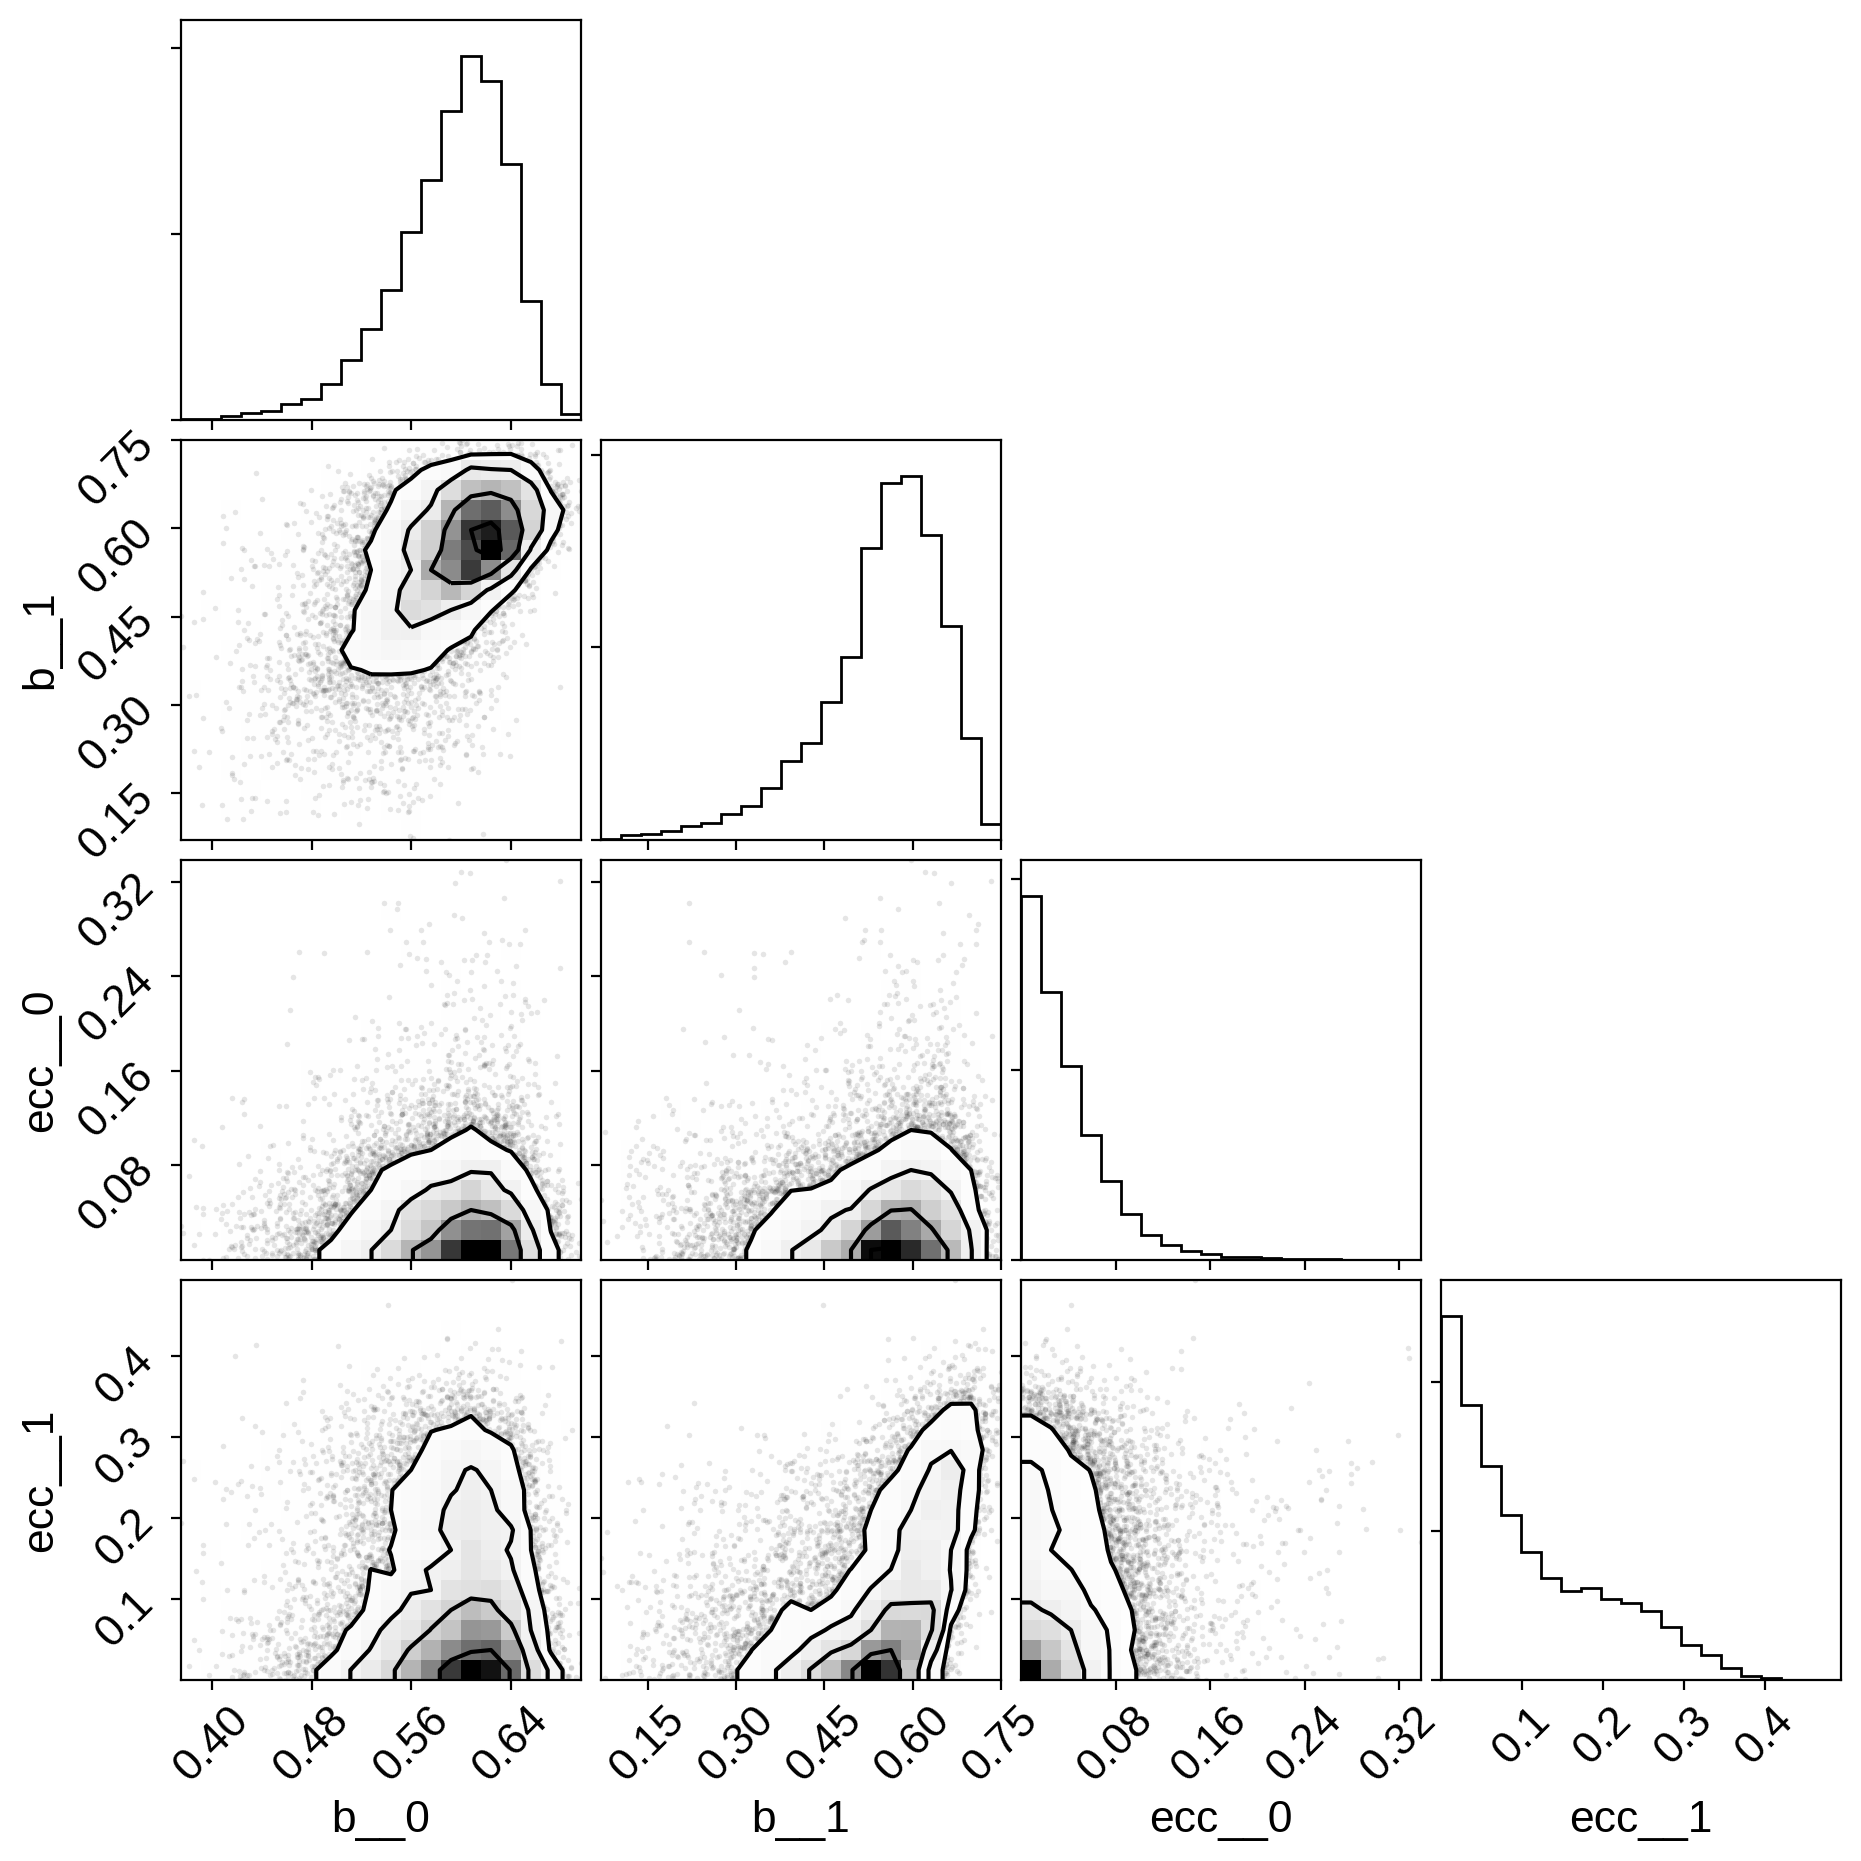

In [16]:
import corner

varnames = ["b", "ecc"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

## Phase plots

Finally, as in the :ref:`rv` and :ref:`transit` tutorials, we can make folded plots of the transits and the radial velocities and compare to the posterior model predictions. (Note: planets b and c in this tutorial are swapped compared to the labels from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497))

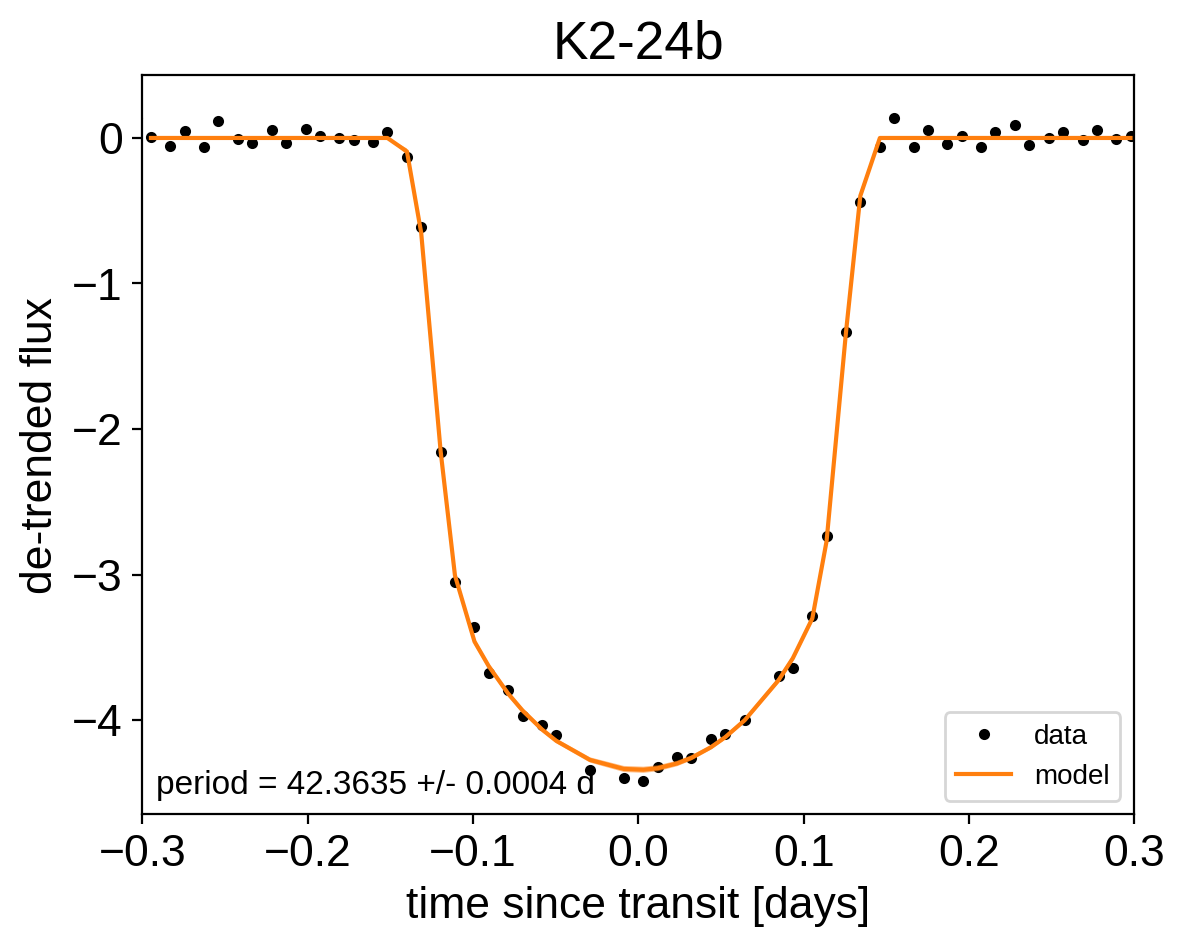

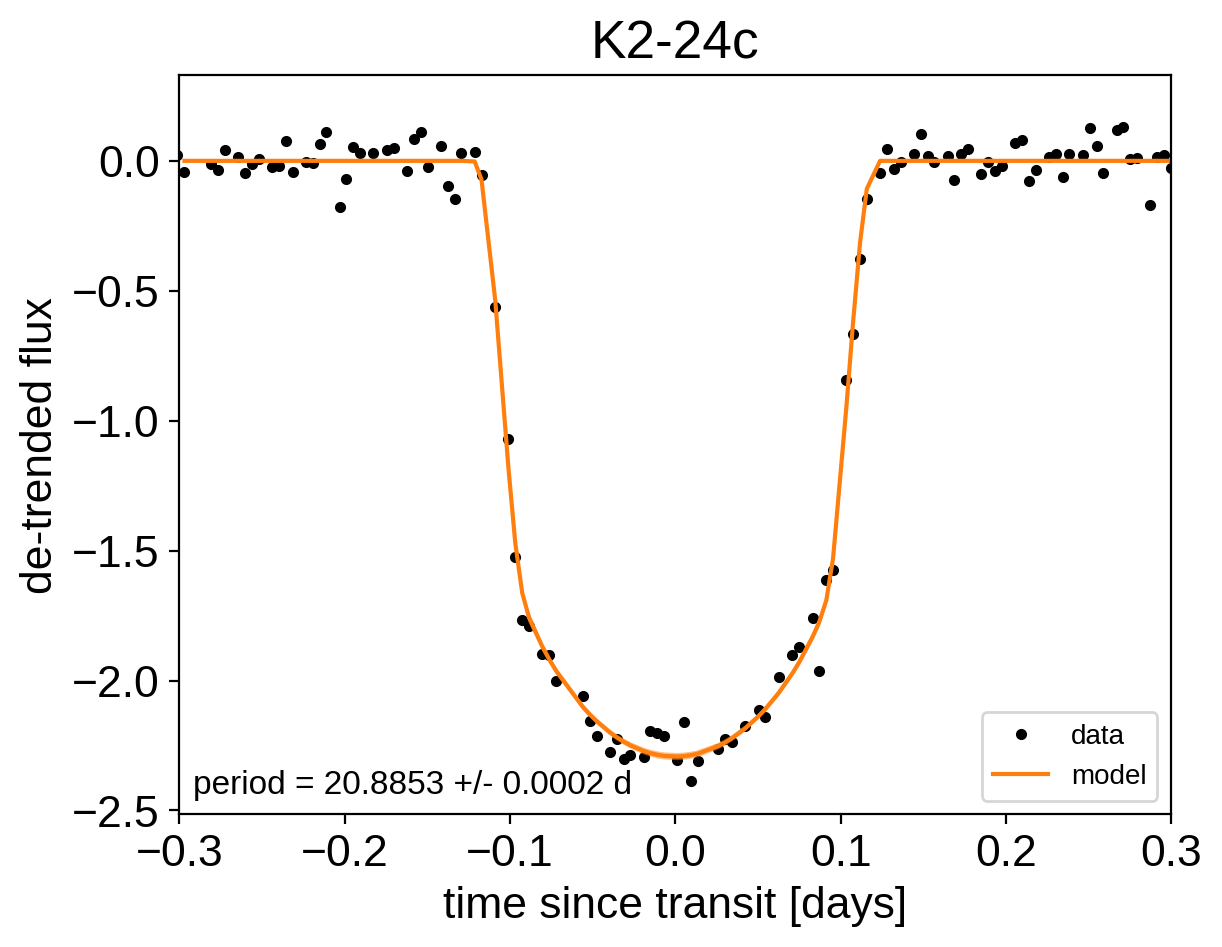

In [17]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Compute the GP prediction
    gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
    plt.plot(x_fold, y[mask] - gp_mod - other, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(
        x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
    )
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n])
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("K2-24{0}".format(letter))
    plt.xlim(-0.3, 0.3)

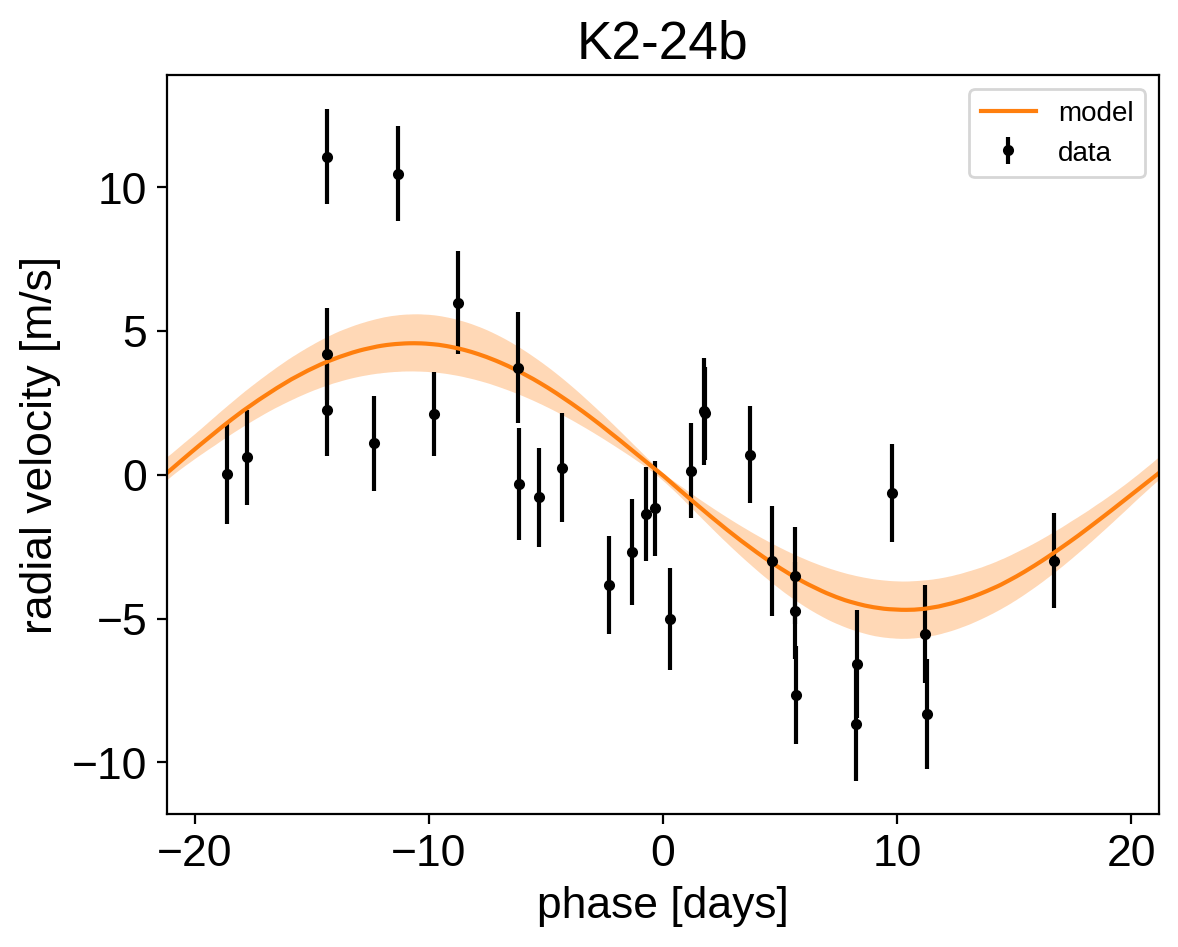

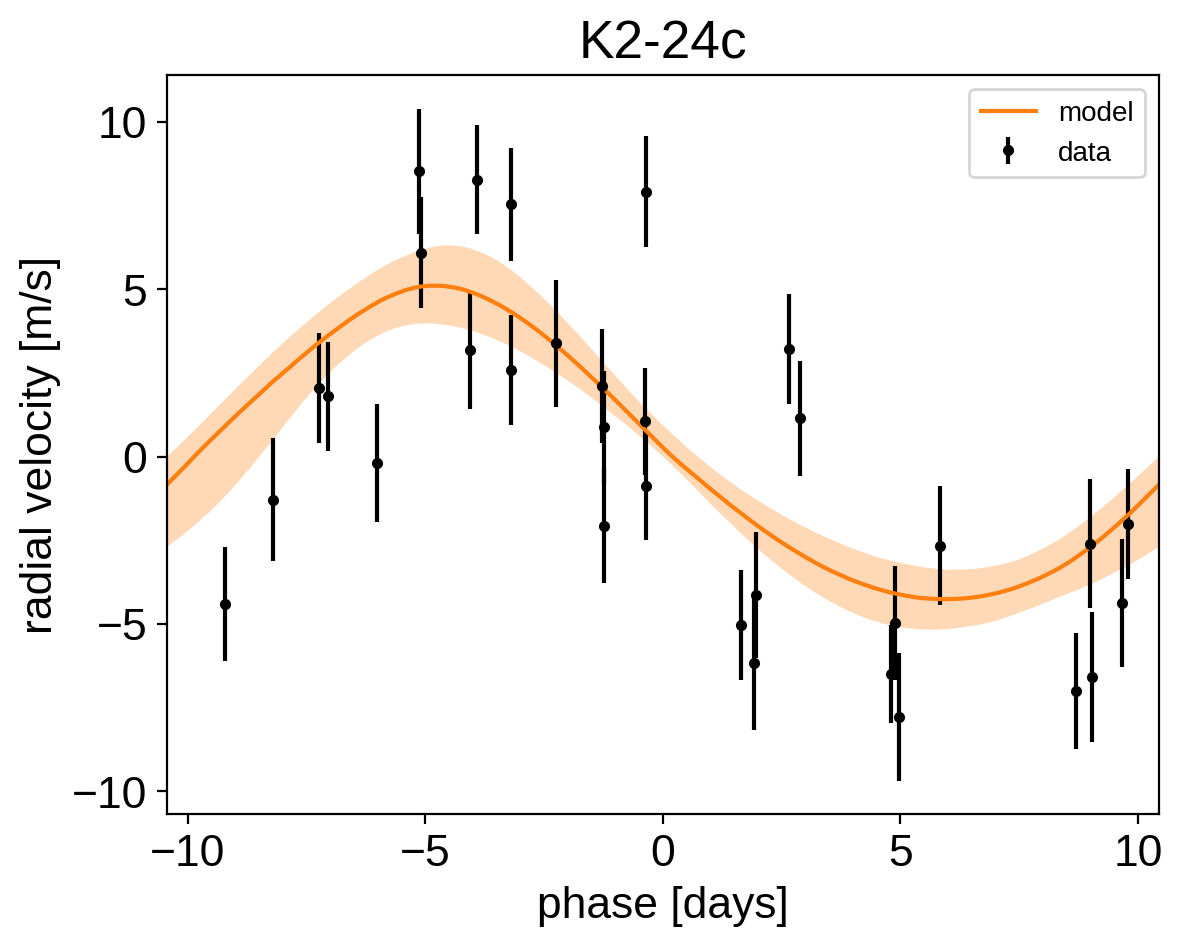

In [18]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y_rv - other, yerr=yerr_rv, fmt=".k", label="data")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t_rv - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

We can also compute the posterior constraints on the planet densities.

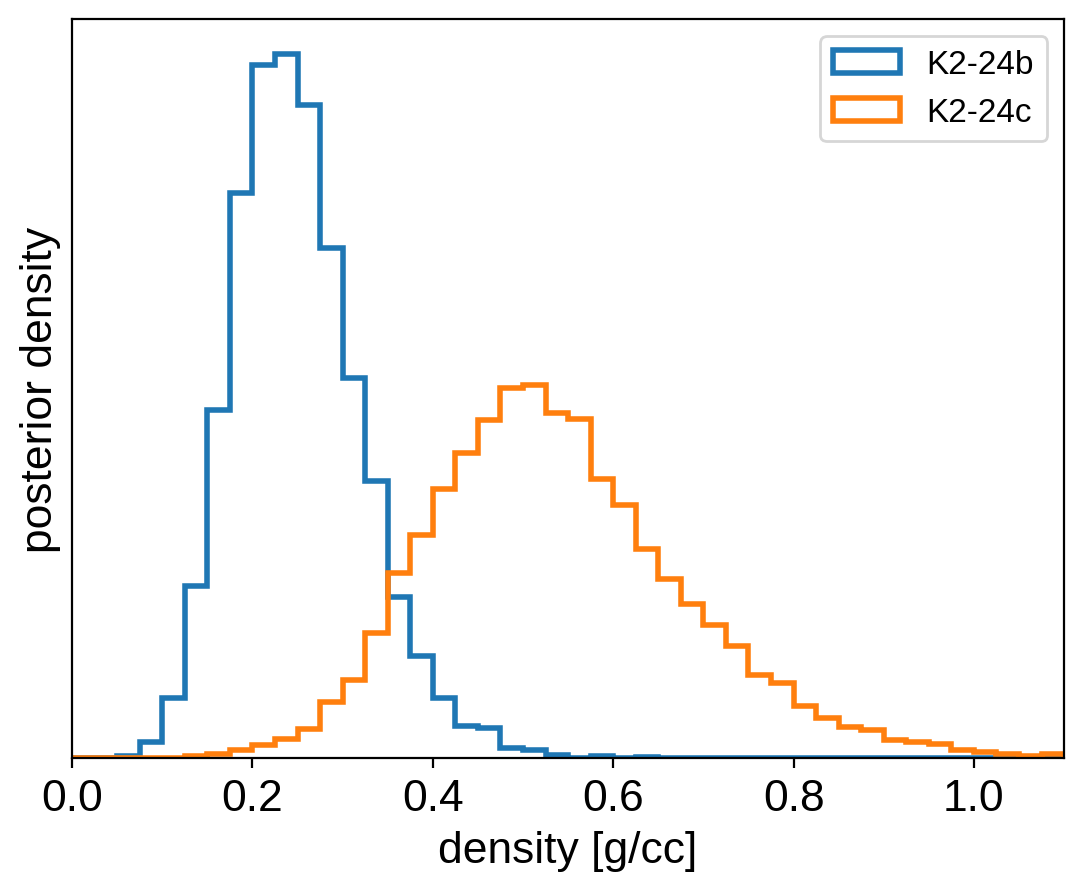

In [19]:
volume = 4 / 3 * np.pi * trace["r_pl"] ** 3
density = u.Quantity(trace["m_pl"] / volume, unit=u.M_earth / u.R_sun ** 3)
density = density.to(u.g / u.cm ** 3).value

bins = np.linspace(0, 1.1, 45)
for n, letter in enumerate("bc"):
    plt.hist(
        density[:, n],
        bins,
        histtype="step",
        lw=2,
        label="K2-24{0}".format(letter),
        density=True,
    )
plt.yticks([])
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [20]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano,
exoplanet:vaneylen19}.


In [21]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Rodrigo Luger and Ian Czekala and
            Eric Agol and Adrian Price-Whelan and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.2},
   month = may,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
